# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [3]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [4]:
all_data["cough_severity"].value_counts()

0.0    45369
1.0     4647
2.0     1572
3.0       96
Name: cough_severity, dtype: int64

In [5]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

## Using Significance (z) tests and $\chi^{2}$ tests for all features

In [220]:
X.describe(include="all")

age high_risk_exposure_occupation high_risk_interactions  \
count   51695.000000                         51637                  47489   
unique           NaN                             2                      2   
top              NaN                         False                  False   
freq             NaN                         45213                  36026   
mean        2.268363                           NaN                    NaN   
std         1.140394                           NaN                    NaN   
min         1.000000                           NaN                    NaN   
25%         1.000000                           NaN                    NaN   
50%         2.000000                           NaN                    NaN   
75%         3.000000                           NaN                    NaN   
max         4.000000                           NaN                    NaN   

       diabetes    chd    htn cancer asthma autoimmune_dis smoker  ...    sob  \
count     51695  51695  51695  51695  51695          51695  51695  ...  51602   
unique        2      2      2      2      2              2      2  ...      2   
top       False  False  False  False  False          False  False  ...  False   
freq      51134  51336  48088  51465  49617          51482  48560  ...  48429   
mean        NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
std         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
min         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
25%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
50%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
75%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
max         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   

        sob_severity  diarrhea  fatigue  headache  loss_of_smell  \
count   51602.000000     51619    51630     51623          51616   
unique           NaN         2        2         2              2   
top              NaN     False    False     False          False   
freq             NaN     49773    45684     46356          50976   
mean        0.082768       NaN      NaN       NaN            NaN   
std         0.344204       NaN      NaN       NaN            NaN   
min         0.000000       NaN      NaN       NaN            NaN   
25%         0.000000       NaN      NaN       NaN            NaN   
50%         0.000000       NaN      NaN       NaN            NaN   
75%         0.000000       NaN      NaN       NaN            NaN   
max         2.000000       NaN      NaN       NaN            NaN   

       loss_of_taste runny_nose muscle_sore sore_throat  
count          51616      51619       51624       51623  
unique             2          2           2           2  
top            False      False       False       False  
freq           50961      48267       48318       45850  
mean             NaN        NaN         NaN         NaN  
std              NaN        NaN         NaN         NaN  
min              NaN        NaN         NaN         NaN  
25%              NaN        NaN         NaN         NaN  
50%              NaN        NaN         NaN         NaN  
75%              NaN        NaN         NaN         NaN  
max              NaN        NaN         NaN         NaN  

[11 rows x 34 columns]

### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.05 (z-value of 1.96 for 2 tails)

In [221]:
Pos_stats=all_data.loc[y == "Positive", X.columns].describe()
Neg_stats=all_data.loc[y == "Negative", X.columns].describe()

d_means = Pos_stats.loc["mean"] - Neg_stats.loc["mean"]
#print(d_means)
d_std_sampling_dist = np.sqrt((Pos_stats.loc["std"]**2)/(y=="Positive").sum() + (Neg_stats.loc["std"]**2)/(y=="Negative").sum())
#print(d_std_sampling_dist)
z_values = d_means / d_std_sampling_dist
z_values

age                         -2.006241
temperature                 12.152967
pulse                       12.014771
sys                          3.287275
dia                          4.719209
rr                           5.919927
sats                        -2.205488
days_since_symptom_onset   -14.235763
cough_severity              15.373404
sob_severity                 3.891611
dtype: float64

As we can see, we cannot reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

|Degrees of Freedom | $\chi^{2}$ value |
|:-|-:|
|1 | 7.879 |
|2 | 10.597|
|3 | 12.838|


In [219]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

for column in categorical_columns:
    #size() gives us a count of the group by (basically we just count how many are in each category in each column)
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
    
    result = (((a - expected_values)**2) / expected_values).values.sum()
    dof = (a.shape[0]-1) * (a.shape[1]-1)
        
    print(Fore.BLUE, column, Fore.BLACK, result, Fore.BLACK, "Degrees of Freedom:", dof)
    



 age  12.304979994127251  Degrees of Freedom: 3
 high_risk_exposure_occupation  29.169743671410526  Degrees of Freedom: 1
 high_risk_interactions  8.41341454158724  Degrees of Freedom: 1
 diabetes  14.737881198206395  Degrees of Freedom: 1
 chd  0.27847911649352725  Degrees of Freedom: 1
 htn  0.020651208663104388  Degrees of Freedom: 1
 cancer  0.03611757567792817  Degrees of Freedom: 1
 asthma  4.967144991265233  Degrees of Freedom: 1
 autoimmune_dis  1.881511790675224  Degrees of Freedom: 1
 smoker  2.1566721956255455  Degrees of Freedom: 1
 ctab  43.020189783598475  Degrees of Freedom: 1
 labored_respiration  12.429060901771509  Degrees of Freedom: 1
 rhonchi  47.22018187987378  Degrees of Freedom: 1
 wheezes  53.45630238256156  Degrees of Freedom: 1
 cough  585.3538502797772  Degrees of Freedom: 1
 cough_severity  591.8810689445486  Degrees of Freedom: 3
 fever  101.0392643859637  Degrees of Freedom: 1
 sob  29.644225710571217  Degrees of Freedom: 1
 sob_severity  31.4890947727516

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

In [10]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [11]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [12]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [13]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [14]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [15]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [16]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [17]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None, class_threshold=.5):
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    data_x = data_x.sample(data_x.shape[0])
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y[train_x.index]
        valid_x = data_x.iloc[start:end]
        valid_y = data_y[valid_x.index]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
        
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0), results.std(ddof=1, axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - (fold_size * ratio_negatives_to_positives)), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0), results.std(ddof=1, axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results_mean, results_std = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results_mean[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((2,len(models), 6))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results_mean, results_std = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results_mean, results_std = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
            result_table[0,i] = results_mean[1]
            result_table[1,i] = results_std[1]
            
            print("")
            print("Mean metrics")
            display(pd.DataFrame(results_mean, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("Spread in metrics (sample std)")
            display(pd.DataFrame(results_std, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            
        except Exception as e:
            print(e)
        i+=1
        
    
    display(pd.DataFrame(result_table[0], index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
    
    lower_bound_df = pd.DataFrame((result_table[0]- 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame((result_table[0]+ 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])
    interval_df = lower_bound_df + "-" + upper_bound_df
    
    display(interval_df)

In [18]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [77]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


Dummy Random
╠■■■■■■■■■╣


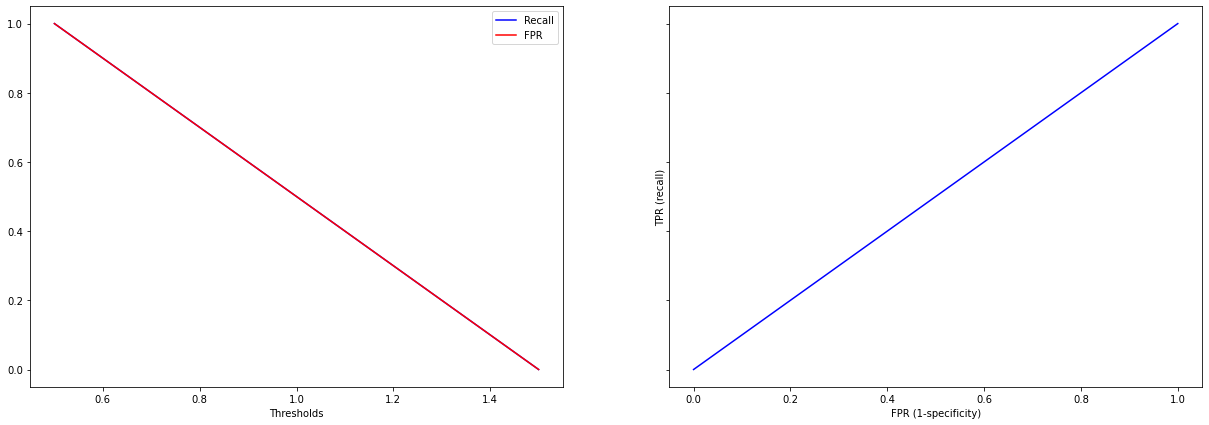

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


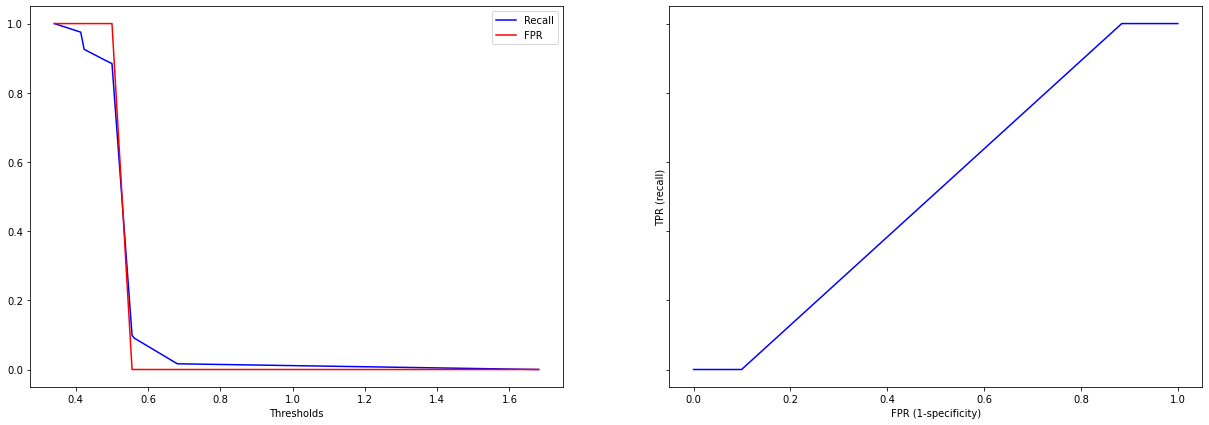

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.50450  0.081470   0.554422     0.927455  0.139635  0.516376
Validation   0.51311  0.083447   0.631936     0.943443  0.143706  0.527024

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004678  0.025362   0.102680     0.026769  0.039442  0.003986
Validation  0.017972  0.039111   0.180263     0.030290  0.064540  0.022428

Random Forest (100 estimators)
╠■■■■■■■■■╣


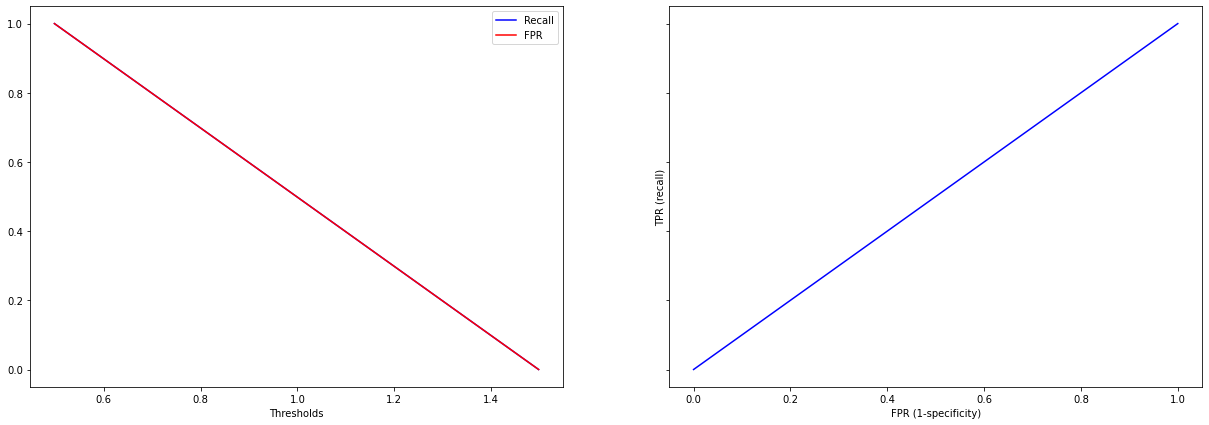

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.501409  0.572449   0.300737     0.430364  0.394205  0.503494
Validation  0.500007  0.573024   0.300193     0.427049  0.393883  0.492690

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002661  0.493402   0.258837     0.491154  0.339325  0.002907
Validation  0.013132  0.494183   0.258456     0.493885  0.339203  0.022509

XGBoost Classifier
╠■■■■■■■■■╣


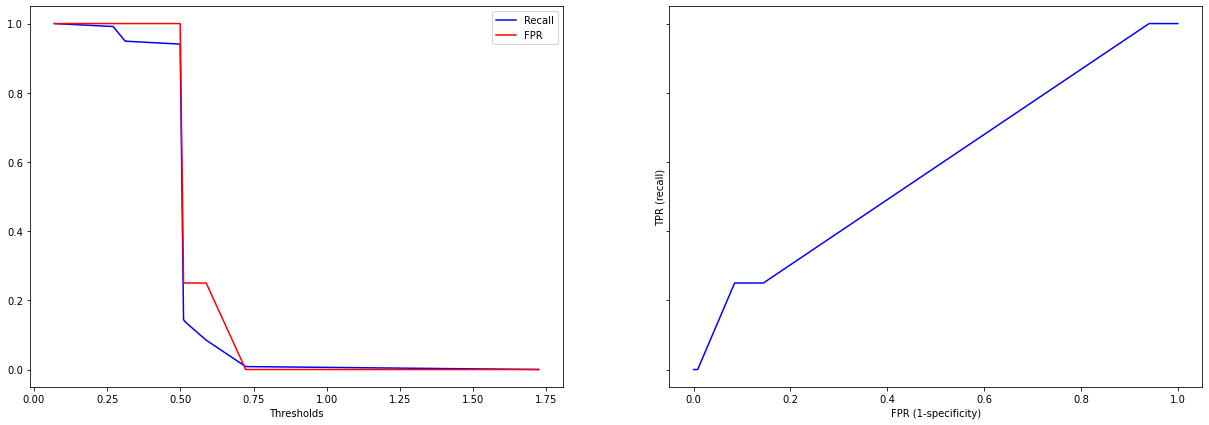

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.516092  0.828440   0.518880     0.203818  0.602312  0.526395
Validation  0.493856  0.809983   0.488462     0.177049  0.584623  0.490803

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003181  0.263938   0.030915     0.263487  0.160615  0.003461
Validation  0.018273  0.269952   0.028885     0.263323  0.171295  0.013774

SVM
╠■■■■■■■■■╣


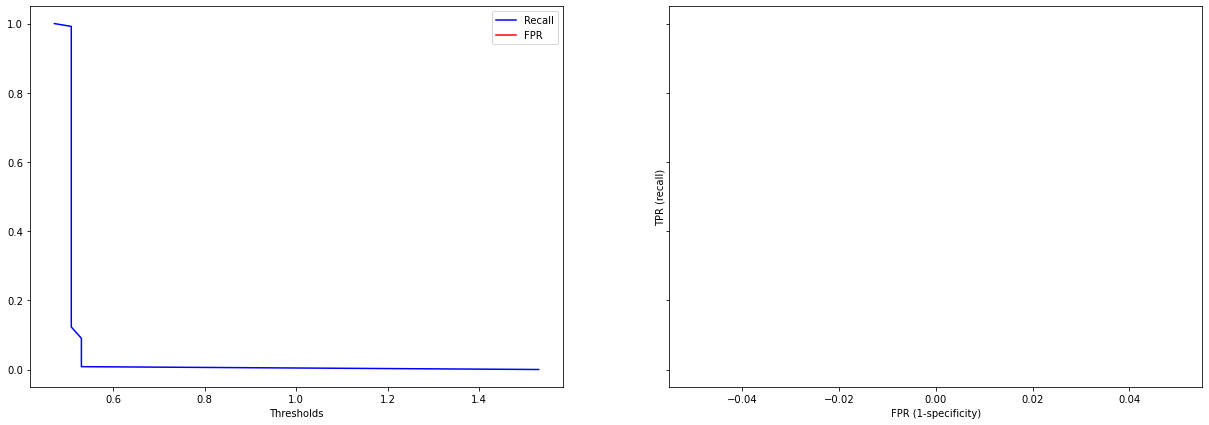

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.494454  0.139098   0.411130     0.849727  0.146271  0.495326
Validation  0.495498  0.145842   0.372912     0.845902  0.151839  0.506499

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012009  0.275660   0.192675     0.258414  0.188816  0.017119
Validation  0.020778  0.284033   0.224289     0.282699  0.192375  0.027736

KNN
╠■■■■■■■■■╣


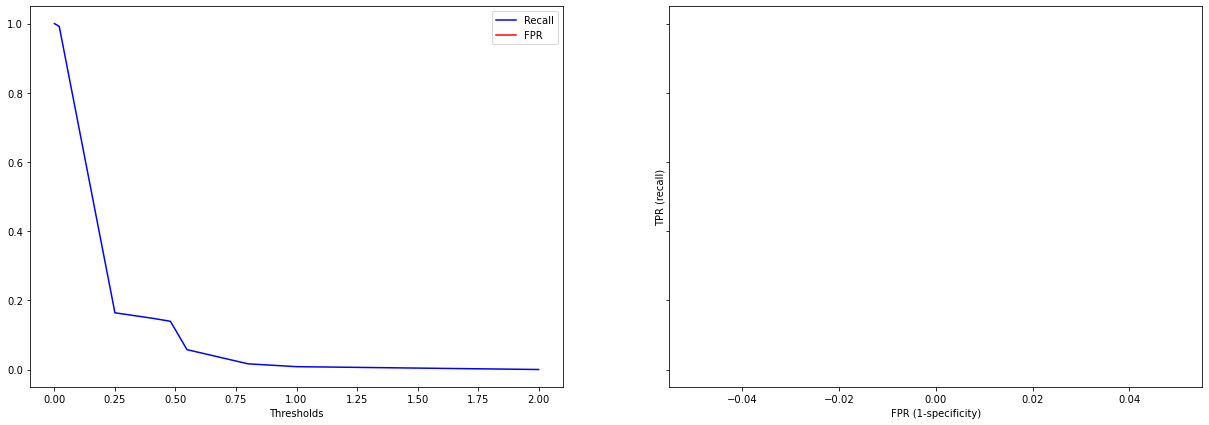

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.508410  0.036278   0.681528     0.980455  0.06770  0.499908
Validation  0.504502  0.027809   0.660779     0.981967  0.05224  0.491621

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001899  0.019308   0.065030     0.017577  0.032728  0.005474
Validation  0.006881  0.019327   0.237834     0.018450  0.034167  0.029659

Logistic Regression
╠■■■■■■■■■╣


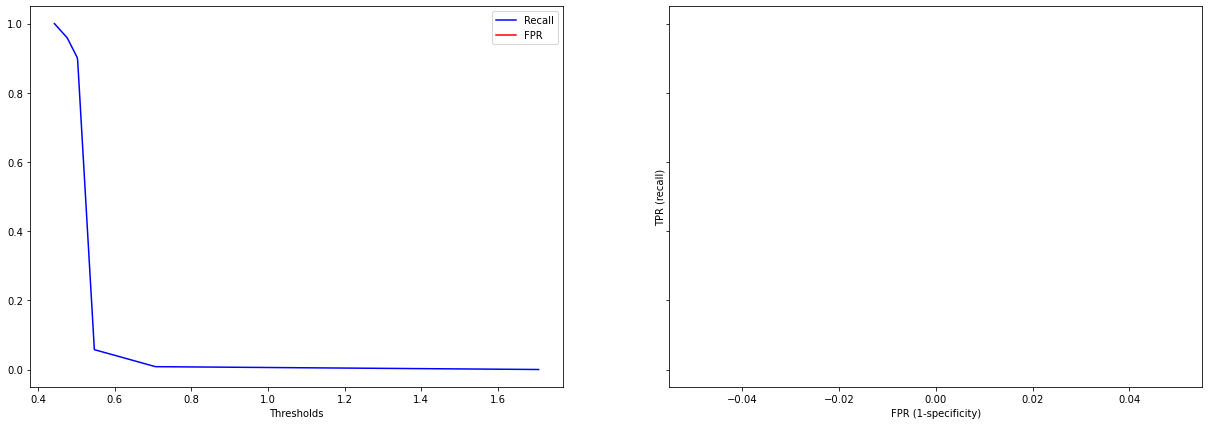

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.514410  0.726975   0.526338     0.301909  0.546971  0.521593
Validation  0.503265  0.712488   0.485769     0.293443  0.528835  0.505848

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003467  0.338874   0.038643     0.338470  0.209225  0.004388
Validation  0.020441  0.353047   0.071865     0.339893  0.236508  0.024700

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.513110  0.083447   0.631936     0.943443   
Random Forest (100 estimators)  0.500007  0.573024   0.300193     0.427049   
XGBoost Classifier              0.493856  0.809983   0.488462     0.177049   
SVM                             0.495498  0.145842   0.372912     0.845902   
KNN                             0.504502  0.027809   0.660779     0.981967   
Logistic Regression             0.503265  0.712488   0.485769     0.293443   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.143706  0.527024  
Random Forest (100 estimators)  0.393883  0.492690  
XGBoost Classifier              0.584623  0.490803  
SVM                             0.151839  0.506499  
KNN                             0.052240  0.491621  
Logistic Regression             0.528835  0.505848

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                    0.5017429416409955-0.5244765297541198   
Random Forest (100 estimators)  0.49170148287170173-0.5083118995304393   
XGBoost Classifier                0.482299158857562-0.5054124503762955   
SVM                              0.4823571831646001-0.5086398057949181   
KNN                              0.5001498908219354-0.5088531202185463   
Logistic Regression              0.4903372355123211-0.5161933767325767   

                                                                  Recall  \
Dummy Random                                                     0.0-0.0   
MultinomialNB                   0.058710395158304486-0.10818284754461435   
Random Forest (100 estimators)     0.2604756011641937-0.8855726462035258   
XGBoost Classifier                 0.6392498273518951-0.9807155198425604   
SVM                              -0.03379679879792949-0.3254801254672618   
KNN                             0.015585193027241212-0.04003255987159924   
Logistic Regression               0.48920184484885254-0.9357748311474156   

                                                             Precision  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5179273672474918-0.7459439787977673   
Random Forest (100 estimators)  0.1367311754532589-0.46365558800879786   
XGBoost Classifier               0.4701939686665314-0.5067304669437102   
SVM                             0.23105862019764736-0.5147644382783417   
KNN                               0.510359601390467-0.8111988401679746   
Logistic Regression             0.44031681318251914-0.5312202556124491   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                     0.9242857397344719-0.9625995061671673   
Random Forest (100 estimators)   0.11468872744577052-0.7394096332099672   
XGBoost Classifier              0.010508871691943061-0.3435894889637947   
SVM                               0.6671070317067097-1.0246962469818148   
KNN                                0.9702982751343919-0.993636151095116   
Logistic Regression               0.07847519598812533-0.508410049913514   

                                                                      F1  \
Dummy Random                                                     0.0-0.0   
MultinomialNB                     0.10288775029701341-0.1845244957819997   
Random Forest (100 estimators)     0.1793522454249622-0.6084136151512431   
XGBoost Classifier                  0.476286526336423-0.6929594405499829   
SVM                              0.030170104444807805-0.2735076399044949   
KNN                             0.030630526446168205-0.07384879274910648   
Logistic Regression                0.3792543126740324-0.6784154974961214   

                                                                ROC_AUC  
Dummy Random                                                    0.5-0.5  
MultinomialNB                     0.5128392882552458-0.5412092562613738  
Random Forest (100 estimators)   0.47845357913663344-0.5069256025240356  
XGBoost Classifier              0.48209136576266476-0.49951402486796825  
SVM                               0.48895745379059335-0.524040680289108  
KNN                               0.4728629963451884-0.5103790073997616  
Logistic Regression              0.49022665761497425-0.5214700844532258

In [78]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


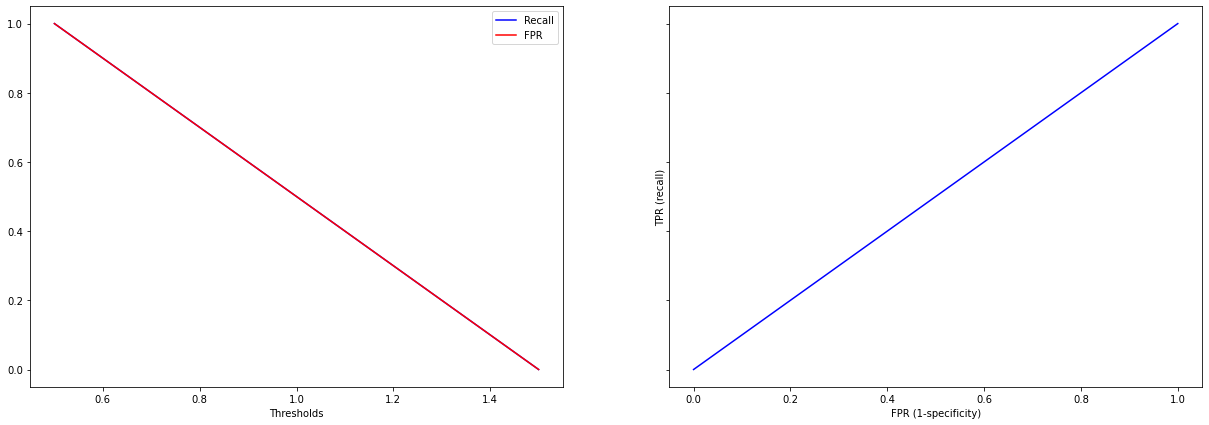

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


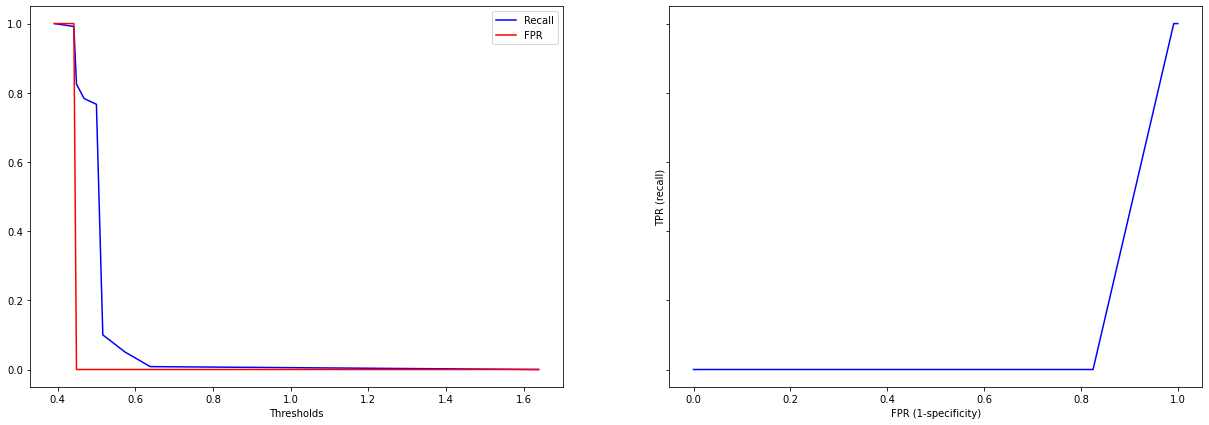

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.528639  0.192940   0.588658     0.864273  0.289812  0.557920
Validation  0.519215  0.189697   0.544121     0.849180  0.276902  0.546753

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005533  0.021135   0.022798     0.023605  0.022382  0.009109
Validation  0.035061  0.083000   0.068767     0.029980  0.093383  0.037508

Random Forest (100 estimators)
╠■■■■■■■■■╣


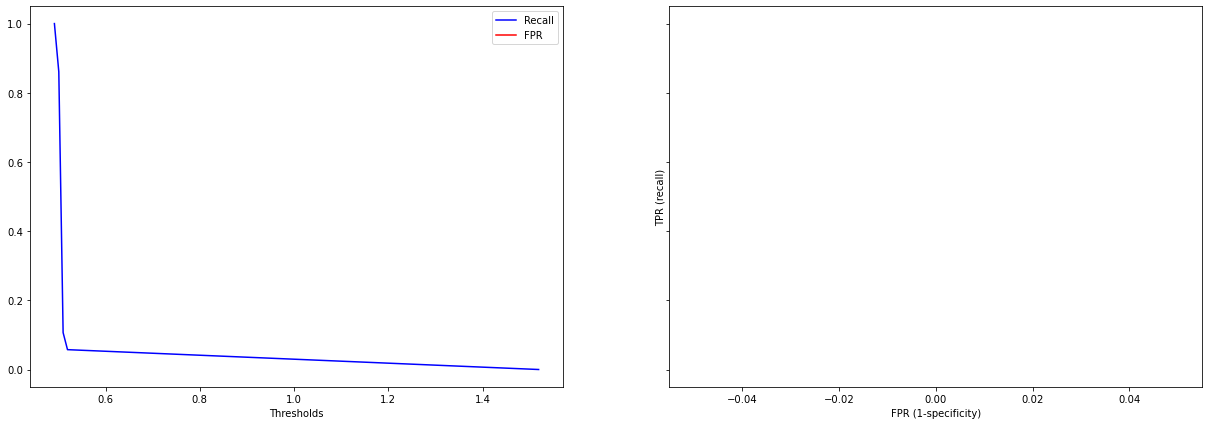

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.534594  0.589338   0.550355     0.479909  0.504020  0.552732
Validation  0.513531  0.558530   0.525291     0.468033  0.470816  0.531972

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008704  0.345662   0.037233     0.335505  0.188696  0.010091
Validation  0.034890  0.362092   0.076602     0.355789  0.210731  0.035025

XGBoost Classifier
╠■■■■■■■■■╣


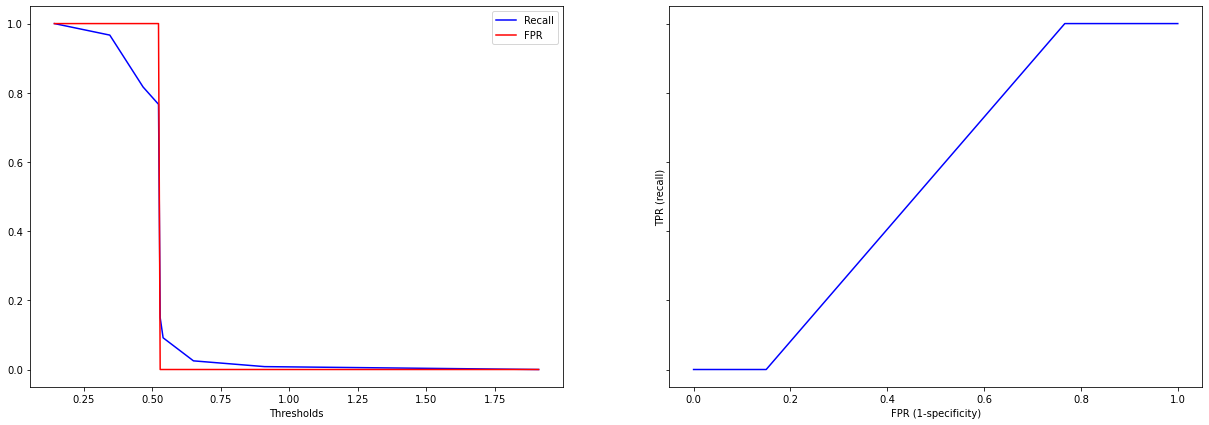

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.546141  0.735885   0.544367     0.356455  0.592041  0.570286
Validation  0.513919  0.696135   0.498028     0.331148  0.553912  0.532872

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005189  0.264559   0.032344     0.258933  0.133748  0.007197
Validation  0.037067  0.288687   0.049137     0.248715  0.175447  0.036413

SVM
╠■■■■■■■■■╣


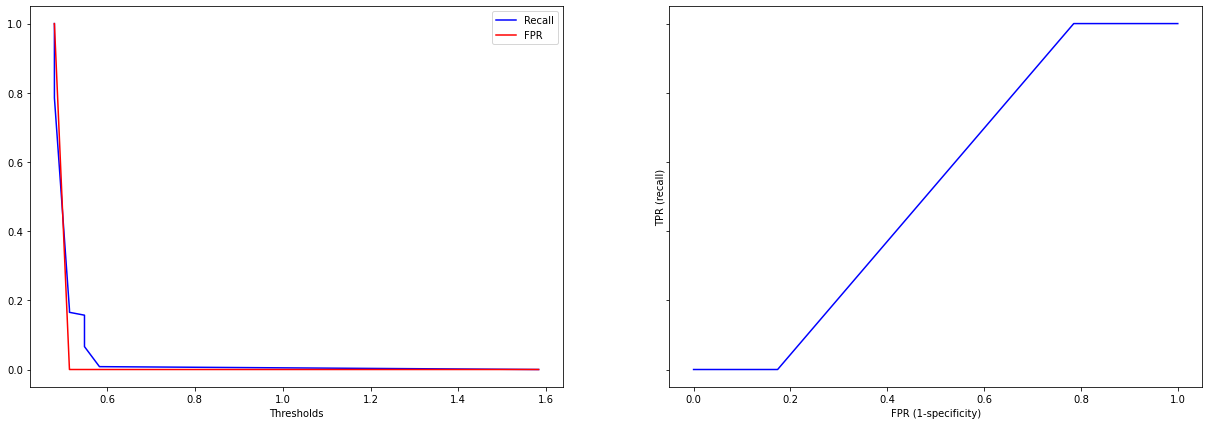

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.532730  0.257456   0.593592     0.808000  0.327843  0.551194
Validation  0.511084  0.218966   0.551339     0.803279  0.287189  0.522333

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004065  0.201171   0.029295     0.201283  0.109699  0.018729
Validation  0.031129  0.160654   0.057674     0.208905  0.103527  0.030568

KNN
╠■■■■■■■■■╣


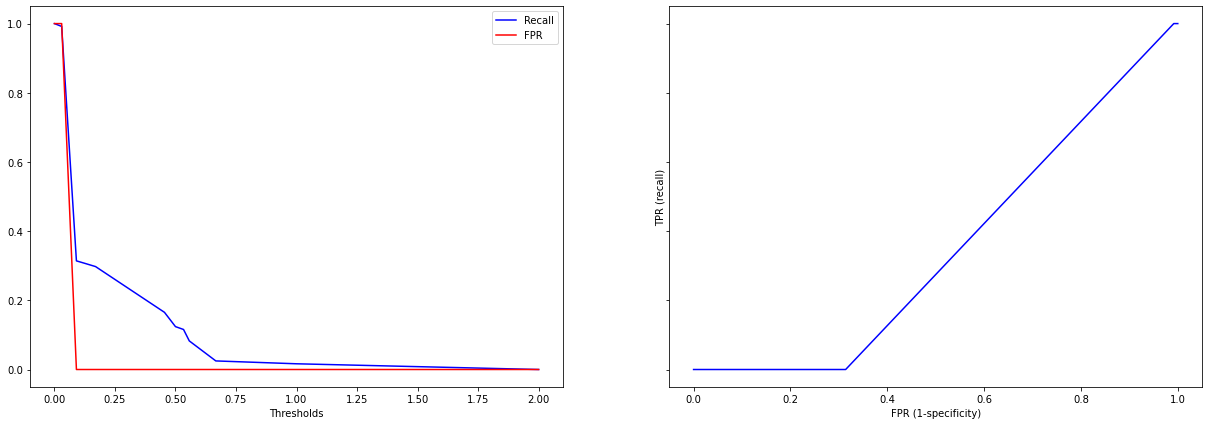

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.518956  0.065555   0.723261     0.972273  0.117821  0.544971
Validation  0.507369  0.048287   0.597393     0.967213  0.086610  0.531985

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008692  0.032317   0.064773     0.018148  0.052183  0.006239
Validation  0.007854  0.033549   0.254364     0.028394  0.056574  0.037391

Logistic Regression
╠■■■■■■■■■╣


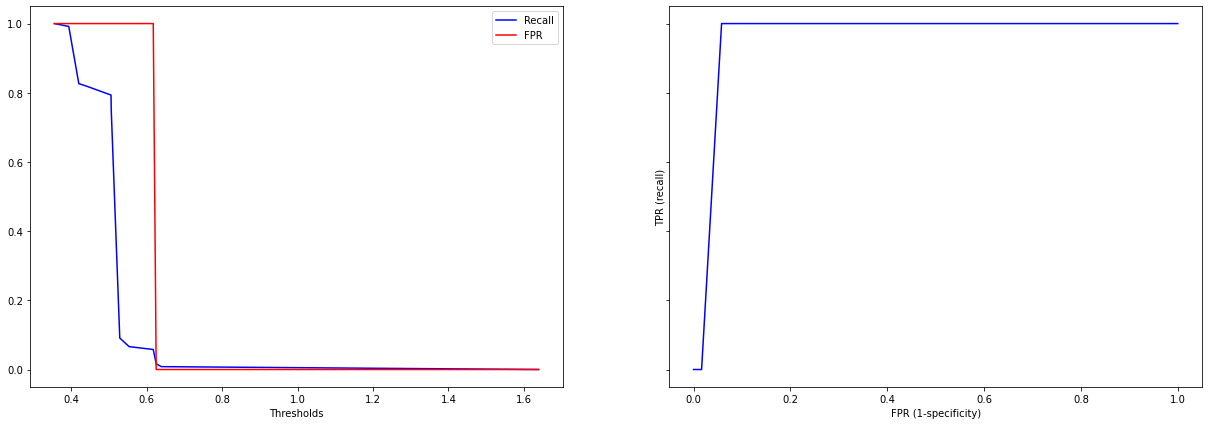

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.539549  0.714879   0.540710     0.364273  0.577539  0.556238
Validation  0.526613  0.702712   0.520554     0.350000  0.556574  0.539749

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007133  0.274393   0.033303     0.267378  0.148174  0.006870
Validation  0.025194  0.306894   0.027770     0.285491  0.184310  0.039186

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.519215  0.189697   0.544121     0.849180   
Random Forest (100 estimators)  0.513531  0.558530   0.525291     0.468033   
XGBoost Classifier              0.513919  0.696135   0.498028     0.331148   
SVM                             0.511084  0.218966   0.551339     0.803279   
KNN                             0.507369  0.048287   0.597393     0.967213   
Logistic Regression             0.526613  0.702712   0.520554     0.350000   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.276902  0.546753  
Random Forest (100 estimators)  0.470816  0.531972  
XGBoost Classifier              0.553912  0.532872  
SVM                             0.287189  0.522333  
KNN                             0.086610  0.531985  
Logistic Regression             0.556574  0.539749

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                    0.4970407847785698-0.5413901285703764   
Random Forest (100 estimators)  0.49146478556346057-0.5355977771665495   
XGBoost Classifier               0.4904763276982299-0.5373624143559687   
SVM                              0.49139600359233704-0.530771945554535   
KNN                              0.5024011668413638-0.5123362035166154   
Logistic Regression               0.510678266617427-0.5425468922985985   

                                                                  Recall  \
Dummy Random                                                     0.0-0.0   
MultinomialNB                     0.1372035831766522-0.24219132552653322   
Random Forest (100 estimators)     0.3295225191061296-0.7875373236234454   
XGBoost Classifier                 0.5135534611002627-0.8787162976628989   
SVM                               0.11735950271322146-0.3205719913558176   
KNN                             0.027069094193845507-0.06950560925810703   
Logistic Regression                 0.508615179165588-0.8968093177023315   

                                                             Precision  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5006289318020776-0.5876125543001471   
Random Forest (100 estimators)    0.476843867678903-0.5737385344280188   
XGBoost Classifier              0.46695037488884283-0.5291048446466646   
SVM                              0.5148628802954153-0.5878157774542793   
KNN                              0.4365192696318928-0.7582676977866535   
Logistic Regression               0.5029908125257349-0.538117027746377   

                                                           Specificity  \
Dummy Random                                                   1.0-1.0   
MultinomialNB                    0.8302192878984725-0.8681413678392321   
Random Forest (100 estimators)  0.24301225869273746-0.6930533150777543   
XGBoost Classifier              0.1738464056802442-0.48844867628696886   
SVM                              0.6711557221387705-0.9354016549104098   
KNN                              0.9492549981145848-0.9851712313936121   
Logistic Regression             0.16943962662363016-0.5305603733763697   

                                                                     F1  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                     0.21784163954096075-0.335962590772311   
Random Forest (100 estimators)    0.3375379848986104-0.6040937619870091   
XGBoost Classifier                0.4429493785443089-0.6648747539592536   
SVM                             0.22171202711485738-0.35266500217718866   
KNN                             0.05082931140698496-0.12239071889006112   
Logistic Regression               0.44000591553936463-0.673142086099141   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5230313481124038-0.5704750198322215  
Random Forest (100 estimators)   0.5098200752116666-0.554123090691371  
XGBoost Classifier              0.5098419028055063-0.5559011442379715  
SVM                             0.5030002089644864-0.5416666237559774  
KNN                              0.5083367740560779-0.555632883982346  
Logistic Regression             0.5149656493411768-0.5645319505259799

In [79]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the most important feature from epidemiological factors. <i>Note:</i> Most of the models have really high specificity, which might not be a good thing since the recall is really low and both precision and accuracy are just around .5 (this experiments use undersampling to have balanced classes). This suggests that most of the models are predicting everything is negative.

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [19]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [20]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
5135   195.0  135.0    4
6106   215.0  115.0    4
9058   200.0  120.0    3
11792  190.0  130.0    3
14314  205.0  125.0    4
19137  215.0  117.0    4
20168  190.0  130.0    4
20379  220.0  140.0    4
20582  200.0  118.0    4
28579  180.0  130.0    3
31555  185.0  130.0    3
31880  180.0  135.0    2
33497  210.0  120.0    4
36197  190.0  135.0    3
36239  185.0  135.0    3
45860  220.0  115.0    3
48067  190.0  130.0    4
50607  220.0  108.0    4
75219  195.0  130.0    2
76797  195.0  130.0    1
77724  190.0  135.0    2
91625  210.0  125.0    3
93508  200.0  118.0    4

As expected, all pressure variables (including pam) are correlated between each other

In [21]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


In [22]:
vitals.describe()

temperature         pulse            rr          sats           pam
count  46961.000000  47666.000000  40972.000000  46959.000000  45990.000000
mean      36.795284     76.895103     14.708826     98.239869     93.238276
std        0.287278     13.211416      1.957359      1.401417     10.886470
min       34.650000     35.000000      8.000000     81.000000     50.333333
25%       36.650000     68.000000     13.000000     97.000000     86.000000
50%       36.800000     76.000000     15.000000     98.000000     92.666667
75%       36.950000     85.000000     16.000000     99.000000     99.666667
max       39.600000    150.000000     32.000000    100.000000    166.666667

<AxesSubplot:>

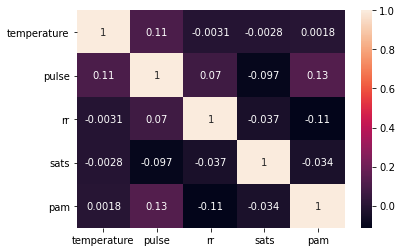

In [84]:
sns.heatmap(vitals.corr(), annot=True)

In [23]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


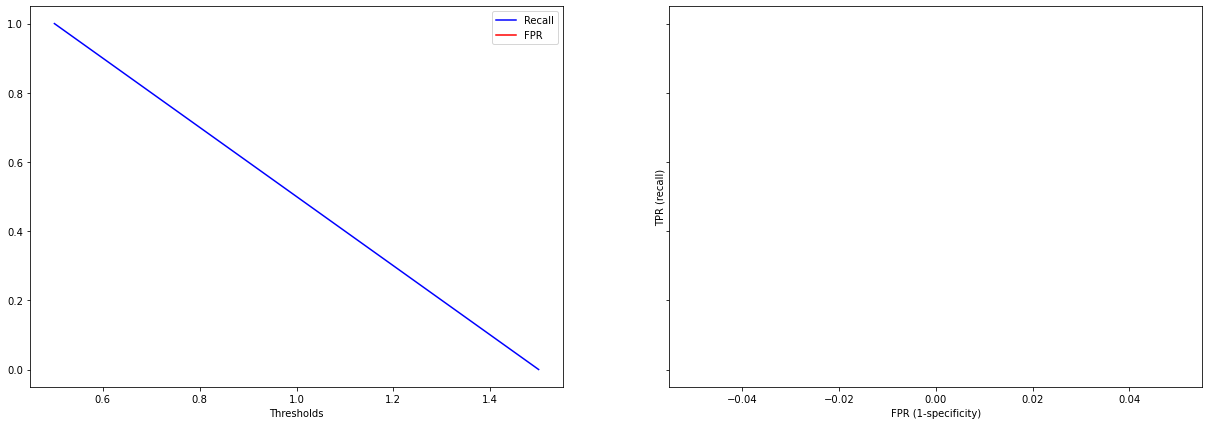

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


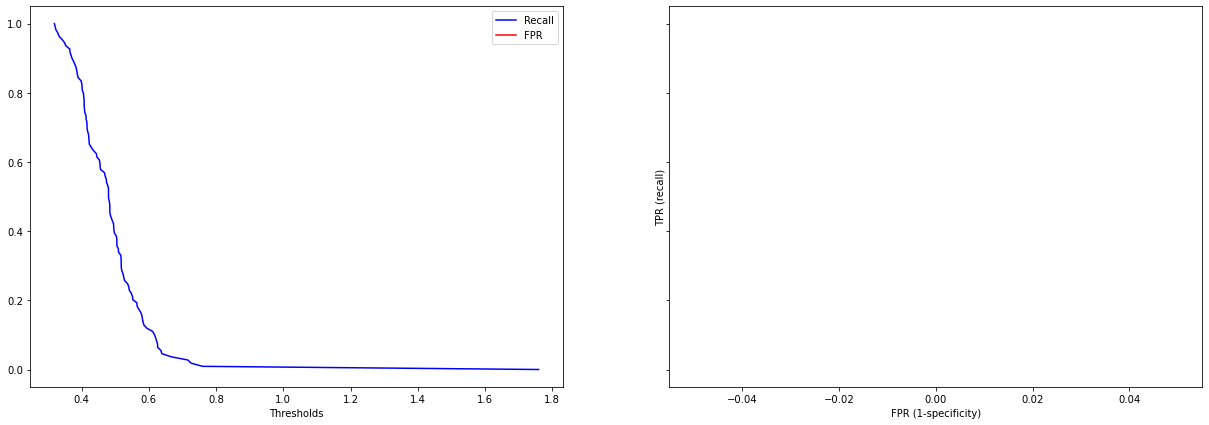

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.567784  0.532707   0.572693     0.602828  0.551962  0.594966
Validation  0.562369  0.529591   0.567155     0.595413  0.546133  0.593977

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006539  0.006292   0.007400     0.009860  0.006130  0.009264
Validation  0.038535  0.082536   0.037347     0.041583  0.058031  0.047857

Random Forest (100 estimators)
╠■■■■■■■■■╣


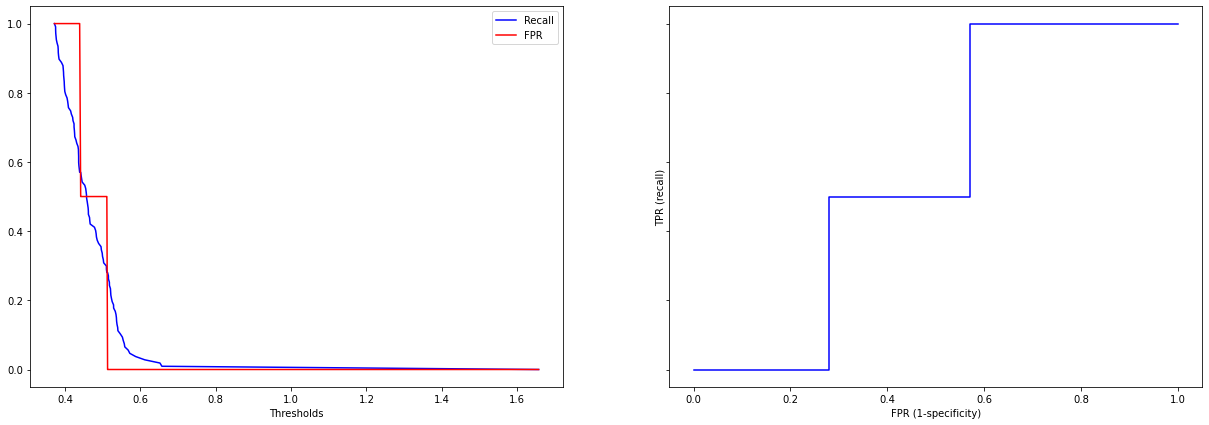

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.612046  0.566369   0.623261     0.657677  0.593175  0.662090
Validation  0.577896  0.540575   0.584689     0.615596  0.558372  0.614349

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006141  0.022518   0.008178     0.021008  0.011720  0.006629
Validation  0.048701  0.108539   0.045532     0.060307  0.072227  0.067764

XGBoost Classifier
╠■■■■■■■■■╣


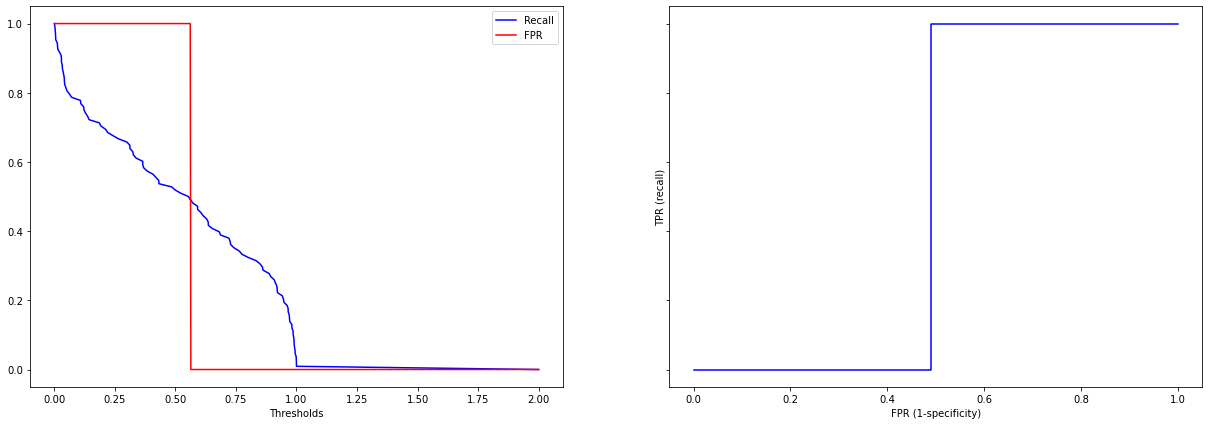

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997575  0.997776   0.997373     0.997374  0.997574  0.999984
Validation  0.532213  0.526864   0.535086     0.537615  0.530282  0.550963

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000916  0.001148   0.001184     0.001186  0.000916  0.000009
Validation  0.037453  0.049745   0.037640     0.054224  0.039045  0.023448

SVM
╠■■■■■■■■■╣


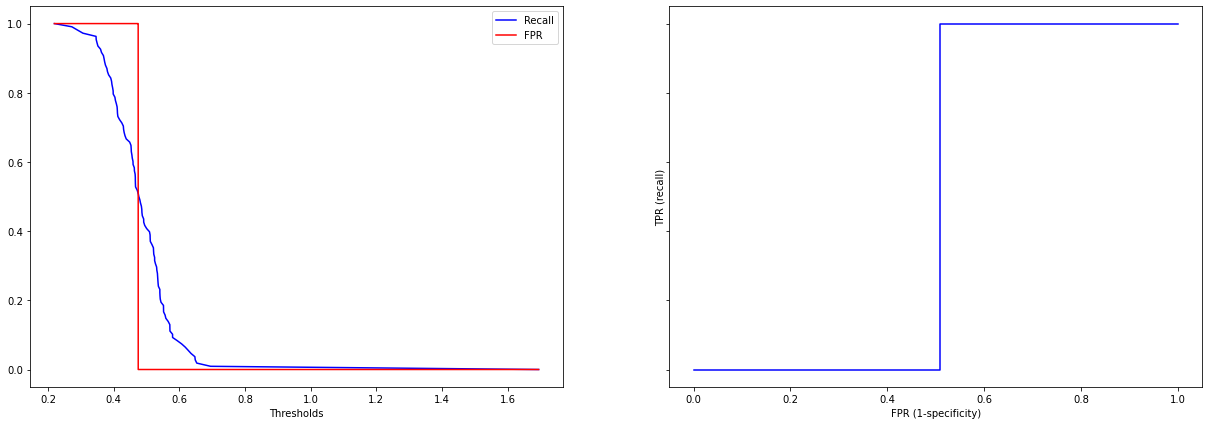

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589611  0.538873   0.599443     0.640303  0.567523  0.635888
Validation  0.589783  0.536939   0.598692     0.643119  0.564049  0.632007

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012323  0.015486   0.013406     0.011813  0.014199  0.011612
Validation  0.056703  0.107095   0.053218     0.037065  0.080170  0.077454

KNN
╠■■■■■■■■■╣


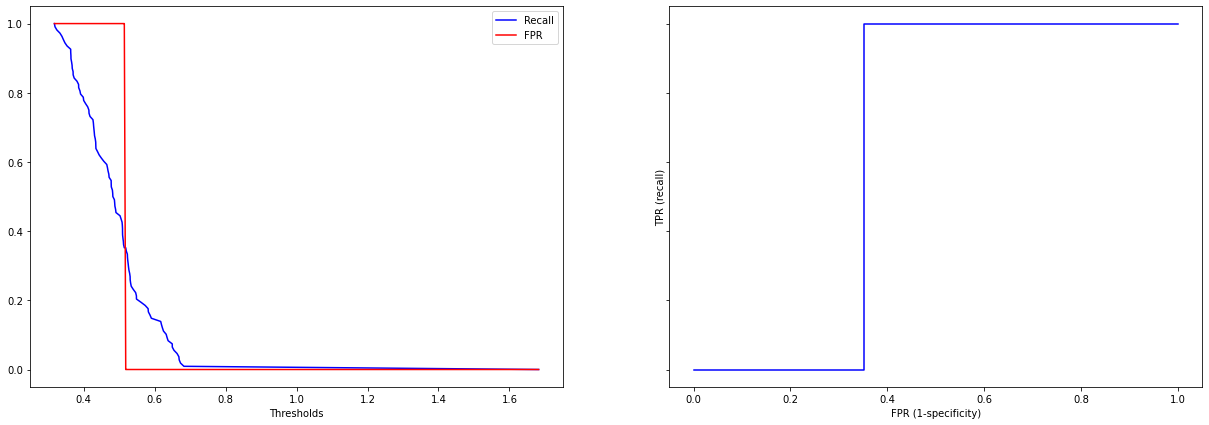

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998383  0.996866   0.999899     0.999899  0.998379  0.999994
Validation  0.571503  0.568724   0.574159     0.574312  0.569412  0.597296

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000818  0.001541   0.000321     0.000319  0.000821  0.000006
Validation  0.025002  0.073718   0.023631     0.063444  0.041373  0.029011

Logistic Regression
╠■■■■■■■■■╣


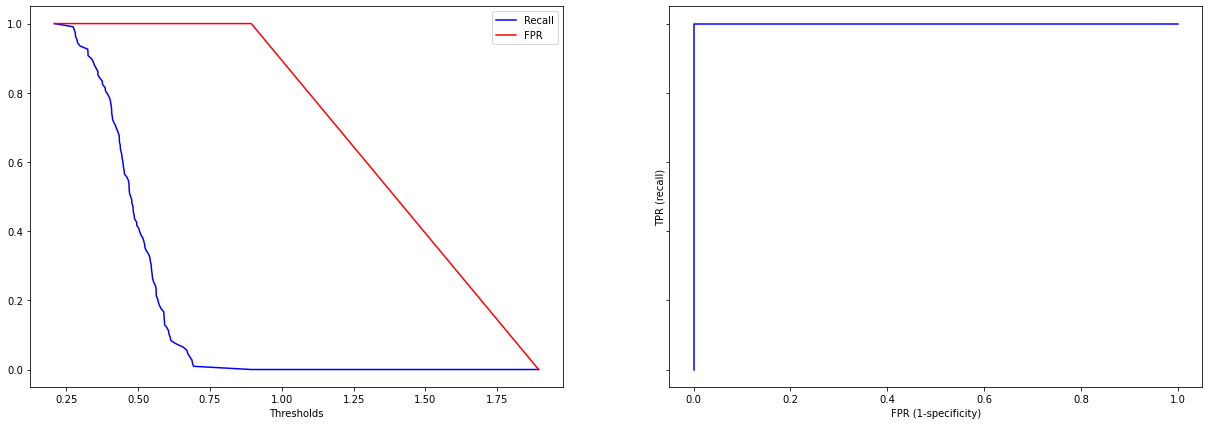

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589410  0.559297   0.595098     0.619495  0.576577  0.633796
Validation  0.580183  0.555129   0.583445     0.605505  0.567669  0.618968

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009076  0.006573   0.011233     0.018674  0.006349  0.011965
Validation  0.071572  0.104970   0.072018     0.061315  0.087518  0.091522

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.562369  0.529591   0.567155     0.595413   
Random Forest (100 estimators)  0.577896  0.540575   0.584689     0.615596   
XGBoost Classifier              0.532213  0.526864   0.535086     0.537615   
SVM                             0.589783  0.536939   0.598692     0.643119   
KNN                             0.571503  0.568724   0.574159     0.574312   
Logistic Regression             0.580183  0.555129   0.583445     0.605505   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.546133  0.593977  
Random Forest (100 estimators)  0.558372  0.614349  
XGBoost Classifier              0.530282  0.550963  
SVM                             0.564049  0.632007  
KNN                             0.569412  0.597296  
Logistic Regression             0.567669  0.618968

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                    0.5379971023745109-0.5867400263590987   
Random Forest (100 estimators)   0.5470946435021279-0.6086969027255121   
XGBoost Classifier               0.5085251400783698-0.5559003134007471   
SVM                                0.553920344961591-0.625644817788189   
KNN                              0.5556902222318049-0.5873159358679815   
Logistic Regression              0.5349170804069033-0.6254490542334553   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4773907397609648-0.5817919124492102   
Random Forest (100 estimators)  0.47192952318532916-0.6092214359472815   
XGBoost Classifier              0.49540229027040594-0.5583258164852237   
SVM                              0.4692060146440593-0.6046722172158241   
KNN                               0.5221005131154656-0.615347360112224   
Logistic Regression              0.4887405752700247-0.6215179735206342   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5435343916334143-0.5907753464941867   
Random Forest (100 estimators)  0.5558919780996777-0.6134854892753602   
XGBoost Classifier              0.5112810301328717-0.5588919112263987   
SVM                              0.565034535117762-0.6323503856716858   
KNN                             0.5592135418837405-0.5891049559214288   
Logistic Regression             0.5378965247985654-0.6289934792573073   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5691131498470948-0.6217125382262997   
Random Forest (100 estimators)  0.5774545276387305-0.6537381329117281   
XGBoost Classifier              0.5033202549996912-0.5719091027984738   
SVM                             0.6196773481385482-0.6665611839715435   
KNN                               0.5341866190413291-0.61443723416968   
Logistic Regression             0.5667257064608016-0.6442834678511251   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5094308072004442-0.5828345784846337   
Random Forest (100 estimators)  0.5126915132605875-0.6040526044821487   
XGBoost Classifier              0.5055885431401007-0.5549764303200223   
SVM                             0.5133444413010174-0.6147528143452522   
KNN                              0.543245049215149-0.5955787960375045   
Logistic Regression             0.5123174328219731-0.6230195677403481   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5637094818446011-0.6242437819608637  
Random Forest (100 estimators)  0.5714913383320885-0.6572073478819584  
XGBoost Classifier              0.5361338481821748-0.5657931399042274  
SVM                             0.5830211402403187-0.6809935202948367  
KNN                             0.5789480908654956-0.6156439621450409  
Logistic Regression              0.561083798755027-0.6768514837051272

In [86]:
#All vitals without normalization or standardization
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

<b>Rr</b>, <b>pulse</b> and <b>temperature</b> seem to be the most dominant features in the experiments. <b>Random Forest</b> seems to be the best performing model here.

Dummy Random
╠■■■■■■■■■╣


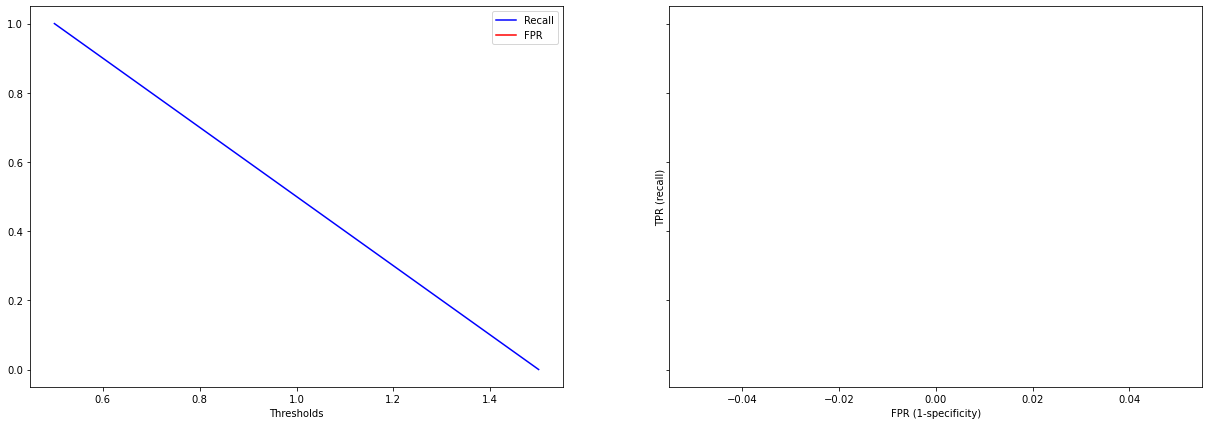

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


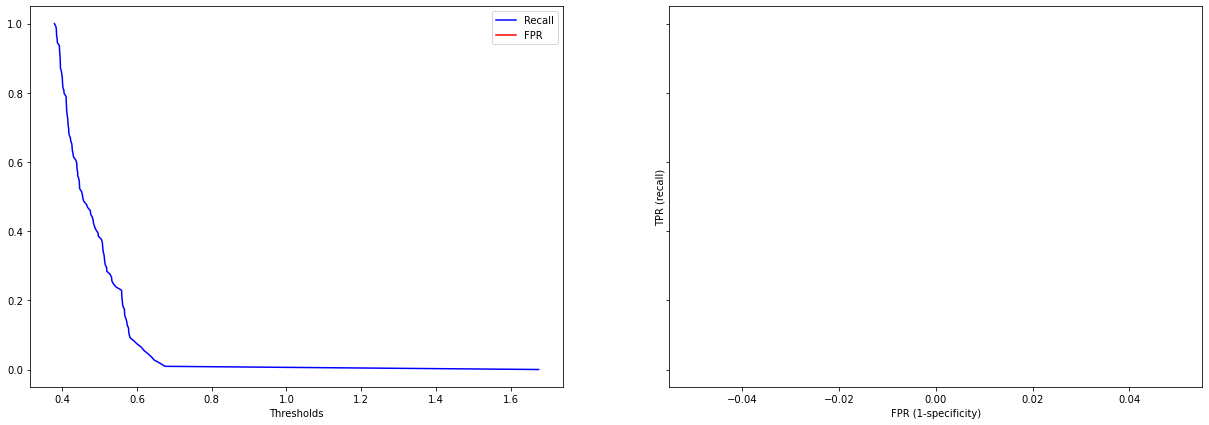

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.613764  0.569504   0.625461     0.657980  0.595138  0.664522
Validation  0.593888  0.547865   0.604119     0.640367  0.572657  0.630764

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006165  0.040240   0.013320     0.040564  0.017998  0.008868
Validation  0.051329  0.091315   0.048944     0.053460  0.068148  0.059906

XGBoost Classifier
╠■■■■■■■■■╣


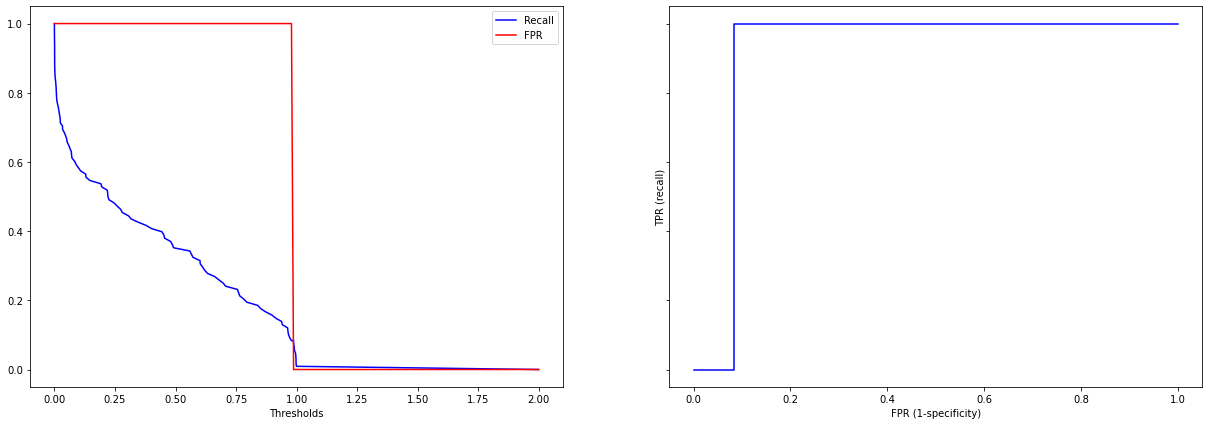

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997928  0.997169   0.998685     0.998687  0.997926  0.999984
Validation  0.537250  0.534137   0.539309     0.540367  0.536134  0.568330

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001103  0.001566   0.001432     0.001432  0.001104  0.000014
Validation  0.035579  0.054021   0.035159     0.044621  0.041220  0.041140

SVM
╠■■■■■■■■■╣


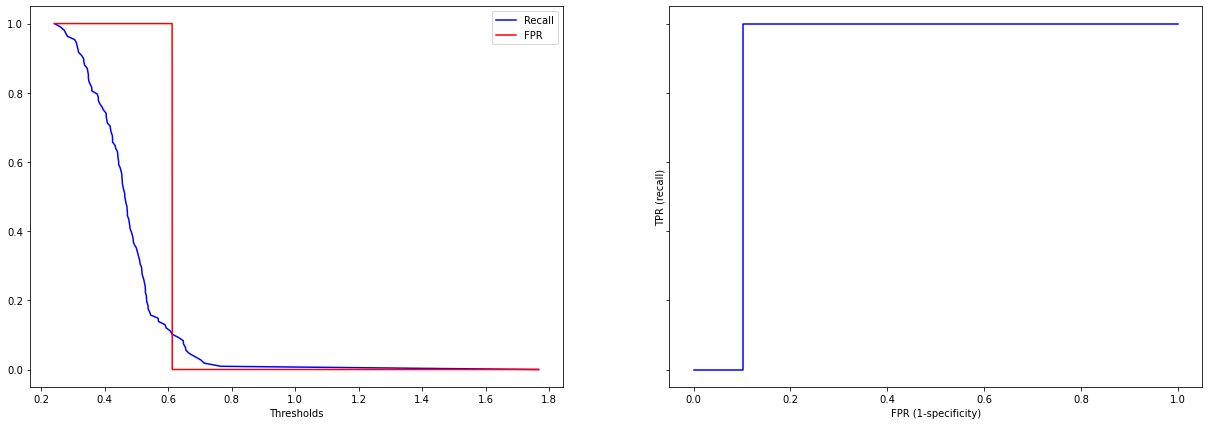

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.588904  0.535134   0.599280     0.642626  0.565362  0.635055
Validation  0.575167  0.539658   0.578282     0.611009  0.556345  0.622565

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011519  0.0167    0.01197     0.009169  0.014295  0.012565
Validation  0.054989  0.1099    0.04934     0.023767  0.080958  0.067039

KNN
╠■■■■■■■■■╣


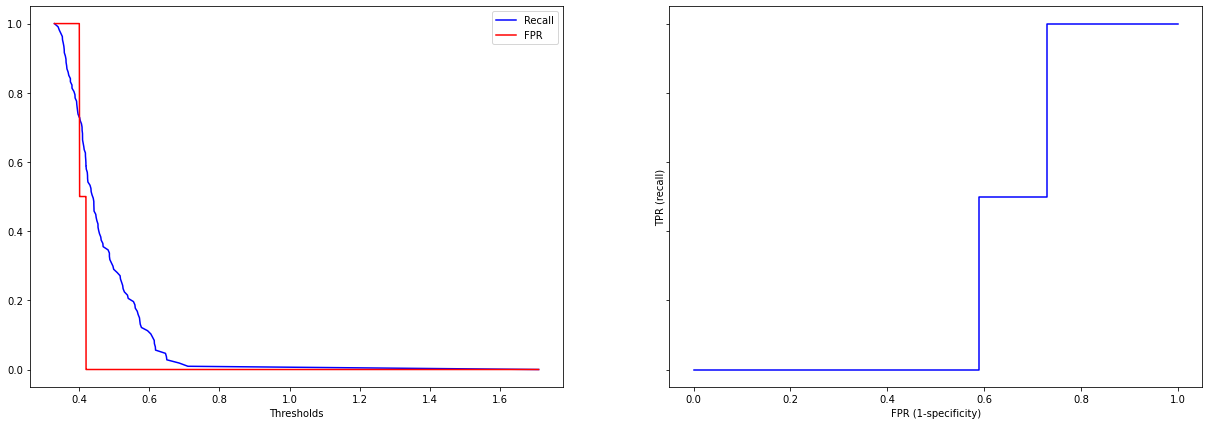

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998535  0.997169   0.999899     0.999899  0.998531  0.999994
Validation  0.582921  0.516847   0.592018     0.649541  0.548066  0.610868

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000806  0.001492   0.000321     0.000319  0.000808  0.000005
Validation  0.054616  0.122685   0.053071     0.046740  0.094031  0.071053

Logistic Regression
╠■■■■■■■■■╣


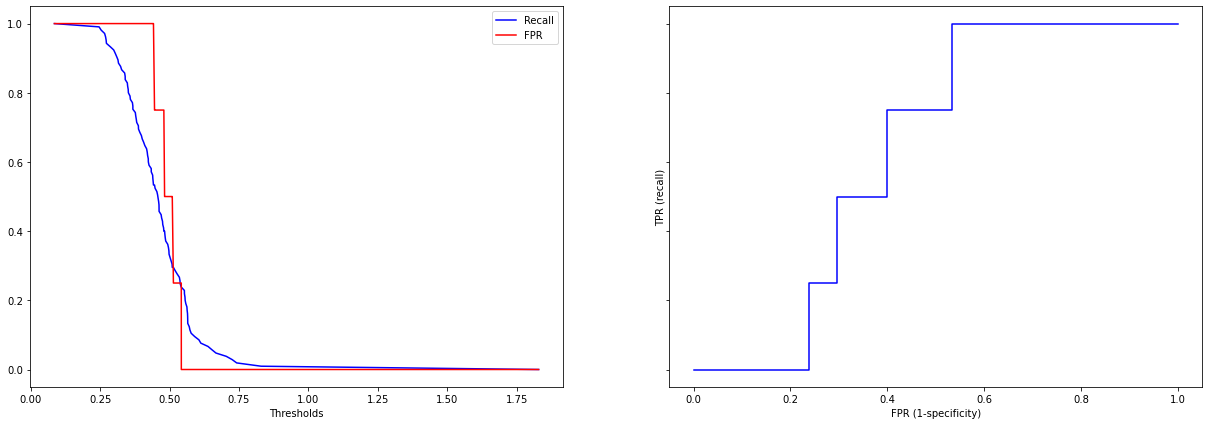

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.593654  0.562936   0.599608     0.624343  0.580675  0.639159
Validation  0.590706  0.564220   0.594729     0.617431  0.576858  0.628859

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008865  0.007916   0.010132     0.012494  0.008305  0.008007
Validation  0.065848  0.113491   0.064930     0.058991  0.085677  0.073485

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.593888  0.547865   0.604119     0.640367   
XGBoost Classifier              0.537250  0.534137   0.539309     0.540367   
SVM                             0.575167  0.539658   0.578282     0.611009   
KNN                             0.582921  0.516847   0.592018     0.649541   
Logistic Regression             0.590706  0.564220   0.594729     0.617431   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.572657  0.630764  
XGBoost Classifier              0.536134  0.568330  
SVM                             0.556345  0.622565  
KNN                             0.548066  0.610868  
Logistic Regression             0.576858  0.628859

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5614245794543699-0.6263513830105457   
XGBoost Classifier               0.5147480581430598-0.5597523817212106   
SVM                               0.540388664424763-0.6099443756657233   
KNN                              0.5483783274915465-0.6174630700200784   
Logistic Regression                 0.5490603761125-0.6323522165731855   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)  0.49011231722125786-0.6056174575910857   
XGBoost Classifier              0.49997066041149996-0.5683029008895841   
SVM                              0.4701509203746229-0.6091651763726663   
KNN                              0.43925429019852524-0.594440455422826   
Logistic Regression              0.4924423809971997-0.6359979859752775   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5731639920384366-0.6350732933590968   
XGBoost Classifier              0.5170721530131499-0.5615449266428989   
SVM                             0.5470762136547346-0.6094870136878249   
KNN                              0.5584530311259646-0.625582934132342   
Logistic Regression             0.5536631204367832-0.6357942418036913   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6065559022358771-0.6741780427182513   
XGBoost Classifier               0.512146123559488-0.5685878213946407   
SVM                             0.5959777299970097-0.6260406186268435   
KNN                             0.6199803156609306-0.6791022531464087   
Logistic Regression             0.5801223241590214-0.6547400611620795   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.529556330551514-0.6157577060406451   
XGBoost Classifier               0.5100644009355717-0.5622040090172995   
SVM                               0.5051424975755723-0.607547202103855   
KNN                             0.48859619670178445-0.6075366666362596   
Logistic Regression              0.5226714693747463-0.6310451570473048   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.5928761471060888-0.6686515785980529  
XGBoost Classifier              0.5423107030902699-0.5943493576637224  
SVM                             0.5801664175570397-0.6649642341328242  
KNN                             0.5659304568818984-0.6558056993951213  
Logistic Regression             0.5823828062433398-0.6753342515494694

In [87]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

<b>Pulse</b>, <b>temperature</b> and <b>rr</b> seem to be again the dominant features with standardized values. It improved the performance of <b>SVM</b>, <b>KNN</b> and <b>Logistic Regression<b>

Dummy Random
╠■■■■■■■■■╣


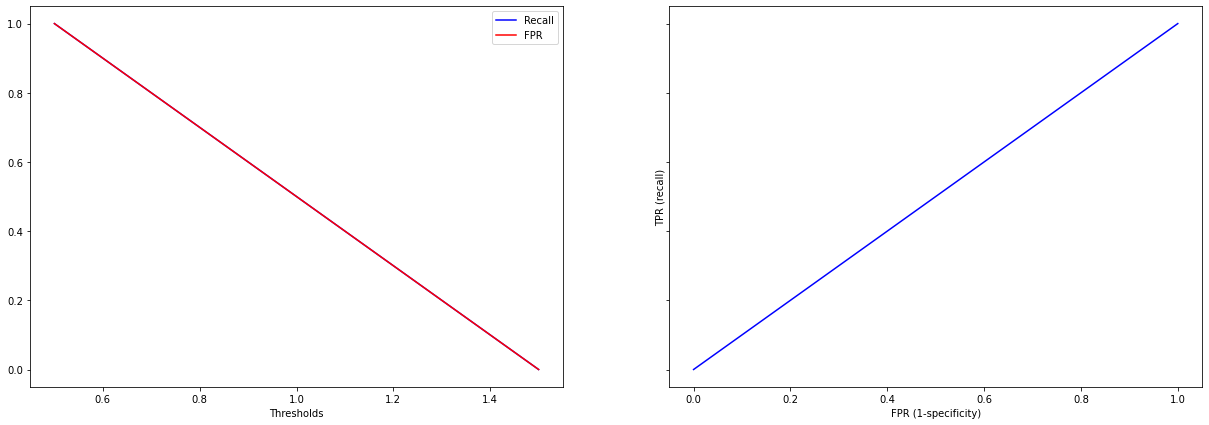

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


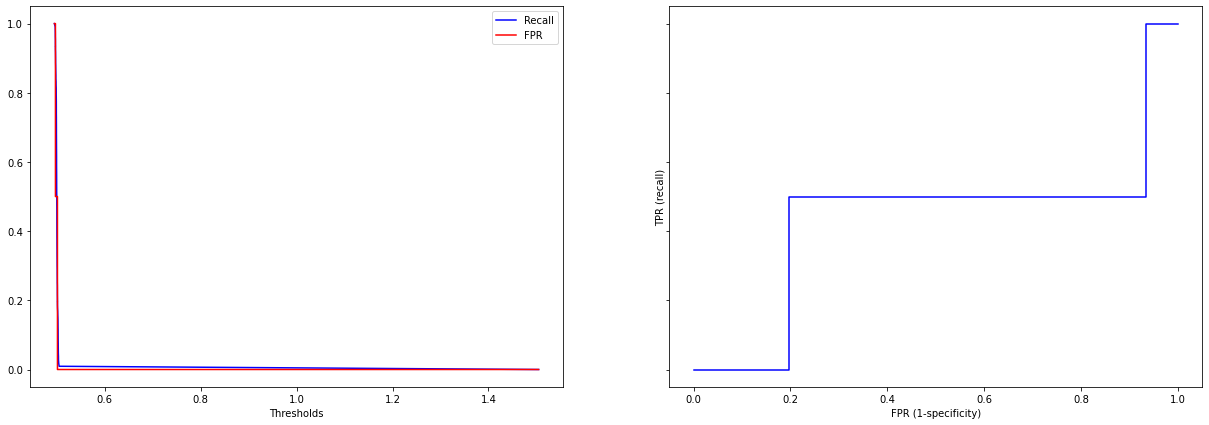

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.575362  0.537156   0.581475     0.613535  0.558393  0.606381
Validation  0.575175  0.526864   0.583940     0.623853  0.552077  0.607046

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006451  0.005157   0.008250     0.014334  0.004212  0.006398
Validation  0.048482  0.089252   0.051816     0.055553  0.066758  0.052842

Random Forest (100 estimators)
╠■■■■■■■■■╣


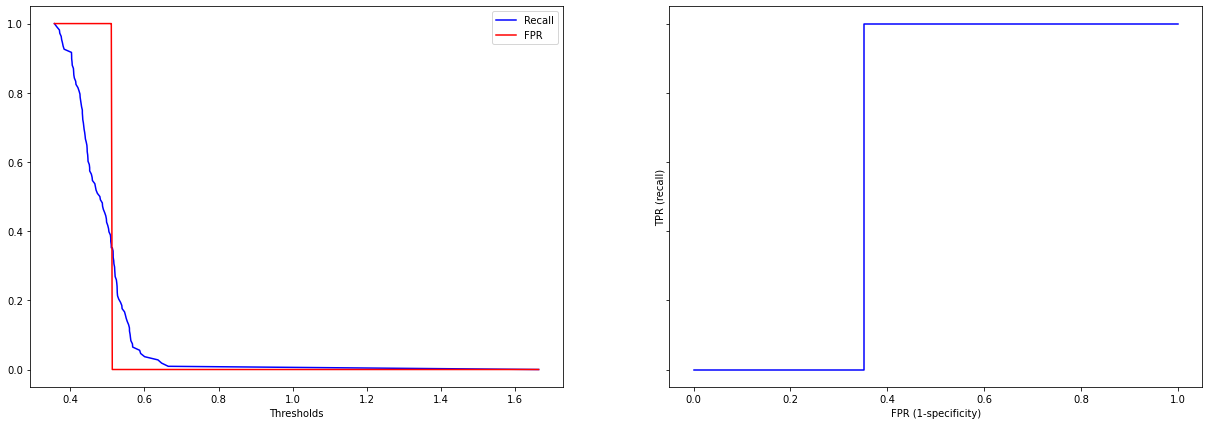

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.613713  0.581132   0.621786     0.646263  0.600303  0.665433
Validation  0.601661  0.559716   0.608806     0.644037  0.580040  0.648353

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008397  0.028761   0.011218     0.029026  0.014275  0.011731
Validation  0.055546  0.120586   0.045923     0.040524  0.083766  0.065075

XGBoost Classifier
╠■■■■■■■■■╣


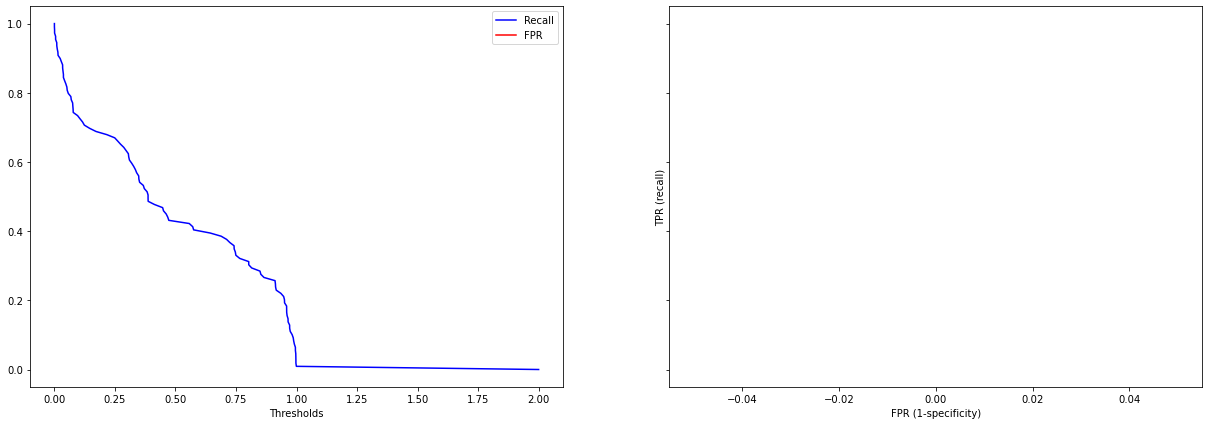

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997979  0.997473   0.998485     0.998485  0.997977  0.999987
Validation  0.543641  0.515021   0.548700     0.572477  0.530268  0.563392

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000630  0.001524   0.001366     0.001368  0.000631  0.000010
Validation  0.034681  0.057261   0.036800     0.056422  0.042499  0.043617

SVM
╠■■■■■■■■■╣


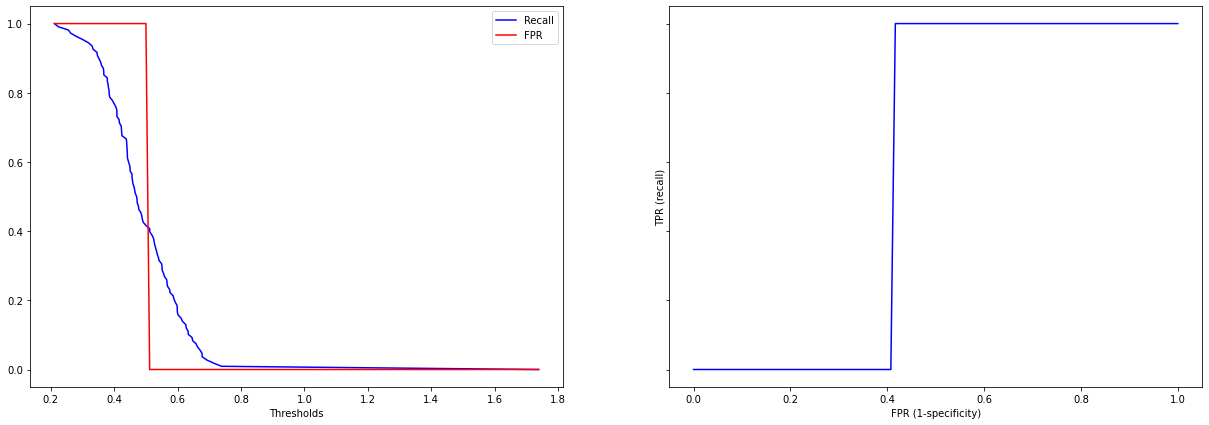

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589713  0.538671   0.599753     0.640707  0.567548  0.638648
Validation  0.576999  0.532377   0.581262     0.622018  0.554310  0.617098

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010102  0.008803   0.012075     0.014404  0.009536  0.010940
Validation  0.068711  0.114001   0.067486     0.033999  0.091941  0.080509

KNN
╠■■■■■■■■■╣


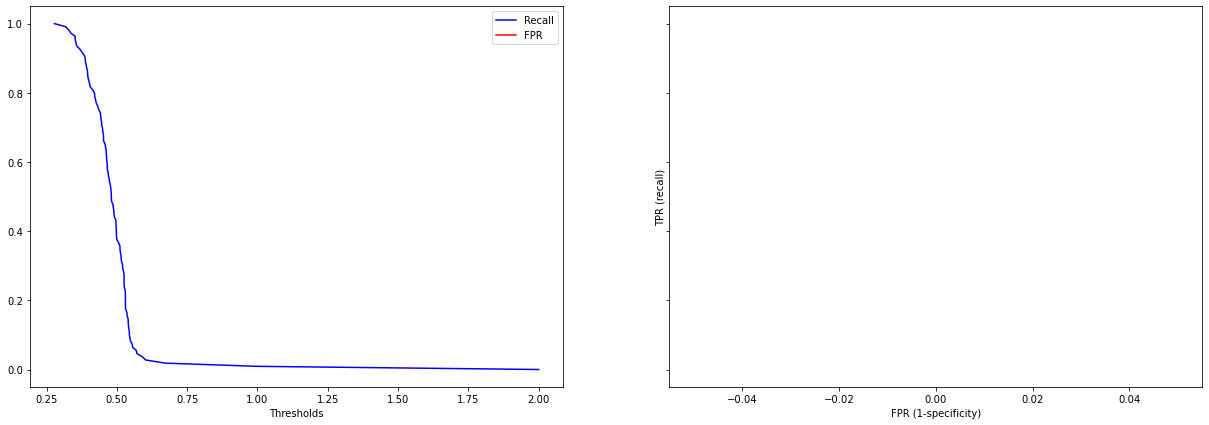

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998585  0.997270   0.999899     0.999899  0.998582  0.999995
Validation  0.573313  0.511326   0.585355     0.635780  0.541986  0.608490

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000818  0.001654   0.000320     0.000319  0.000820  0.000003
Validation  0.058630  0.109850   0.067709     0.078093  0.082011  0.060106

Logistic Regression
╠■■■■■■■■■╣


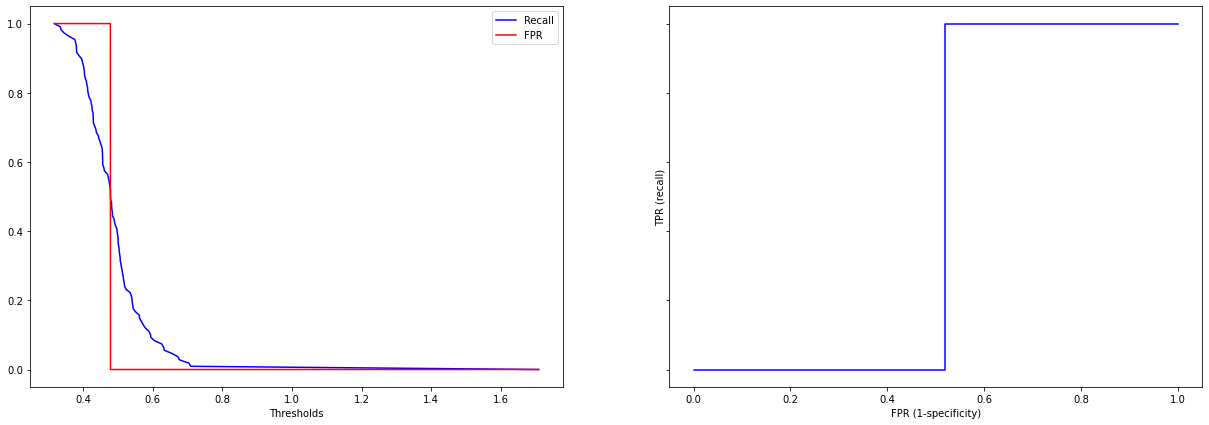

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591330  0.551512   0.599028     0.631111  0.574272  0.637656
Validation  0.575634  0.552385   0.578784     0.599083  0.564064  0.616544

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011406  0.011517   0.012592     0.013483  0.011572  0.011120
Validation  0.057898  0.093673   0.055557     0.047386  0.073826  0.076499

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.575175  0.526864   0.583940     0.623853   
Random Forest (100 estimators)  0.601661  0.559716   0.608806     0.644037   
XGBoost Classifier              0.543641  0.515021   0.548700     0.572477   
SVM                             0.576999  0.532377   0.581262     0.622018   
KNN                             0.573313  0.511326   0.585355     0.635780   
Logistic Regression             0.575634  0.552385   0.578784     0.599083   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.552077  0.607046  
Random Forest (100 estimators)  0.580040  0.648353  
XGBoost Classifier              0.530268  0.563392  
SVM                             0.554310  0.617098  
KNN                             0.541986  0.608490  
Logistic Regression             0.564064  0.616544

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                      0.5445123845928788-0.60583741223172   
Random Forest (100 estimators)    0.566530856201258-0.6367911663365494   
XGBoost Classifier               0.5217065993297373-0.5655750394788589   
SVM                              0.5335426128315308-0.6204559628460695   
KNN                              0.5362319586200263-0.6103936540480647   
Logistic Regression              0.5390159639842875-0.6122512640329718   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4704162624735321-0.5833118442820978   
Random Forest (100 estimators)  0.48345136453550236-0.6359814961817618   
XGBoost Classifier                0.478805777200734-0.5512359242171143   
SVM                              0.4602764085627292-0.6044775530719663   
KNN                             0.44185079737048694-0.5808014128046591   
Logistic Regression             0.49314127615907066-0.6116293660427642   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5511689481015488-0.6167119883107178   
Random Forest (100 estimators)  0.5797615779598531-0.6378498815635449   
XGBoost Classifier              0.5254252165478054-0.5719742309556058   
SVM                             0.5385799083084194-0.6239442672092138   
KNN                              0.542532384493358-0.6281777649730231   
Logistic Regression             0.5436473766309243-0.6139214923432293   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5887182712749968-0.6589881507433519   
Random Forest (100 estimators)  0.6184069396455573-0.6696664548498555   
XGBoost Classifier               0.5367927776249178-0.608161350815449   
SVM                             0.6005157237538264-0.6435209734938802   
KNN                             0.5863897804691807-0.6851698525583423   
Logistic Regression              0.5691131498470947-0.629051987767584   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5098560232880293-0.5942988037706128   
Random Forest (100 estimators)   0.5270611767680703-0.6330182828407084   
XGBoost Classifier               0.5033897020229918-0.5571471864729998   
SVM                               0.496161065803818-0.6124588506288151   
KNN                             0.49011715312597925-0.5938542441777835   
Logistic Regression              0.5173730686564548-0.6107559305293506   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5736256017329582-0.6404664168452148  
Random Forest (100 estimators)  0.6071953405879449-0.6895097117875055  
XGBoost Classifier              0.5358062835367358-0.5909778102417188  
SVM                             0.5661798539996745-0.6680165328976635  
KNN                              0.5704755227826828-0.646504146819662  
Logistic Regression             0.5681622570944208-0.6649261728663262

In [88]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

<b>Temperature</b>, <b>pulse</b> and <b>rr</b> are still the best features. <b>SVM</b> and <b>Logistic regression</b> improve significantly with standardized features.

Dummy Random
╠■■■■■■■■■╣


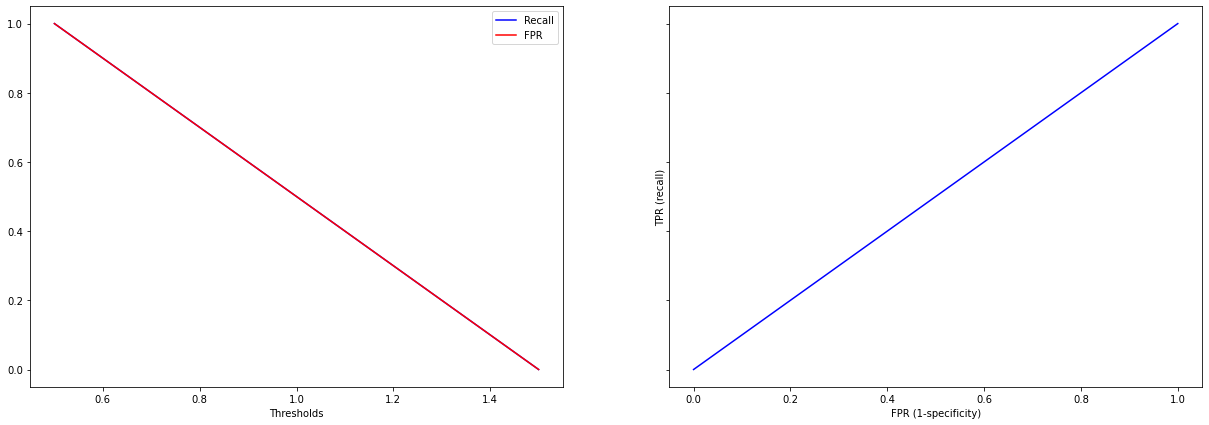

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


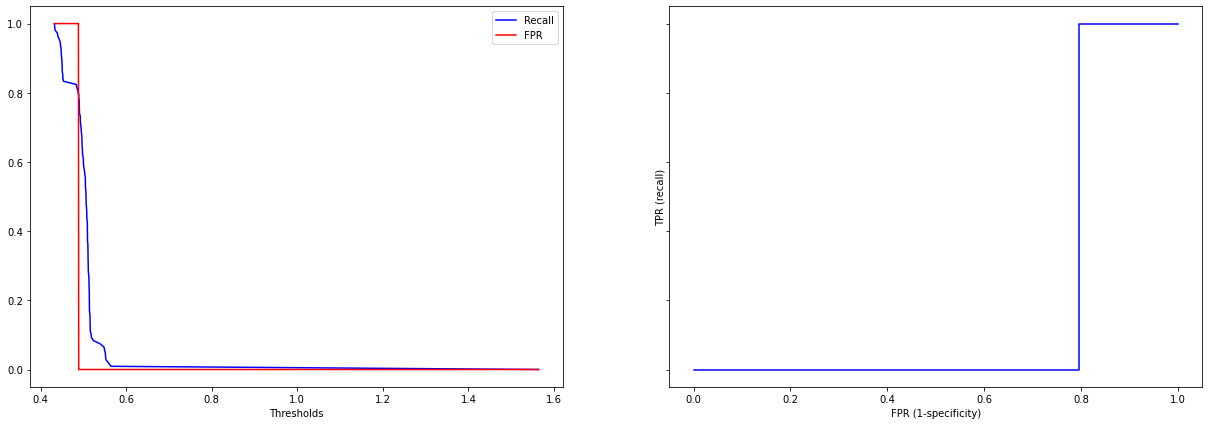

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.559800  0.521479   0.565923     0.598081  0.540794  0.586924
Validation  0.548647  0.499566   0.557890     0.598165  0.525291  0.566243

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007642  0.055919   0.013275     0.064062  0.025397  0.007539
Validation  0.042559  0.062936   0.046381     0.076855  0.048040  0.048355

Random Forest (100 estimators)
╠■■■■■■■■■╣


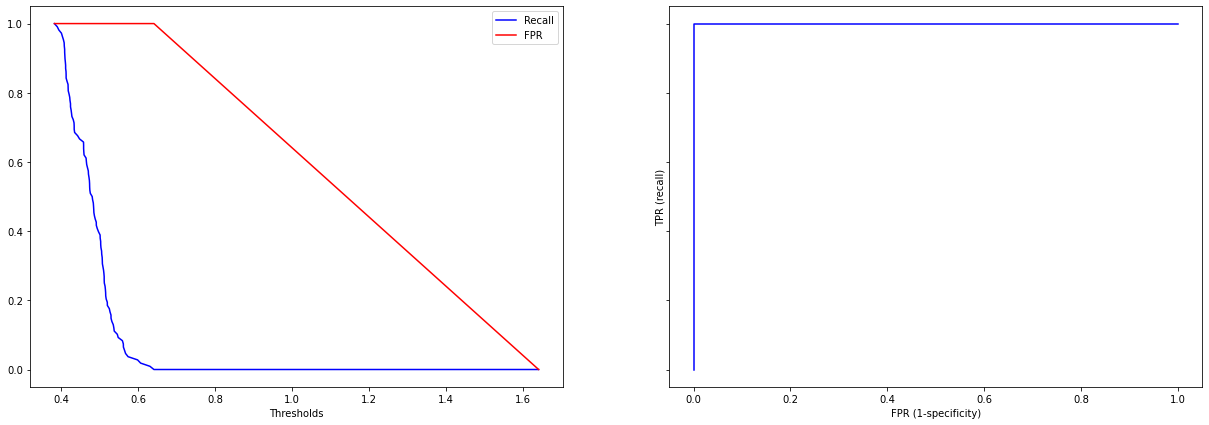

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.620737  0.594482   0.627648     0.646970  0.610185  0.672611
Validation  0.589797  0.558749   0.594955     0.621101  0.575478  0.636390

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008479  0.025895   0.012517     0.028985  0.012436  0.009539
Validation  0.062858  0.093449   0.062174     0.043475  0.077258  0.071490

XGBoost Classifier
╠■■■■■■■■■╣


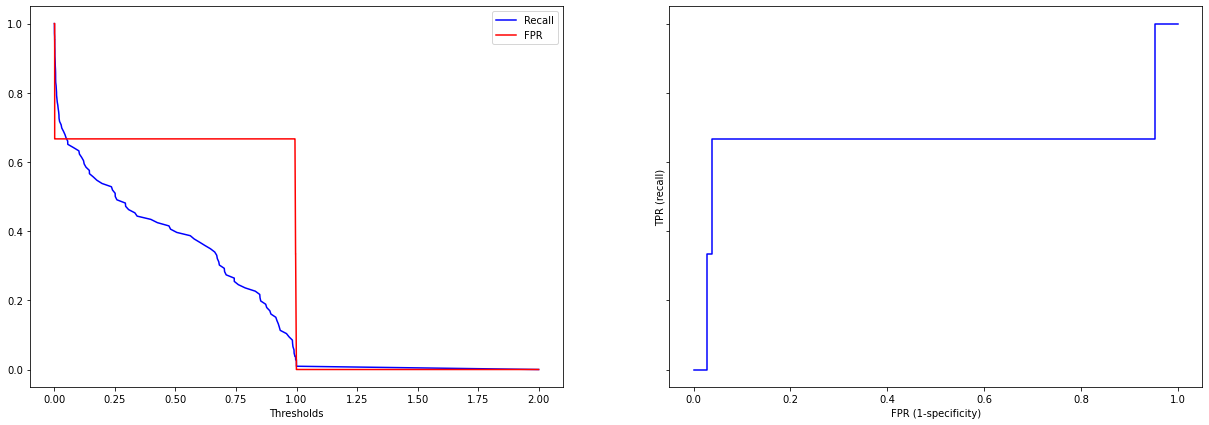

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999394  0.999494   0.999293     0.999293  0.999393  0.999999
Validation  0.564197  0.563311   0.566019     0.565138  0.564179  0.593008

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000522  0.000715   0.000831     0.000832  0.000522  0.000001
Validation  0.026421  0.047303   0.025393     0.031544  0.033726  0.028327

SVM
╠■■■■■■■■■╣


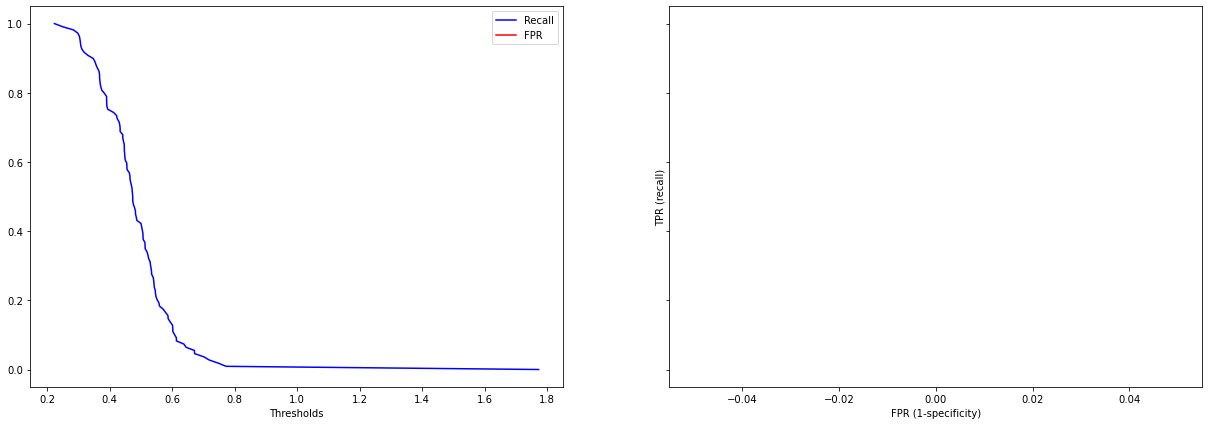

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.599363  0.550096   0.609964     0.648586  0.578454  0.647415
Validation  0.602101  0.550517   0.612446     0.654128  0.578268  0.642009

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012033  0.015071   0.013177     0.012638  0.013639  0.011560
Validation  0.055861  0.099609   0.050051     0.030900  0.075889  0.065055

KNN
╠■■■■■■■■■╣


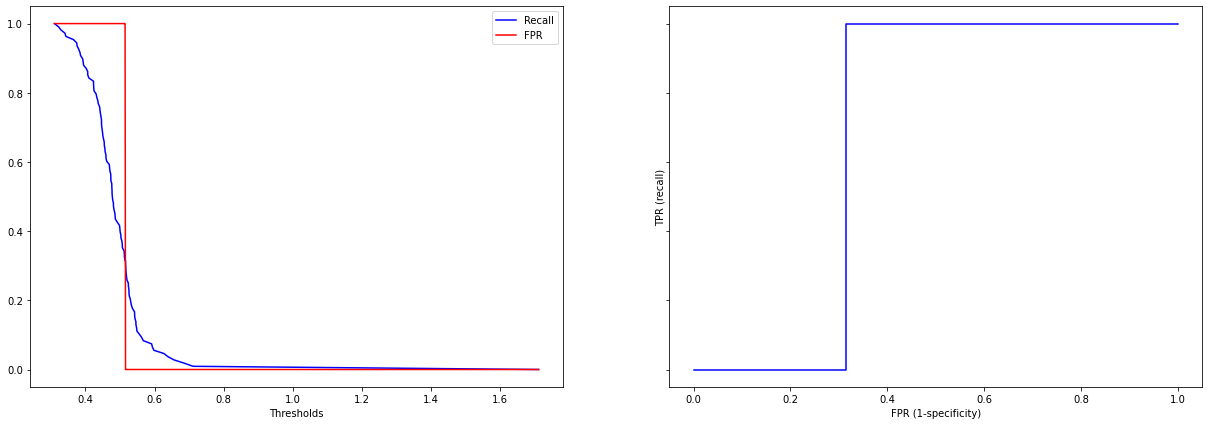

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999646  0.999292   1.000000     1.000000  0.999646  1.000000
Validation  0.586563  0.548641   0.594539     0.624771  0.568439  0.612093

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000341  0.000682   0.000000     0.000000  0.000341  6.113765e-07
Validation  0.032531  0.086509   0.029843     0.045861  0.055646  4.257614e-02

Logistic Regression
╠■■■■■■■■■╣


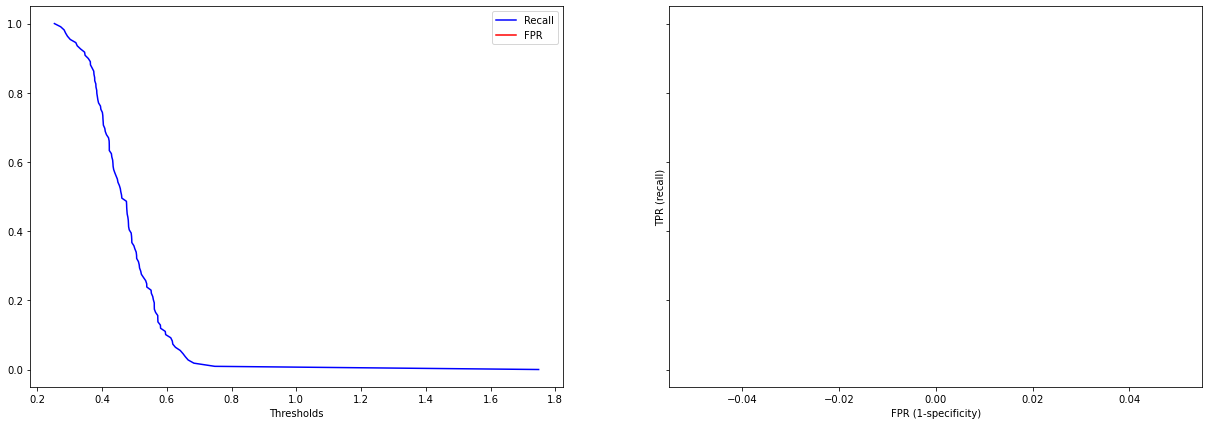

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.602243  0.569913   0.609160     0.634545  0.588833  0.649862
Validation  0.589309  0.559633   0.594512     0.619266  0.573462  0.638933

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008800  0.010711   0.010245     0.014323  0.008822  0.007982
Validation  0.044039  0.108542   0.034894     0.051035  0.070277  0.059249

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.548647  0.499566   0.557890     0.598165   
Random Forest (100 estimators)  0.589797  0.558749   0.594955     0.621101   
XGBoost Classifier              0.564197  0.563311   0.566019     0.565138   
SVM                             0.602101  0.550517   0.612446     0.654128   
KNN                             0.586563  0.548641   0.594539     0.624771   
Logistic Regression             0.589309  0.559633   0.594512     0.619266   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.525291  0.566243  
Random Forest (100 estimators)  0.575478  0.636390  
XGBoost Classifier              0.564179  0.593008  
SVM                             0.578268  0.642009  
KNN                             0.568439  0.612093  
Logistic Regression             0.573462  0.638933

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                    0.5217302275452008-0.5755635598956267   
Random Forest (100 estimators)   0.5500420912401325-0.6295523957943443   
XGBoost Classifier               0.5474869403013928-0.5809073456522748   
SVM                              0.5667709645221073-0.6374307865566073   
KNN                              0.5659888419969868-0.6071375456700571   
Logistic Regression              0.5614568034628971-0.6171616038095256   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.45976226524355857-0.5393703452651986   
Random Forest (100 estimators)   0.4996468563976014-0.6178510585315063   
XGBoost Classifier               0.5333938605266999-0.5932283246275953   
SVM                              0.4875189236713385-0.6135152714912969   
KNN                              0.4939276418280219-0.6033534257282748   
Logistic Regression             0.49098494207677423-0.6282811129690973   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.5285561959449744-0.587224131267562   
Random Forest (100 estimators)  0.5556321403065065-0.6342770301458827   
XGBoost Classifier              0.5499590393272498-0.5820794525109625   
SVM                             0.5807909961755934-0.6441013567081134   
KNN                             0.5756643190052921-0.6134129625541436   
Logistic Regression             0.5724429258094121-0.6165807184779943   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5495576355075095-0.6467726397218484   
Random Forest (100 estimators)  0.5936051782348758-0.6485966566275095   
XGBoost Classifier               0.5451871480974922-0.585088081260306   
SVM                             0.6345852656774673-0.6736716150564777   
KNN                             0.5957653683146682-0.6537759160890015   
Logistic Regression             0.5869889301481132-0.6515431799436301   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.49490803306305836-0.5556743339510417   
Random Forest (100 estimators)   0.5266158607595693-0.6243401580767366   
XGBoost Classifier               0.5428489814025937-0.5855099964559586   
SVM                              0.5302720133426027-0.6262642196137338   
KNN                              0.5332456999699776-0.6036332464640654   
Logistic Regression               0.5290150415261287-0.617908713333675   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5356600730416528-0.5968252549457371  
Random Forest (100 estimators)  0.5911761778420224-0.6816048093720932  
XGBoost Classifier               0.5750931740221719-0.610923766700602  
SVM                             0.6008642921555639-0.6831531229686606  
KNN                              0.5851651337821024-0.639020158242597  
Logistic Regression             0.6014609381709894-0.6764057856278951

In [89]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

For almost all models, the vitals had more importance than all of the epidemiological factors, of which <b>high_risk_exposure_occupation</b> seems to be the most influential again. For tree-based models (<b>Random forest</b> and <b>XGBoost</b>) however, <b>age</b> played a significant role. Since all of the important vitals follow a normal distribution, <b>standardization</b> will be used for them.

### Assesed Symptoms

In [26]:
a_symptoms.dropna(how="all", inplace=True)
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


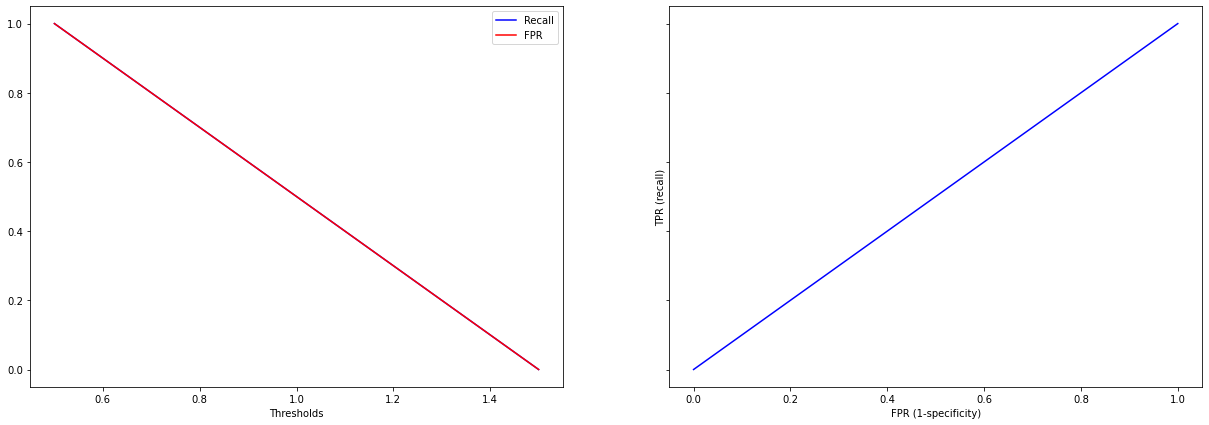

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000112     0.0        0.0          0.0  0.0      0.0
Validation  0.001011     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


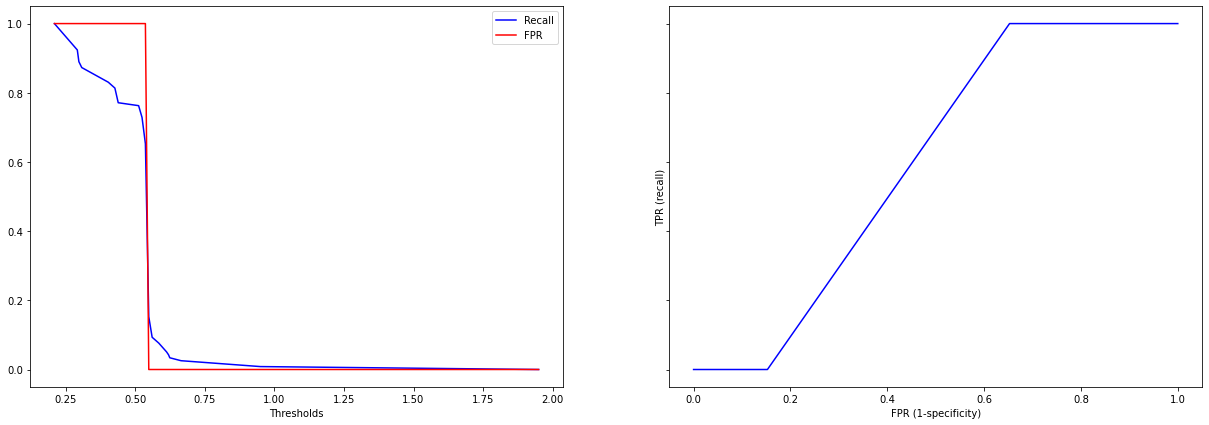

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.543186  0.849211   0.526773     0.237244  0.650199  0.550167
Validation  0.538784  0.848985   0.523844     0.227731  0.647744  0.537306

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005592  0.005489   0.003654     0.012810  0.003080  0.009654
Validation  0.034846  0.058836   0.020788     0.024564  0.032189  0.069419

Random Forest (100 estimators)
╠■■■■■■■■■╣


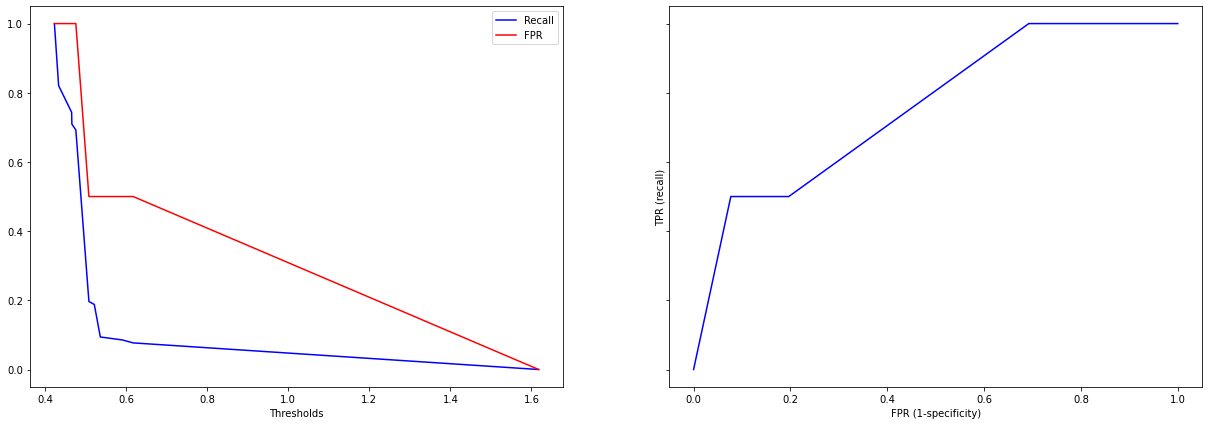

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.593565  0.400673   0.652367     0.786406  0.496320  0.615232
Validation  0.591268  0.399006   0.646891     0.784034  0.491852  0.605753

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006728  0.012439   0.012113     0.012284  0.010580  0.008113
Validation  0.039196  0.071600   0.051784     0.031703  0.066117  0.058150

XGBoost Classifier
╠■■■■■■■■■╣


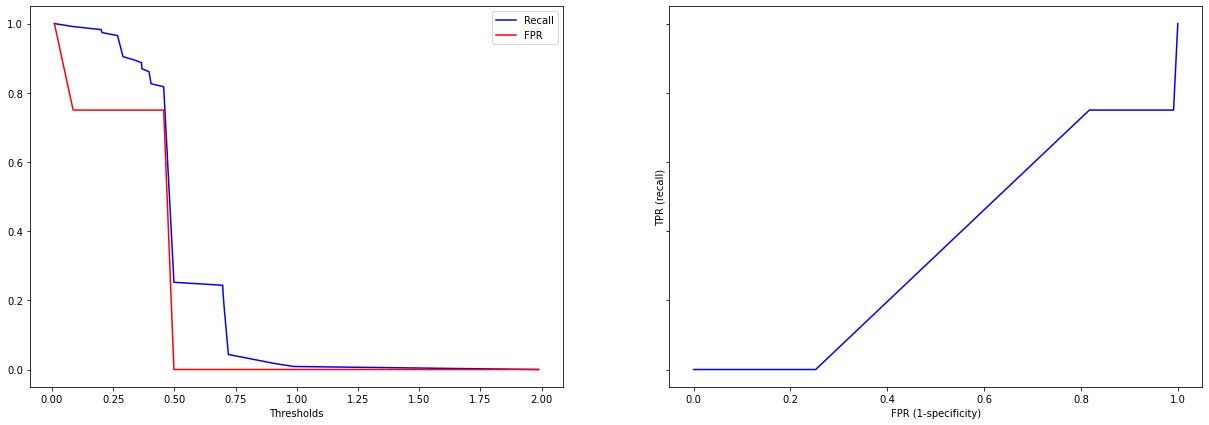

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.605299  0.405235   0.675445     0.805307  0.506461  0.642597
Validation  0.591721  0.397402   0.648206     0.786555  0.491587  0.603840

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002949  0.011642   0.002821     0.006749  0.008933  0.006392
Validation  0.043398  0.067984   0.063305     0.034352  0.069270  0.047353

SVM
╠■■■■■■■■■╣


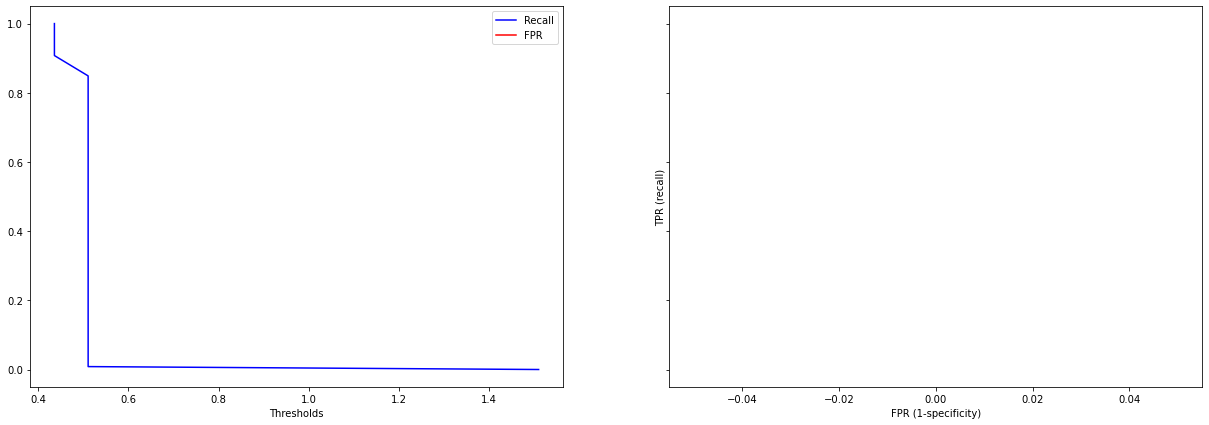

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.532801  0.770364   0.490123     0.295251  0.583963  0.527790
Validation  0.517426  0.758193   0.461258     0.276471  0.573286  0.524492

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012873  0.271078   0.101994     0.247656  0.204586  0.013948
Validation  0.021384  0.269730   0.162505     0.255177  0.202237  0.038561

KNN
╠■■■■■■■■■╣


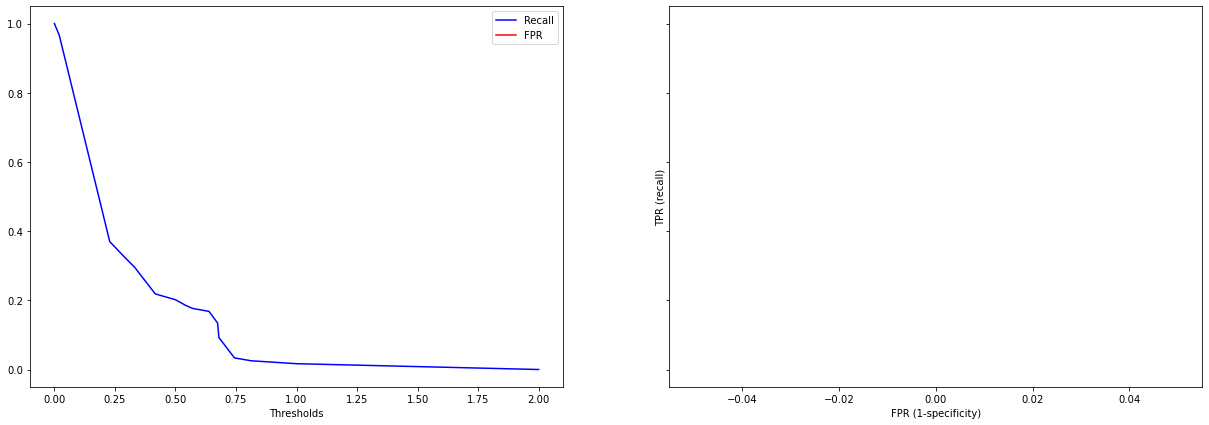

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.600550  0.381586   0.678959     0.819460  0.487181  0.597688
Validation  0.569454  0.362101   0.619261     0.777311  0.454530  0.557077

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.014021  0.043997   0.016180     0.024107  0.037980  0.009715
Validation  0.034411  0.067762   0.051826     0.044686  0.062933  0.034931

Logistic Regression
╠■■■■■■■■■╣


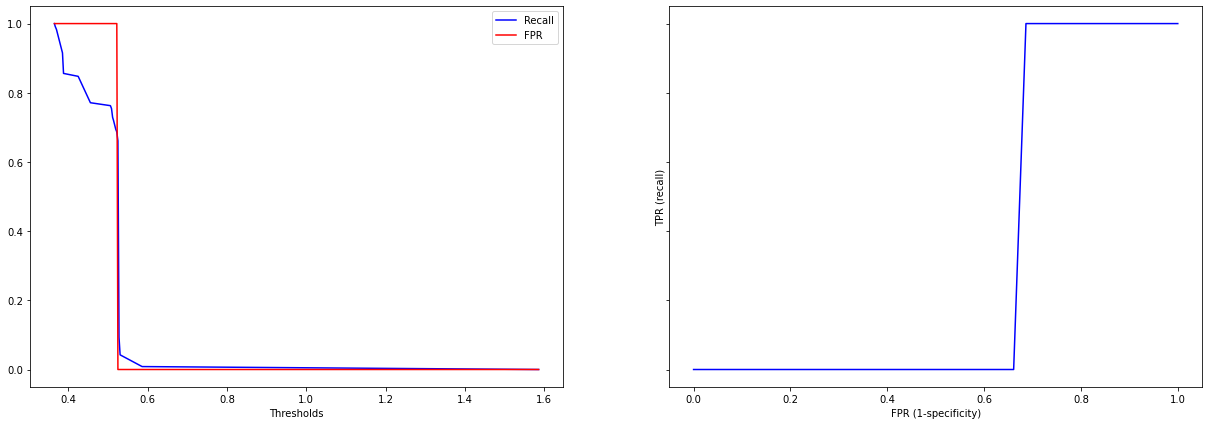

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.544722  0.834682   0.528297     0.254842  0.646984  0.543955
Validation  0.539236  0.829783   0.525371     0.247899  0.643114  0.518355

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005688  0.016955   0.003897     0.020042  0.005616  0.008303
Validation  0.013941  0.032473   0.009272     0.042895  0.011650  0.039372

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.538784  0.848985   0.523844     0.227731   
Random Forest (100 estimators)  0.591268  0.399006   0.646891     0.784034   
XGBoost Classifier              0.591721  0.397402   0.648206     0.786555   
SVM                             0.517426  0.758193   0.461258     0.276471   
KNN                             0.569454  0.362101   0.619261     0.777311   
Logistic Regression             0.539236  0.829783   0.525371     0.247899   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.647744  0.537306  
Random Forest (100 estimators)  0.491852  0.605753  
XGBoost Classifier              0.491587  0.603840  
SVM                             0.573286  0.524492  
KNN                             0.454530  0.557077  
Logistic Regression             0.643114  0.518355

Accuracy  \
Dummy Random                    0.49873325304114985-0.5000115168333272   
MultinomialNB                    0.5167449838439637-0.5608226122321236   
Random Forest (100 estimators)    0.566478398253819-0.6160573775627839   
XGBoost Classifier               0.5642739185477863-0.6191689983679338   
SVM                               0.5039008503391074-0.530950244910708   
KNN                              0.5476905706074594-0.5912180472329821   
Logistic Regression              0.5304187525983315-0.5480524685261015   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.8117737164825669-0.8861954711925031   
Random Forest (100 estimators)  0.3537216071376369-0.44428959734415574   
XGBoost Classifier               0.354405271594104-0.44039864997452344   
SVM                              0.5876007478883019-0.9287858067335466   
KNN                             0.3192442629957834-0.40495741767648546   
Logistic Regression              0.8092452039708109-0.8503206223597213   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5106965465417233-0.5369909220071831   
Random Forest (100 estimators)  0.6141399980064166-0.6796419760489505   
XGBoost Classifier              0.6081690239182582-0.6882438249248575   
SVM                              0.3584813008012582-0.564035599776271   
KNN                             0.5864837479205627-0.6520389251512255   
Logistic Regression             0.5195064846437805-0.5312346532585857   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                   0.21219560266233944-0.24326658221161013   
Random Forest (100 estimators)    0.7639825992513465-0.8040846276394098   
XGBoost Classifier                0.7648283255690025-0.8082809181284765   
SVM                             0.11508228884790364-0.43785888762268477   
KNN                               0.7490487434047519-0.8055731053347439   
Logistic Regression             0.22077019604974069-0.27502812327799053   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.627386008076043-0.6681016309562826   
Random Forest (100 estimators)   0.4500357450591783-0.5336676367778124   
XGBoost Classifier               0.4477764969257452-0.5353974928310898   
SVM                              0.4453801465109089-0.7011922636388759   
KNN                             0.41472797758029156-0.4943329091819756   
Logistic Regression               0.6357464123215348-0.650482217176442   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.493401334304476-0.5812098042686002  
Random Forest (100 estimators)   0.568975651535417-0.6425297741642748  
XGBoost Classifier              0.5738913645086962-0.6337888840613203  
SVM                             0.5001036497070486-0.5488797671891217  
KNN                             0.5349851431729945-0.5791695775388196  
Logistic Regression             0.4934532853485402-0.5432557512072584

In [91]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

The most important features here seem to be <b>wheezes</b>, <b>ctab</b> and <b>labored respiration</b>

Dummy Random
╠■■■■■■■■■╣


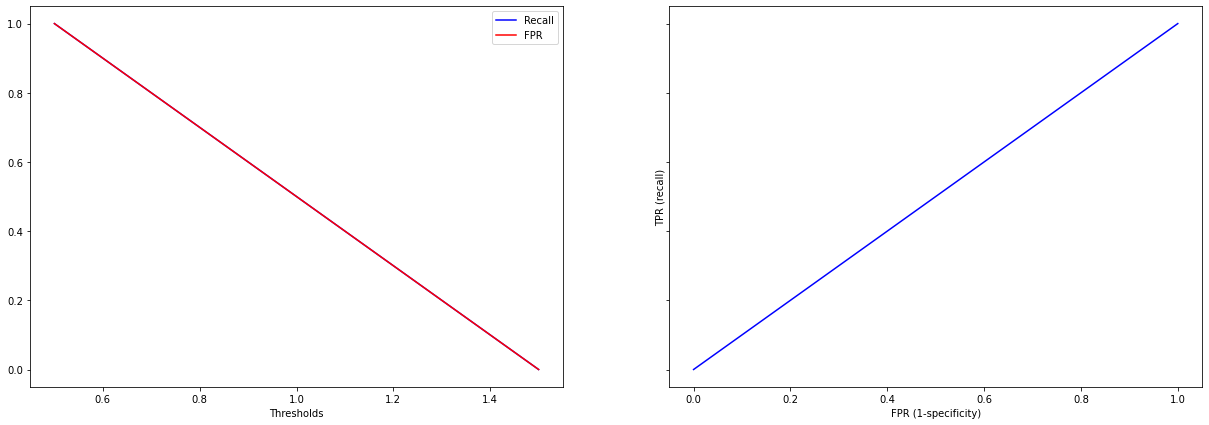

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000112     0.0        0.0          0.0  0.0      0.0
Validation  0.001011     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


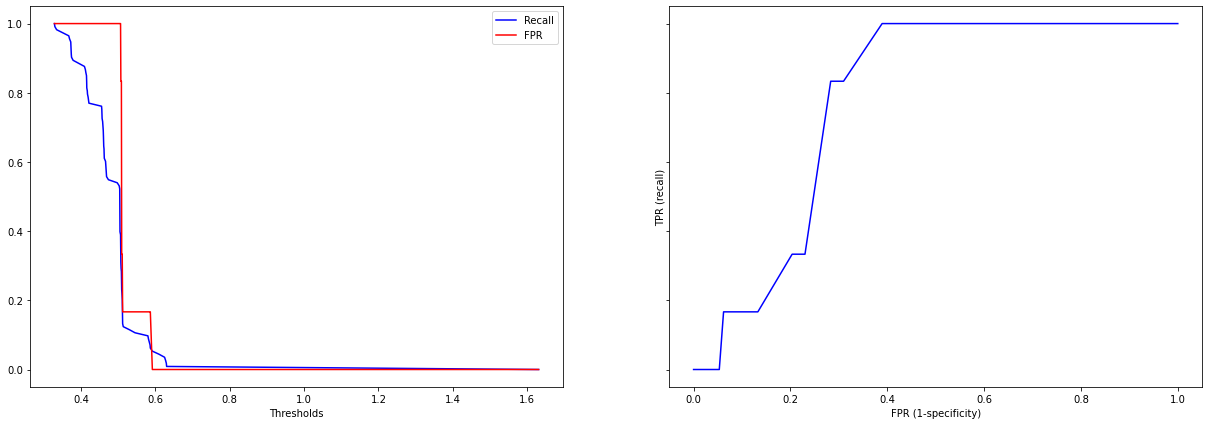

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.546121  0.722470   0.533533     0.369832  0.611995  0.561448
Validation  0.530354  0.717213   0.519315     0.342857  0.599515  0.551221

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.014326  0.088384   0.008733     0.065557  0.037321  0.014729
Validation  0.047226  0.137935   0.035232     0.075245  0.072382  0.067160

Random Forest (100 estimators)
╠■■■■■■■■■╣


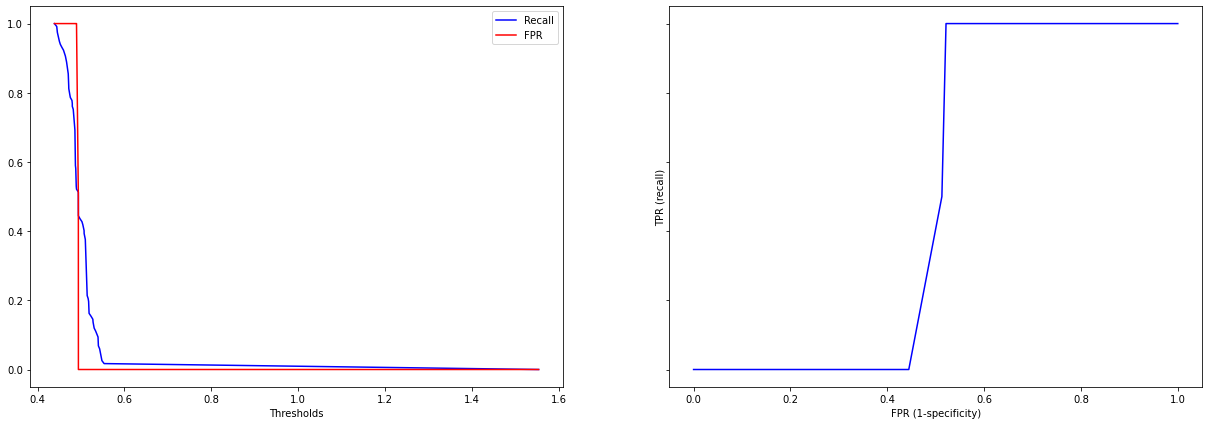

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.595754  0.585269   0.598823     0.606238  0.590665  0.635047
Validation  0.573645  0.555686   0.578779     0.591597  0.564619  0.602621

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008035  0.043772   0.014969     0.047285  0.020686  0.008808
Validation  0.038453  0.070527   0.043865     0.071656  0.047773  0.040048

XGBoost Classifier
╠■■■■■■■■■╣


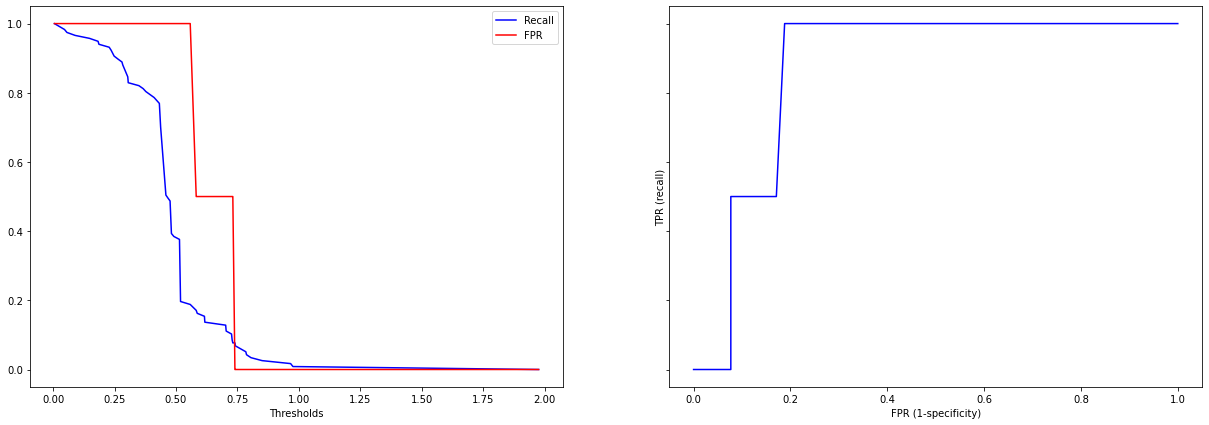

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.645854  0.562909   0.678744     0.728771  0.611451  0.720193
Validation  0.554355  0.445980   0.574146     0.663025  0.497333  0.585764

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005995  0.075394   0.027071     0.067972  0.033524  0.008078
Validation  0.031167  0.081429   0.044622     0.094531  0.052035  0.036052

SVM
╠■■■■■■■■■╣


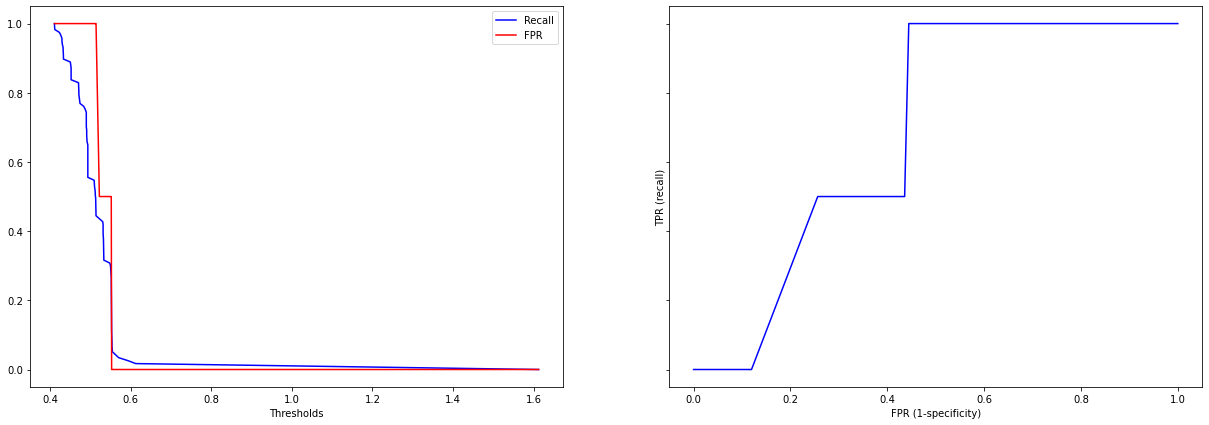

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.552172  0.723659   0.539209     0.380726  0.61651  0.575202
Validation  0.545964  0.715931   0.533537     0.375630  0.60936  0.561321

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007921  0.070495   0.007133     0.072614  0.022960  0.007479
Validation  0.044851  0.108114   0.031962     0.078636  0.057477  0.045930

KNN
╠■■■■■■■■■╣


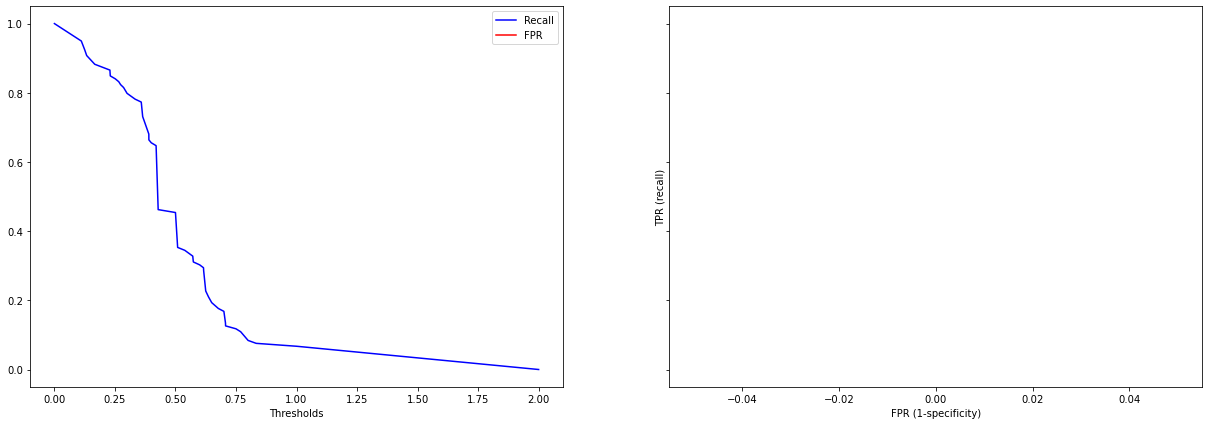

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.641291  0.437182   0.739142     0.845345  0.549141  0.677060
Validation  0.556426  0.347801   0.597303     0.765546  0.438769  0.565168

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004262  0.014365   0.014054     0.014487  0.009536  0.009626
Validation  0.047840  0.060083   0.081773     0.051414  0.067500  0.056373

Logistic Regression
╠■■■■■■■■■╣


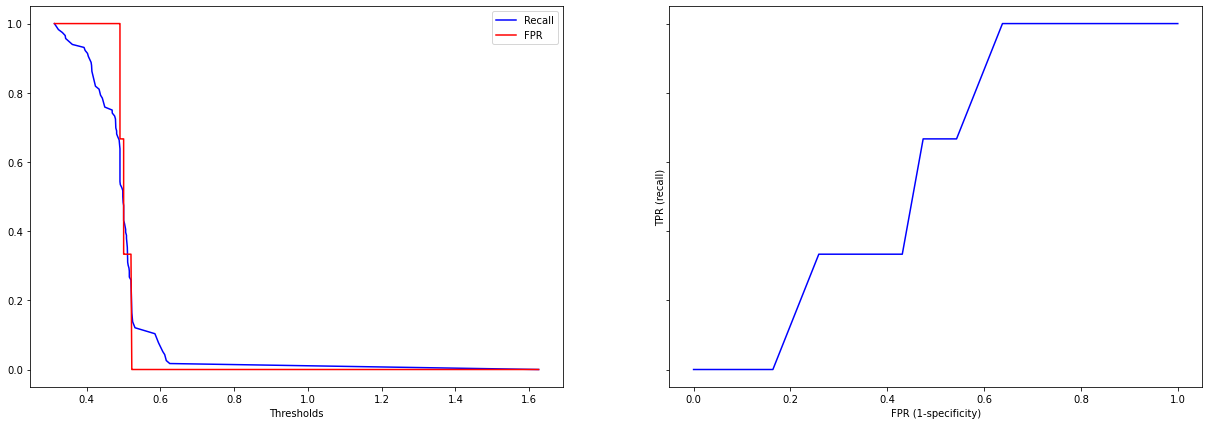

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.565255  0.717888   0.550238     0.412663  0.622012  0.587438
Validation  0.550976  0.696492   0.539563     0.405042  0.606730  0.569105

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007911  0.055215   0.007619     0.054453  0.019751  0.006262
Validation  0.038058  0.082810   0.029252     0.061980  0.044853  0.042278

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.530354  0.717213   0.519315     0.342857   
Random Forest (100 estimators)  0.573645  0.555686   0.578779     0.591597   
XGBoost Classifier              0.554355  0.445980   0.574146     0.663025   
SVM                             0.545964  0.715931   0.533537     0.375630   
KNN                             0.556426  0.347801   0.597303     0.765546   
Logistic Regression             0.550976  0.696492   0.539563     0.405042   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.599515  0.551221  
Random Forest (100 estimators)  0.564619  0.602621  
XGBoost Classifier              0.497333  0.585764  
SVM                             0.609360  0.561321  
KNN                             0.438769  0.565168  
Logistic Regression             0.606730  0.569105

Accuracy  \
Dummy Random                    0.49873325304114985-0.5000115168333272   
MultinomialNB                    0.5004856086936539-0.5602225239317812   
Random Forest (100 estimators)   0.5493258770755632-0.5979650058047855   
XGBoost Classifier               0.5346430345891376-0.5740662231725443   
SVM                              0.5175971431202528-0.5743300043077559   
KNN                              0.5261690066171811-0.5866821589536497   
Logistic Regression              0.5269058842351915-0.5750455239431425   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.6299754306175592-0.8044503396905641   
Random Forest (100 estimators)   0.5110809499113514-0.6002915991082566   
XGBoost Classifier               0.3944802388902084-0.4974805454235171   
SVM                              0.6475543411389738-0.7843084039590654   
KNN                             0.30980152313403286-0.3858007177623256   
Logistic Regression              0.6441180826094587-0.7488651106678524   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4970319923144799-0.5415972611753015   
Random Forest (100 estimators)   0.5510355953831128-0.606521551566853   
XGBoost Classifier              0.5459239768209284-0.6023672397642276   
SVM                              0.513322026494255-0.5537512776425978   
KNN                             0.5455853421730401-0.6490210532462737   
Logistic Regression             0.5210627377137889-0.5580642170500683   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                    0.29526776340258754-0.3904465223116982   
Random Forest (100 estimators)    0.5462773144735984-0.6369159628373258   
XGBoost Classifier                 0.6032385109980481-0.722811909170019   
SVM                             0.32589636051548193-0.42536414368619874   
KNN                               0.7330290826645793-0.7980633543102105   
Logistic Regression               0.3658423402027208-0.4442416934107247   

                                                                     F1  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                     0.5537365024073885-0.6452927700328152   
Random Forest (100 estimators)    0.5344041292305376-0.5948330605421012   
XGBoost Classifier               0.46442285150282636-0.5302423471347224   
SVM                               0.5730081091719018-0.6457112885366395   
KNN                             0.39607797037098746-0.48145959487333967   
Logistic Regression               0.5783628251529787-0.6350974715203546   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5087450427321974-0.5936967575173141  
Random Forest (100 estimators)  0.5772928842578087-0.6279497422045408  
XGBoost Classifier              0.5629626438274482-0.6085646729816283  
SVM                             0.5322727567913013-0.5903699473491786  
KNN                             0.5295142104273746-0.6008212767086564  
Logistic Regression             0.5423664215230878-0.5958443922141715

In [92]:
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

Adding the epidemiological factors doesn't seem to make much difference in performance metrics. However, <b>days_since_symptom_onset</b> appears to become more important after adding the factors.

### Reported symptoms

In [93]:
r_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough           51684 non-null  object 
 1   cough_severity  51684 non-null  float64
 2   fever           48445 non-null  object 
 3   sob             51602 non-null  object 
 4   sob_severity    51602 non-null  float64
 5   diarrhea        51619 non-null  object 
 6   fatigue         51630 non-null  object 
 7   headache        51623 non-null  object 
 8   loss_of_smell   51616 non-null  object 
 9   loss_of_taste   51616 non-null  object 
 10  runny_nose      51619 non-null  object 
 11  muscle_sore     51624 non-null  object 
 12  sore_throat     51623 non-null  object 
dtypes: float64(2), object(11)
memory usage: 7.5+ MB


In [25]:
#All datasets that contain reported symptoms
r_symptoms.dropna(how="all", inplace=True)
ra_symptoms = pd.merge(r_symptoms, a_symptoms, left_index=True, right_index=True)
r_symptoms_ex = pd.merge(r_symptoms, e_factors, left_index=True, right_index=True)
r_symptoms_vitals = pd.merge(r_symptoms, vitals, left_index=True, right_index=True)
r_symptoms_svitals = pd.merge(r_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
ra_symptoms_nvitals = pd.merge(ra_symptoms, n_vitals, left_index=True, right_index=True)
ra_symptoms_svitals = pd.merge(ra_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals_ex = pd.merge(ra_symptoms_vitals, e_factors, left_index=True, right_index=True)
ra_symptoms_nvitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)
ra_symptoms_svitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


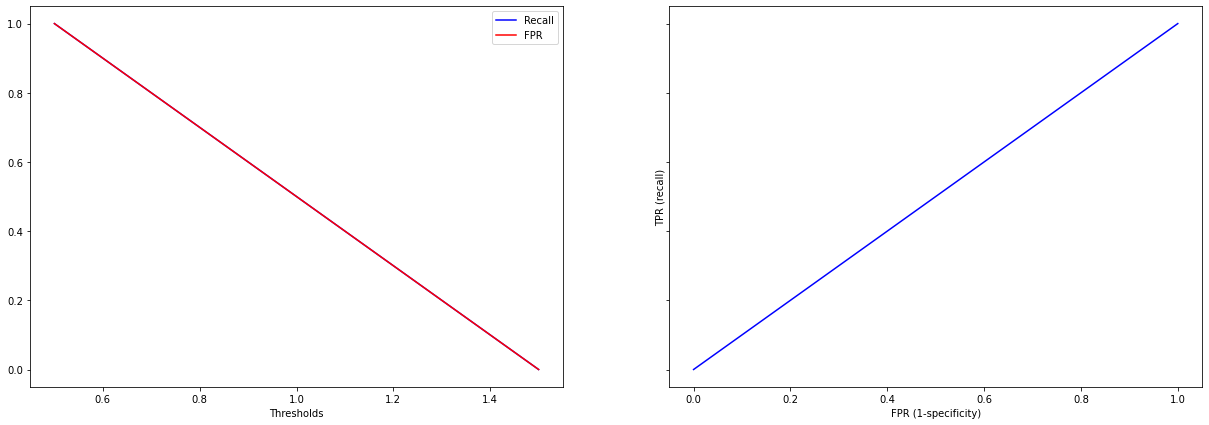

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


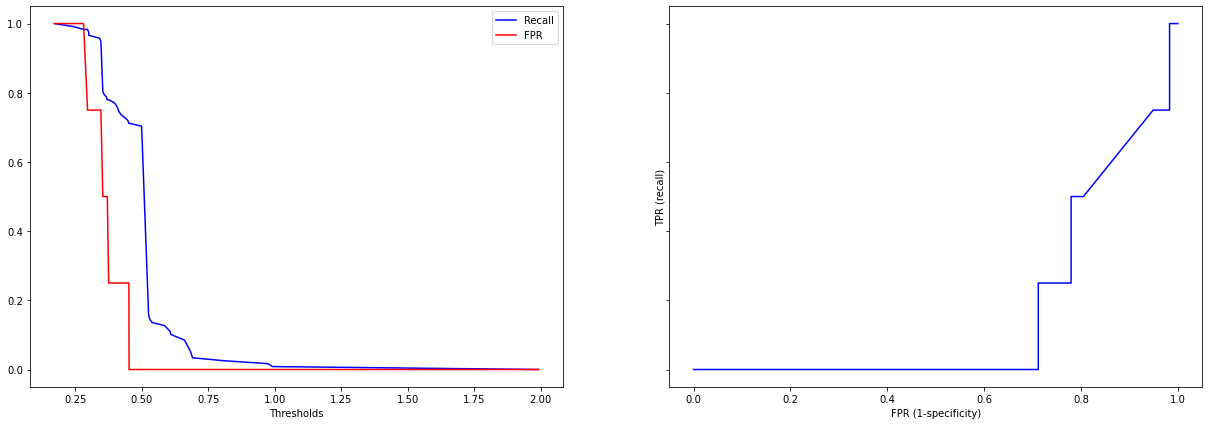

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.630512  0.361975   0.781957     0.899000  0.494537  0.611317
Validation  0.632663  0.364068   0.782529     0.901639  0.493149  0.622458

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008170  0.020583   0.011737     0.009065  0.019620  0.012196
Validation  0.043256  0.089122   0.045731     0.015456  0.085901  0.045848

Random Forest (100 estimators)
╠■■■■■■■■■╣


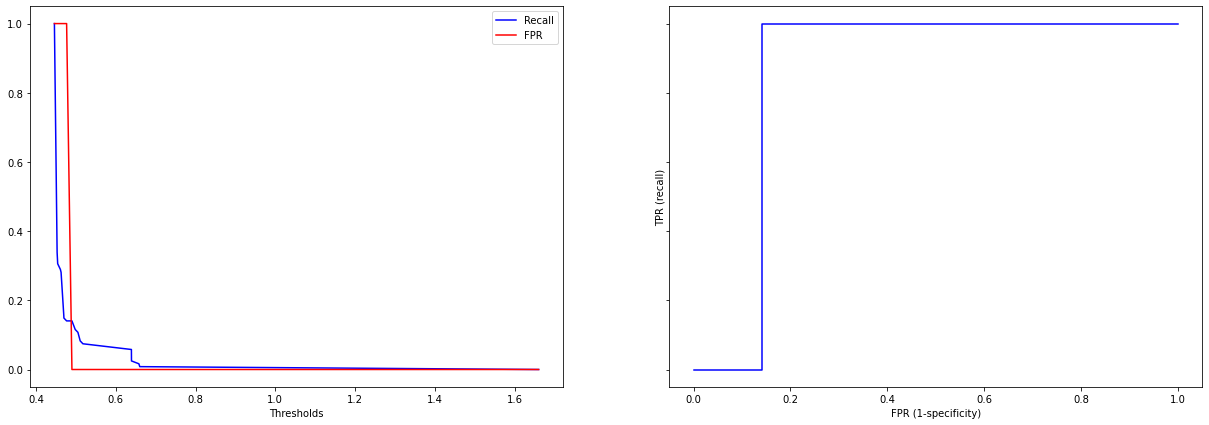

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.633012  0.432443   0.722184     0.833545  0.540818  0.664764
Validation  0.628986  0.431201   0.711130     0.827049  0.532871  0.663326

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009567  0.015547   0.016449     0.013086  0.014346  0.012231
Validation  0.045863  0.097847   0.051763     0.038533  0.083111  0.052005

XGBoost Classifier
╠■■■■■■■■■╣


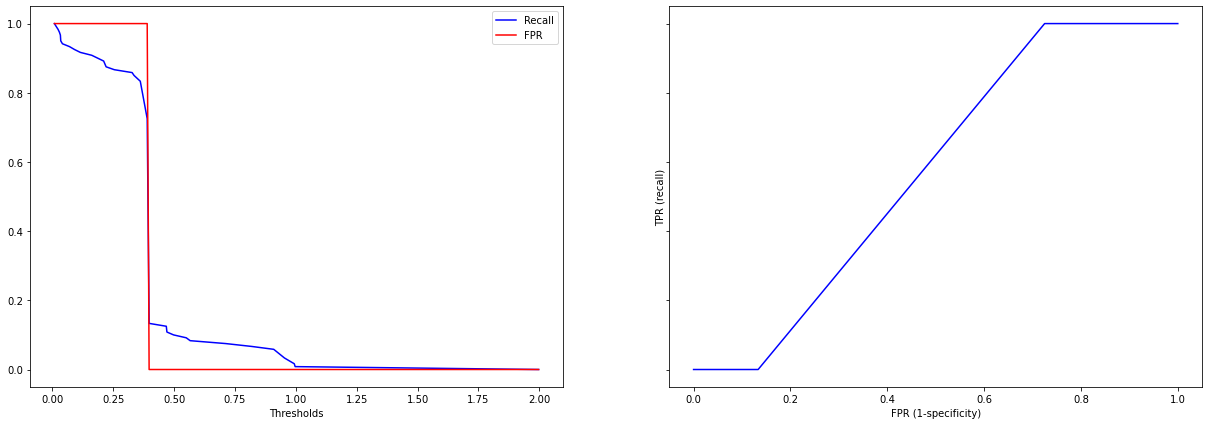

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.704473  0.504727   0.840611     0.904182  0.630590  0.754898
Validation  0.643315  0.445908   0.735282     0.840984  0.552068  0.656286

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.005934  0.014111   0.010455     0.008637  0.010735  0.00672
Validation  0.039728  0.087391   0.039740     0.026826  0.070482  0.03416

SVM
╠■■■■■■■■■╣


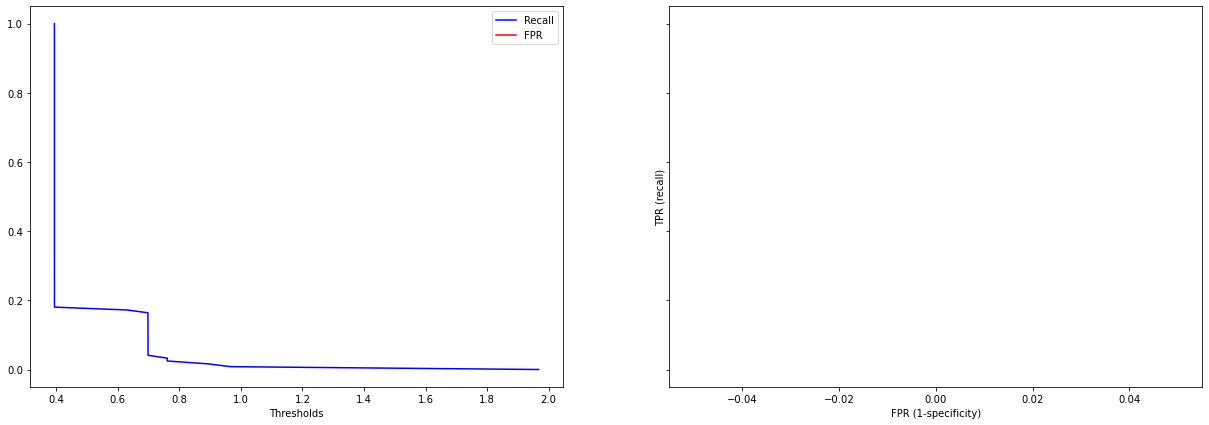

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.654559  0.451630   0.761230     0.857455  0.566011  0.688621
Validation  0.644950  0.449147   0.736321     0.840984  0.553570  0.677212

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010333  0.031676   0.021993     0.022570  0.023075  0.010010
Validation  0.052225  0.105985   0.061762     0.039632  0.086854  0.053065

KNN
╠■■■■■■■■■╣


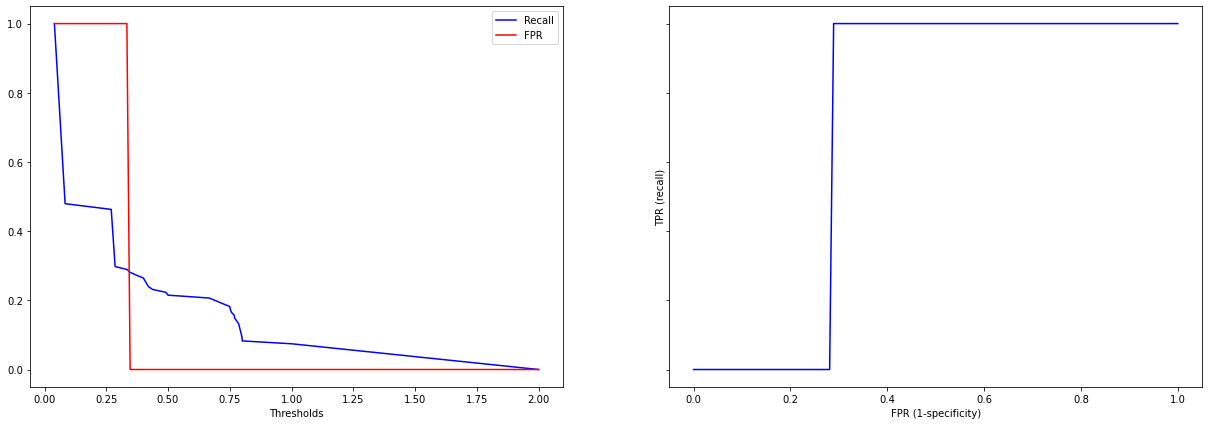

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703473  0.482360   0.864832     0.924545  0.619178  0.739456
Validation  0.646178  0.431174   0.756146     0.861475  0.546572  0.654190

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007458  0.014185   0.012226     0.007832  0.012329  0.006452
Validation  0.044966  0.080334   0.063384     0.038339  0.072442  0.044735

Logistic Regression
╠■■■■■■■■■╣


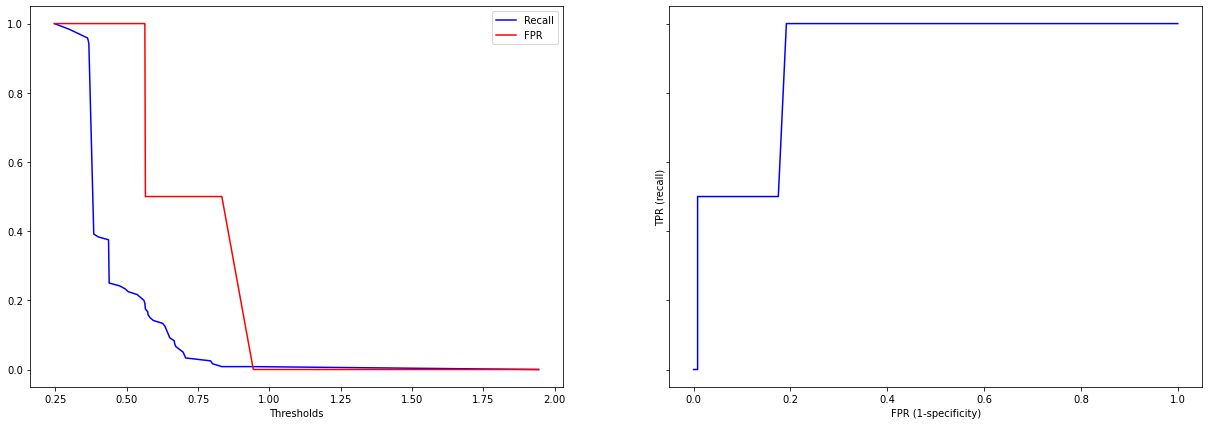

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665605  0.500097   0.749517     0.831091  0.599150  0.692339
Validation  0.647017  0.479435   0.721988     0.814754  0.570893  0.677912

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009912  0.020865   0.028577     0.036209  0.008221  0.009428
Validation  0.040631  0.106624   0.044720     0.054123  0.076091  0.048639

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.632663  0.364068   0.782529     0.901639   
Random Forest (100 estimators)  0.628986  0.431201   0.711130     0.827049   
XGBoost Classifier              0.643315  0.445908   0.735282     0.840984   
SVM                             0.644950  0.449147   0.736321     0.840984   
KNN                             0.646178  0.431174   0.756146     0.861475   
Logistic Regression             0.647017  0.479435   0.721988     0.814754   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.493149  0.622458  
Random Forest (100 estimators)  0.532871  0.663326  
XGBoost Classifier              0.552068  0.656286  
SVM                             0.553570  0.677212  
KNN                             0.546572  0.654190  
Logistic Regression             0.570893  0.677912

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                    0.6053054518414298-0.6600207442107615   
Random Forest (100 estimators)    0.599980051251456-0.6579925148241547   
XGBoost Classifier               0.6181894607856322-0.6684415194753248   
SVM                              0.6119200734294973-0.6779795585544436   
KNN                              0.6177387338845067-0.6746165688923417   
Logistic Regression              0.6213202282314677-0.6727145660140997   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                     0.3077021202954374-0.4204332922062286   
Random Forest (100 estimators)    0.3693169005497964-0.4930848054344764   
XGBoost Classifier               0.39063746417008693-0.5011791425205703   
SVM                                0.382115900399741-0.5161781153273017   
KNN                             0.38036630672846805-0.48198208724727487   
Logistic Regression               0.4120000890304233-0.5468696963887425   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.753605635389342-0.8114518556831275   
Random Forest (100 estimators)  0.6783921336510976-0.7438679119771483   
XGBoost Classifier              0.7101487565537449-0.7604160885544423   
SVM                             0.6972592986164805-0.7753830233584493   
KNN                             0.7160584881690859-0.7962331205875282   
Logistic Regression              0.6937040291155824-0.750271090536523   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8918641837049189-0.9114145048196712   
Random Forest (100 estimators)   0.802678575824068-0.8514197848316696   
XGBoost Classifier              0.8240172954139234-0.8579499177008306   
SVM                             0.8159183717132684-0.8660488414014856   
KNN                             0.8372276418225861-0.8857231778495451   
Logistic Regression             0.7805235852166867-0.8489846115046247   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4388202920273703-0.5474774524280102   
Random Forest (100 estimators)  0.48030688621716777-0.5854346466680682   
XGBoost Classifier               0.5074914913758134-0.5966452783890192   
SVM                              0.4986383162299928-0.6085011789722423   
KNN                              0.5007557873133124-0.5923881789668906   
Logistic Regression              0.5227686672356264-0.6190168126133728   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5934614056093671-0.6514554910199594  
Random Forest (100 estimators)  0.6304353133520072-0.6962176320272183  
XGBoost Classifier              0.6346818726595278-0.6778909670570445  
SVM                             0.6436508667438116-0.7107737568493743  
KNN                             0.6258965888162512-0.6824826824260714  
Logistic Regression             0.6471493974045112-0.7086738470681916

In [95]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Not surprisingly, <b>cough</b> and <b>cough_severity</b> seem to be the most important ones. Also, almost <b>all of them</b> seem to be <b>relevant</b> for some model, <b>except</b> for <b>diarreah</b> and <b>runny_nose</b>.

Dummy Random
╠■■■■■■■■■╣


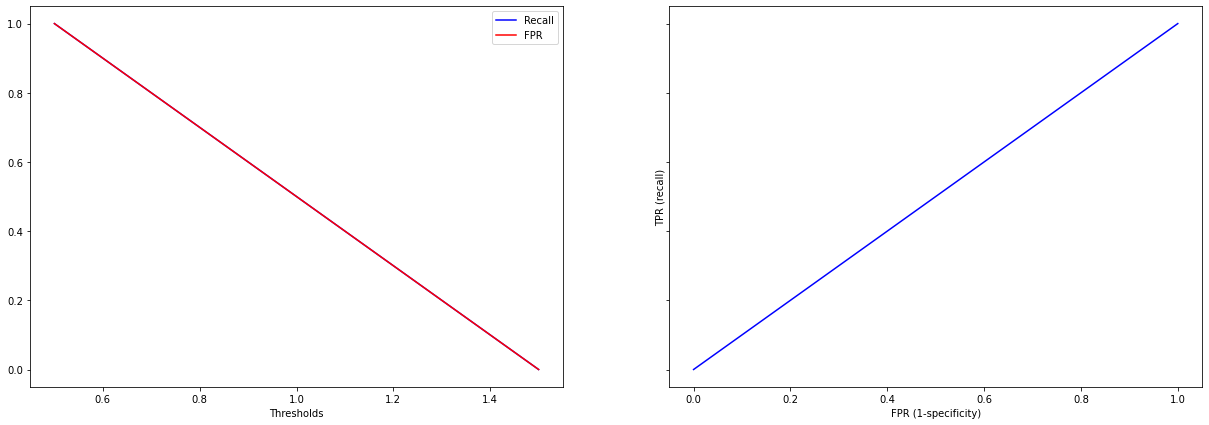

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


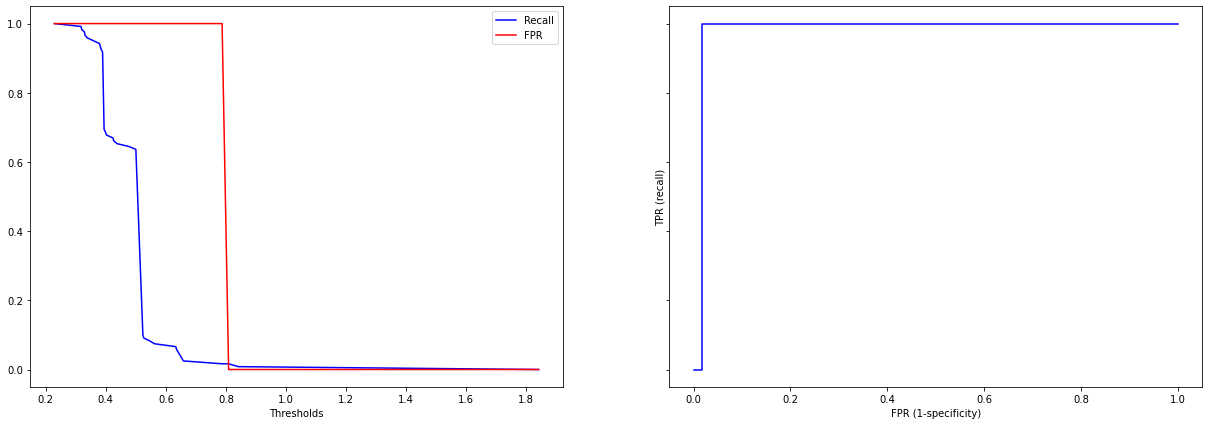

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.624738  0.346427   0.781356     0.903000  0.479498  0.604799
Validation  0.609301  0.325556   0.752261     0.893443  0.449348  0.580489

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010950  0.026201   0.015990     0.010740  0.025866  0.016807
Validation  0.045848  0.091698   0.066869     0.036657  0.090219  0.060318

Random Forest (100 estimators)
╠■■■■■■■■■╣


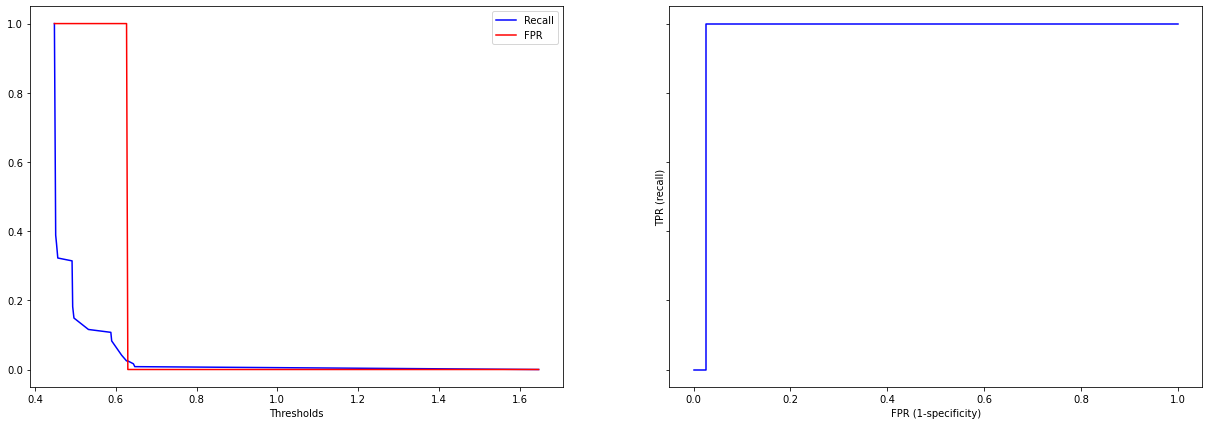

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.636330  0.472994   0.702439     0.799636  0.565267  0.666348
Validation  0.637569  0.468846   0.706307     0.806557  0.559833  0.671910

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005945  0.010519   0.008771     0.008043  0.008909  0.009565
Validation  0.047367  0.097518   0.048755     0.038871  0.078809  0.046326

XGBoost Classifier
╠■■■■■■■■■╣


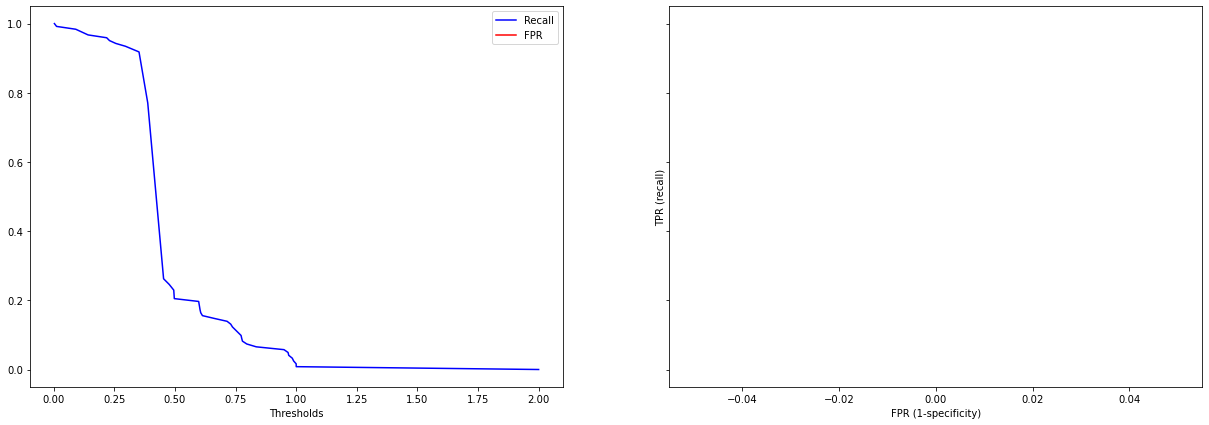

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.704155  0.505000   0.839251     0.903273  0.630450  0.755111
Validation  0.651079  0.450826   0.749721     0.851639  0.559793  0.653813

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006771  0.015022   0.006525     0.005270  0.012150  0.007058
Validation  0.046874  0.091923   0.044186     0.027716  0.079681  0.051529

SVM
╠■■■■■■■■■╣


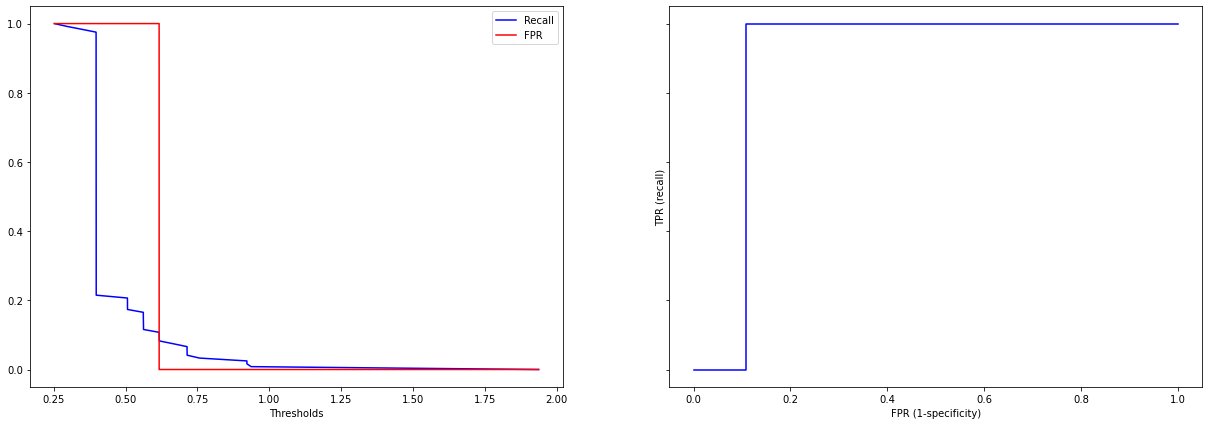

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657924  0.501635   0.732528     0.814182  0.594133  0.683566
Validation  0.657628  0.495822   0.743364     0.819672  0.584873  0.688750

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010330  0.031956   0.033477     0.042554  0.014782  0.010158
Validation  0.055356  0.123777   0.079915     0.090123  0.089961  0.055207

KNN
╠■■■■■■■■■╣


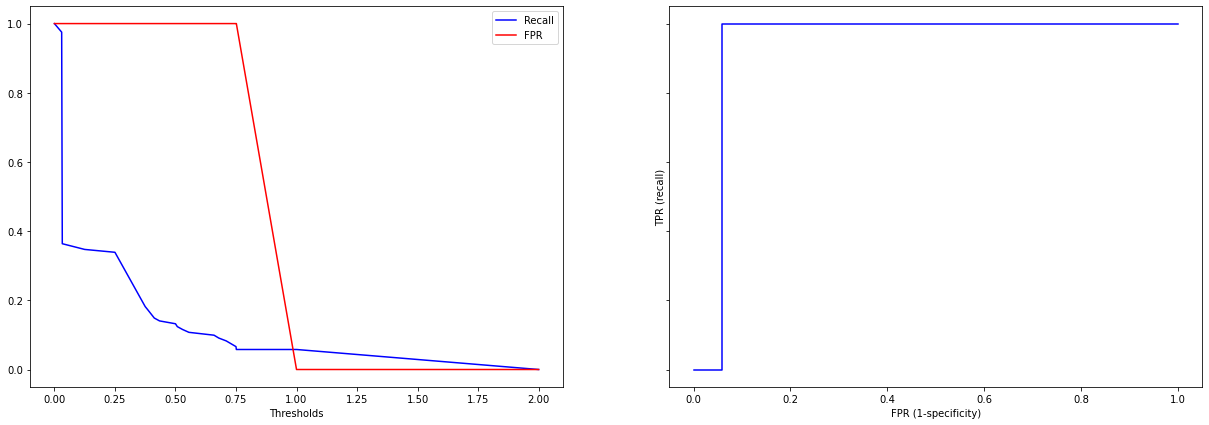

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.702836  0.489180   0.854200     0.916455  0.621973  0.737929
Validation  0.646559  0.440131   0.753136     0.853279  0.550946  0.655832

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006954  0.014366   0.010180     0.007087  0.011993  0.007450
Validation  0.046787  0.091565   0.067387     0.051472  0.074175  0.046035

Logistic Regression
╠■■■■■■■■■╣


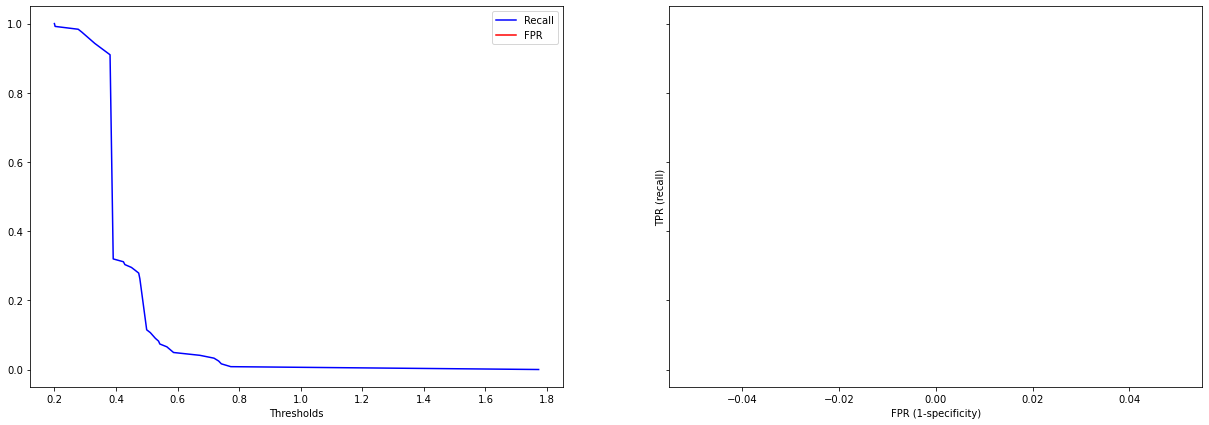

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662423  0.482631   0.753540     0.842182  0.588331  0.689360
Validation  0.656408  0.476176   0.741783     0.836885  0.577062  0.682131

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009082  0.014186    0.01297     0.008920  0.013305  0.009961
Validation  0.052212  0.097327    0.05487     0.031734  0.081788  0.050853

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.609301  0.325556   0.752261     0.893443   
Random Forest (100 estimators)  0.637569  0.468846   0.706307     0.806557   
XGBoost Classifier              0.651079  0.450826   0.749721     0.851639   
SVM                             0.657628  0.495822   0.743364     0.819672   
KNN                             0.646559  0.440131   0.753136     0.853279   
Logistic Regression             0.656408  0.476176   0.741783     0.836885   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.449348  0.580489  
Random Forest (100 estimators)  0.559833  0.671910  
XGBoost Classifier              0.559793  0.653813  
SVM                             0.584873  0.688750  
KNN                             0.550946  0.655832  
Logistic Regression             0.577062  0.682131

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                    0.5803040319180901-0.6382975070581562   
Random Forest (100 estimators)   0.6076118536168895-0.6675269888053255   
XGBoost Classifier               0.6214331091514955-0.6807248031937705   
SVM                              0.6226180074130399-0.6926379310279103   
KNN                              0.6169683017315378-0.6761497979673582   
Logistic Regression                0.6233868678615392-0.68943012778918   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.2675613732193333-0.3835515149587288   
Random Forest (100 estimators)  0.40716981891176685-0.5305217711188875   
XGBoost Classifier               0.39268936116056957-0.508963311103858   
SVM                              0.4175384379729661-0.5741049046899686   
KNN                             0.38221970232969027-0.4980415265121064   
Logistic Regression             0.41462146848627707-0.5377309238901056   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7099693914819745-0.7945525846911572   
Random Forest (100 estimators)  0.6754722767309921-0.7371424097728413   
XGBoost Classifier               0.7217757928133397-0.777667133959481   
SVM                             0.6928210052439835-0.7939061530159316   
KNN                             0.7105168545897722-0.7957557689525607   
Logistic Regression              0.707079822797208-0.7764853313955696   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8702587940594573-0.9166264518421818   
Random Forest (100 estimators)  0.7819732855099409-0.8311414685884196   
XGBoost Classifier               0.834110366194158-0.8691683223304321   
SVM                             0.7626736401730915-0.8766706221219903   
KNN                             0.8207248721123355-0.8858325049368447   
Logistic Regression             0.8168148987188996-0.8569555930843792   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.392289198232321-0.5064076697176713   
Random Forest (100 estimators)  0.5099896431255636-0.6096762762037095   
XGBoost Classifier              0.5093984666378713-0.6101873891166754   
SVM                             0.5279764222859461-0.6417688716834867   
KNN                              0.5040343906638721-0.597858561427962   
Logistic Regression             0.5253345039404251-0.6287894730190051   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5423403311191473-0.6186373543094135  
Random Forest (100 estimators)   0.6426108749720786-0.701208974137458  
XGBoost Classifier              0.6212228733006381-0.6864022733620084  
SVM                             0.6538341294098223-0.7236656357114514  
KNN                              0.626716433334563-0.6849467156135081  
Logistic Regression             0.6499689502789606-0.7142933229538225

In [96]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

In almost all models performance went down if we removed the booleanw <b>cough</b> and <b>sob</b> in favor of the graded <b>cough_severity</b>.


Dummy Random
╠■■■■■■■■■╣


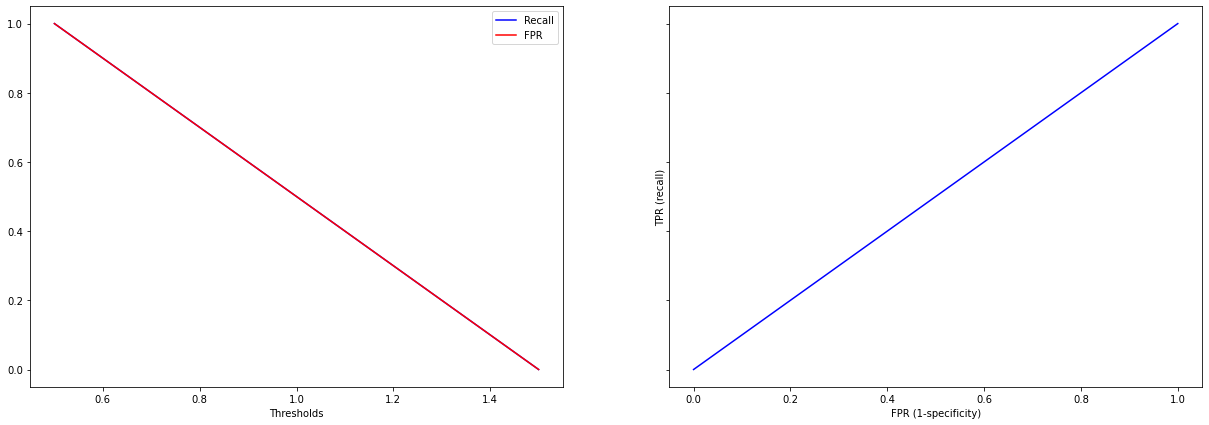

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


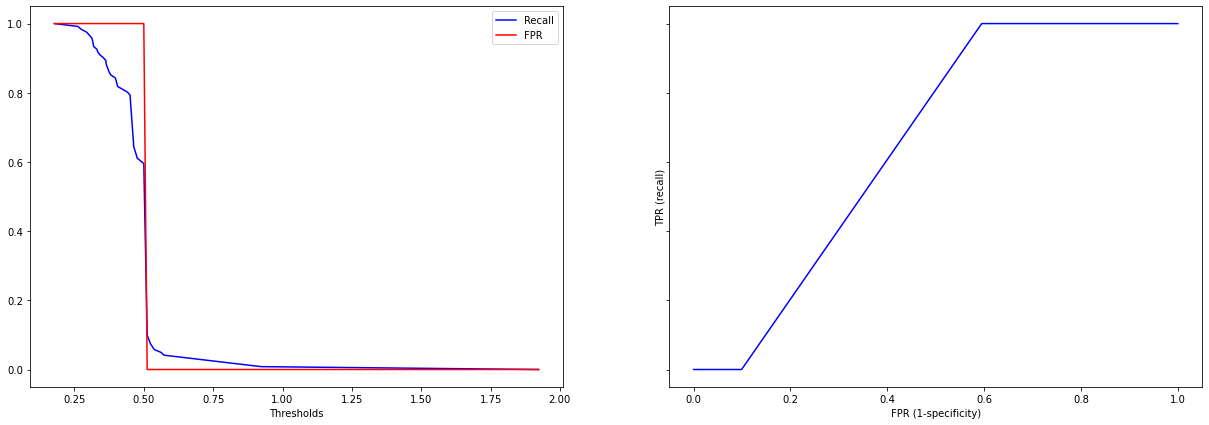

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.617965  0.322694   0.788467     0.913182  0.457661  0.592360
Validation  0.610948  0.311669   0.775901     0.910656  0.441202  0.575882

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006782  0.016469   0.017486     0.010987  0.016224  0.011939
Validation  0.041001  0.077869   0.078731     0.032201  0.080016  0.061657

Random Forest (100 estimators)
╠■■■■■■■■■╣


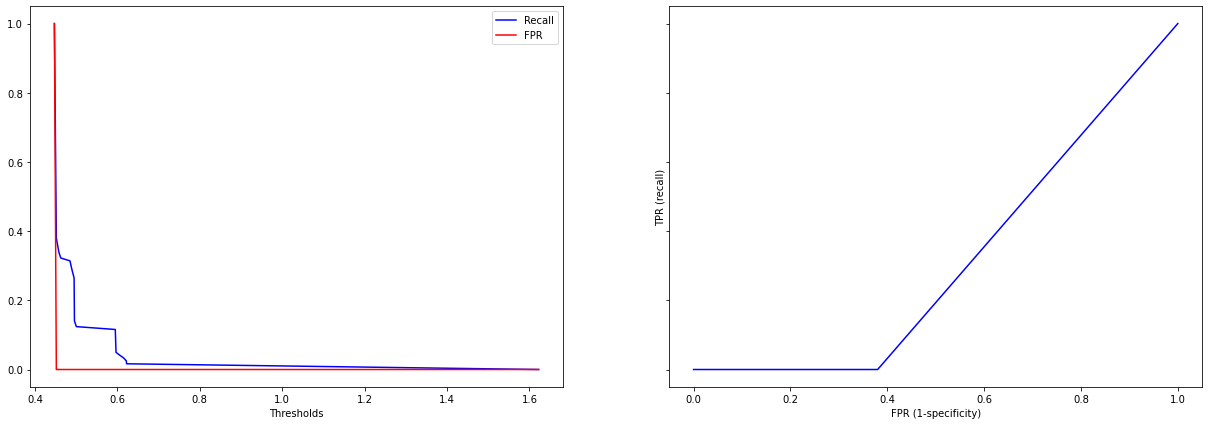

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.635557  0.484733   0.697184     0.786364  0.570444  0.666326
Validation  0.621201  0.468826   0.676363     0.773770  0.546590  0.664368

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012279  0.032170   0.032024     0.051202  0.012159  0.009998
Validation  0.029288  0.113521   0.026173     0.063280  0.075638  0.042730

XGBoost Classifier
╠■■■■■■■■■╣


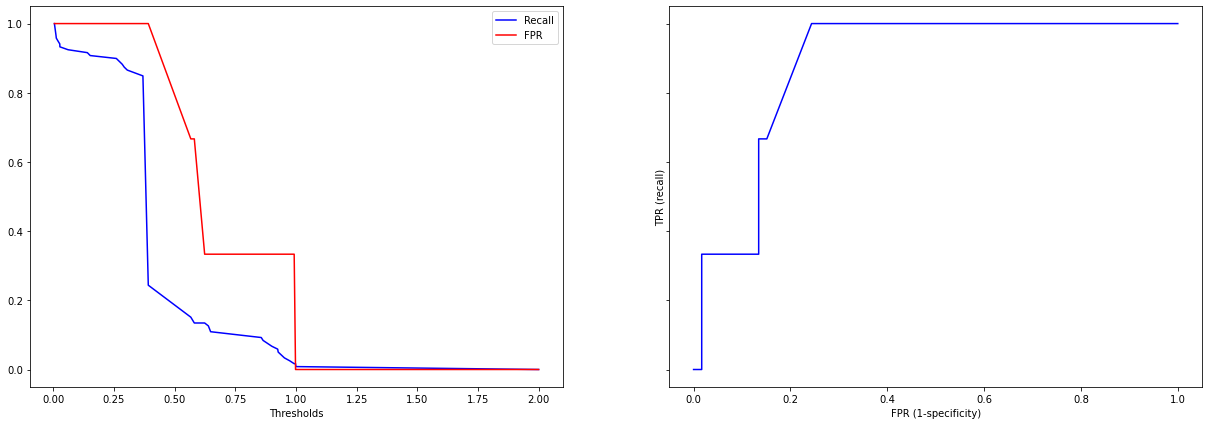

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694744  0.502453   0.816647     0.887000  0.621914  0.744898
Validation  0.634709  0.438558   0.718714     0.831148  0.542316  0.652221

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005159  0.016229   0.010178     0.010277  0.011037  0.005329
Validation  0.048941  0.087803   0.057803     0.030474  0.079190  0.053791

SVM
╠■■■■■■■■■╣


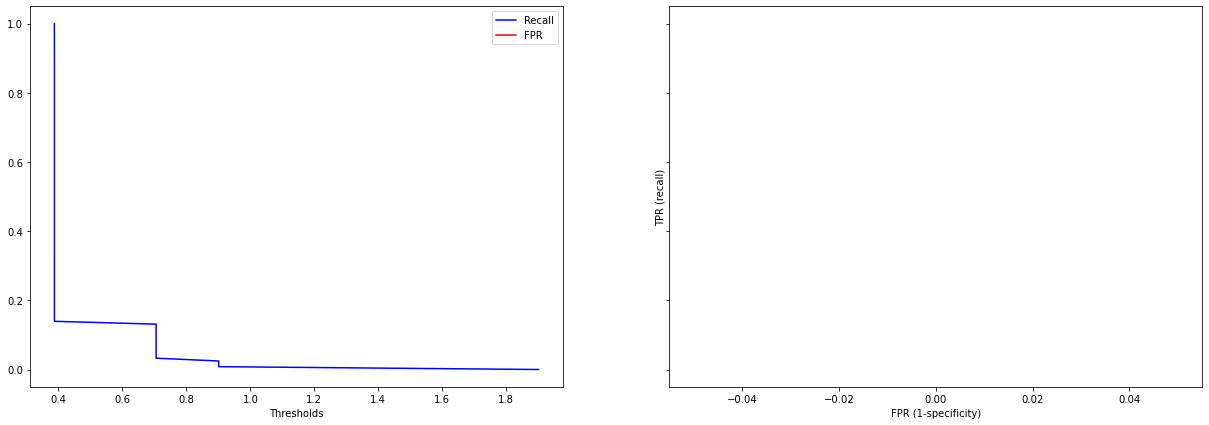

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656833  0.462086   0.756847     0.851545  0.573397  0.685923
Validation  0.645351  0.454885   0.729392     0.836066  0.557039  0.669607

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012968  0.028388   0.015586     0.013118  0.024050  0.011111
Validation  0.058491  0.107140   0.056572     0.025041  0.093197  0.053617

KNN
╠■■■■■■■■■╣


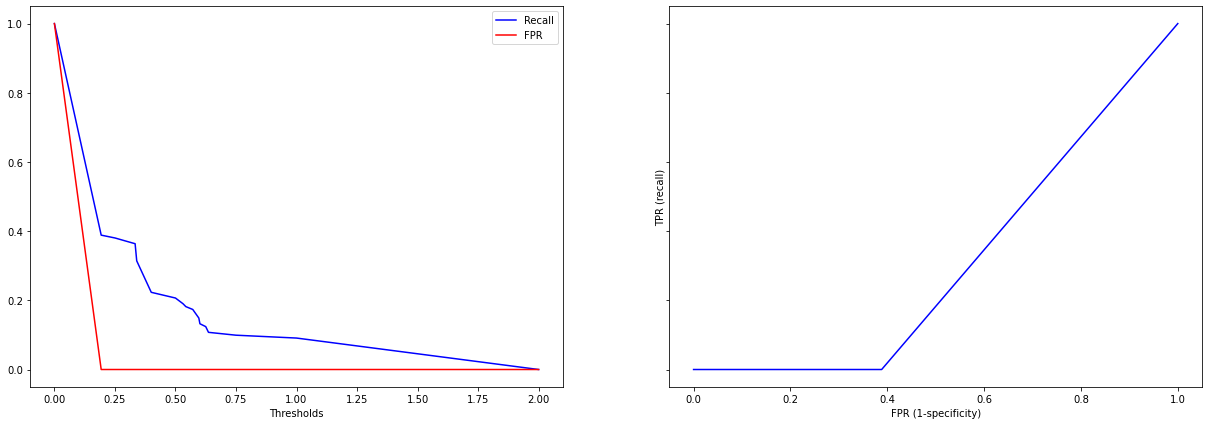

feature_importances


Permutation Importance



Mean metrics


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.699064  0.48218   0.851769     0.915909  0.615499  0.735061
Validation  0.644140  0.42625   0.754923     0.862295  0.542231  0.665082

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010006  0.020331   0.016265     0.011316  0.016962  0.007884
Validation  0.044404  0.080662   0.059802     0.035999  0.071961  0.061884

Logistic Regression
╠■■■■■■■■■╣


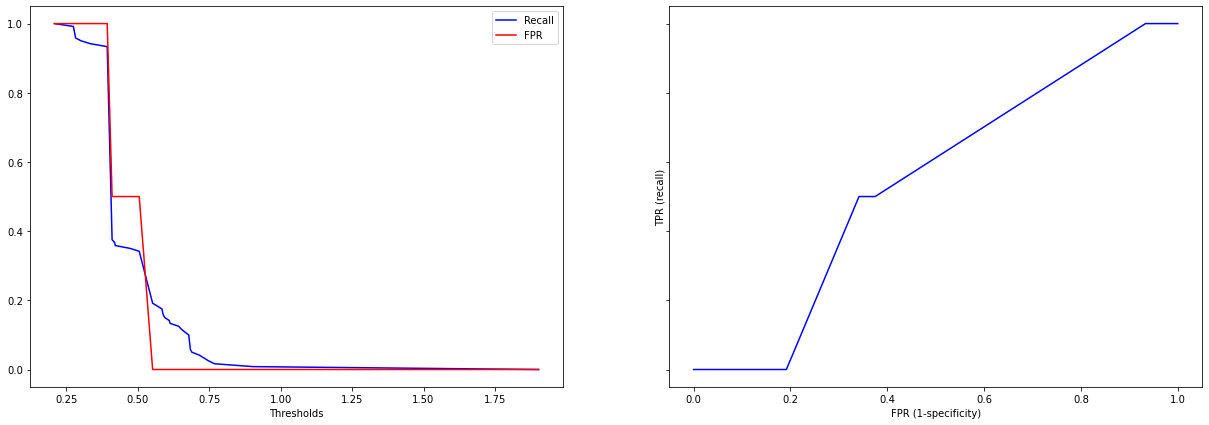

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663151  0.481633   0.756426     0.844636  0.588391  0.692864
Validation  0.663359  0.480255   0.753554     0.846721  0.583374  0.687412

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005449  0.009983   0.014251     0.013896  0.006778  0.003673
Validation  0.058627  0.105424   0.053003     0.030191  0.090265  0.061859

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.610948  0.311669   0.775901     0.910656   
Random Forest (100 estimators)  0.621201  0.468826   0.676363     0.773770   
XGBoost Classifier              0.634709  0.438558   0.718714     0.831148   
SVM                             0.645351  0.454885   0.729392     0.836066   
KNN                             0.644140  0.426250   0.754923     0.862295   
Logistic Regression             0.663359  0.480255   0.753554     0.846721   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.441202  0.575882  
Random Forest (100 estimators)  0.546590  0.664368  
XGBoost Classifier              0.542316  0.652221  
SVM                             0.557039  0.669607  
KNN                             0.542231  0.665082  
Logistic Regression             0.583374  0.687412

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                      0.58501717556376-0.6368797799397529   
Random Forest (100 estimators)   0.6026776344355421-0.6397245067488003   
XGBoost Classifier               0.6037558055842205-0.6656620599226379   
SVM                              0.6083584479168681-0.6823441281955441   
KNN                              0.6160568028537934-0.6722235584710645   
Logistic Regression               0.6262800265583582-0.700437939316516   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.26242029046154813-0.3609170412724251   
Random Forest (100 estimators)     0.397029049289909-0.540622556734348   
XGBoost Classifier               0.3830264410107517-0.4940893793277795   
SVM                              0.3871235106120967-0.5226459149510114   
KNN                             0.37523410851107936-0.4772648918887607   
Logistic Regression              0.4135786195779677-0.5469305101034929   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7261073214302081-0.8256949855870916   
Random Forest (100 estimators)    0.6598095210044024-0.69291662065575   
XGBoost Classifier              0.6821561699342585-0.7552714445685041   
SVM                             0.6936131895447372-0.7651717570789226   
KNN                             0.7171011393978082-0.7927452303596929   
Logistic Regression             0.7200320382991472-0.7870761248964273   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8902900052966293-0.9310214701132068   
Random Forest (100 estimators)  0.7337489979812009-0.8137919856253564   
XGBoost Classifier               0.811874107007051-0.8504209749601621   
SVM                             0.8202280035560772-0.8519031439849065   
KNN                             0.8395271402666672-0.8850630236677594   
Logistic Regression             0.8276268795522884-0.8658157433985313   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.3905953419838449-0.49180903875807797   
Random Forest (100 estimators)  0.49875193227481496-0.5944278922975782   
XGBoost Classifier              0.49223194290729533-0.5924004431891218   
SVM                             0.49809598440768343-0.6159819405181769   
KNN                             0.49671934456225403-0.5877431529956554   
Logistic Regression              0.5262853096215696-0.6404623124930866   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5368866621906837-0.6148768946816493  
Random Forest (100 estimators)  0.6373433315951584-0.6913931519534986  
XGBoost Classifier                0.6182008265696716-0.68624165873129  
SVM                             0.6356970304776641-0.7035174476655048  
KNN                             0.6259438579811532-0.7042211252058999  
Logistic Regression               0.648288831821638-0.726534899887864

In [97]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently keeping both the boolean and the graded yields better performance for every algorithm, except for <b>XGBoost</b> which improves when we just leave the boolean value.

Dummy Random
╠■■■■■■■■■╣


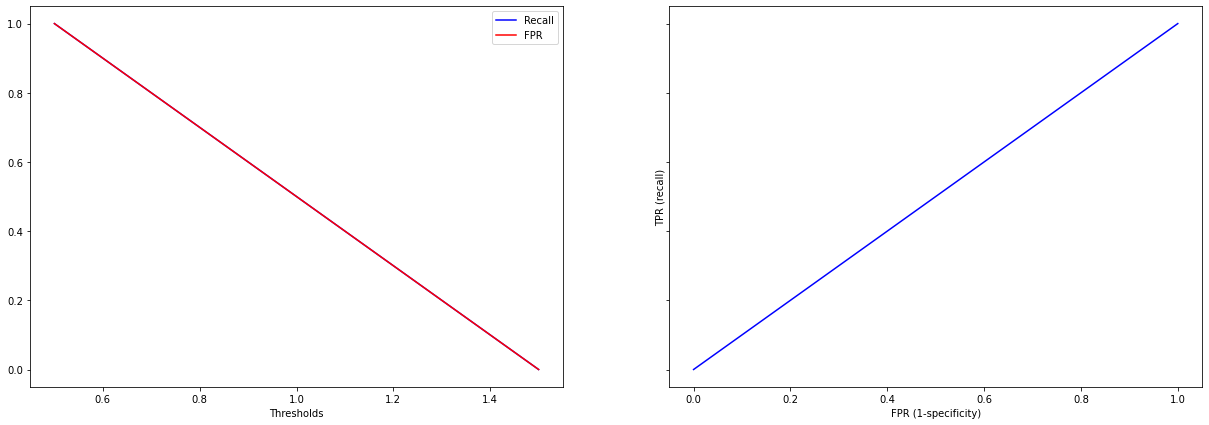

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000112     0.0        0.0          0.0  0.0      0.0
Validation  0.001011     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


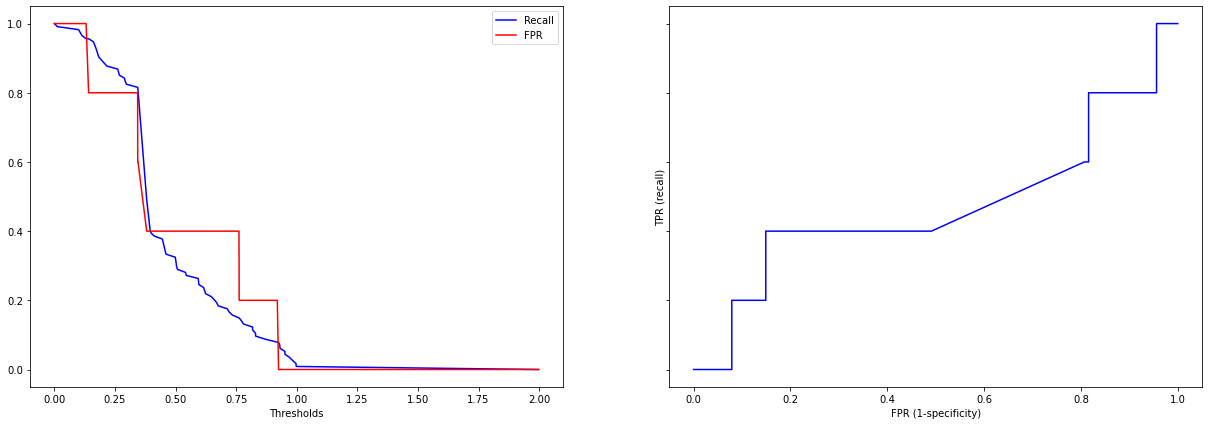

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655306  0.514296    0.71622     0.796276  0.598625  0.690145
Validation  0.654639  0.512171    0.71189     0.797479  0.594476  0.691795

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006339  0.012442   0.007561     0.007250  0.009854  0.009094
Validation  0.068466  0.100006   0.078928     0.042379  0.093418  0.062079

Random Forest (100 estimators)
╠■■■■■■■■■╣


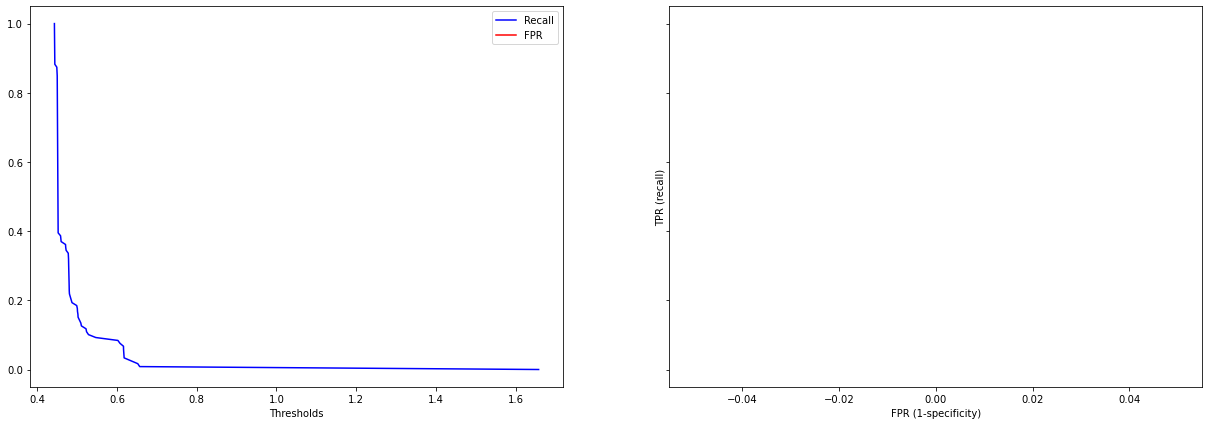

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.641897  0.466241   0.718762     0.817505  0.565515  0.685152
Validation  0.648328  0.462668   0.731682     0.834454  0.563846  0.682043

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008490  0.011903   0.014331     0.011843  0.011304  0.010015
Validation  0.054695  0.101150   0.052320     0.025688  0.088720  0.060105

XGBoost Classifier
╠■■■■■■■■■╣


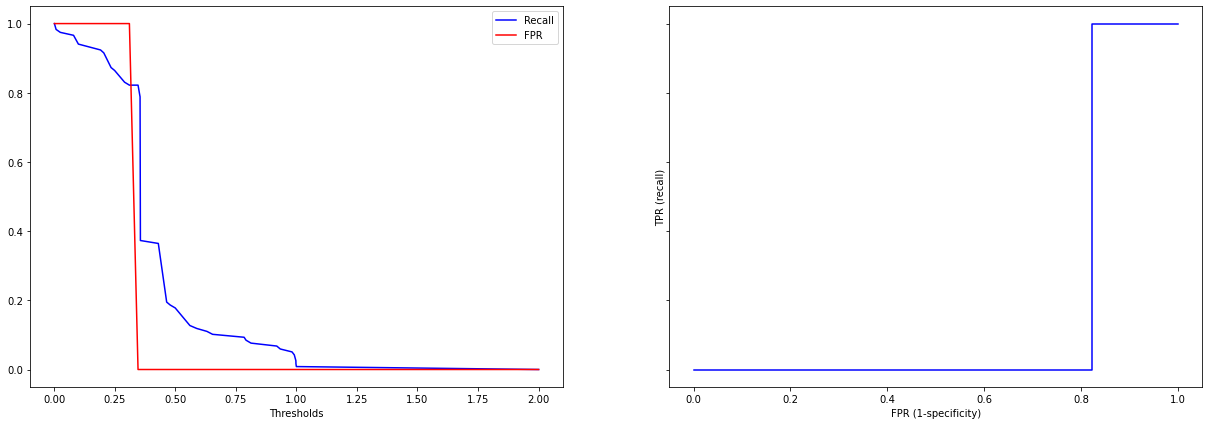

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.763142  0.587876   0.905188     0.938361  0.712706  0.838248
Validation  0.650039  0.466120   0.734127     0.834454  0.569170  0.660689

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006195  0.013395   0.008850     0.006740  0.009612  0.006210
Validation  0.053300  0.079634   0.065808     0.031455  0.078703  0.047853

SVM
╠■■■■■■■■■╣


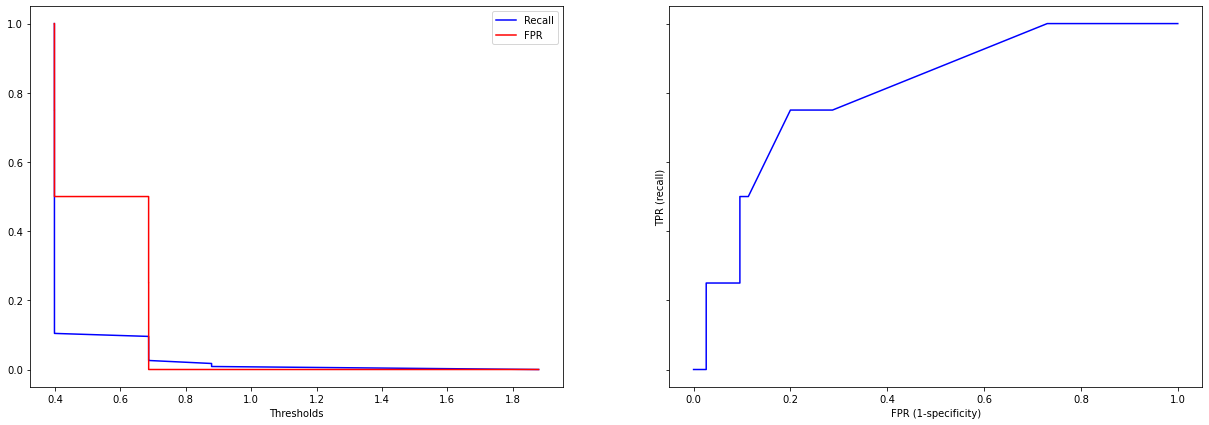

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663686  0.469403   0.767899     0.857914  0.582099  0.705431
Validation  0.642908  0.451008   0.727850     0.835294  0.554179  0.689392

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008755  0.028220   0.008513     0.013125  0.020933  0.009291
Validation  0.050978  0.095678   0.055858     0.024802  0.085891  0.063004

KNN
╠■■■■■■■■■╣


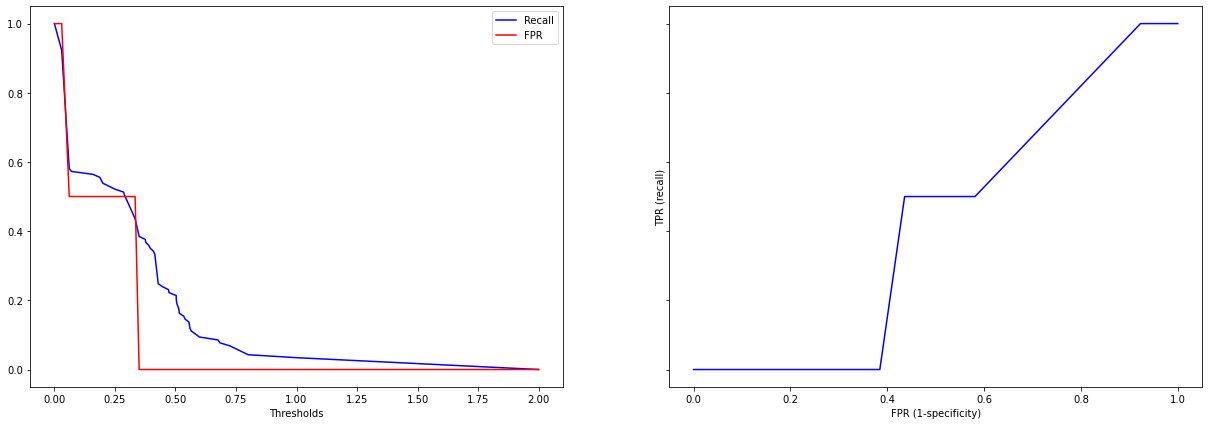

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.767007  0.569805   0.940854     0.964153  0.709651  0.820917
Validation  0.649190  0.471148   0.730805     0.827731  0.569217  0.654987

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007118  0.014488   0.007226     0.004793  0.011507  0.009484
Validation  0.046392  0.094970   0.054453     0.035707  0.080253  0.053440

Logistic Regression
╠■■■■■■■■■╣


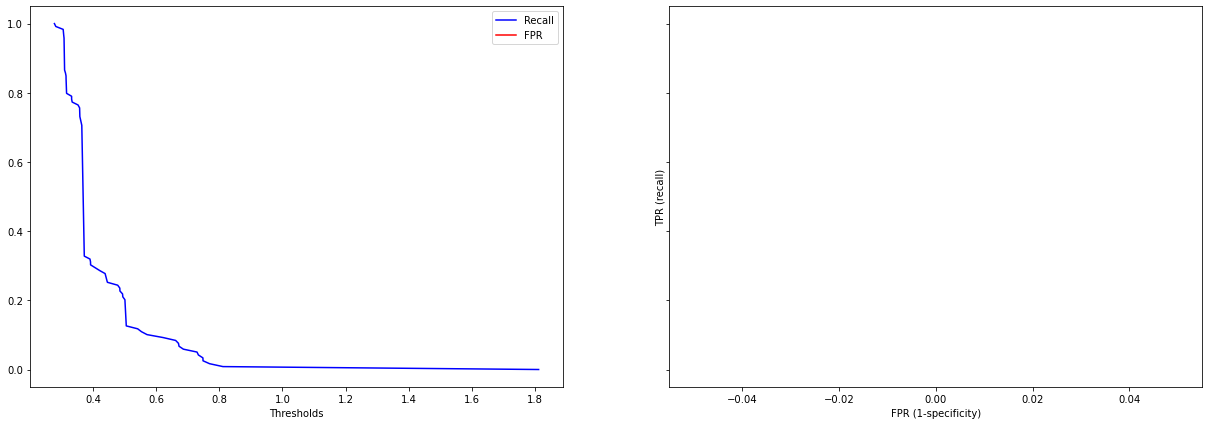

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666992  0.524460   0.736579     0.809497  0.610904  0.713806
Validation  0.663050  0.512073   0.737249     0.814286  0.600899  0.702285

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005555  0.039777   0.030396     0.044127  0.017048  0.007578
Validation  0.047455  0.086397   0.067564     0.062189  0.065687  0.054101

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.654639  0.512171   0.711890     0.797479   
Random Forest (100 estimators)  0.648328  0.462668   0.731682     0.834454   
XGBoost Classifier              0.650039  0.466120   0.734127     0.834454   
SVM                             0.642908  0.451008   0.727850     0.835294   
KNN                             0.649190  0.471148   0.730805     0.827731   
Logistic Regression             0.663050  0.512073   0.737249     0.814286   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.594476  0.691795  
Random Forest (100 estimators)  0.563846  0.682043  
XGBoost Classifier              0.569170  0.660689  
SVM                             0.554179  0.689392  
KNN                             0.569217  0.654987  
Logistic Regression             0.600899  0.702285

Accuracy  \
Dummy Random                    0.49873325304114985-0.5000115168333272   
MultinomialNB                     0.6113374918550354-0.697941366131674   
Random Forest (100 estimators)   0.6137356541442001-0.6829205815718435   
XGBoost Classifier               0.6163287182866867-0.6837486348302925   
SVM                              0.6106670850216317-0.6751491661650354   
KNN                              0.6198485173889438-0.6785305832052689   
Logistic Regression                0.633036568653545-0.693063076225327   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.44892136669678934-0.5754203699978886   
Random Forest (100 estimators)   0.3986949539360294-0.5266411805177521   
XGBoost Classifier              0.41575547337402396-0.5164854229845195   
SVM                              0.3904962188699229-0.5115205878527661   
KNN                              0.4110839881901623-0.5312129305773446   
Logistic Regression              0.45743060943119335-0.566715048832112   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6619722342057174-0.7618086484297574   
Random Forest (100 estimators)  0.6985920375891991-0.7647724164278137   
XGBoost Classifier              0.6925064296023934-0.7757480899049328   
SVM                             0.6925225314521247-0.7631779470825198   
KNN                             0.6963665360239083-0.7652441878672253   
Logistic Regression             0.6945181384096042-0.7799802782989154   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7706759132461497-0.8242820699471275   
Random Forest (100 estimators)  0.8182072829131652-0.8507002801120447   
XGBoost Classifier              0.8145599093506277-0.8543476536745822   
SVM                             0.8196078431372549-0.8509803921568628   
KNN                              0.805147737399724-0.8503144474742257   
Logistic Regression              0.7749541527877466-0.853617275783682   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5353935267032508-0.6535587859083158   
Random Forest (100 estimators)   0.5077347918571237-0.6199581809463134   
XGBoost Classifier               0.5193938883909872-0.6189463941498683   
SVM                             0.49985720210277895-0.6085010459545597   
KNN                              0.5184605959689074-0.6199735690383462   
Logistic Regression              0.5593552781828673-0.6424431546605024   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.652533236025987-0.7310572589955509  
Random Forest (100 estimators)  0.6440298010443587-0.7200569513036393  
XGBoost Classifier              0.6304240604888889-0.6909534316844508  
SVM                             0.6495452858356939-0.7292392868168965  
KNN                              0.621188693623748-0.6887855902074317  
Logistic Regression              0.668068764259722-0.7365011813655872

In [98]:
#ra_symptoms
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently, all features in <b>reported_symptoms</b> are more important than the assesed ones. <b>days_since_symptom_onset</b> seems to have some importance. Performance improves slightly for all of them except for <b>SVM</b> and <b>Logistic Regression</b>. Logistic Regression improves with a slightly lower threshold (.4 for higher recall and .44 for higher specificity). SVM improves also with a lower threshold(.47)

Dummy Random
╠■■■■■■■■■╣


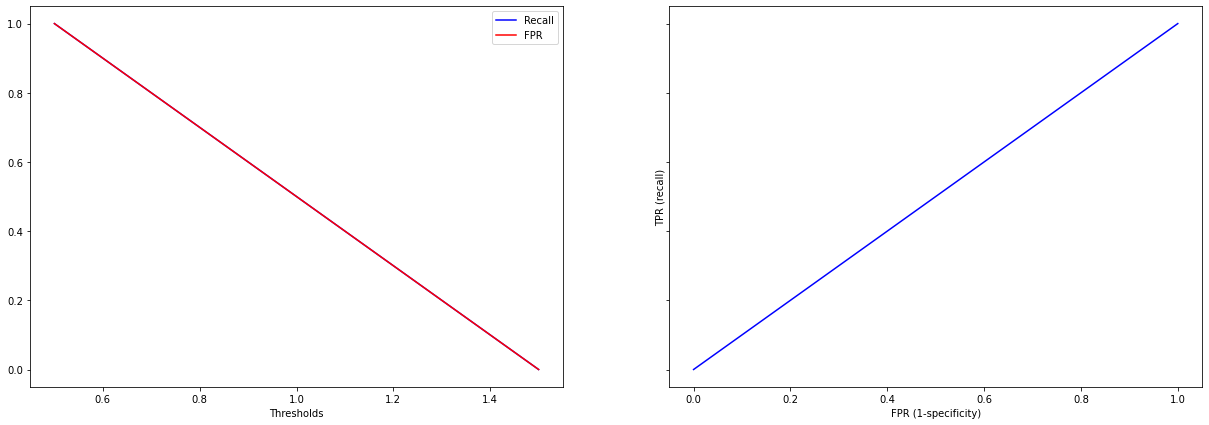

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000096     0.0        0.0          0.0  0.0      0.0
Validation  0.000860     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


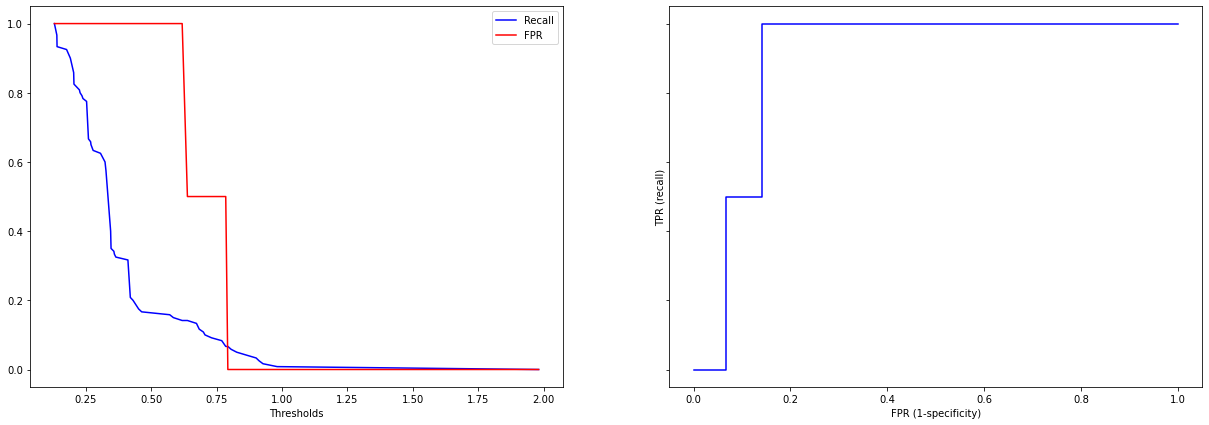

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655014  0.490271   0.731170     0.819727  0.586895  0.681497
Validation  0.649048  0.481941   0.720722     0.816393  0.575047  0.673771

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005091  0.010909   0.007311     0.007473  0.008435  0.007985
Validation  0.048378  0.093545   0.048972     0.026264  0.078381  0.052159

Random Forest (100 estimators)
╠■■■■■■■■■╣


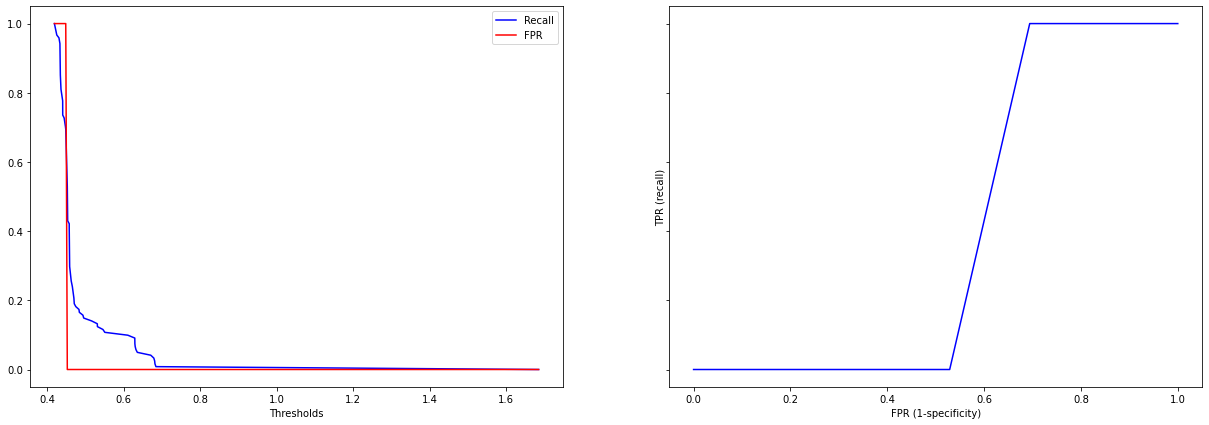

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.639604  0.436079   0.735340     0.843091  0.547367  0.683871
Validation  0.636355  0.433653   0.725909     0.839344  0.537878  0.676762

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008743  0.015964   0.012207     0.008806  0.014666  0.009204
Validation  0.045516  0.107353   0.042160     0.030960  0.090176  0.038481

XGBoost Classifier
╠■■■■■■■■■╣


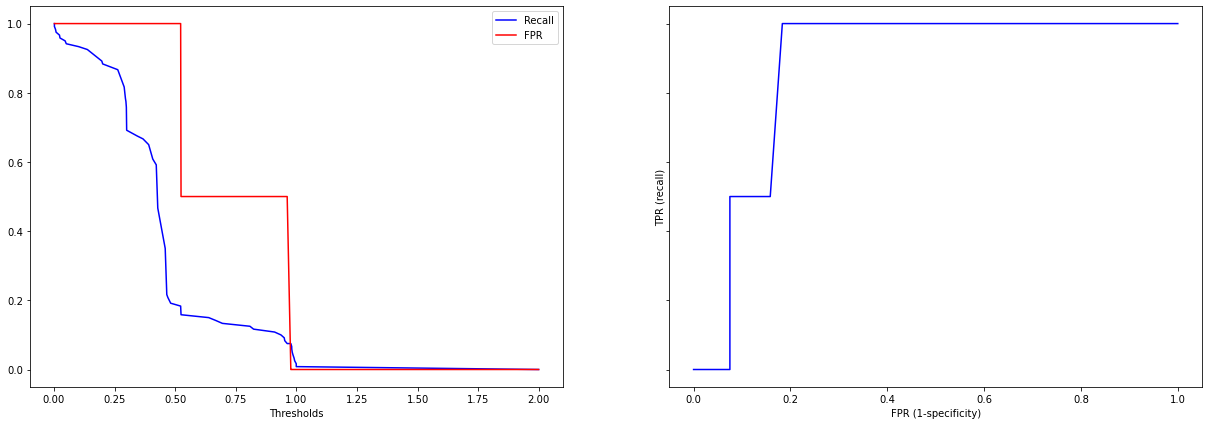

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.749477  0.567465   0.892624     0.931455  0.693667  0.830842
Validation  0.633484  0.448374   0.713480     0.818852  0.548178  0.652472

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004632  0.011664   0.015372     0.011901  0.006866  0.004857
Validation  0.028850  0.067700   0.039625     0.038339  0.051884  0.028595

SVM
╠■■■■■■■■■╣


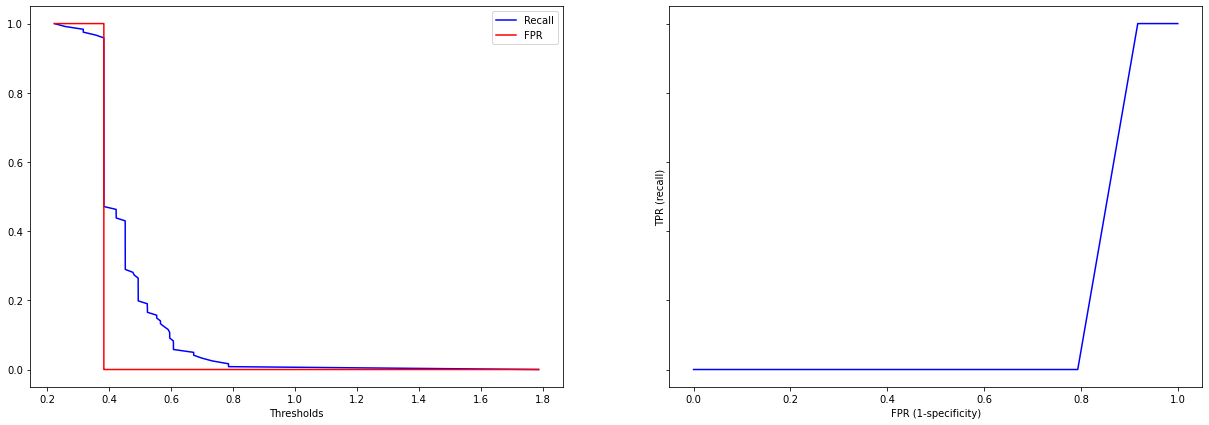

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.652696  0.442989   0.763870     0.862364  0.559830  0.698163
Validation  0.644935  0.440984   0.741478     0.849180  0.549676  0.684919

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012000  0.034424   0.021491     0.021591  0.026278  0.012956
Validation  0.058683  0.101417   0.076099     0.042714  0.093342  0.058171

KNN
╠■■■■■■■■■╣


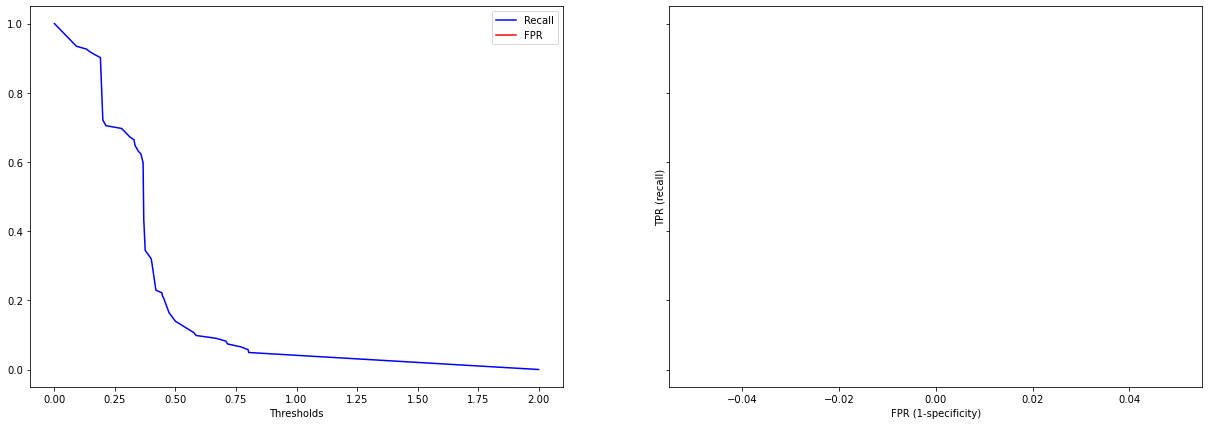

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.751296  0.551374   0.918893     0.951182  0.689073  0.805002
Validation  0.624058  0.406631   0.718702     0.841803  0.517322  0.623491

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004452  0.011478   0.011453     0.008109  0.007623  0.008859
Validation  0.035518  0.069524   0.047802     0.028928  0.063256  0.049643

Logistic Regression
╠■■■■■■■■■╣


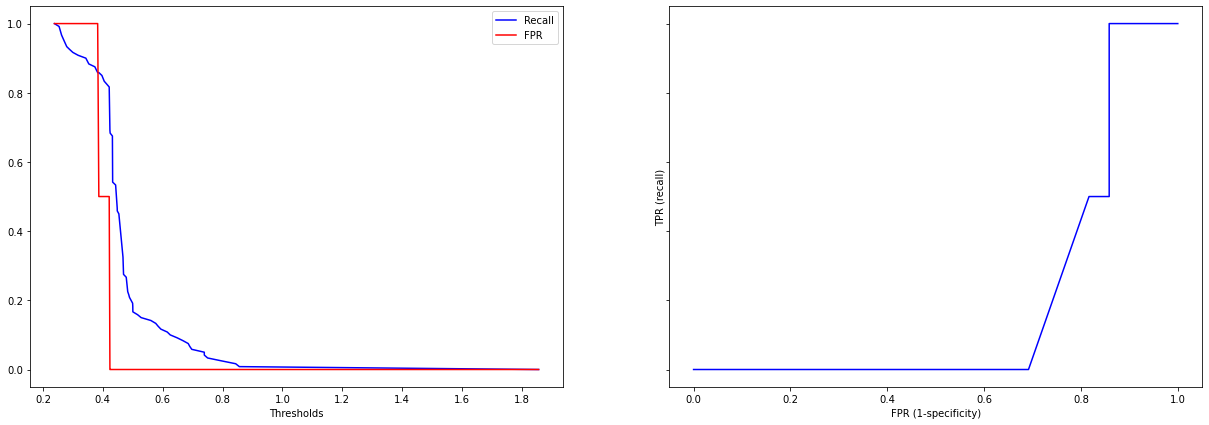

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664788  0.493452   0.750881     0.836091  0.595390  0.708752
Validation  0.653143  0.476190   0.735899     0.830328  0.574942  0.697722

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005632  0.012487   0.011703     0.012699  0.008715  0.004863
Validation  0.056260  0.098809   0.070483     0.046856  0.084114  0.047065

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.649048  0.481941   0.720722     0.816393   
Random Forest (100 estimators)  0.636355  0.433653   0.725909     0.839344   
XGBoost Classifier              0.633484  0.448374   0.713480     0.818852   
SVM                             0.644935  0.440984   0.741478     0.849180   
KNN                             0.624058  0.406631   0.718702     0.841803   
Logistic Regression             0.653143  0.476190   0.735899     0.830328   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.575047  0.673771  
Random Forest (100 estimators)  0.537878  0.676762  
XGBoost Classifier              0.548178  0.652472  
SVM                             0.549676  0.684919  
KNN                             0.517322  0.623491  
Logistic Regression             0.574942  0.697722

Accuracy  \
Dummy Random                    0.49904761904761896-0.5001360544217687   
MultinomialNB                    0.6184512243952182-0.6796451289001985   
Random Forest (100 estimators)    0.607568279397866-0.6651416570357237   
XGBoost Classifier               0.6152380243944113-0.6517308615206105   
SVM                              0.6078200916803767-0.6820494298987467   
KNN                              0.6015944553668724-0.6465219715317556   
Logistic Regression              0.6175609861390501-0.6887253972667713   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.422777206857516-0.5411039073634621   
Random Forest (100 estimators)   0.3657573537146631-0.5015490570543626   
XGBoost Classifier              0.40555661645259217-0.4911913510270826   
SVM                              0.37684204275238814-0.505125170362366   
KNN                             0.36265994565181897-0.4506014164699989   
Logistic Regression             0.41369693322240186-0.5386821151582459   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6897491315325922-0.7516939021771961   
Random Forest (100 estimators)  0.6992448629630303-0.7525734850264347   
XGBoost Classifier               0.6884187536874881-0.738540440627751   
SVM                             0.6933483515961404-0.7896066529126334   
KNN                             0.6884700428282114-0.7489349391295602   
Logistic Regression             0.6913212775113361-0.7804759748972668   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7997828588485566-0.8330040263973449   
Random Forest (100 estimators)  0.8197634176315094-0.8589251069586545   
XGBoost Classifier              0.7946046910029139-0.8431002270298731   
SVM                             0.8221656675534245-0.8761949881842802   
KNN                             0.8235074655270129-0.8600990918500364   
Logistic Regression              0.800693449479877-0.8599622882250408   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5254741832541684-0.6246196182510321   
Random Forest (100 estimators)  0.48084555581151517-0.594910250336153   
XGBoost Classifier               0.515363284479711-0.5809918861094653   
SVM                             0.4906413942873494-0.6087106656626632   
KNN                             0.4773152009459194-0.5573288180397407   
Logistic Regression             0.5217440234859814-0.6281405716808968   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6407827215427404-0.7067598461296443  
Random Forest (100 estimators)  0.6524244826610072-0.7010994629520043  
XGBoost Classifier              0.6343873786893645-0.6705572554788265  
SVM                             0.6481284762272445-0.7217097087173571  
KNN                              0.5920936952375262-0.654887730771305  
Logistic Regression             0.6679551484186403-0.7274885320326763

In [99]:
#r_symptoms_ex
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Epidemiological factors proves themselves to be slightly more important that some of the of the reported symptoms. <b>high_risk_exposure_occupation</b> once again proves to be a highly determinant feature. It also improves performance in all other models, while reducing specificity by a small amount (with the exception of <b>KNN</b>).

Dummy Random
╠■■■■■■■■■╣


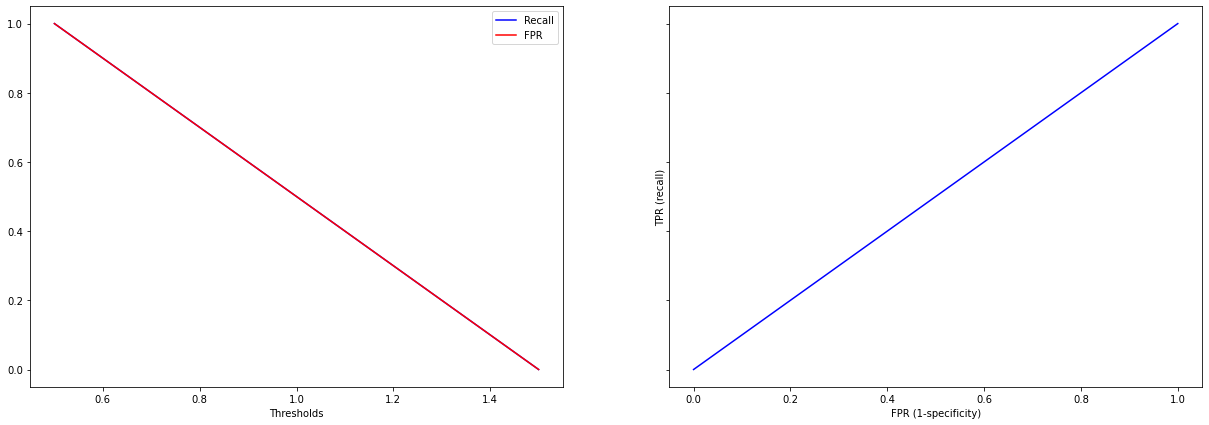

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


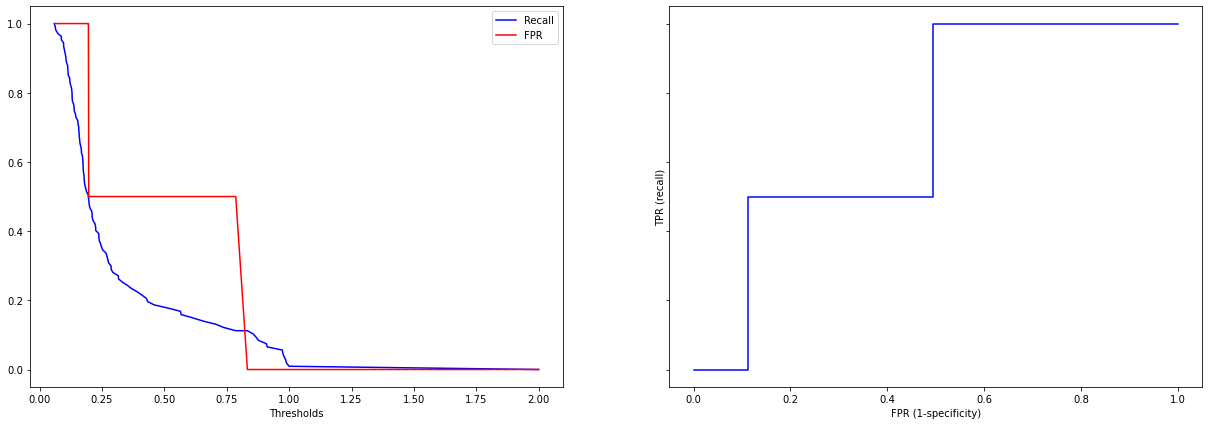

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656966  0.501265   0.727654     0.812525  0.593557  0.703574
Validation  0.652821  0.498666   0.722434     0.808257  0.586532  0.699536

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008426  0.011899   0.012048     0.009620  0.011135  0.011211
Validation  0.043698  0.092375   0.044233     0.039508  0.076174  0.038335

Random Forest (100 estimators)
╠■■■■■■■■■╣


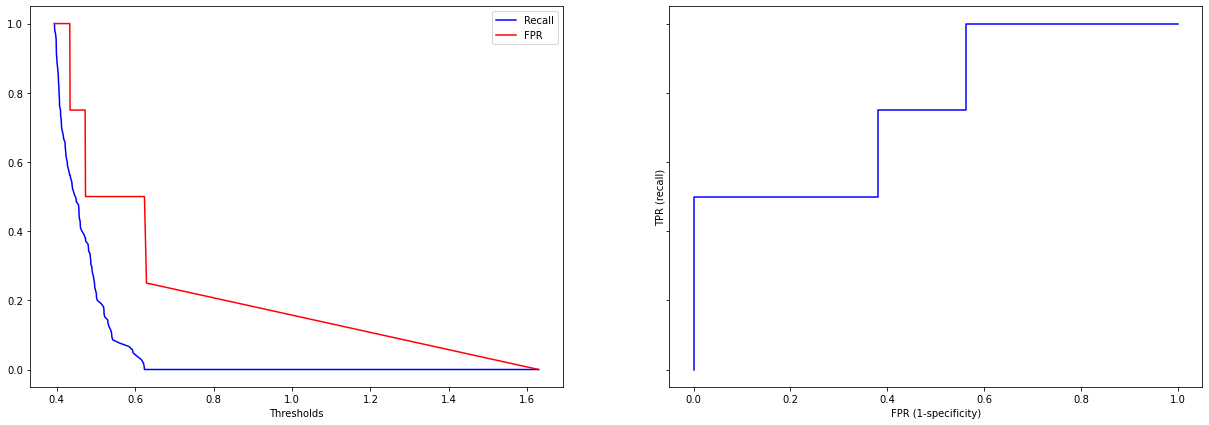

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.66030  0.511375   0.728709     0.809091  0.600659  0.719898
Validation   0.65602  0.494137   0.729769     0.819266  0.584273  0.716101

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010360  0.017680   0.021568     0.022776  0.012627  0.012377
Validation  0.049839  0.113895   0.041353     0.030596  0.091704  0.049948

XGBoost Classifier
╠■■■■■■■■■╣


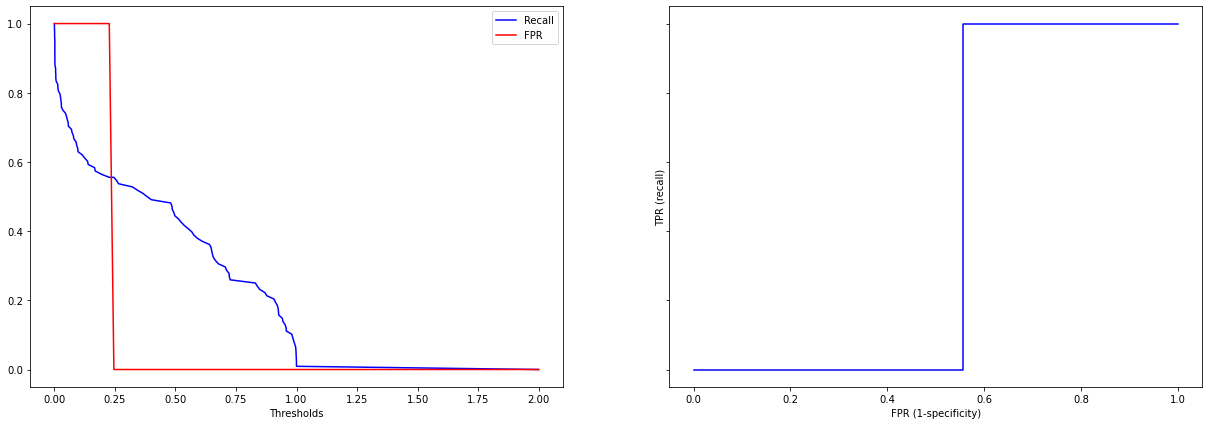

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999495  0.999191   0.999798     0.999798  0.999494  0.999998
Validation  0.617645  0.591460   0.625287     0.644037  0.607201  0.662600

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000413  0.000639   0.000426     0.000426  0.000413  0.000003
Validation  0.032221  0.060723   0.029089     0.026590  0.043677  0.032765

SVM
╠■■■■■■■■■╣


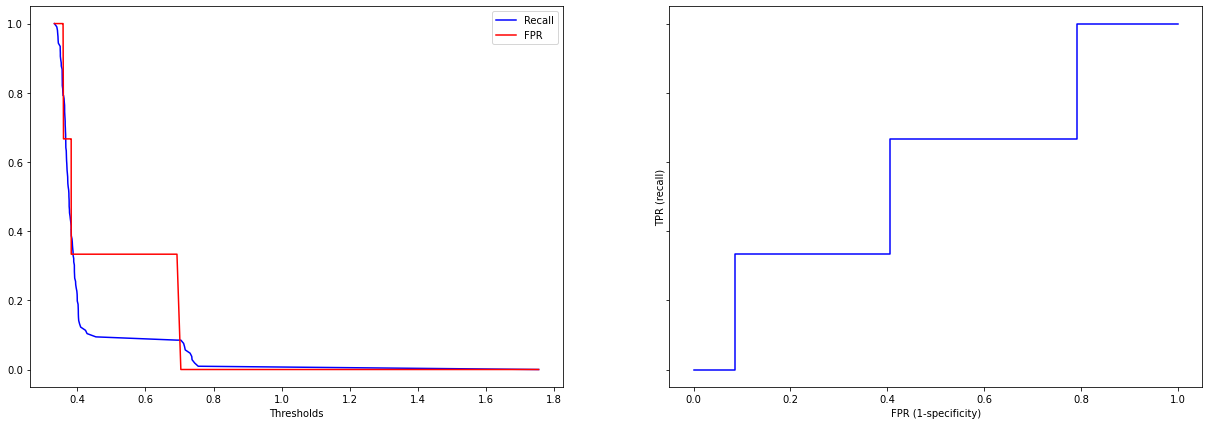

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669446  0.480236   0.772561     0.858485  0.592001  0.740625
Validation  0.654185  0.467715   0.746587     0.842202  0.571853  0.721918

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007842  0.019715   0.013283     0.013681  0.014555  0.007823
Validation  0.051714  0.094872   0.068766     0.038875  0.085684  0.044283

KNN
╠■■■■■■■■■╣


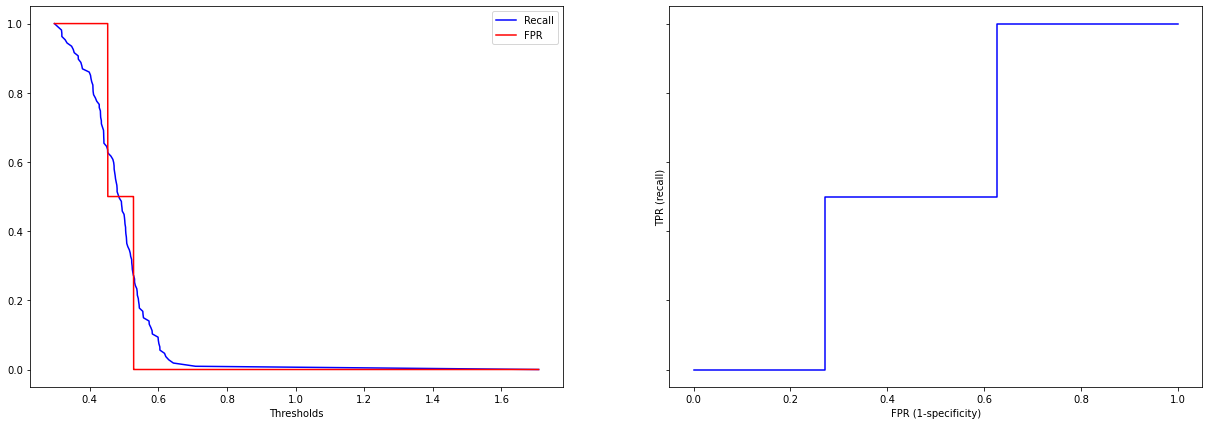

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999444  0.998888   1.000000     1.000000  0.999443  0.999999
Validation  0.580185  0.512327   0.595525     0.648624  0.548564  0.618904

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000442  0.000885   0.000000     0.000000  0.000443  9.459699e-07
Validation  0.035251  0.074575   0.039189     0.059621  0.051738  3.758929e-02

Logistic Regression
╠■■■■■■■■■╣


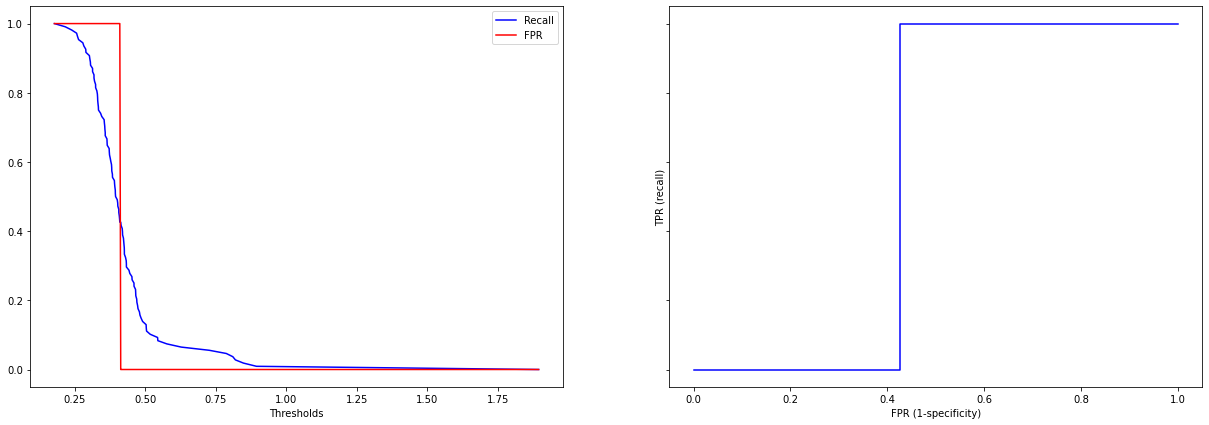

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670002  0.552120   0.722302     0.787778  0.625731  0.729928
Validation  0.662402  0.530484   0.722364     0.795413  0.609772  0.718201

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006169  0.013539   0.009582     0.011899  0.009018  0.007857
Validation  0.047771  0.082324   0.052305     0.040582  0.065633  0.056734

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.652821  0.498666   0.722434     0.808257   
Random Forest (100 estimators)  0.656020  0.494137   0.729769     0.819266   
XGBoost Classifier              0.617645  0.591460   0.625287     0.644037   
SVM                             0.654185  0.467715   0.746587     0.842202   
KNN                             0.580185  0.512327   0.595525     0.648624   
Logistic Regression             0.662402  0.530484   0.722364     0.795413   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.586532  0.699536  
Random Forest (100 estimators)  0.584273  0.716101  
XGBoost Classifier              0.607201  0.662600  
SVM                             0.571853  0.721918  
KNN                             0.548564  0.618904  
Logistic Regression             0.609772  0.718201

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                    0.6251843857420332-0.6804584444703583   
Random Forest (100 estimators)   0.6244986416214949-0.6875410718383518   
XGBoost Classifier               0.5972664591077671-0.6380232229332031   
SVM                               0.6214779420782206-0.686892046610984   
KNN                              0.5578903945199283-0.6024799293039584   
Logistic Regression              0.6321887527332892-0.6926154029367706   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4402424334393801-0.5570886758183348   
Random Forest (100 estimators)  0.42210352810895935-0.5661700331921249   
XGBoost Classifier               0.5530551487922092-0.6298639504571654   
SVM                             0.40771265801002005-0.5277168665938164   
KNN                              0.4651614655774317-0.5594924126544283   
Logistic Regression             0.47841767820853964-0.5825497946855387   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                     0.694458461091767-0.750409005758188   
Random Forest (100 estimators)  0.7036145969047556-0.7559230007207318   
XGBoost Classifier               0.6068898306436252-0.643684481596976   
SVM                             0.7030955887645499-0.7900782319575906   
KNN                             0.5707399386444293-0.6203104521284951   
Logistic Regression              0.6892828611004411-0.755444421566223   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7832700939256081-0.8332436675422821   
Random Forest (100 estimators)  0.7999152391198087-0.8386168709719343   
XGBoost Classifier               0.627219905706584-0.6608534887888288   
SVM                             0.8176149831899183-0.8667886865348523   
KNN                             0.6109160546989644-0.6863316517230541   
Logistic Regression             0.7697466235371777-0.8210790645362169   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5383554090283271-0.6347086892742646   
Random Forest (100 estimators)  0.5262737756141915-0.6422713018678314   
XGBoost Classifier              0.5795773676843151-0.6348247430989647   
SVM                             0.5176610810950676-0.6260442497450222   
KNN                              0.515841768293062-0.5812852428799693   
Logistic Regression             0.5682620872585201-0.6512815211704855   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                     0.67529133382413-0.7237812878560164  
Random Forest (100 estimators)  0.6845118585538528-0.7476910475376148  
XGBoost Classifier              0.6418779396681039-0.6833227244939272  
SVM                             0.6939111667972448-0.7499248280302488  
KNN                             0.5951306578752924-0.6426777604549674  
Logistic Regression             0.6823192199376931-0.7540823685420035

In [100]:
#r_symptoms_vitals
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


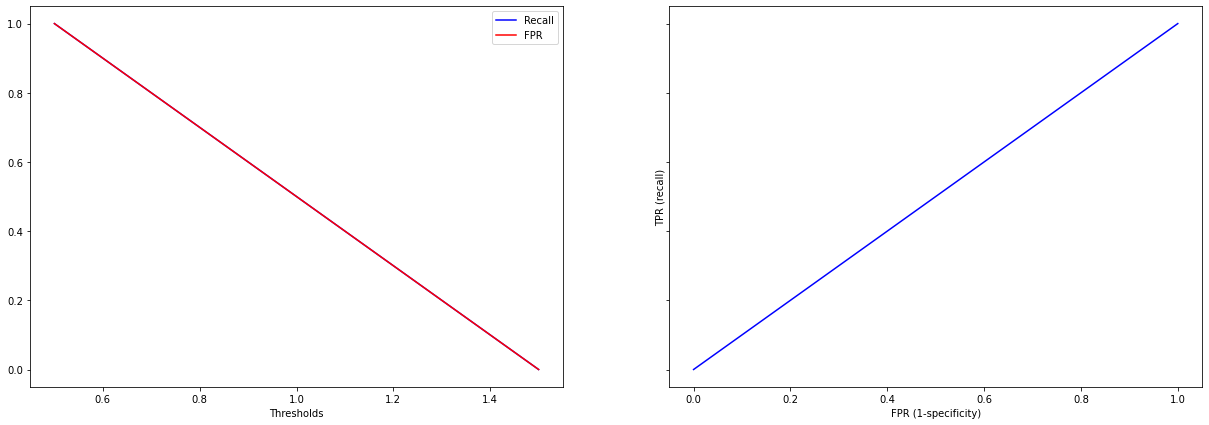

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


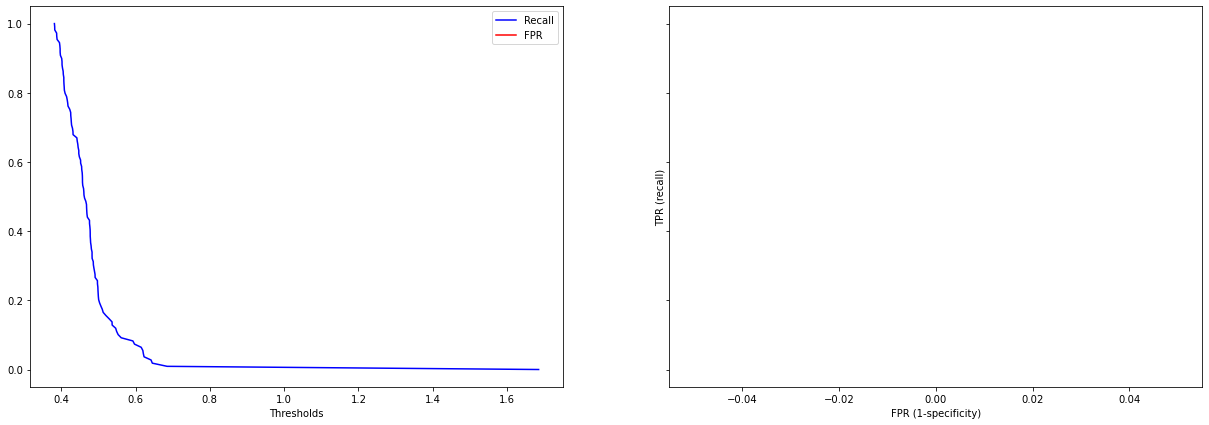

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660250  0.512385   0.727427     0.807980  0.601140  0.719301
Validation  0.653747  0.510509   0.714227     0.798165  0.593583  0.696483

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005947  0.011576   0.011434     0.012584  0.008094  0.006377
Validation  0.065833  0.099524   0.078526     0.047376  0.092036  0.067181

XGBoost Classifier
╠■■■■■■■■■╣


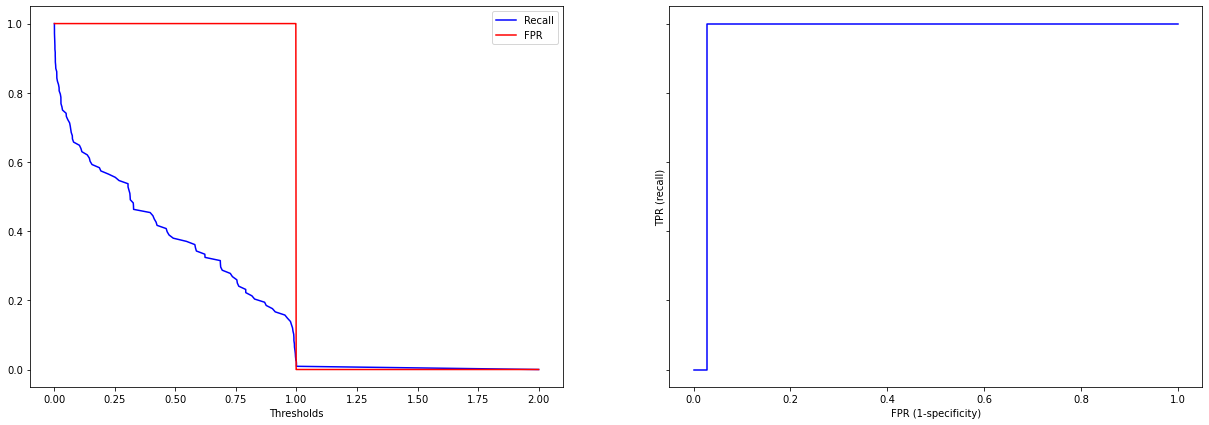

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999343  0.999191   0.999495     0.999495  0.999343  0.999999
Validation  0.627232  0.612410   0.632794     0.642202  0.621594  0.675567

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000479  0.000639   0.000533     0.000532  0.000480  0.000002
Validation  0.041701  0.064375   0.042035     0.046979  0.050039  0.048757

SVM
╠■■■■■■■■■╣


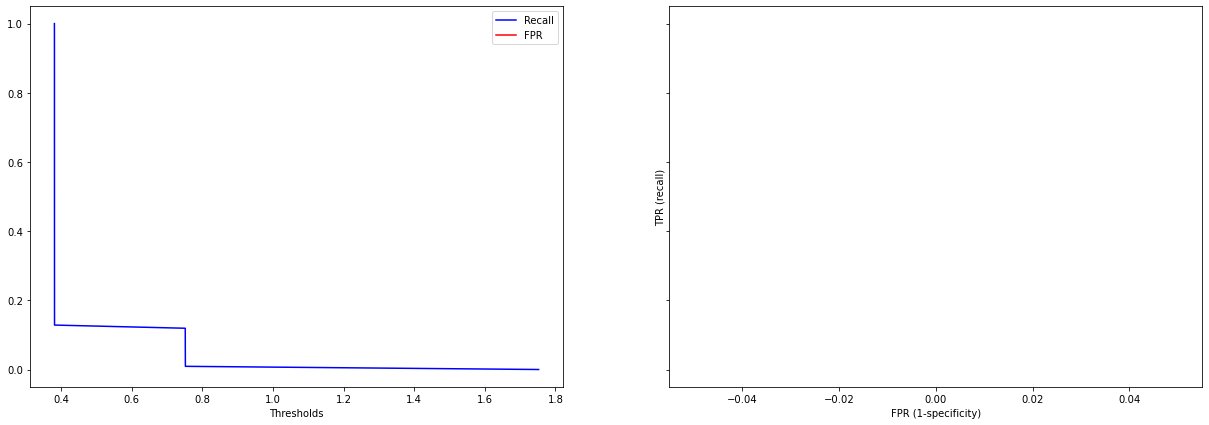

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665909  0.470222   0.772760     0.861414  0.584106  0.735070
Validation  0.665617  0.471410   0.771517     0.861468  0.581894  0.721345

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007151  0.026277   0.011387     0.015228  0.018941  0.007624
Validation  0.051589  0.094713   0.065710     0.037316  0.086070  0.054413

KNN
╠■■■■■■■■■╣


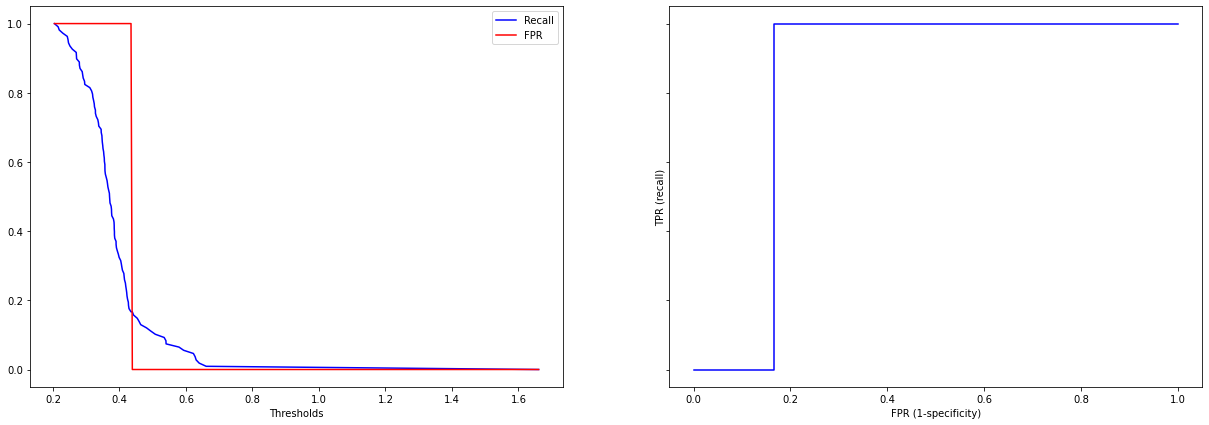

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999444  0.998888    1.00000     1.000000  0.999443  0.999999
Validation  0.617182  0.381276    0.72043     0.855046  0.495914  0.676596

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000442  0.000885   0.000000     0.000000  0.000443  9.462574e-07
Validation  0.049733  0.089522   0.059392     0.025513  0.086096  5.237587e-02

Logistic Regression
╠■■■■■■■■■╣


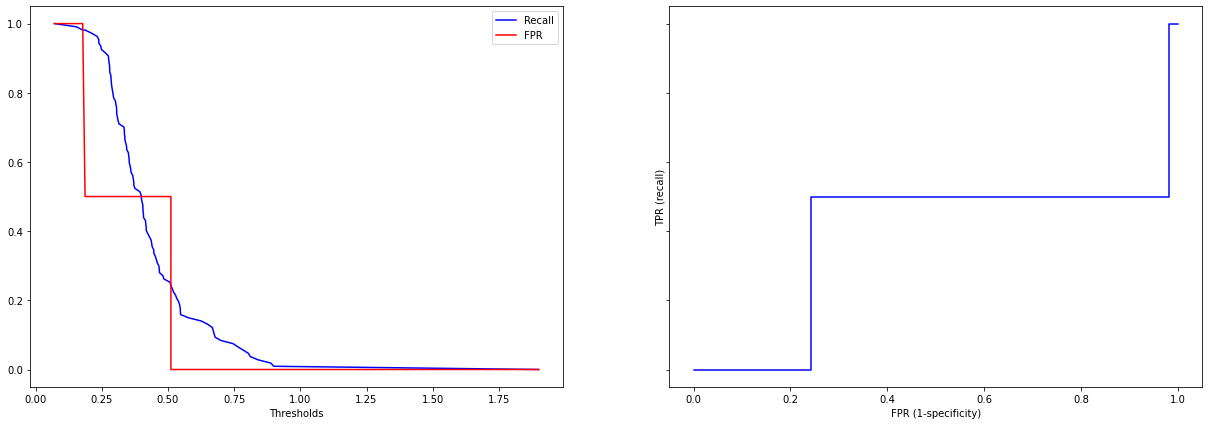

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685514  0.566272   0.743389     0.804646  0.642805  0.745033
Validation  0.673378  0.559633   0.725998     0.788073  0.630677  0.725048

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003515  0.008548   0.005650     0.007098  0.005428  0.005318
Validation  0.044460  0.074412   0.046918     0.035519  0.059023  0.056583

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.653747  0.510509   0.714227     0.798165   
XGBoost Classifier              0.627232  0.612410   0.632794     0.642202   
SVM                             0.665617  0.471410   0.771517     0.861468   
KNN                             0.617182  0.381276   0.720430     0.855046   
Logistic Regression             0.673378  0.559633   0.725998     0.788073   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.593583  0.696483  
XGBoost Classifier              0.621594  0.675567  
SVM                             0.581894  0.721345  
KNN                             0.495914  0.676596  
Logistic Regression             0.630677  0.725048

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6121108985066984-0.6953835508251268   
XGBoost Classifier                0.600857624855268-0.6536059501939551   
SVM                               0.6329896882452141-0.698244864140526   
KNN                              0.5857278002777907-0.6486360722034624   
Logistic Regression              0.6452585141854543-0.7014969631720087   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.4475639938413282-0.5734535207541679   
XGBoost Classifier               0.5716957856178536-0.6531248982853991   
SVM                               0.4115075302258597-0.531311485620679   
KNN                             0.3246574784643026-0.43789464830800773   
Logistic Regression               0.5125707781128475-0.606695276933024   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.664562668825747-0.7638908039166815   
XGBoost Classifier              0.6062081954089776-0.6593791032281907   
SVM                             0.7299585280288385-0.8130760659304797   
KNN                             0.6828672229434231-0.7579922656780339   
Logistic Regression             0.6963249657855988-0.7556718017874904   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.7682019603329276-0.8281283148964304   
XGBoost Classifier              0.6124893998740278-0.6719142698507429   
SVM                              0.8378669340898169-0.885068845726697   
KNN                             0.8389102067788712-0.8711815363403952   
Logistic Regression             0.7656093361807865-0.8105374528100391   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5353737854738276-0.6517917288240351   
XGBoost Classifier              0.5899466741007598-0.6532415885227593   
SVM                              0.5274586222291586-0.636329465933045   
KNN                             0.4414622804229895-0.5503662694811875   
Logistic Regression              0.593347785834272-0.6680063223069657   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6539938357530317-0.7389716324123352  
XGBoost Classifier              0.6447300655055396-0.7064035244126642  
SVM                             0.6869309178002931-0.7557586323600087  
KNN                              0.6434706046749149-0.709721428441367  
Logistic Regression             0.6892622484202177-0.7608342387135562

In [101]:
#r_symptoms_svitals
run_models(r_symptoms_svitals, y[r_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

It seems the vitals do hold certain importance compared to the reported symptoms. Surprisingly, <b>sats</b> is on the list of high importance, however this might be due to the vitals not being standardized. Again there is an improvement, with a little sacrifice in specificity. <b>XGB</b> and <b>KNN</b> however performed slightly worse.

Dummy Random
╠■■■■■■■■■╣


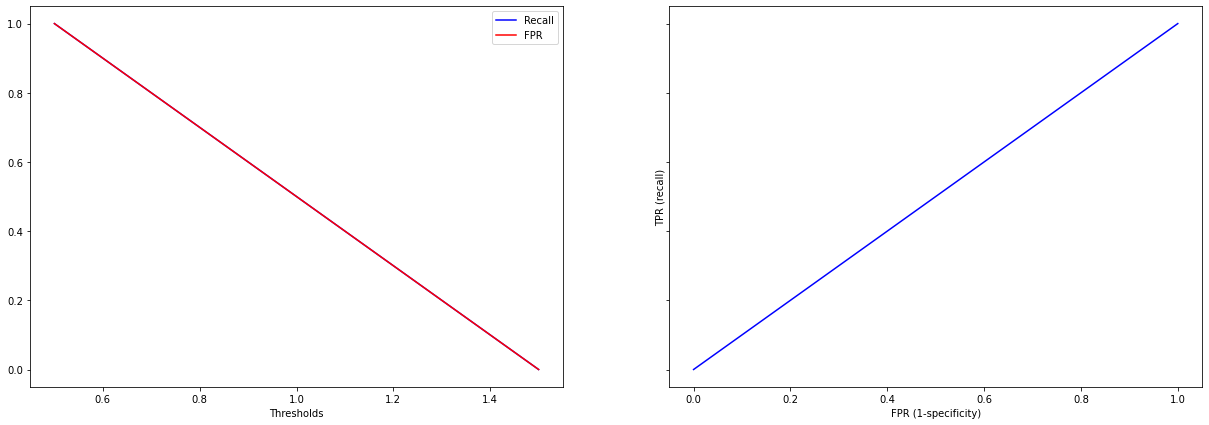

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000134     0.0        0.0          0.0  0.0      0.0
Validation  0.001203     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


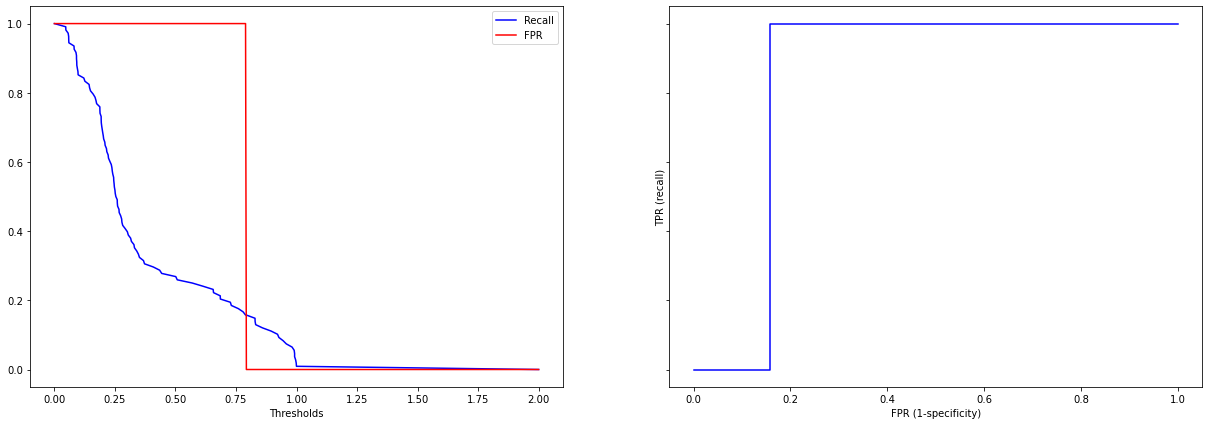

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662541  0.515678   0.730163     0.809331  0.604349  0.713027
Validation  0.661740  0.511384   0.728980     0.812844  0.598112  0.715154

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005939  0.010884   0.011328     0.012522  0.007796  0.008697
Validation  0.057623  0.100101   0.069483     0.048198  0.093368  0.044340

Random Forest (100 estimators)
╠■■■■■■■■■╣


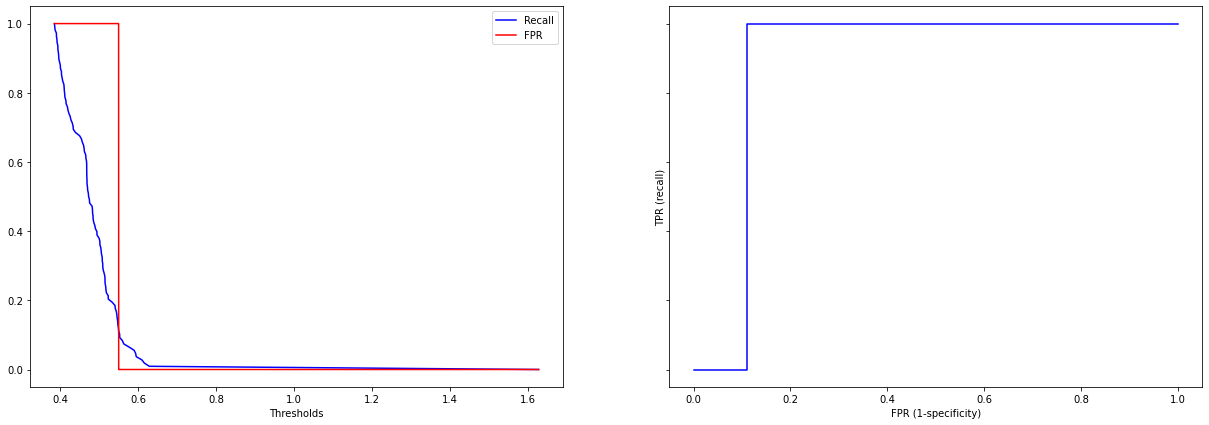

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663555  0.523999   0.727092     0.803043  0.608824  0.726696
Validation  0.654455  0.512202   0.714281     0.797248  0.593098  0.706859

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007218  0.016433   0.013885     0.017263  0.010510  0.006509
Validation  0.049349  0.102372   0.044036     0.034988  0.081889  0.054287

XGBoost Classifier
╠■■■■■■■■■╣


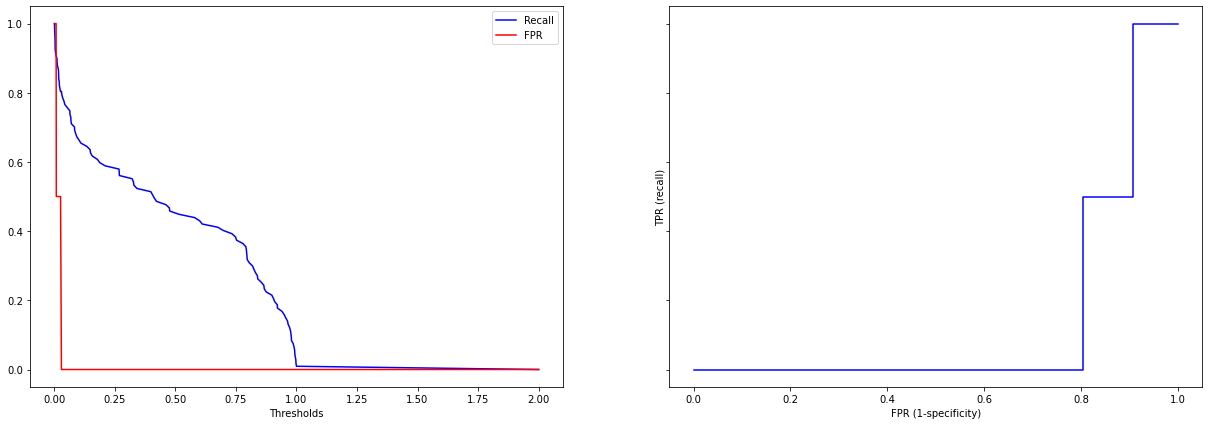

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999797  0.999696   0.999899     0.999899  0.999797  1.000000
Validation  0.621937  0.600884   0.628736     0.643119  0.612922  0.672184

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000262  0.000490   0.000321     0.000321  0.000262  2.486825e-07
Validation  0.037088  0.070811   0.039702     0.051979  0.047648  4.556005e-02

SVM
╠■■■■■■■■■╣


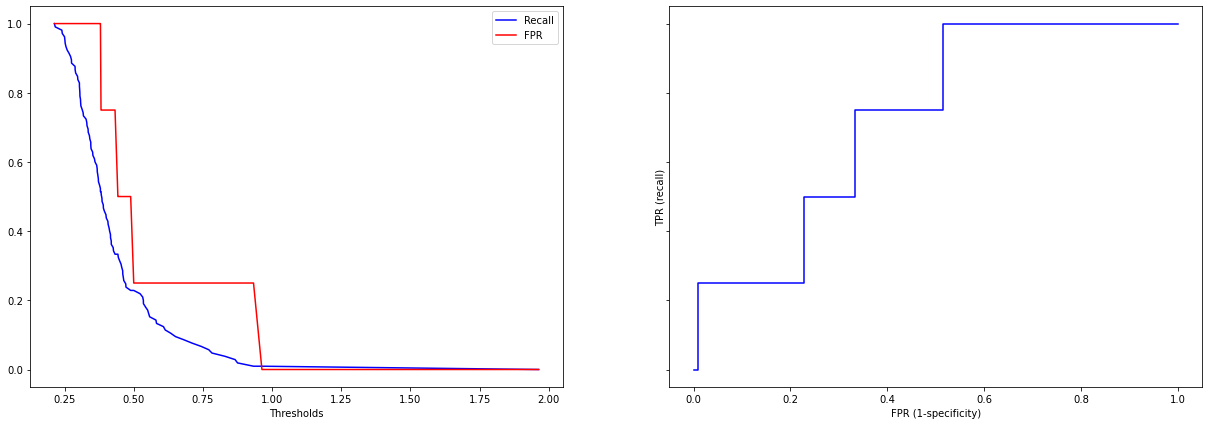

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673498  0.492444   0.771810     0.854462  0.601134  0.743230
Validation  0.673204  0.491284   0.768731     0.855963  0.596167  0.741959

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007856  0.016095   0.009564     0.007989  0.013269  0.007412
Validation  0.054527  0.101816   0.051942     0.025236  0.092741  0.041736

KNN
╠■■■■■■■■■╣


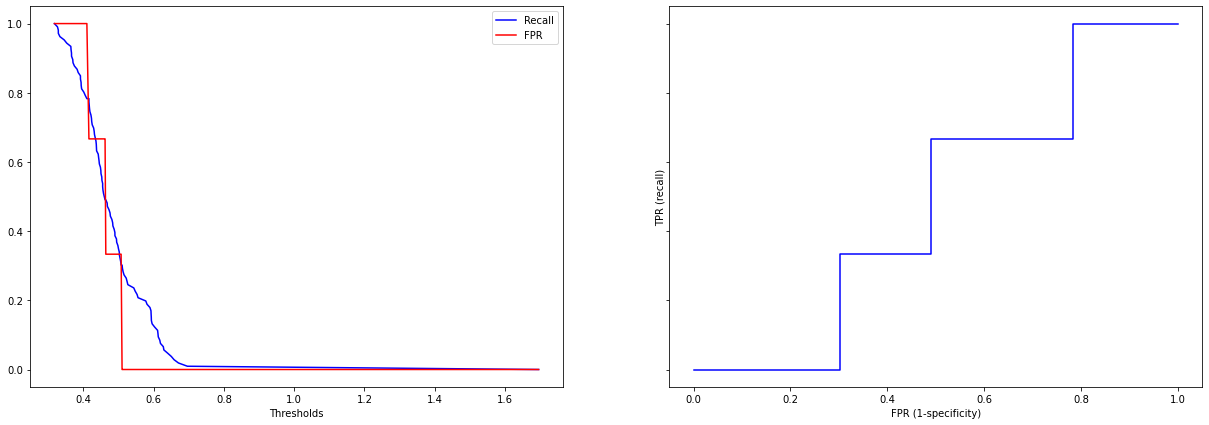

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999696  0.999391   1.000000     1.000000  0.999695  0.999999
Validation  0.566577  0.483837   0.582122     0.649541  0.525469  0.604788

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000428  0.000856   0.000000     0.000000  0.000428  8.407004e-07
Validation  0.034194  0.082382   0.043403     0.072342  0.052929  4.184999e-02

Logistic Regression
╠■■■■■■■■■╣


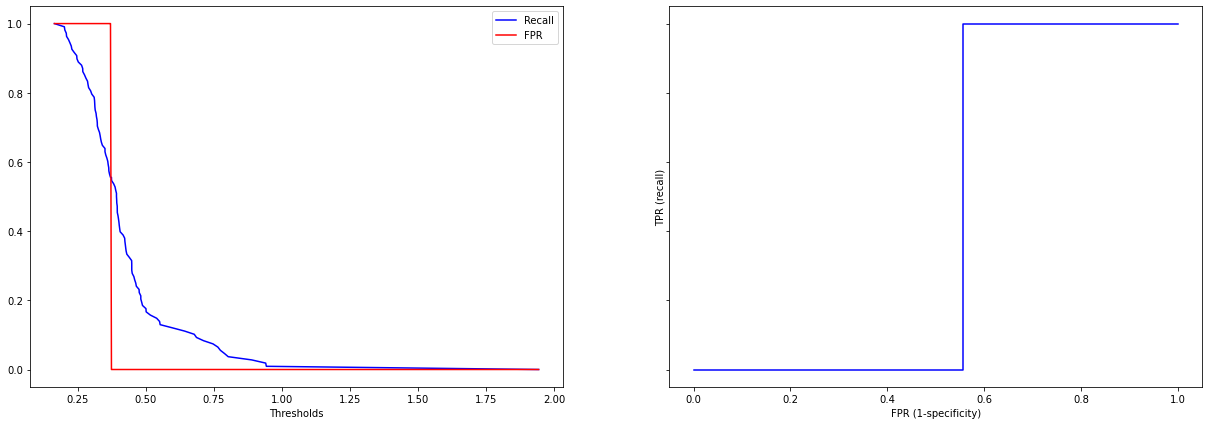

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675272  0.557176   0.729467     0.793306  0.631631  0.736771
Validation  0.670470  0.543436   0.730989     0.798165  0.620261  0.717816

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004609  0.015350   0.007442     0.011826  0.008896  0.005238
Validation  0.053920  0.091045   0.067701     0.059926  0.074331  0.057997

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.661740  0.511384   0.728980     0.812844   
Random Forest (100 estimators)  0.654455  0.512202   0.714281     0.797248   
XGBoost Classifier              0.621937  0.600884   0.628736     0.643119   
SVM                             0.673204  0.491284   0.768731     0.855963   
KNN                             0.566577  0.483837   0.582122     0.649541   
Logistic Regression             0.670470  0.543436   0.730989     0.798165   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.598112  0.715154  
Random Forest (100 estimators)  0.593098  0.706859  
XGBoost Classifier              0.612922  0.672184  
SVM                             0.596167  0.741959  
KNN                             0.525469  0.604788  
Logistic Regression             0.620261  0.717816

Accuracy  \
Dummy Random                    0.4980974124809741-0.49961948249619487   
MultinomialNB                    0.6252959809429632-0.6981843927322076   
Random Forest (100 estimators)    0.623244226845449-0.6856661665188843   
XGBoost Classifier               0.5984802639466175-0.6453930551434918   
SVM                              0.6387179618315314-0.7076898132930968   
KNN                              0.5449501011558074-0.5882030972858162   
Logistic Regression              0.6363686237504208-0.7045722668699971   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.44807498086483655-0.5746939932802844   
Random Forest (100 estimators)  0.44745579791299334-0.5769478718117773   
XGBoost Classifier               0.5560992534136935-0.6456688867030704   
SVM                               0.4268900625661325-0.555678744773317   
KNN                               0.431733477808876-0.5359395830751941   
Logistic Regression              0.4858543314253072-0.6010180622360775   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6850351666755425-0.7729244178531478   
Random Forest (100 estimators)  0.6864294883321247-0.7421315305462504   
XGBoost Classifier              0.6036256088105478-0.6538454816046975   
SVM                              0.735879974388379-0.8015821186883472   
KNN                             0.5546708592929347-0.6095722060597623   
Logistic Regression             0.6881714152502264-0.7738074519752914   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7823610133470896-0.8433270600474058   
Random Forest (100 estimators)  0.7751192018163603-0.8193762110276767   
XGBoost Classifier              0.6102450039134514-0.6759935281966402   
SVM                             0.8400024607330887-0.8719241447714983   
KNN                             0.6037881242586788-0.6952944445486607   
Logistic Regression               0.76026438315638-0.8360658920729778   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5390607521721246-0.6571632167840816   
Random Forest (100 estimators)   0.5413068770151565-0.6448897292635732   
XGBoost Classifier                0.5827866102593693-0.643056994057156   
SVM                              0.5375125986213625-0.6548216097079815   
KNN                             0.49199361636702976-0.5589440255932838   
Logistic Regression              0.5732498738377628-0.6672715446015535   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6871112520155802-0.7431973384764965  
Random Forest (100 estimators)  0.6725246806394859-0.7411932494398618  
XGBoost Classifier               0.6433696810547178-0.700999097208514  
SVM                             0.7155623214534943-0.7683548572351682  
KNN                             0.5783198294686902-0.6312563463965186  
Logistic Regression             0.6811349961607364-0.7544960725433062

In [102]:
#ra_symptoms_vitals
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


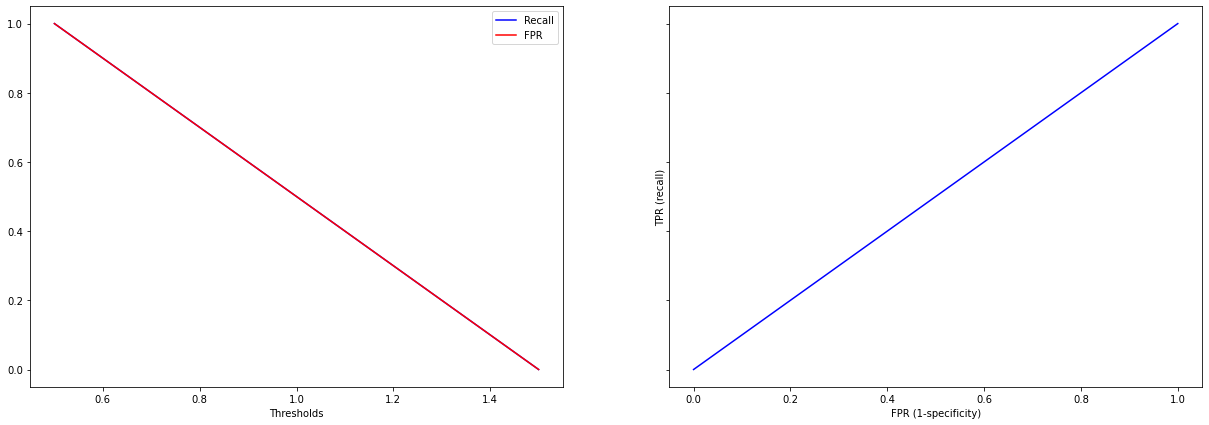

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000134     0.0        0.0          0.0  0.0      0.0
Validation  0.001203     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


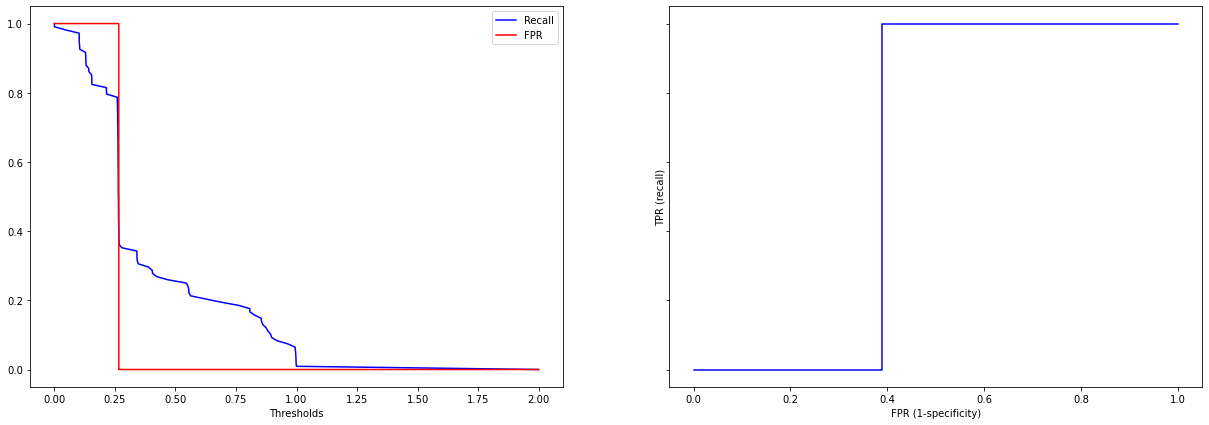

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.651585  0.493455   0.721720     0.809635  0.586090  0.681441
Validation  0.650800  0.487665   0.720813     0.814679  0.579394  0.680048

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008969  0.008569   0.015724     0.013947  0.009511  0.012489
Validation  0.057102  0.096602   0.080038     0.040060  0.092305  0.054770

Random Forest (100 estimators)
╠■■■■■■■■■╣


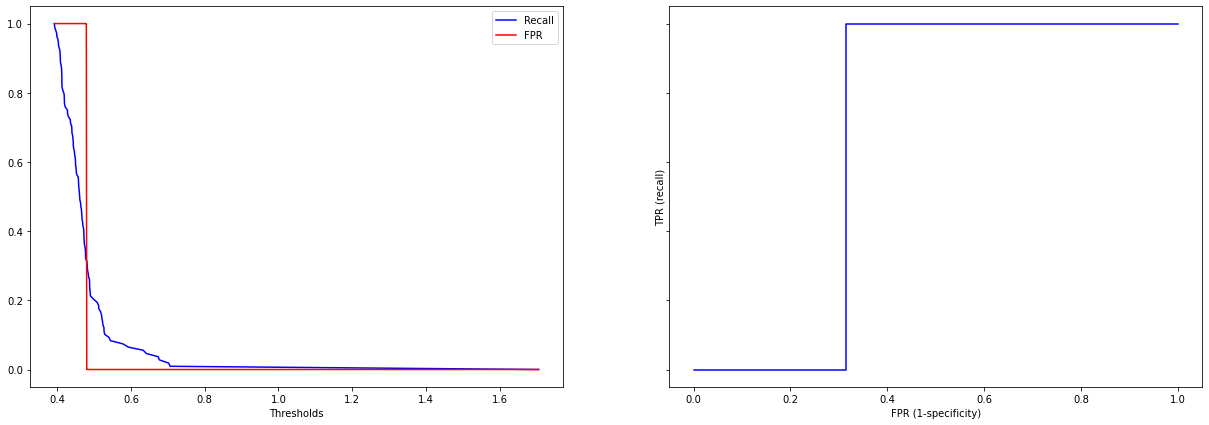

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662743  0.523895   0.726509     0.801521  0.608110  0.721694
Validation  0.648930  0.510409   0.702094     0.788073  0.586638  0.696520

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007658  0.022616   0.023071     0.030192  0.010675  0.006338
Validation  0.057065  0.120180   0.057712     0.037065  0.097829  0.061407

XGBoost Classifier
╠■■■■■■■■■╣


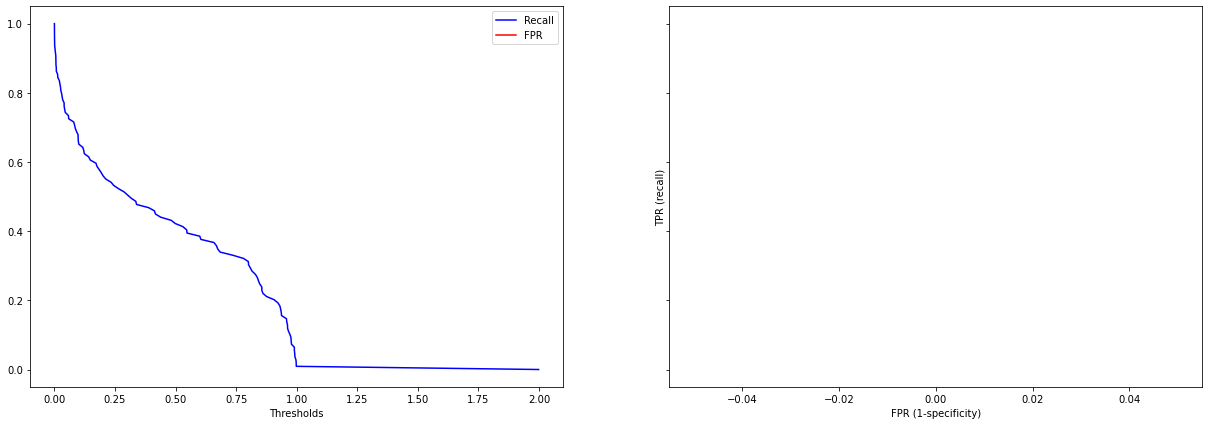

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999645  0.999391   0.999898     0.999899  0.999645  1.000000
Validation  0.628401  0.596339   0.640512     0.660550  0.616167  0.681736

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000418  0.000709   0.000321     0.000321  0.000418  6.443568e-07
Validation  0.037636  0.053460   0.044310     0.065874  0.038481  5.597192e-02

SVM
╠■■■■■■■■■╣


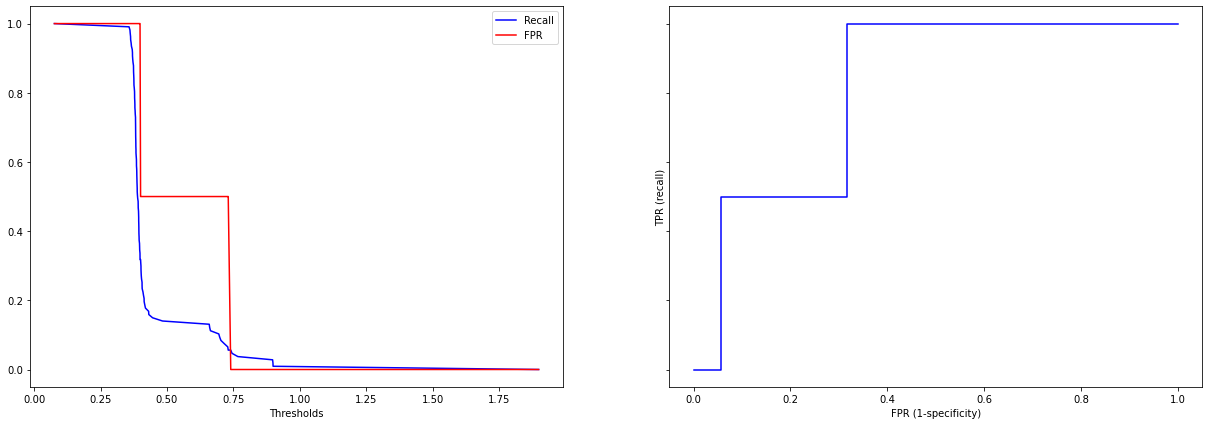

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669794  0.477826   0.775781     0.861663  0.591117  0.740595
Validation  0.662235  0.468465   0.761573     0.856881  0.576782  0.731375

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006595  0.018246   0.013462     0.013949  0.012708  0.008737
Validation  0.050739  0.098654   0.048489     0.020377  0.089373  0.038379

KNN
╠■■■■■■■■■╣


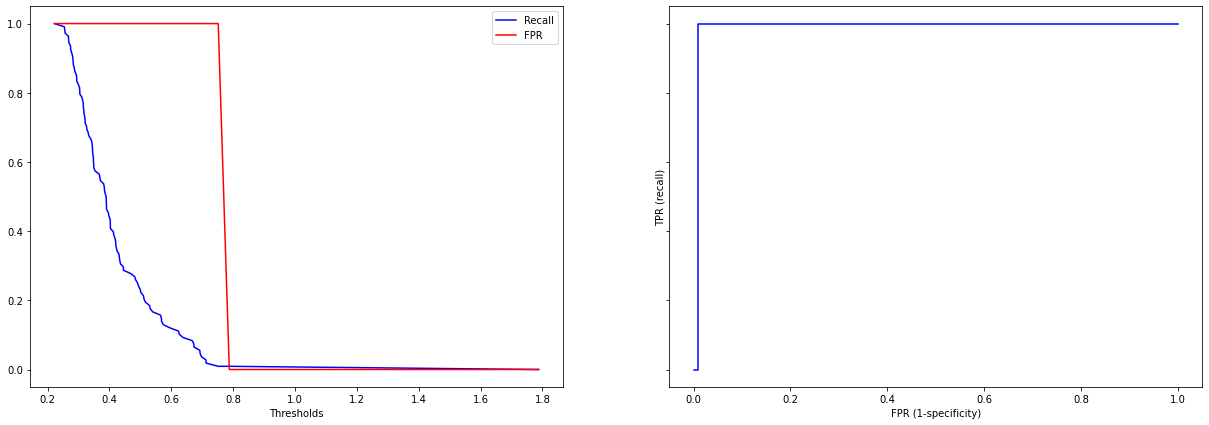

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.999899  0.999797   1.000000          1.0  0.999899  1.00000
Validation  0.645344  0.491318   0.706663          0.8  0.577928  0.69035

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000214  0.000428   0.000000     0.000000  0.000214  2.168477e-07
Validation  0.066062  0.100215   0.083138     0.045111  0.094758  6.078991e-02

Logistic Regression
╠■■■■■■■■■╣


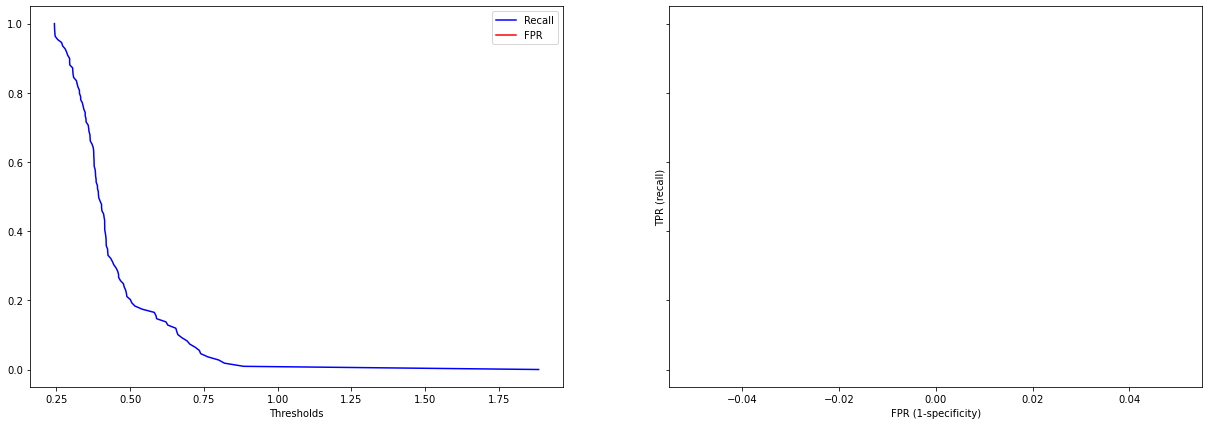

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682019  0.548350   0.748365     0.815619  0.632807  0.742415
Validation  0.679180  0.529666   0.755688     0.829358  0.620701  0.735538

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008007  0.015797   0.010768     0.011056  0.011708  0.008788
Validation  0.049159  0.084972   0.059423     0.041074  0.072211  0.049102

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.650800  0.487665   0.720813     0.814679   
Random Forest (100 estimators)  0.648930  0.510409   0.702094     0.788073   
XGBoost Classifier              0.628401  0.596339   0.640512     0.660550   
SVM                             0.662235  0.468465   0.761573     0.856881   
KNN                             0.645344  0.491318   0.706663     0.800000   
Logistic Regression             0.679180  0.529666   0.755688     0.829358   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.579394  0.680048  
Random Forest (100 estimators)  0.586638  0.696520  
XGBoost Classifier              0.616167  0.681736  
SVM                             0.576782  0.731375  
KNN                             0.577928  0.690350  
Logistic Regression             0.620701  0.735538

Accuracy  \
Dummy Random                    0.4980974124809741-0.49961948249619487   
MultinomialNB                    0.6146857704033374-0.6869144977044083   
Random Forest (100 estimators)   0.6128385294591558-0.6850207977579694   
XGBoost Classifier               0.6045972114246336-0.6522039280332861   
SVM                              0.6301446353674491-0.6943243856203607   
KNN                              0.6035622705541047-0.6871251744628614   
Logistic Regression              0.6480889833445296-0.7102705323858547   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4265681172875587-0.5487613239134421   
Random Forest (100 estimators)   0.4343999305341939-0.5864174172556311   
XGBoost Classifier               0.5625275411570922-0.6301496898687626   
SVM                             0.40607096170990326-0.5308598139364687   
KNN                              0.4279361387080575-0.5546993908999494   
Logistic Regression             0.47592539080647883-0.5834073865079499   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6701922440796197-0.7714332395016654   
Random Forest (100 estimators)  0.6655934725854377-0.7385944576396283   
XGBoost Classifier              0.6124882231739253-0.6685367272448113   
SVM                             0.7309059566028923-0.7922405897108208   
KNN                             0.6540819109214714-0.7592446753932073   
Logistic Regression             0.7181057579115636-0.7932701082970465   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7893427337281859-0.8400150644369516   
Random Forest (100 estimators)  0.7646314765789153-0.8115153124119105   
XGBoost Classifier              0.6188883513983451-0.7022125660328474   
SVM                             0.8439930840943696-0.8697683837955384   
KNN                             0.7714693485267509-0.8285306514732492   
Logistic Regression             0.8033801093803116-0.8553354869499638   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5210149878071554-0.6377729898591623   
Random Forest (100 estimators)  0.5247659189702881-0.6485103375733149   
XGBoost Classifier              0.5918290818347088-0.6405045913545858   
SVM                             0.5202576070530958-0.6333065308187114   
KNN                              0.5179980217634853-0.637858204341576   
Logistic Regression             0.5750303138998085-0.6663706893837016   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6454085543578943-0.7146877032267903  
Random Forest (100 estimators)  0.6576827635677853-0.7353575376006194  
XGBoost Classifier              0.6463360222480924-0.7171355251423172  
SVM                             0.7071019693782171-0.7556481817415998  
KNN                             0.6519029173634782-0.7287967482600156  
Logistic Regression              0.704482802413363-0.7665923290034903

In [103]:
#ra_symptoms_nvitals
run_models(ra_symptoms_nvitals, y[ra_symptoms_nvitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


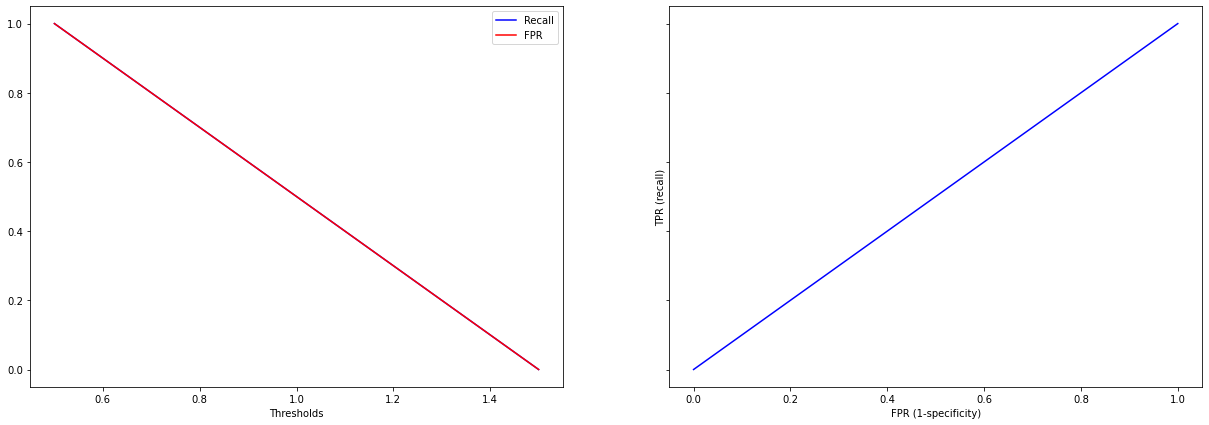

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000134     0.0        0.0          0.0  0.0      0.0
Validation  0.001203     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


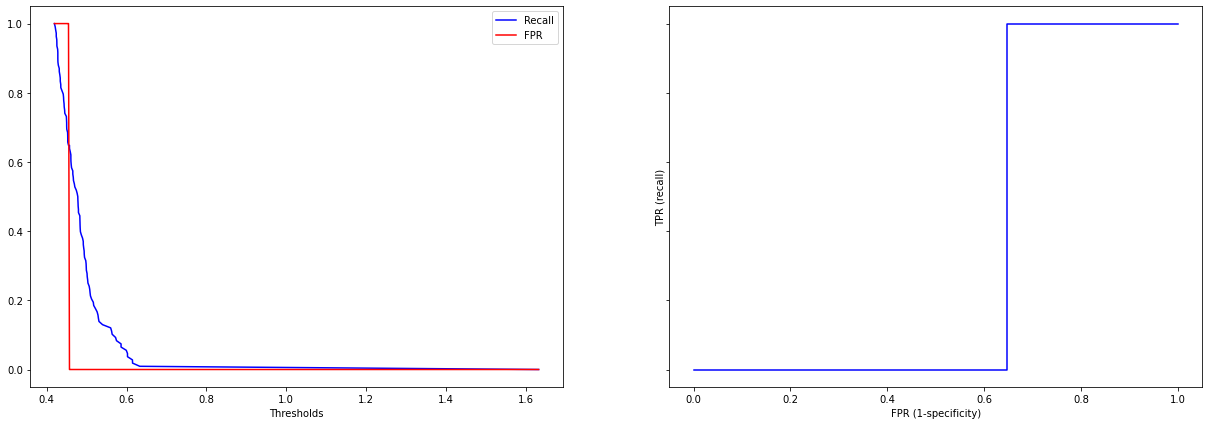

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662795  0.521258   0.727031      0.80426  0.607034  0.722603
Validation  0.655347  0.511318   0.713319      0.80000  0.592015  0.699145

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006414  0.015585   0.009265     0.011464  0.010794  0.007892
Validation  0.060072  0.116670   0.057621     0.027284  0.098586  0.062972

XGBoost Classifier
╠■■■■■■■■■╣


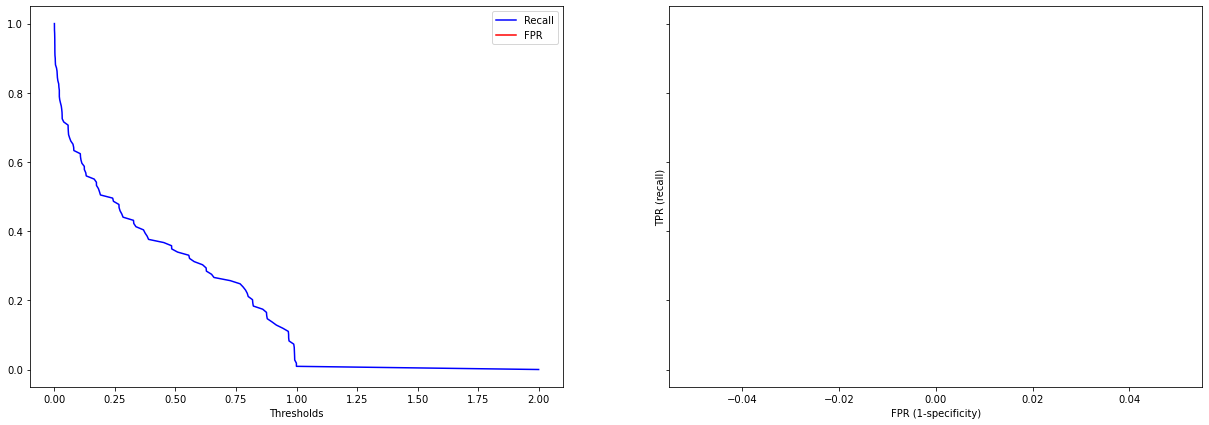

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999797  0.999696   0.999899     0.999899  0.999797  1.000000
Validation  0.612362  0.599033   0.617564     0.625688  0.607042  0.668428

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000262  0.000490   0.000321     0.000321  0.000262  2.657854e-07
Validation  0.043107  0.059045   0.045299     0.064118  0.046522  4.979988e-02

SVM
╠■■■■■■■■■╣


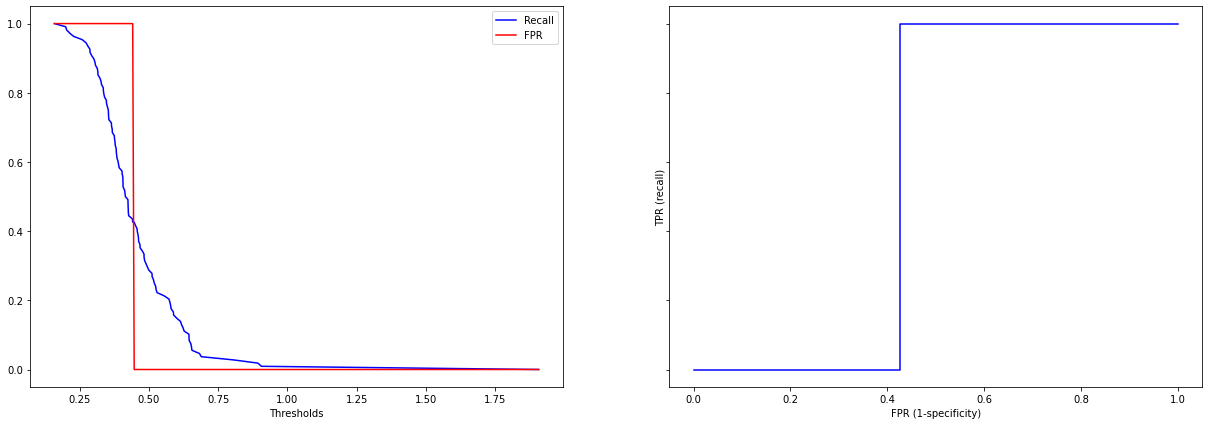

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675729  0.493455   0.776744     0.857911  0.603237  0.747508
Validation  0.674151  0.485813   0.776200     0.863303  0.593073  0.735776

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006025  0.017440   0.013398     0.013786  0.011669  0.007291
Validation  0.060264  0.113675   0.058511     0.033902  0.100308  0.055091

KNN
╠■■■■■■■■■╣


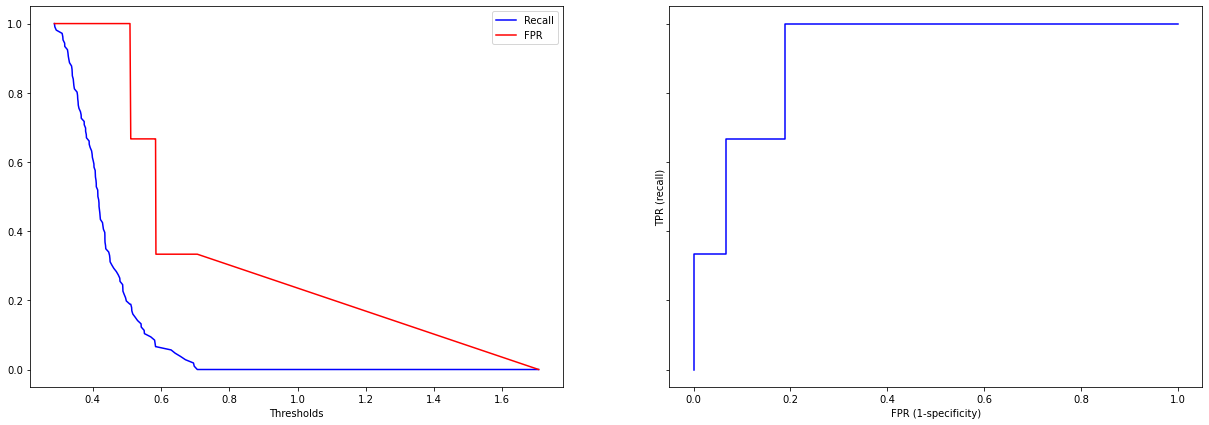

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999696   1.000000     1.000000  0.999848  1.000000
Validation  0.623765  0.406339   0.721635     0.842202  0.514320  0.687024

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000342  0.000685   0.000000      0.00000  0.000343  6.528210e-07
Validation  0.044222  0.099124   0.059481      0.04694  0.084159  4.801384e-02

Logistic Regression
╠■■■■■■■■■╣


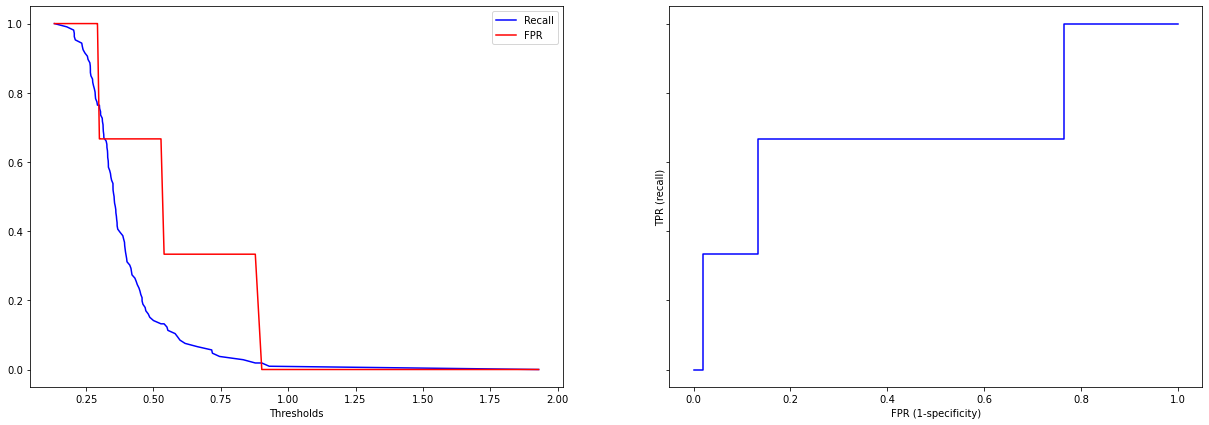

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685215  0.580318   0.734505     0.790061  0.648204  0.748460
Validation  0.670896  0.562460   0.717828     0.779817  0.629825  0.731056

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009272  0.015847   0.014529     0.016596  0.011303  0.008417
Validation  0.052827  0.076584   0.057276     0.040339  0.066980  0.048477

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.655347  0.511318   0.713319     0.800000   
XGBoost Classifier              0.612362  0.599033   0.617564     0.625688   
SVM                             0.674151  0.485813   0.776200     0.863303   
KNN                             0.623765  0.406339   0.721635     0.842202   
Logistic Regression             0.670896  0.562460   0.717828     0.779817   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.592015  0.699145  
XGBoost Classifier              0.607042  0.668428  
SVM                             0.593073  0.735776  
KNN                             0.514320  0.687024  
Logistic Regression             0.629825  0.731056

Accuracy  \
Dummy Random                    0.4980974124809741-0.49961948249619487   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6173545279950275-0.6933404575522893   
XGBoost Classifier               0.5850991797570396-0.6396253814259857   
SVM                              0.6360363624774965-0.7122649236018466   
KNN                              0.5957965389689795-0.6517339373411876   
Logistic Regression              0.6374847188830799-0.7043065759935485   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.4375289191326818-0.585106610475325   
XGBoost Classifier              0.5616889364242219-0.6363761177876213   
SVM                             0.4139190541024029-0.5577073011936771   
KNN                             0.3436468392331002-0.4690303917927547   
Logistic Regression             0.5140244700784702-0.6108962972276182   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6768765192724924-0.7497619260432287   
XGBoost Classifier               0.5889146624900686-0.646214289632227   
SVM                             0.7391945720160982-0.8132062794498367   
KNN                             0.6840158750741288-0.7592544800962382   
Logistic Regression             0.6816030887957102-0.7540526242282269   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.7827440538475036-0.8172559461524965   
XGBoost Classifier               0.5851361848214048-0.666239961967586   
SVM                             0.8418611031890421-0.8847444013981139   
KNN                              0.8125145905822346-0.871889079142536   
Logistic Regression             0.7543037876273834-0.8053292398955526   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5296633757795252-0.6543664542101687   
XGBoost Classifier               0.5776191908432592-0.6364657412780764   
SVM                              0.5296325963278341-0.6565127624986191   
KNN                             0.46109310873938986-0.5675466792226175   
Logistic Regression              0.5874628044623779-0.6721866402225009   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6593180504417201-0.7389720383937776  
XGBoost Classifier              0.6369319918478981-0.6999244098936145  
SVM                             0.7009338064604373-0.7706187870616872  
KNN                             0.6566569719193026-0.7173902080701381  
Logistic Regression             0.7003969289854932-0.7617156877976059

In [104]:
#ra_symptoms_svitals
run_models(ra_symptoms_svitals, y[ra_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

All the features that were determined to be important before are also important here

Dummy Random
╠■■■■■■■■■╣


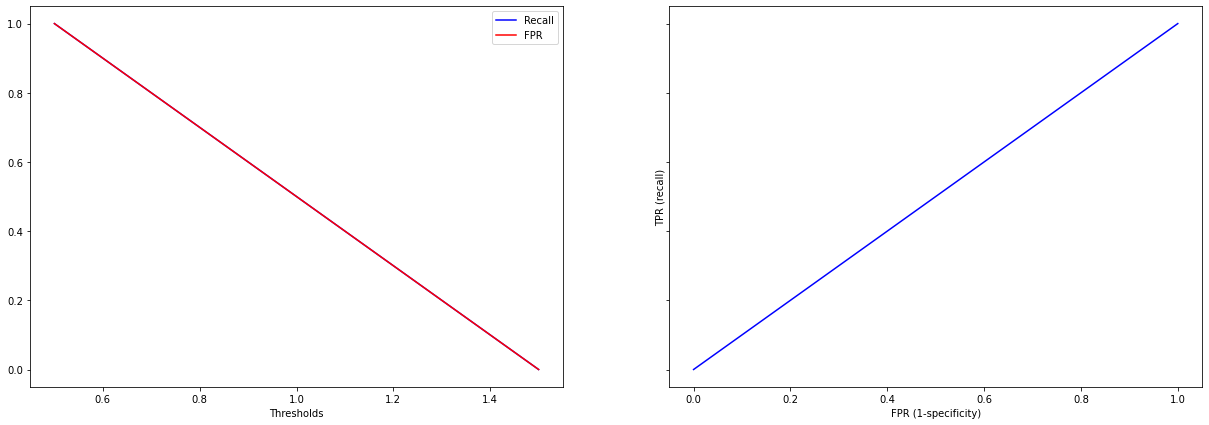

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000134     0.0        0.0          0.0  0.0      0.0
Validation  0.001203     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


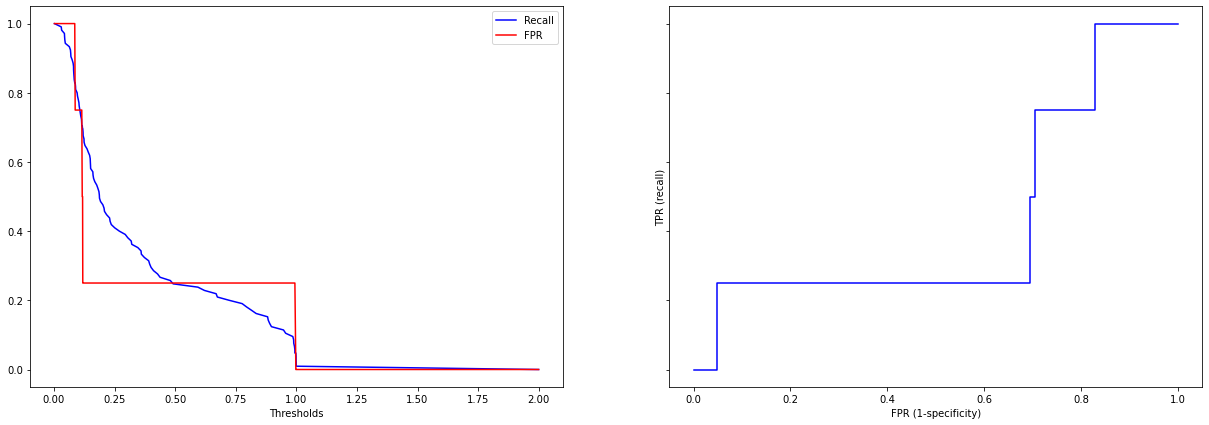

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664419  0.516794   0.733368     0.811968  0.606252  0.715782
Validation  0.653552  0.512310   0.709123     0.795413  0.591569  0.710475

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009850  0.009398   0.017096     0.015278  0.010353  0.009279
Validation  0.052773  0.109357   0.048965     0.015013  0.093431  0.045261

Random Forest (100 estimators)
╠■■■■■■■■■╣


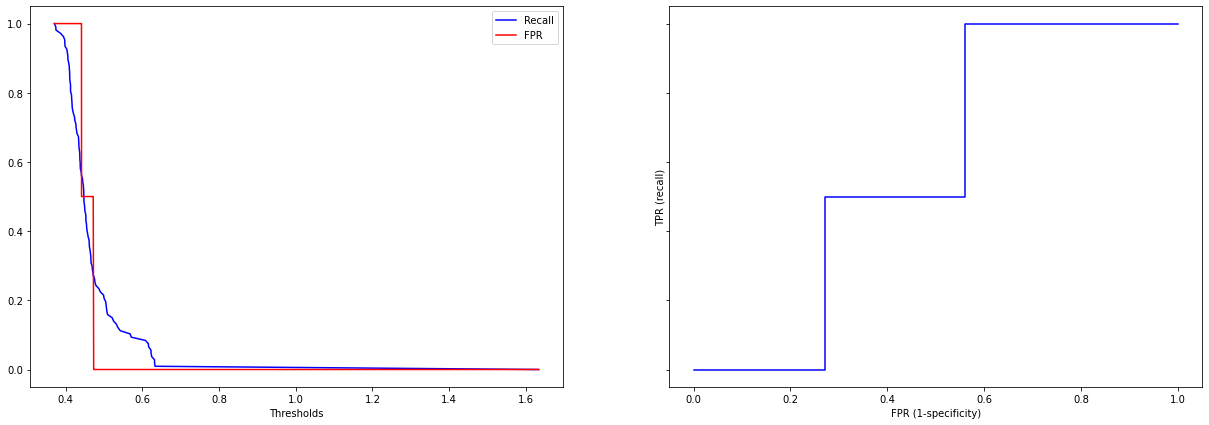

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666802  0.536777   0.725918     0.796755  0.616715  0.729650
Validation  0.658552  0.526839   0.714477     0.790826  0.602748  0.718971

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005223  0.022932   0.014185     0.022144  0.011724  0.006675
Validation  0.047015  0.102071   0.042958     0.040983  0.079438  0.049160

XGBoost Classifier
╠■■■■■■■■■╣


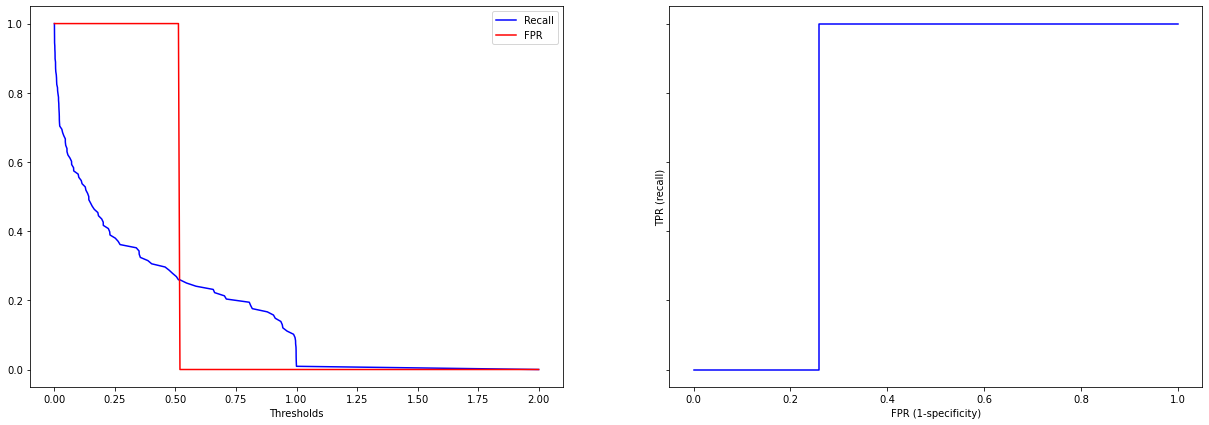

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999797   1.000000     1.000000  0.999898  1.000000
Validation  0.611441  0.607239   0.612626     0.615596  0.609282  0.667775

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000214  0.000428   0.000000     0.000000  0.000214  2.169579e-07
Validation  0.036073  0.062842   0.032679     0.032205  0.045117  3.960809e-02

SVM
╠■■■■■■■■■╣


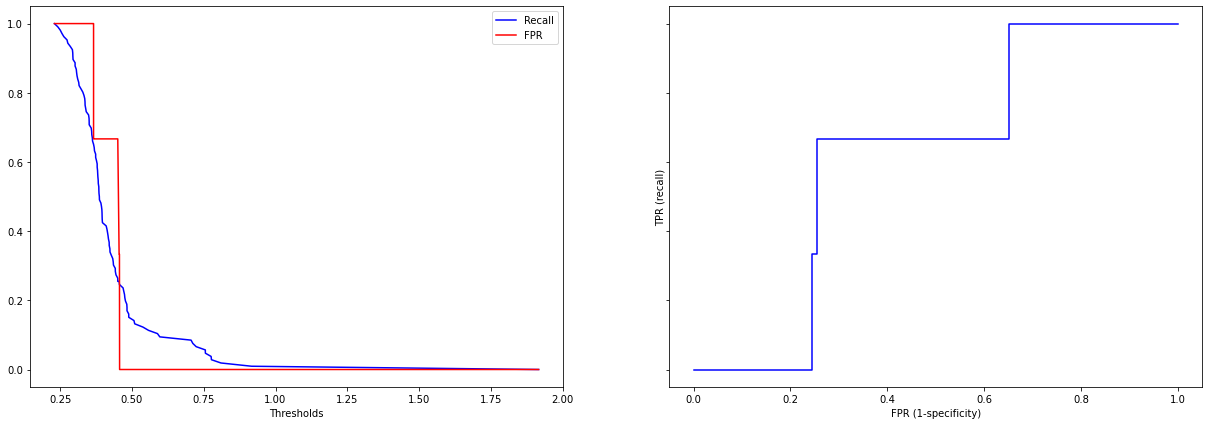

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679381  0.507660   0.774037     0.851014  0.612277  0.751852
Validation  0.660860  0.490392   0.740735     0.832110  0.585957  0.726500

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008132  0.033451   0.016458     0.022191  0.020516  0.007463
Validation  0.061362  0.112403   0.059242     0.038694  0.100464  0.052439

KNN
╠■■■■■■■■■╣


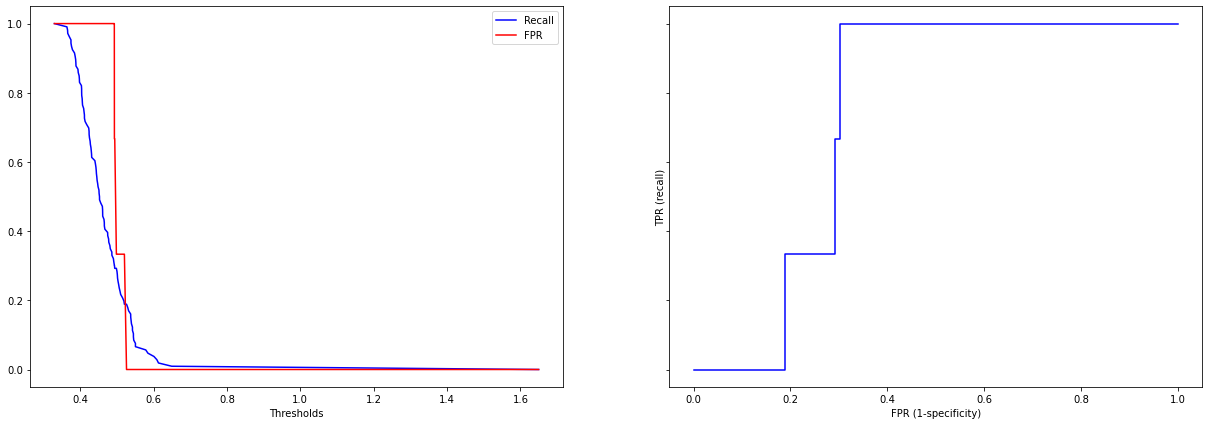

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999797   1.000000     1.000000  0.999898  1.000000
Validation  0.580305  0.499500   0.597361     0.661468  0.542434  0.623153

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000321  0.000641   0.000000     0.000000  0.000321  6.505432e-07
Validation  0.027461  0.061578   0.031635     0.049396  0.043454  3.901416e-02

Logistic Regression
╠■■■■■■■■■╣


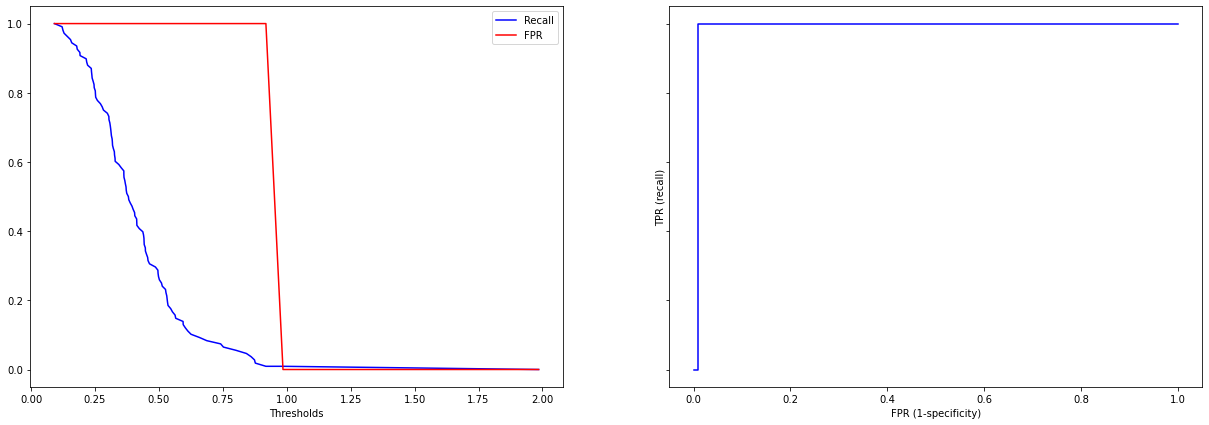

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673548  0.575138   0.716183     0.771907  0.637872  0.741107
Validation  0.662230  0.557932   0.705093     0.766972  0.620537  0.728114

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009194  0.009118   0.015148     0.016592  0.008726  0.008150
Validation  0.044300  0.086520   0.043493     0.043075  0.067743  0.038782

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.653552  0.512310   0.709123     0.795413   
Random Forest (100 estimators)  0.658552  0.526839   0.714477     0.790826   
XGBoost Classifier              0.611441  0.607239   0.612626     0.615596   
SVM                             0.660860  0.490392   0.740735     0.832110   
KNN                             0.580305  0.499500   0.597361     0.661468   
Logistic Regression             0.662230  0.557932   0.705093     0.766972   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.591569  0.710475  
Random Forest (100 estimators)  0.602748  0.718971  
XGBoost Classifier              0.609282  0.667775  
SVM                             0.585957  0.726500  
KNN                             0.542434  0.623153  
Logistic Regression             0.620537  0.728114

Accuracy  \
Dummy Random                    0.4980974124809741-0.49961948249619487   
MultinomialNB                    0.6201760875162627-0.6869287677474465   
Random Forest (100 estimators)   0.6288170358357469-0.6882874005096092   
XGBoost Classifier               0.5886263863790325-0.6342549340516156   
SVM                              0.6220515522858687-0.6996693643074874   
KNN                              0.5629364892318122-0.5976726180531781   
Logistic Regression               0.634212681181155-0.6902479614395984   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.44314699481038644-0.5814735222871951   
Random Forest (100 estimators)  0.46228353853433424-0.5913945265198777   
XGBoost Classifier               0.5674946945646391-0.6469840377122584   
SVM                             0.41930194714184954-0.5614820395136968   
KNN                              0.46055416766925206-0.538444998302391   
Logistic Regression               0.5032112798680239-0.612651939481434   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6781542120343889-0.7400910847644937   
Random Forest (100 estimators)  0.6873081771920002-0.7416460881185019   
XGBoost Classifier               0.5919578525576531-0.633293979107508   
SVM                             0.7032674555348267-0.7782031480434196   
KNN                              0.5773538609032111-0.617368811085086   
Logistic Regression             0.6775858038369339-0.7326011952517636   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7859179359655903-0.8049077521078045   
Random Forest (100 estimators)  0.7649056634857285-0.8167457126610609   
XGBoost Classifier              0.5952283476387197-0.6359643129117392   
SVM                             0.8076376158730979-0.8565825676131408   
KNN                              0.630227295928753-0.6927084838877605   
Logistic Regression             0.7397295933317185-0.7942153607967217   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5324781113325383-0.6506602696828996   
Random Forest (100 estimators)  0.5525069572967114-0.6529886290750586   
XGBoost Classifier              0.5807476094353645-0.6378161445436996   
SVM                             0.5224184865849839-0.6494962253574696   
KNN                             0.5149517886694631-0.5699171267413906   
Logistic Regression             0.5776923873634827-0.6633808771572625   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6818491294359312-0.7391003621128367  
Random Forest (100 estimators)  0.6878794500424641-0.7500627188903621  
XGBoost Classifier                0.6427249296962707-0.69282564379387  
SVM                             0.6933352104986131-0.7596654551937453  
KNN                             0.5984786682391071-0.6478281164668022  
Logistic Regression              0.7035864372670617-0.752642530297652

In [105]:
#ra_symptoms_vitals_ex
run_models(ra_symptoms_vitals_ex, y[ra_symptoms_vitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


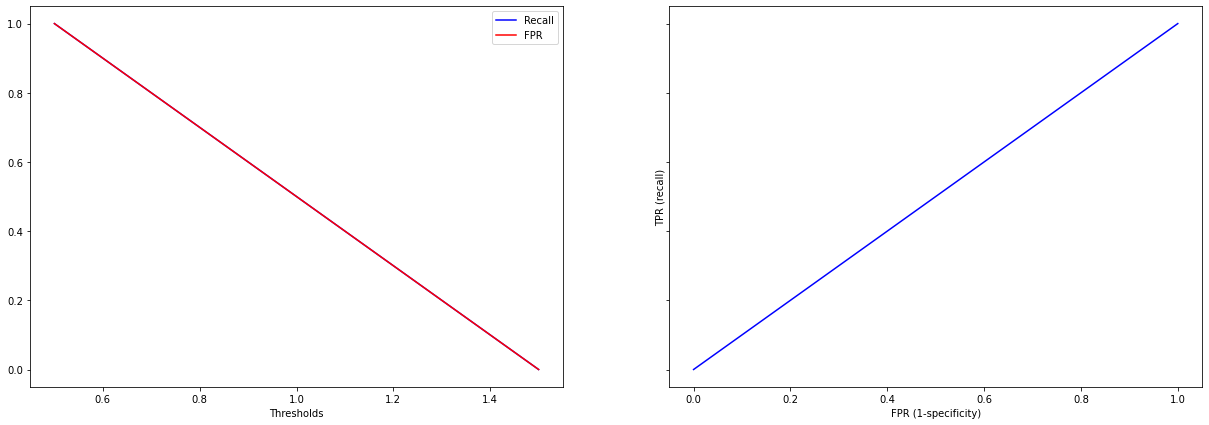

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


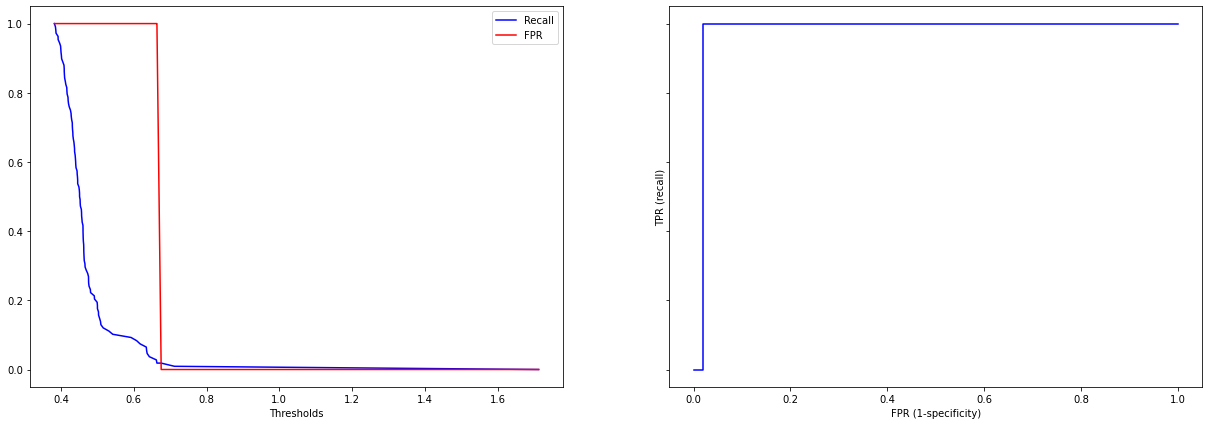

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667374  0.528258   0.731787     0.806364  0.613468  0.730900
Validation  0.659216  0.505947   0.726060     0.813761  0.593130  0.710859

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005497  0.011629   0.010779     0.012362  0.007629  0.005912
Validation  0.057132  0.110361   0.051836     0.017326  0.094604  0.058006

XGBoost Classifier
╠■■■■■■■■■╣


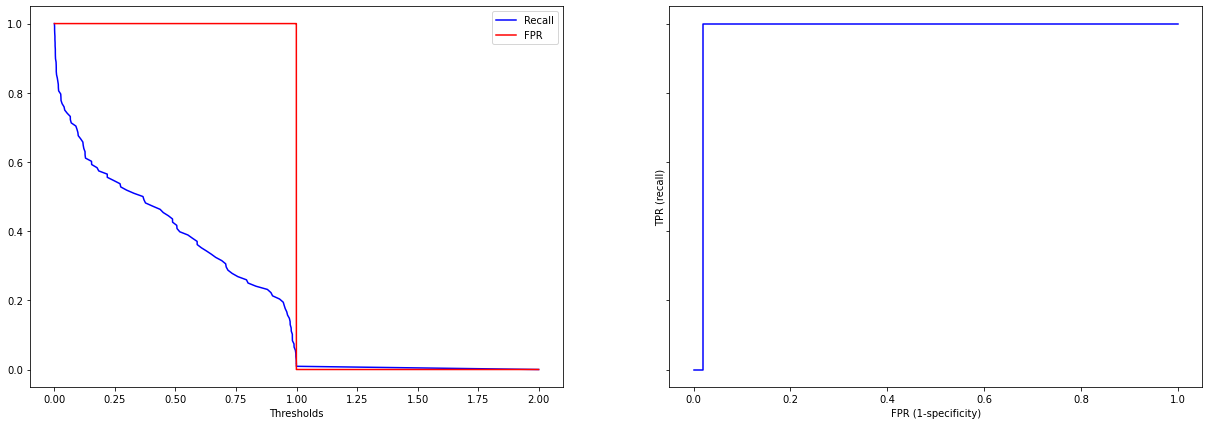

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999798   1.000000     1.000000  0.999899  1.000000
Validation  0.627230  0.606906   0.633878     0.647706  0.619506  0.679077

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000213  0.000426   0.000000     0.000000  0.000213  2.152078e-07
Validation  0.037757  0.060787   0.035541     0.033276  0.046255  4.938225e-02

SVM
╠■■■■■■■■■╣


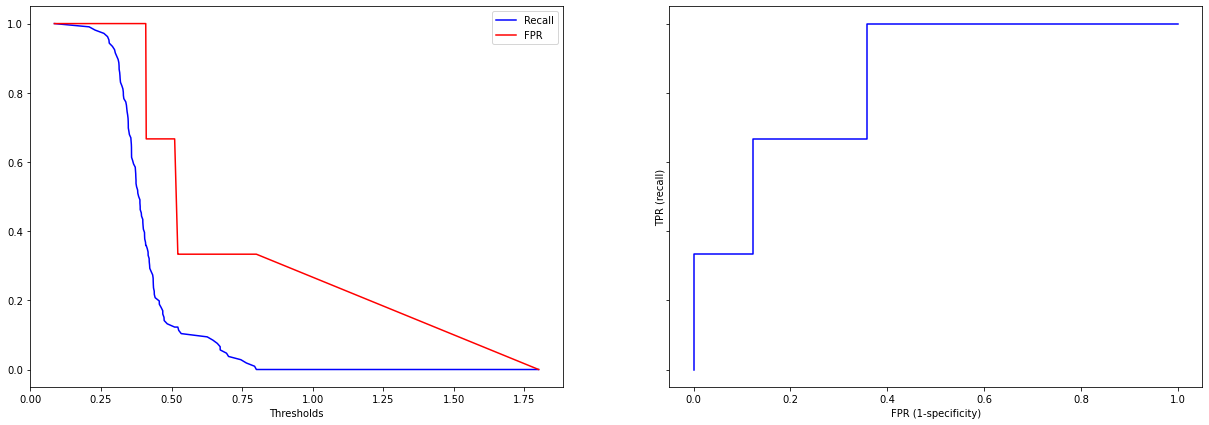

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675458  0.497321   0.773474     0.853434  0.604792  0.748034
Validation  0.667446  0.485029   0.764717     0.851376  0.587969  0.727952

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006630  0.021796   0.022233     0.025077  0.011853  0.006989
Validation  0.046179  0.110983   0.032251     0.030212  0.088217  0.029881

KNN
╠■■■■■■■■■╣


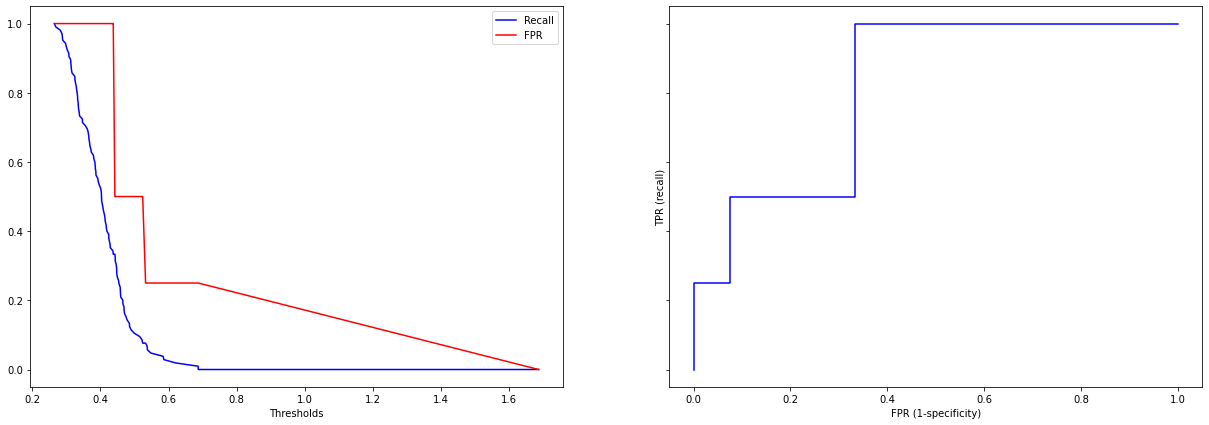

feature_importances


Permutation Importance



Mean metrics


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training     1.00000  1.00000   1.000000     1.000000  1.000000  1.000000
Validation   0.62312  0.41402   0.711059     0.833945  0.521423  0.677553

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000000  0.000000   0.000000     0.000000  0.000000  0.000000
Validation  0.048867  0.082493   0.061479     0.028834  0.079381  0.054884

Logistic Regression
╠■■■■■■■■■╣


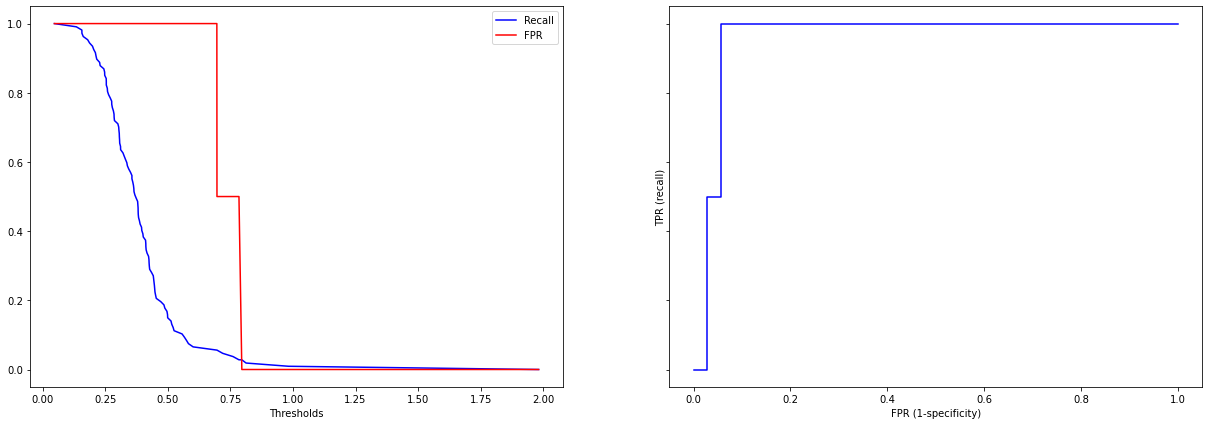

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690870  0.590941   0.738310     0.790707  0.656381  0.755246
Validation  0.681138  0.572385   0.734322     0.790826  0.641753  0.734864

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009177  0.015072   0.010629     0.010277  0.011915  0.006158
Validation  0.036146  0.065808   0.038845     0.039353  0.048471  0.036993

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.659216  0.505947   0.726060     0.813761   
XGBoost Classifier              0.627230  0.606906   0.633878     0.647706   
SVM                             0.667446  0.485029   0.764717     0.851376   
KNN                             0.623120  0.414020   0.711059     0.833945   
Logistic Regression             0.681138  0.572385   0.734322     0.790826   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.593130  0.710859  
XGBoost Classifier              0.619506  0.679077  
SVM                             0.587969  0.727952  
KNN                             0.521423  0.677553  
Logistic Regression             0.641753  0.734864

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6230825666731797-0.6953498408505939   
XGBoost Classifier               0.6033502258135068-0.6511091600521881   
SVM                              0.6382393879932091-0.6966523216125884   
KNN                              0.5922136660140997-0.6540265417694033   
Logistic Regression              0.6582774612428586-0.7039989410863272   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.4361484236594832-0.5757448207108253   
XGBoost Classifier               0.5684606535898155-0.6453508560015105   
SVM                             0.41483709822135006-0.5552212837636372   
KNN                             0.36184659998152796-0.4661934333796062   
Logistic Regression              0.5307646378774722-0.6140060043243627   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.693276182523151-0.7588440517143311   
XGBoost Classifier              0.6113998891086765-0.6563567234734864   
SVM                             0.7443196985736739-0.7851137439658652   
KNN                              0.672175948227748-0.7499412054986739   
Logistic Regression             0.7097539286956711-0.7588896072426567   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.8028033805093767-0.8247195552704397   
XGBoost Classifier               0.626660977939957-0.6687518660967404   
SVM                             0.8322685023219409-0.8704837912560408   
KNN                             0.8157088054851676-0.8521811027717132   
Logistic Regression             0.7659364037316505-0.8157149724151387   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)      0.533297094135148-0.65296317061295   
XGBoost Classifier                0.590252363578692-0.6487602691788967   
SVM                              0.5321751378961708-0.6437620684208525   
KNN                             0.47121780752513936-0.5716277478842481   
Logistic Regression              0.6110976065241659-0.6724092395639331   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6741725103516925-0.7475445168345711  
XGBoost Classifier               0.647845136087111-0.7103092892367445  
SVM                             0.7090539620839608-0.7468501935197148  
KNN                             0.6428414971602959-0.7122643632279478  
Logistic Regression             0.7114680574198978-0.7582603860077292

In [27]:
#ra_symptoms_nvitals_ex
run_models(ra_symptoms_nvitals_ex, y[ra_symptoms_nvitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


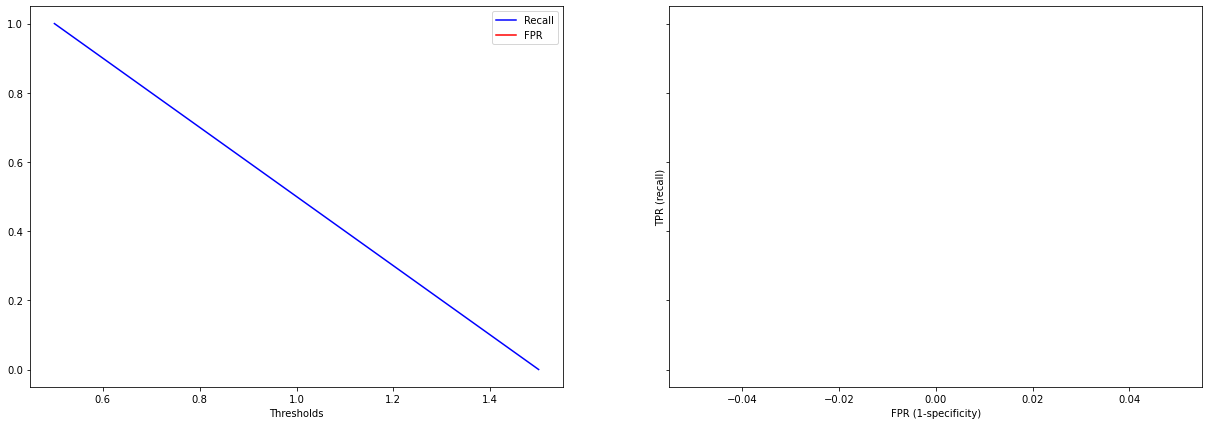

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000080     0.0        0.0          0.0  0.0      0.0
Validation  0.000722     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


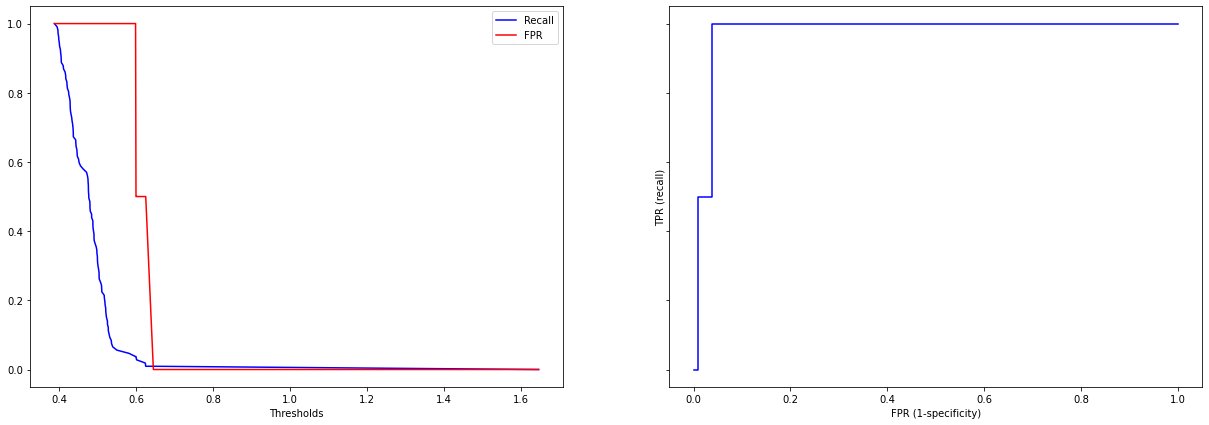

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664645  0.534324   0.723138     0.794848  0.614060  0.729255
Validation  0.656451  0.520534   0.718214     0.793578  0.598241  0.708293

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008047  0.023583   0.017830     0.023791  0.013439  0.006844
Validation  0.047746  0.108072   0.048831     0.059809  0.080620  0.052233

XGBoost Classifier
╠■■■■■■■■■╣


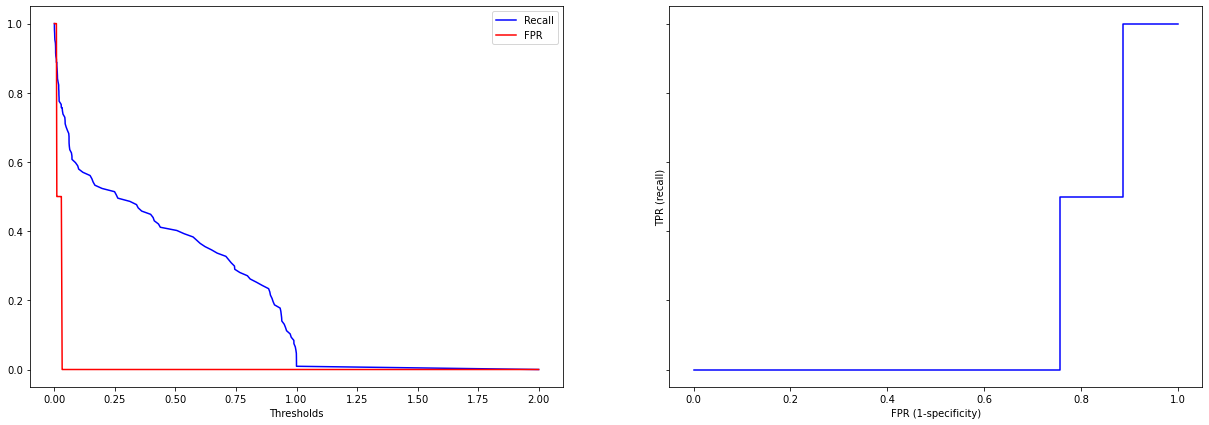

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  1.000000   0.999798     0.999798  0.999899  1.000000
Validation  0.625378  0.608699   0.631171     0.642202  0.618505  0.675251

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000213  0.000000   0.000426     0.000426  0.000213  2.153165e-07
Validation  0.029927  0.068004   0.024771     0.035400  0.042597  4.531262e-02

SVM
╠■■■■■■■■■╣


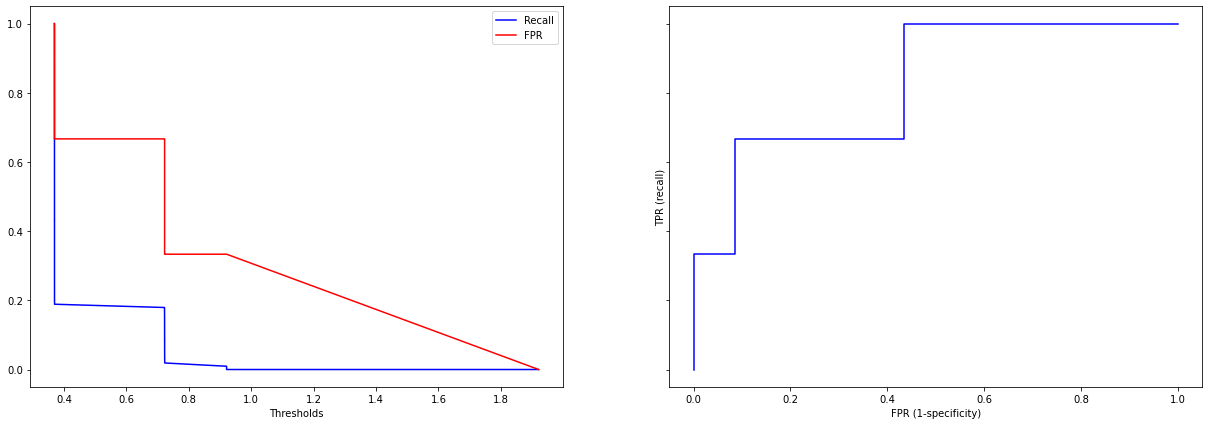

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683796  0.521082   0.772792     0.846364  0.621860  0.754518
Validation  0.666987  0.505922   0.749693     0.829358  0.597495  0.738238

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008298  0.028085   0.015265     0.018537  0.017566  0.005459
Validation  0.044798  0.113911   0.038903     0.046014  0.087720  0.034888

KNN
╠■■■■■■■■■╣


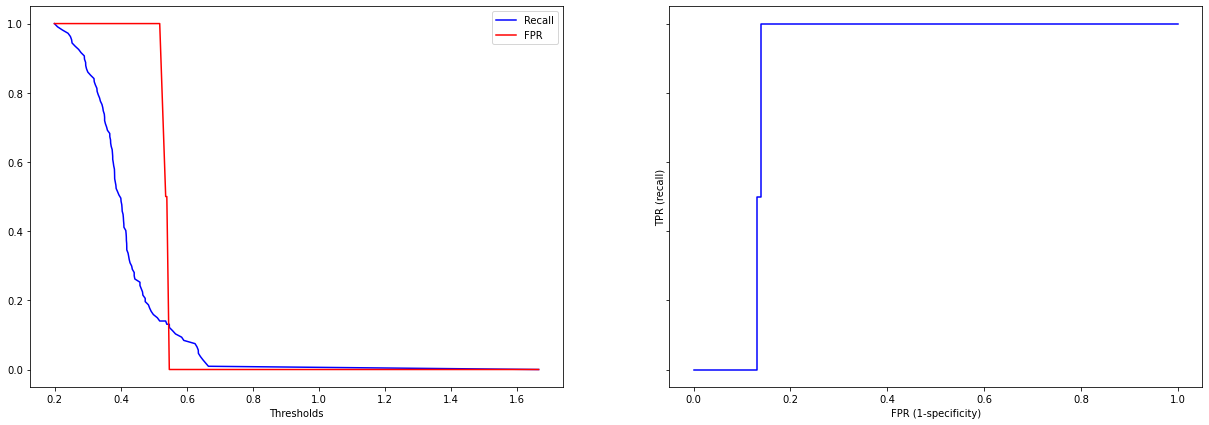

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999697   1.000000     1.000000  0.999848  1.000000
Validation  0.617630  0.395813   0.713791     0.841284  0.505125  0.684039

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000244  0.000488   0.000000     0.000000  0.000244  2.465930e-07
Validation  0.041103  0.091224   0.053476     0.036454  0.077890  5.257592e-02

Logistic Regression
╠■■■■■■■■■╣


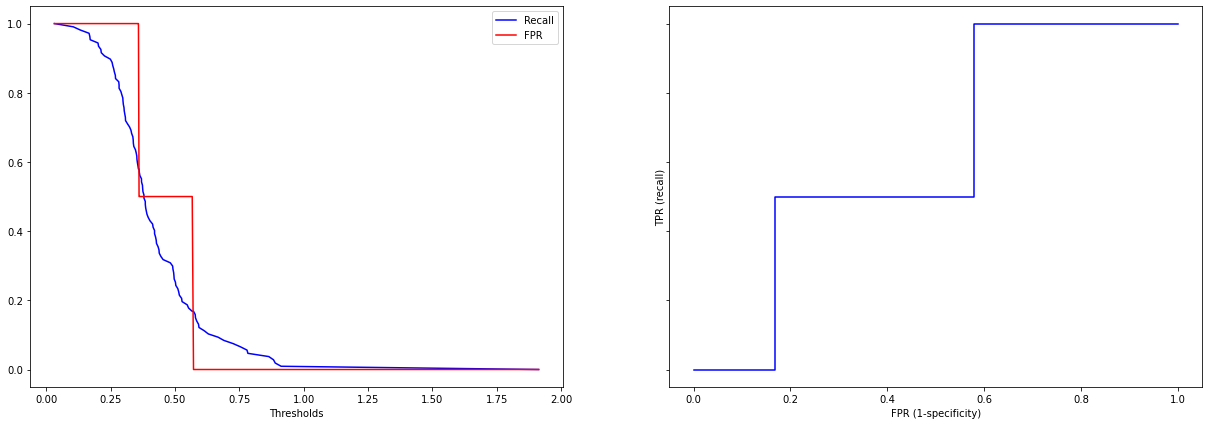

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688949  0.592153   0.734190     0.785657  0.655487  0.753473
Validation  0.690256  0.578741   0.748132     0.802752  0.651236  0.752964

Spread in metrics (sample std)


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005656  0.01024   0.009543     0.011759  0.006755  0.005721
Validation  0.045507  0.06576   0.053592     0.052302  0.055750  0.038735

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.656451  0.520534   0.718214     0.793578   
XGBoost Classifier              0.625378  0.608699   0.631171     0.642202   
SVM                             0.666987  0.505922   0.749693     0.829358   
KNN                             0.617630  0.395813   0.713791     0.841284   
Logistic Regression             0.690256  0.578741   0.748132     0.802752   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.598241  0.708293  
XGBoost Classifier              0.618505  0.675251  
SVM                             0.597495  0.738238  
KNN                             0.505125  0.684039  
Logistic Regression             0.651236  0.752964

Accuracy  \
Dummy Random                    0.4974885844748858-0.49840182648401826   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6262539285808021-0.6866487566858394   
XGBoost Classifier               0.6064504576732783-0.6443056899535493   
SVM                              0.6386542402077257-0.6953200382054118   
KNN                              0.5916343888880641-0.6436259688682092   
Logistic Regression              0.6614745387222836-0.7190373795048537   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.4521832636648815-0.5888842926320323   
XGBoost Classifier               0.5656892375782019-0.6517085939480698   
SVM                               0.433878135091975-0.5779650675769159   
KNN                             0.33811806790736637-0.4535082873887137   
Logistic Regression               0.537150555870517-0.6203306784914513   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6873310140138712-0.7490975258823823   
XGBoost Classifier               0.615503976340783-0.6468373302211681   
SVM                             0.7250890173490888-0.7742978602895451   
KNN                             0.6799692775996573-0.7476121405374663   
Logistic Regression             0.7142367980047425-0.7820265314292344   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.7557513245356178-0.8314046387671346   
XGBoost Classifier              0.6198128376541614-0.6645908320706093   
SVM                             0.8002559577899198-0.8584596385403556   
KNN                             0.8182286522018707-0.8643401551375789   
Logistic Regression             0.7696738415095048-0.8358307456464587   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5472526936560046-0.6492301974952434   
XGBoost Classifier               0.5915638123770541-0.645445634059638   
SVM                             0.5420160755535243-0.6529736989610412   
KNN                             0.4558628726002531-0.5543873943285773   
Logistic Regression             0.6159762387171922-0.6864950901485655   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6752581161676584-0.7413278767469266  
XGBoost Classifier              0.6465926413949044-0.7039090763974454  
SVM                             0.7161734433369621-0.7603035137603132  
KNN                             0.6507871347912603-0.7172910037186603  
Logistic Regression             0.7284654695091292-0.7774616410034539

In [28]:
#ra_symptoms_svitals_ex
run_models(ra_symptoms_svitals_ex, y[ra_symptoms_svitals_ex.index], models, ratio_negatives_to_positives=1)

Notes:

I made a pass through all the metrics selecting the best algorithm for each one. Then, for the ones with notes I look at the recall and if the note is not satisfactory, I look for the second best. 
Repeat the process untill we find the real best metric.

|Best Metric|Model|Dataset|Value|Cons|
| :-| -: | -: | -: | -: |
|Accuracy| Logistic Regression|ra_symptoms_svitals_ex| 0.684209| None |
|Recall | XGBoost | ra_symptoms_vitals_ex |0.614604| Average everywhere else (but above .5)|
|Precision | SVM | ra_symptoms_vitals | 0.775354 | Recall below .5 (but above .4)|
|Specificity | SVM | ra_symptoms_vitals | 0.863303 | Recall below .5 (but above.4) |
|F1 Score | Logistic Regression |ra_symptoms_svitals_ex| 0.646409 | None |
|ROC_AUC Score | Logistic Regression | ra_symptoms_svitals_ex | 0.742775 | None |

Logistic Regression with ra_symptoms_svitals_ex seems to be the best.

In [108]:
selected_features = ["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["asthma", "smoker", "diabetes"]], left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


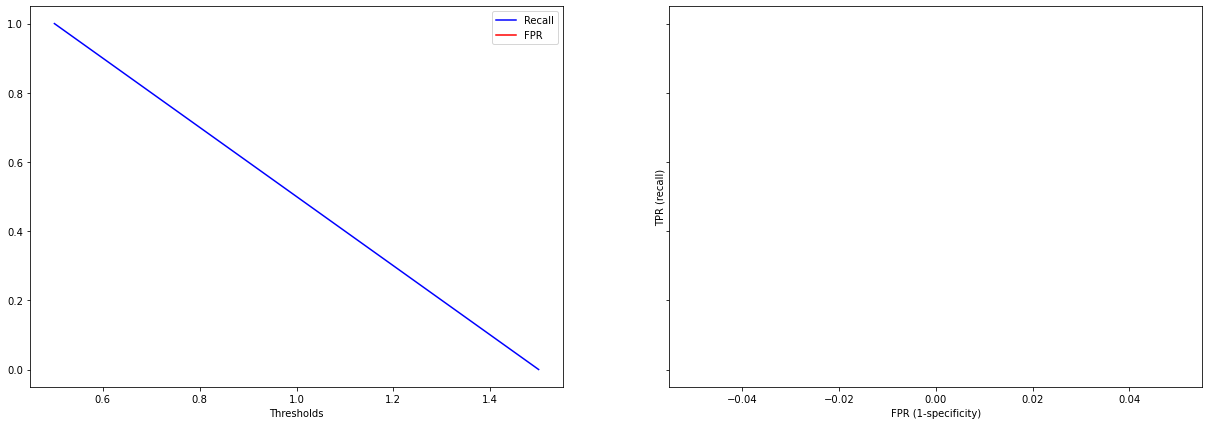

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000134     0.0        0.0          0.0  0.0      0.0
Validation  0.001203     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


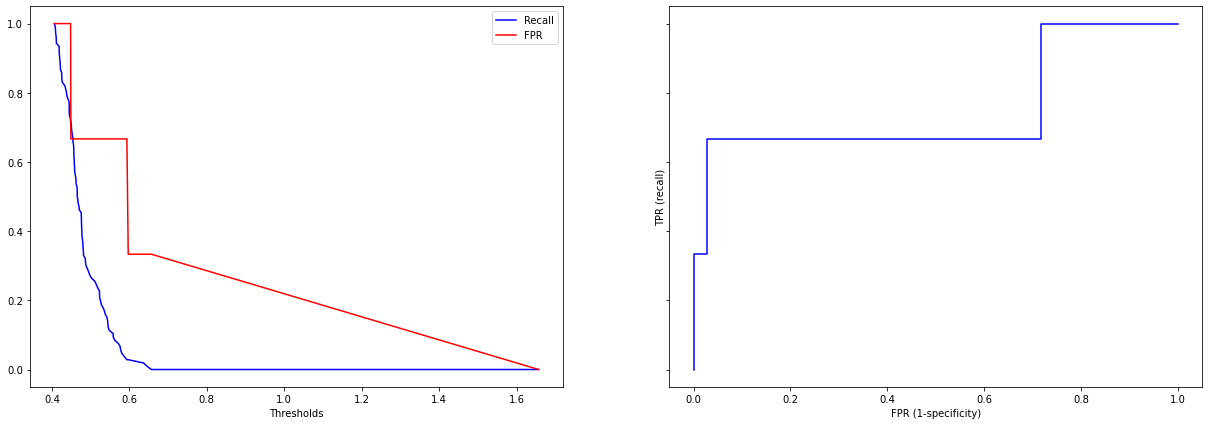

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660512  0.567630   0.697381     0.753347  0.625620  0.720042
Validation  0.633809  0.544153   0.659302     0.723853  0.594011  0.695920

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008224  0.016225   0.014323     0.020451  0.009775  0.007222
Validation  0.064046  0.111519   0.061720     0.037566  0.090396  0.058114

XGBoost Classifier
╠■■■■■■■■■╣


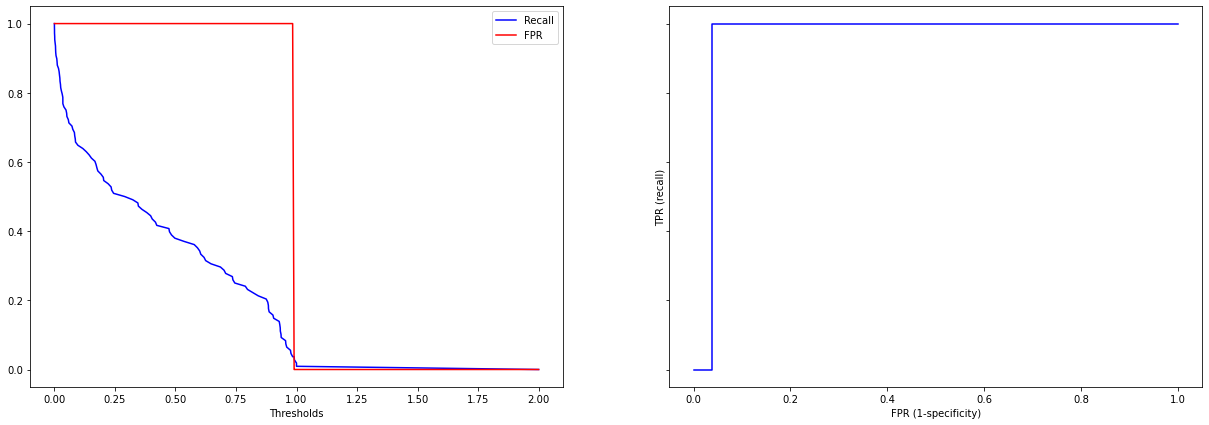

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.968856  0.958396   0.978877     0.979310  0.968522  0.997106
Validation  0.616899  0.580742   0.627711     0.653211  0.602403  0.664456

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002578  0.002924   0.004431     0.004465  0.002570  0.000460
Validation  0.044425  0.060384   0.048909     0.056521  0.049641  0.035919

SVM
╠■■■■■■■■■╣


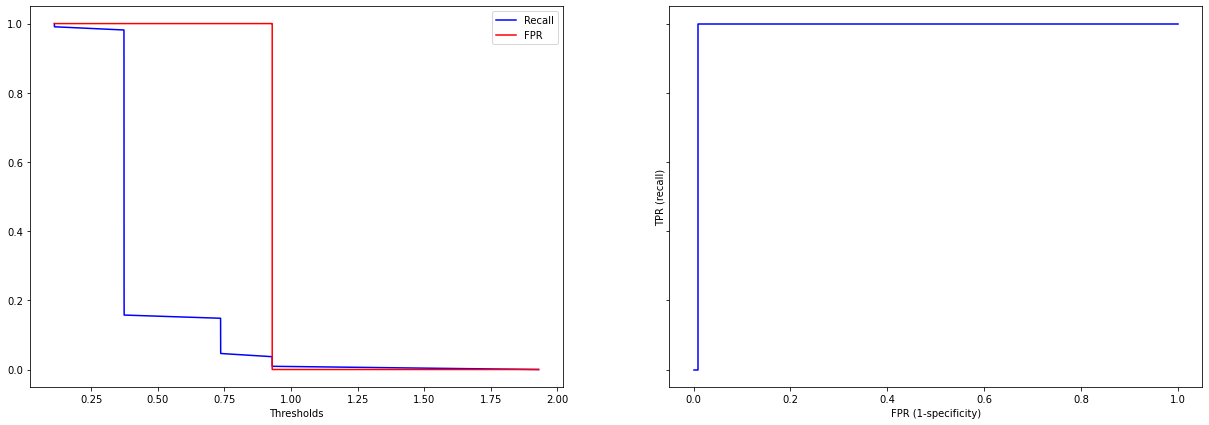

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.671924  0.493148   0.767335     0.850609  0.600054  0.742819
Validation  0.657212  0.484887   0.737709     0.830275  0.582096  0.722181

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012536  0.028253   0.011401     0.010332  0.022592  0.011505
Validation  0.047309  0.094212   0.047725     0.029092  0.083409  0.046755

KNN
╠■■■■■■■■■╣


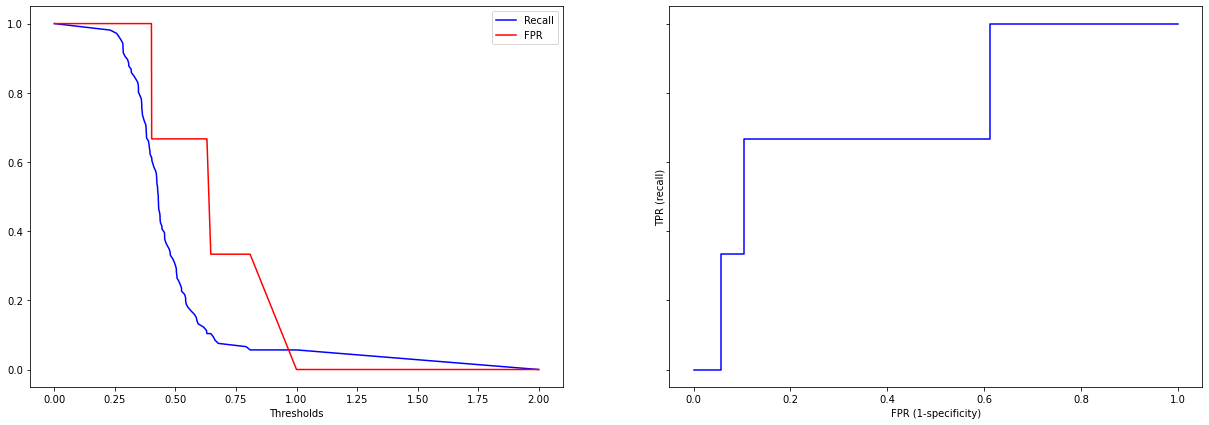

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.980472  0.963470   0.997375     0.997465  0.980125  0.999204
Validation  0.626532  0.452827   0.694706     0.800917  0.544670  0.674334

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002034  0.004150   0.000737     0.000717  0.002117  0.000167
Validation  0.043412  0.090521   0.054959     0.046590  0.075236  0.060695

Logistic Regression
╠■■■■■■■■■╣


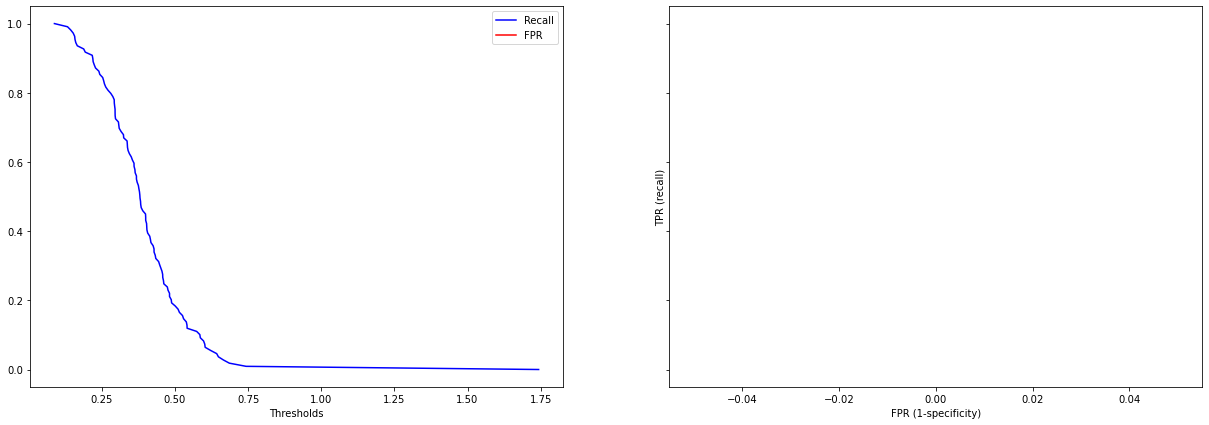

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690845  0.579095   0.746000     0.802535  0.651886  0.750749
Validation  0.686494  0.564304   0.748203     0.809174  0.641961  0.738252

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009612  0.012339   0.017352     0.018603  0.009981  0.008582
Validation  0.035733  0.065246   0.037790     0.034544  0.048467  0.041840

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.633809  0.544153   0.659302     0.723853   
XGBoost Classifier              0.616899  0.580742   0.627711     0.653211   
SVM                             0.657212  0.484887   0.737709     0.830275   
KNN                             0.626532  0.452827   0.694706     0.800917   
Logistic Regression             0.686494  0.564304   0.748203     0.809174   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.594011  0.695920  
XGBoost Classifier              0.602403  0.664456  
SVM                             0.582096  0.722181  
KNN                             0.544670  0.674334  
Logistic Regression             0.641961  0.738252

Accuracy  \
Dummy Random                    0.4980974124809741-0.49961948249619487   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.5933024316116611-0.674315179715891   
XGBoost Classifier                0.5888025407904628-0.644995791914493   
SVM                              0.6272909526308372-0.6871324062565156   
KNN                              0.5990760916808793-0.6539882960699481   
Logistic Regression              0.6638944125198948-0.7090937320907206   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.4736226430975682-0.6146842793377946   
XGBoost Classifier              0.5425522171351022-0.6189323533402938   
SVM                              0.4253023189721146-0.544472493371505   
KNN                             0.3955767746397955-0.5100779376204215   
Logistic Regression             0.5230383070180177-0.6055688656258523   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6202669573315647-0.6983369237952939   
XGBoost Classifier              0.5967783224518023-0.6586442453017801   
SVM                             0.7075251011675486-0.7678931910754222   
KNN                             0.6599469200577333-0.7294645765762149   
Logistic Regression             0.7243026199458835-0.7721040079843136   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.7000942818354067-0.747612140182942   
XGBoost Classifier              0.6174638796423182-0.6889581387063057   
SVM                             0.8118757076984816-0.8486747510171148   
KNN                              0.771451524231325-0.8303833381539961   
Logistic Regression              0.7873265185327317-0.831022105320479   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5368400895150115-0.6511823632745891   
XGBoost Classifier              0.5710071723108655-0.6337987675449658   
SVM                             0.5293433839647943-0.6348478644190858   
KNN                             0.4970861127816488-0.5922531215374338   
Logistic Regression              0.6113079616504806-0.672613827942897   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)   0.659165954582102-0.7326747995631719  
XGBoost Classifier              0.6417389772706191-0.6871735721780808  
SVM                              0.692611062339148-0.7517519006804941  
KNN                             0.6359467630797376-0.7127207809745585  
Logistic Regression             0.7117900833531439-0.7647145726675462

In [109]:
run_models(selected_dataset, y[selected_dataset.index], models, ratio_negatives_to_positives=1)


╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


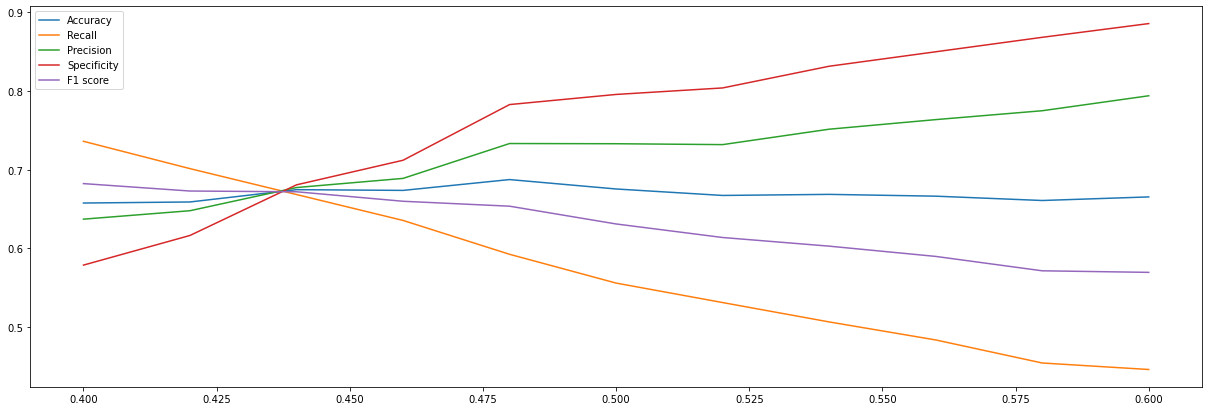

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.657649  0.658994  0.674611  0.673679  0.687418  0.675474   
Recall       0.735980  0.701284  0.668440  0.635571  0.592611  0.556105   
Precision    0.637198  0.647905  0.677312  0.688902  0.733140  0.732885   
Specificity  0.578899  0.616514  0.680734  0.711927  0.782569  0.795413   
F1           0.682292  0.672880  0.671936  0.659892  0.653647  0.631103   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.667270  0.668638  0.666355  0.660867  0.665412  
Recall       0.531393  0.506822  0.483970  0.454712  0.446455  
Precision    0.731765  0.751316  0.763479  0.774753  0.793729  
Specificity  0.803670  0.831193  0.849541  0.867890  0.885321  
F1           0.613914  0.602950  0.589927  0.571676  0.569690

In [110]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11))

With the dataset <b>selected_features</b> and a threshold of <b>.44</b> (for high recall), <b>Logistic Regression</b> seems to be the best out of all algorithms

Probably it might be a good idea to move everything from this point forward to another notebook

## Ensemble models

In [111]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [112]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
FirstEnsembleModel       0.0     0.0        0.0          0.0  0.0      0.0

Accuracy   Recall Precision Specificity       F1  ROC_AUC
FirstEnsembleModel  0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0

In [113]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [114]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



LogisticVanilla
╠■■■■■■■■■╣


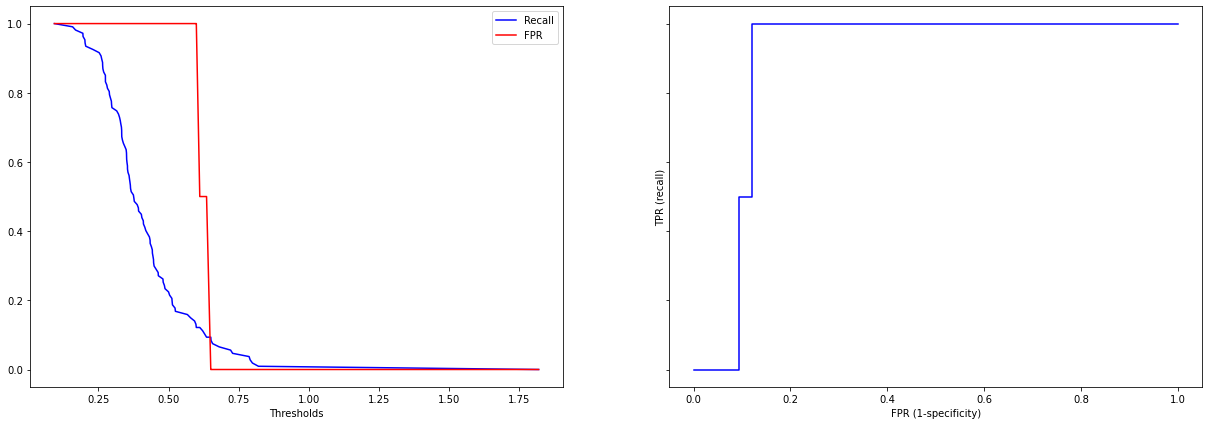

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690691  0.587109   0.740425     0.794219  0.654848  0.750717
Validation  0.686002  0.568849   0.743967     0.803670  0.642791  0.744422

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009334  0.013681   0.012041     0.011409  0.011506  0.009979
Validation  0.040005  0.077667   0.042106     0.037254  0.056192  0.042996

LogisticStrongRegularization
╠■■■■■■■■■╣


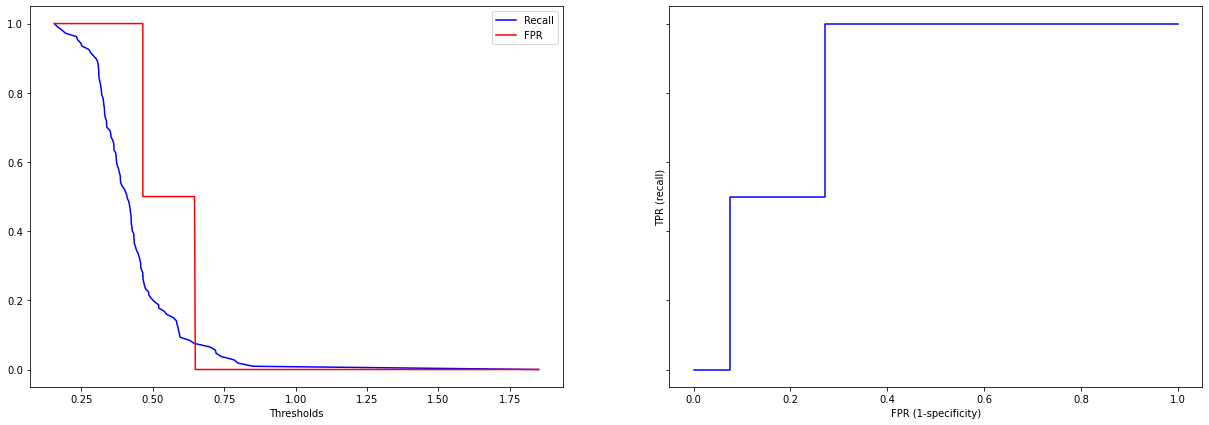

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683541  0.575138   0.734434     0.791886  0.644974  0.743722
Validation  0.673206  0.568882   0.720624     0.777982  0.633806  0.725299

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008877  0.013354   0.014333     0.015659  0.010241  0.009938
Validation  0.044956  0.078136   0.052299     0.049272  0.059270  0.047335

LogisticWeakRegularization
╠■■■■■■■■■╣


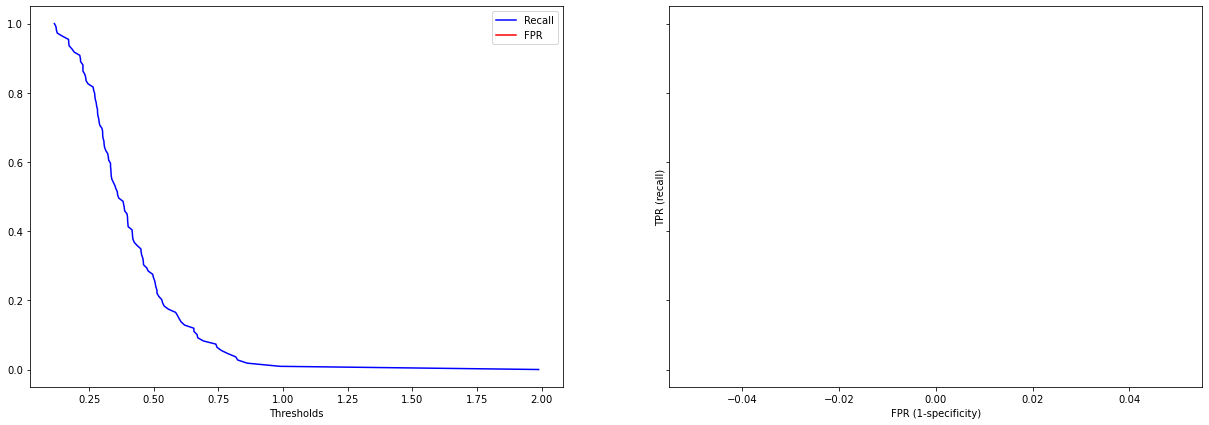

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688664  0.574121   0.744809     0.803144  0.648254  0.748272
Validation  0.672259  0.557882   0.722052     0.787156  0.627799  0.728803

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007728  0.015537   0.012674     0.014497  0.010467  0.007971
Validation  0.050181  0.087754   0.043070     0.026939  0.069011  0.051404

AdaBoost
╠■■■■■■■■■╣


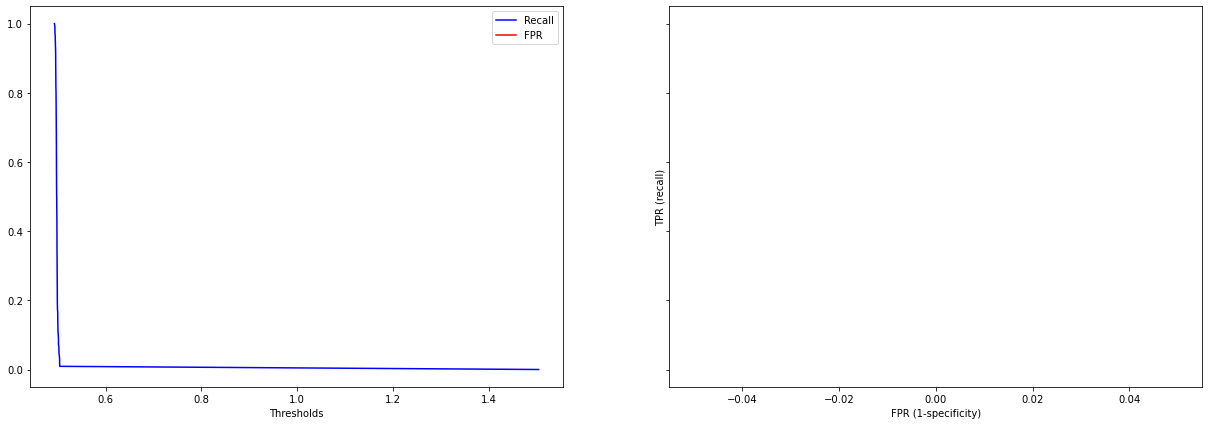

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682576  0.593504   0.722359     0.771602  0.651475  0.739779
Validation  0.671840  0.582577   0.709857     0.761468  0.638511  0.726922

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008990  0.011827   0.015468     0.019141  0.008748  0.007047
Validation  0.032918  0.069442   0.028915     0.029012  0.047681  0.048271

Accuracy    Recall  Precision  Specificity  \
LogisticVanilla               0.686002  0.568849   0.743967     0.803670   
LogisticStrongRegularization  0.673206  0.568882   0.720624     0.777982   
LogisticWeakRegularization    0.672259  0.557882   0.722052     0.787156   
AdaBoost                      0.671840  0.582577   0.709857     0.761468   

                                    F1   ROC_AUC  
LogisticVanilla               0.642791  0.744422  
LogisticStrongRegularization  0.633806  0.725299  
LogisticWeakRegularization    0.627799  0.728803  
AdaBoost                      0.638511  0.726922

Accuracy  \
LogisticVanilla                0.6607004536740441-0.711303232807461   
LogisticStrongRegularization  0.6447731110857375-0.7016388532224187   
LogisticWeakRegularization     0.6405218777739603-0.703996575579481   
AdaBoost                      0.6510211254529268-0.6926594911948882   

                                                             Recall  \
LogisticVanilla               0.5197279111323254-0.6179701706024534   
LogisticStrongRegularization   0.5194645537447812-0.618300250258555   
LogisticWeakRegularization     0.502381071042004-0.6133820649046182   
AdaBoost                       0.538657887288882-0.6264964079571563   

                                                          Precision  \
LogisticVanilla               0.7173372459096953-0.7705971227120642   
LogisticStrongRegularization  0.6875471314415509-0.7537012840465114   
LogisticWeakRegularization    0.6948124201305097-0.7492918046275268   
AdaBoost                      0.6915690834472027-0.7281444546301746   

                                                        Specificity  \
LogisticVanilla               0.7801084277868402-0.8272310217544443   
LogisticStrongRegularization   0.746818986659677-0.8091443160926164   
LogisticWeakRegularization    0.7701181794774506-0.8041937471280539   
AdaBoost                        0.743119266055046-0.779816513761468   

                                                                 F1  \
LogisticVanilla               0.6072523480319812-0.6783305049812988   
LogisticStrongRegularization  0.5963208336544346-0.6712918178595997   
LogisticWeakRegularization    0.5841530636491985-0.6714455387085909   
AdaBoost                      0.6083544014964053-0.6686669063349215   

                                                            ROC_AUC  
LogisticVanilla               0.7172288923965844-0.7716156340053868  
LogisticStrongRegularization  0.6953614916487303-0.7552366367610301  
LogisticWeakRegularization      0.696292588432199-0.761314056248766  
AdaBoost                      0.6963932514677158-0.7574511601597107

In [115]:
run_models(selected_dataset, y[selected_dataset.index], logistic_model_group, folds=10, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.25
╠■■■■■■■■■╣
Threshold: 0.275
╠■■■■■■■■■╣
Threshold: 0.3
╠■■■■■■■■■╣
Threshold: 0.325
╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.375
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42500000000000004
╠■■■■■■■■■╣
Threshold: 0.45
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.5


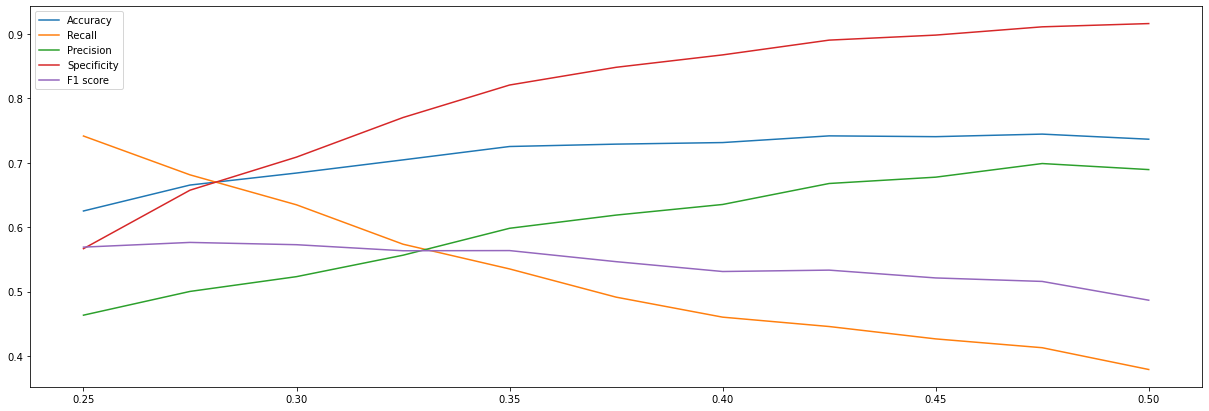

0.250     0.275     0.300     0.325     0.350     0.375  \
Accuracy     0.625045  0.665320  0.683966  0.704398  0.725171  0.728850   
Recall       0.741460  0.681168  0.634621  0.573445  0.535063  0.491243   
Precision    0.463250  0.500121  0.523071  0.556364  0.598175  0.618658   
Specificity  0.566514  0.657339  0.708716  0.770183  0.820642  0.848165   
F1           0.568912  0.576224  0.572678  0.563268  0.563556  0.546344   

                0.400     0.425     0.450     0.475     0.500  
Accuracy     0.731291  0.741676  0.740442  0.744416  0.736480  
Recall       0.460175  0.445621  0.426414  0.412719  0.378882  
Precision    0.635141  0.667732  0.677551  0.698710  0.689321  
Specificity  0.867431  0.890367  0.898165  0.911009  0.916055  
F1           0.531056  0.533200  0.521065  0.515646  0.486499

In [116]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(0.25,0.5,num=11), ratio_negatives_to_positives=2)

In general it seems that normal logistic regression beats all of the other datasets, although by running the experiment multiple times there is no clear winner (all of the results vary a lot to decide a clear winner

In [117]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


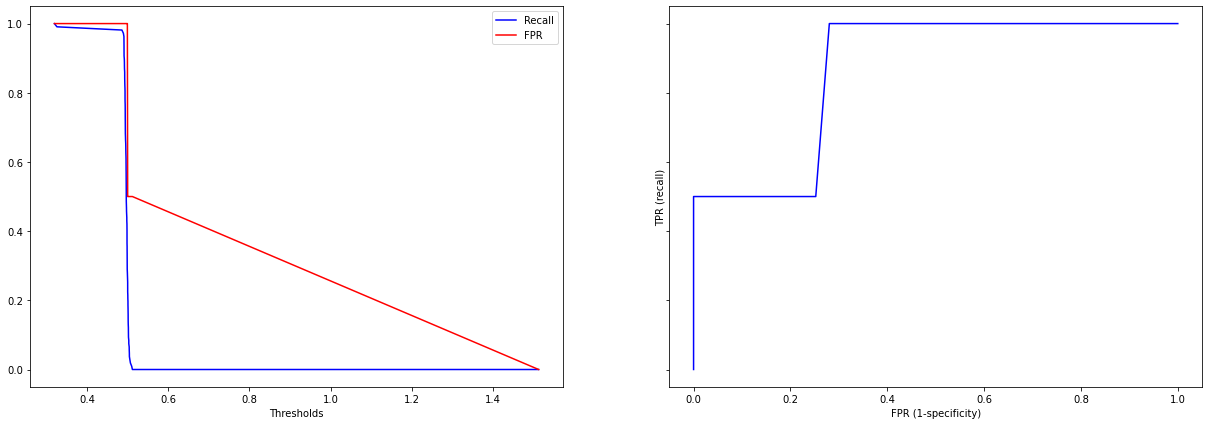

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692671  0.586501   0.744635     0.798783  0.655968  0.762455
Validation  0.669057  0.550517   0.720448     0.788073  0.622427  0.714301

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008263  0.019559   0.010657     0.013817  0.012718  0.007126
Validation  0.048166  0.085333   0.048738     0.030103  0.070175  0.045733

Ada Logistic
╠■■■■■■■■■╣


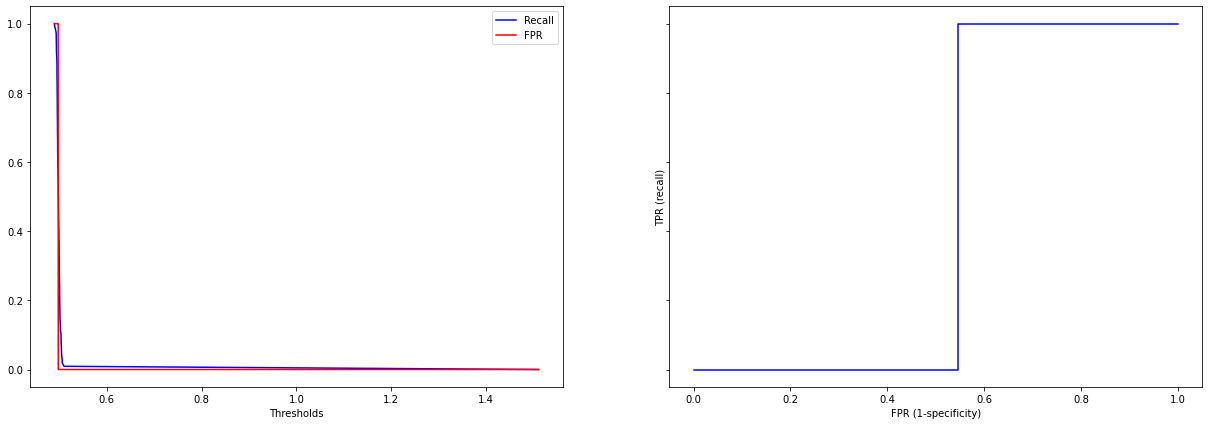

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684454  0.593401   0.725545     0.775456  0.652758  0.740236
Validation  0.671373  0.584395   0.707847     0.758716  0.639338  0.725310

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008981  0.013000   0.013240     0.014652  0.010310  0.009591
Validation  0.051065  0.072613   0.052927     0.044747  0.061134  0.055505

Ada algo
╠■■■■■■■■■╣


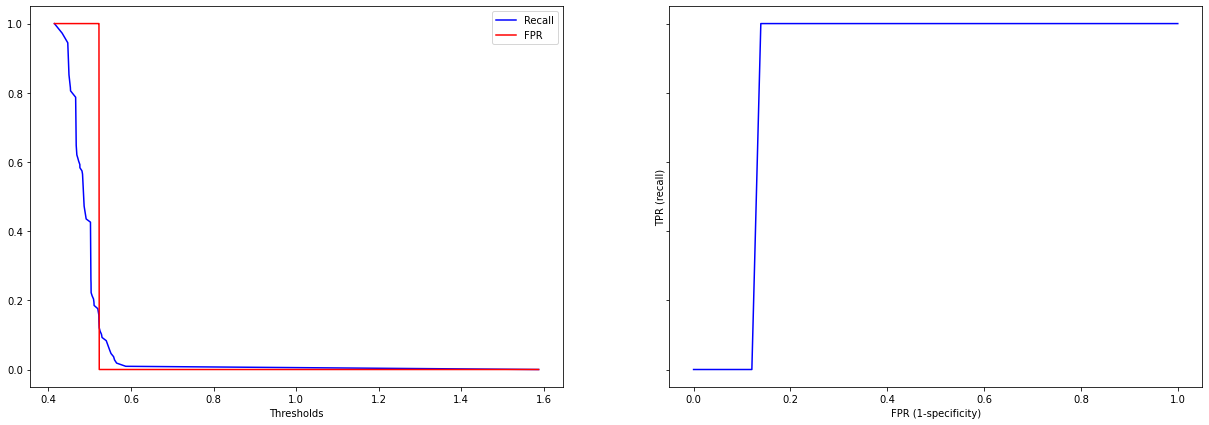

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.679230  0.587307   0.723123     0.771095  0.645989  0.73835
Validation  0.671384  0.573528   0.717982     0.769725  0.633744  0.71862

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006925  0.045439   0.033584     0.055091  0.015578  0.007269
Validation  0.037434  0.083348   0.051456     0.066502  0.055762  0.043910

Ada learning rate
╠■■■■■■■■■╣


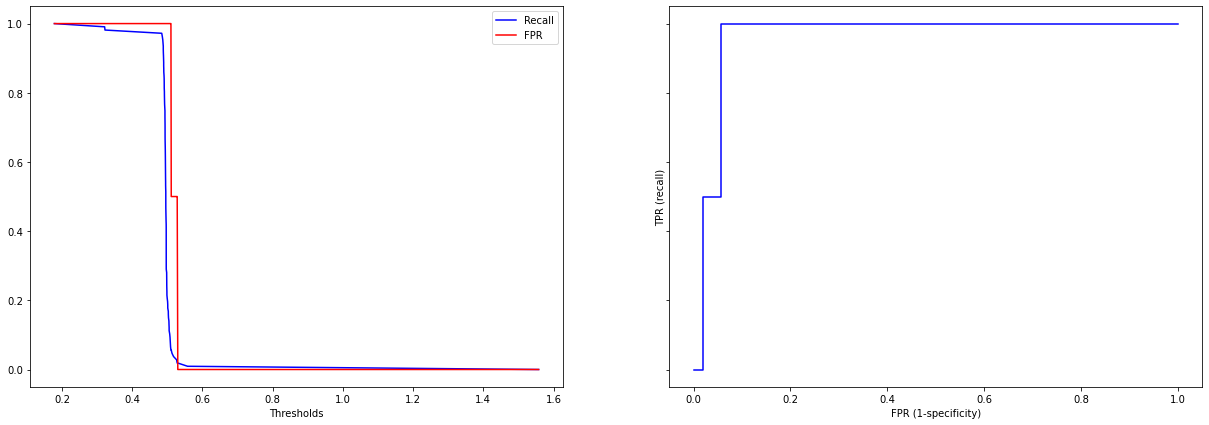

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.686988  0.570873   0.743503     0.803043  0.645595  0.757418
Validation  0.667253  0.544187   0.724135     0.790826  0.619364  0.727108

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010867  0.023777   0.012640     0.013896  0.016675  0.008560
Validation  0.036916  0.069715   0.044722     0.044274  0.052178  0.042136

Ada complete
╠■■■■■■■■■╣


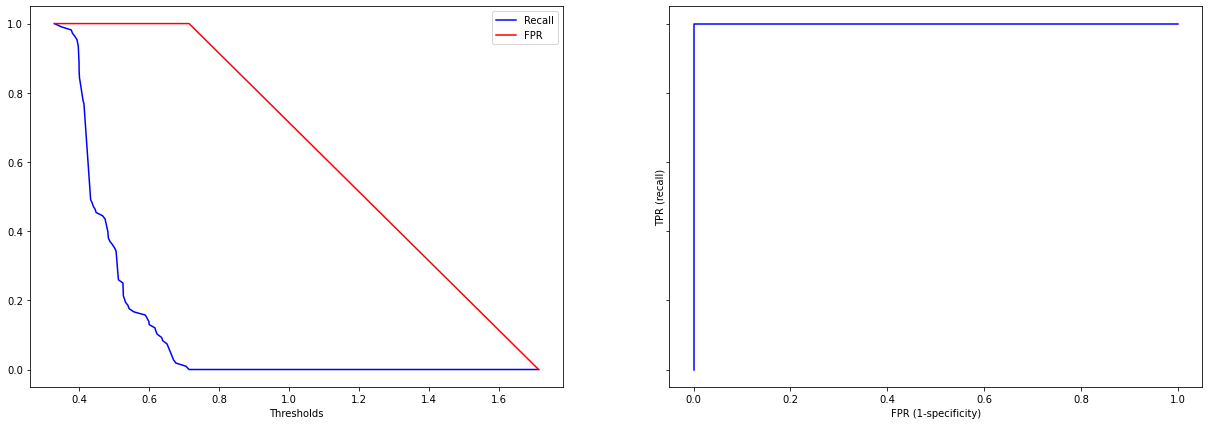

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673954  0.625067   0.693346     0.722819  0.656846  0.733883
Validation  0.673663  0.628148   0.695649     0.719266  0.656559  0.720264

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010654  0.030491   0.016687     0.029239  0.015622  0.009693
Validation  0.042664  0.087086   0.052173     0.076782  0.052645  0.046992

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.669057  0.550517   0.720448     0.788073  0.622427   
Ada Logistic       0.671373  0.584395   0.707847     0.758716  0.639338   
Ada algo           0.671384  0.573528   0.717982     0.769725  0.633744   
Ada learning rate  0.667253  0.544187   0.724135     0.790826  0.619364   
Ada complete       0.673663  0.628148   0.695649     0.719266  0.656559   

                    ROC_AUC  
Ada Vanilla        0.714301  
Ada Logistic       0.725310  
Ada algo           0.718620  
Ada learning rate  0.727108  
Ada complete       0.720264

Accuracy  \
Ada Vanilla        0.6385940491664013-0.6995191425725287   
Ada Logistic       0.6390770514509464-0.7036693772700958   
Ada algo           0.6477081679876294-0.6950592066510534   
Ada learning rate  0.6439056290875477-0.6906006756336621   
Ada complete       0.6466795484562621-0.7006456578610266   

                                                   Recall  \
Ada Vanilla        0.49654801658474707-0.6044861785778884   
Ada Logistic        0.5384709585307824-0.6303197003516195   
Ada algo            0.5208139683824086-0.6262419115175081   
Ada learning rate   0.5000954361319587-0.5882782085719611   
Ada complete        0.5730704454646071-0.6832264686304722   

                                               Precision  \
Ada Vanilla        0.6896238747942719-0.7512725940288055   
Ada Logistic       0.6743731611404103-0.7413205827000228   
Ada algo           0.6854390957719971-0.7505258919986342   
Ada learning rate    0.69585017703165-0.7524196737717342   
Ada complete       0.6626518882189852-0.7286456861060068   

                                             Specificity  \
Ada Vanilla        0.7690343945978307-0.8071123943929949   
Ada Logistic       0.7304153264800995-0.7870158661804508   
Ada algo           0.7276650000074516-0.8117845412769522   
Ada learning rate  0.7628244082146552-0.8188269679321335   
Ada complete        0.670704750480051-0.7678273596116922   

                                                      F1  \
Ada Vanilla         0.578044870452535-0.6668094062204782   
Ada Logistic        0.600674012350467-0.6780026324975823   
Ada algo           0.5984764314160471-0.6690107718677307   
Ada learning rate   0.586364170303905-0.6523642950267531   
Ada complete       0.6232633817879665-0.6898541859830503   

                                                 ROC_AUC  
Ada Vanilla        0.6853768625268736-0.7432255661024888  
Ada Logistic       0.6902059069347316-0.7604143347039426  
Ada algo           0.6908488019274256-0.7463909467928384  
Ada learning rate  0.7004592415719981-0.7537574221615413  
Ada complete       0.6905434250053507-0.7499840788013384

In [118]:
run_models(selected_dataset, y[selected_dataset.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


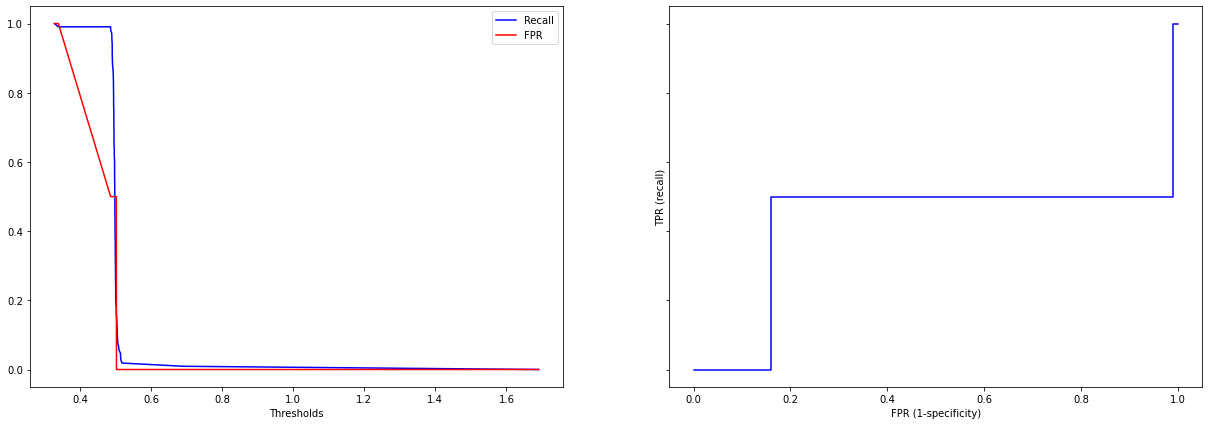

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.697032  0.593708   0.748546     0.800304  0.662004  0.769444
Validation  0.659499  0.551485   0.705476     0.767890  0.615848  0.704732

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007115  0.014959   0.013688     0.016866  0.008898  0.007867
Validation  0.031528  0.082624   0.030439     0.042605  0.056436  0.036928

Ada Logistic
╠■■■■■■■■■╣


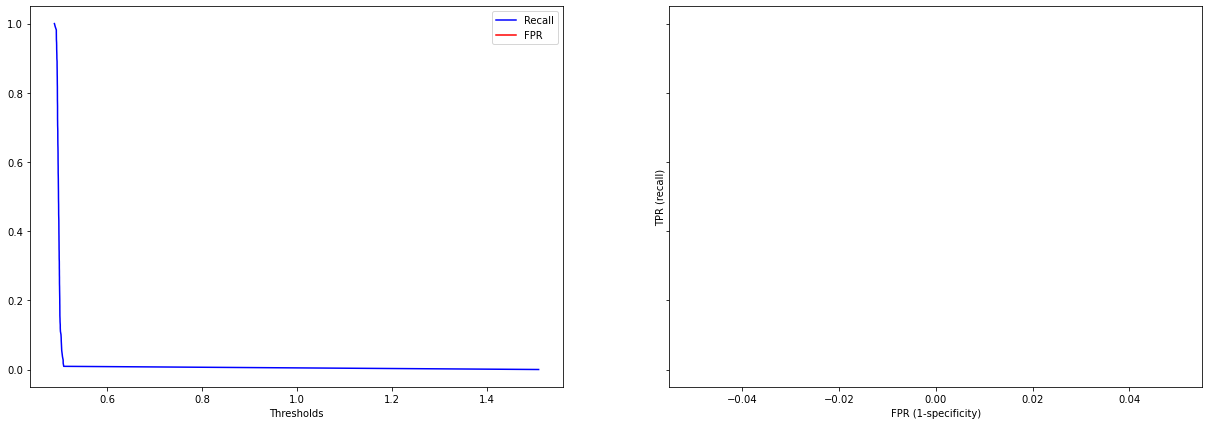

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684454  0.581531   0.732373     0.787323  0.648137  0.738898
Validation  0.668617  0.574362   0.708278     0.763303  0.632208  0.727192

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007770  0.014405   0.012966     0.015864  0.009603  0.007844
Validation  0.038694  0.080865   0.033899     0.035611  0.058101  0.048041

Ada algo
╠■■■■■■■■■╣


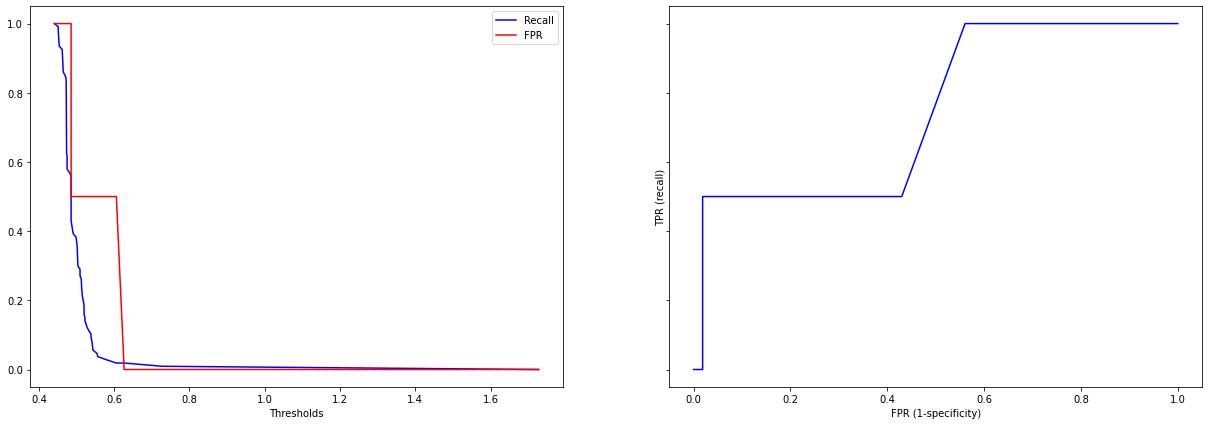

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679786  0.588936   0.721400     0.770588  0.647264  0.740586
Validation  0.663148  0.574337   0.702156     0.752294  0.625872  0.711449

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009028  0.036052   0.025063     0.039206  0.016281  0.006293
Validation  0.040364  0.109469   0.038434     0.070137  0.071379  0.049310

Ada learning rate
╠■■■■■■■■■╣


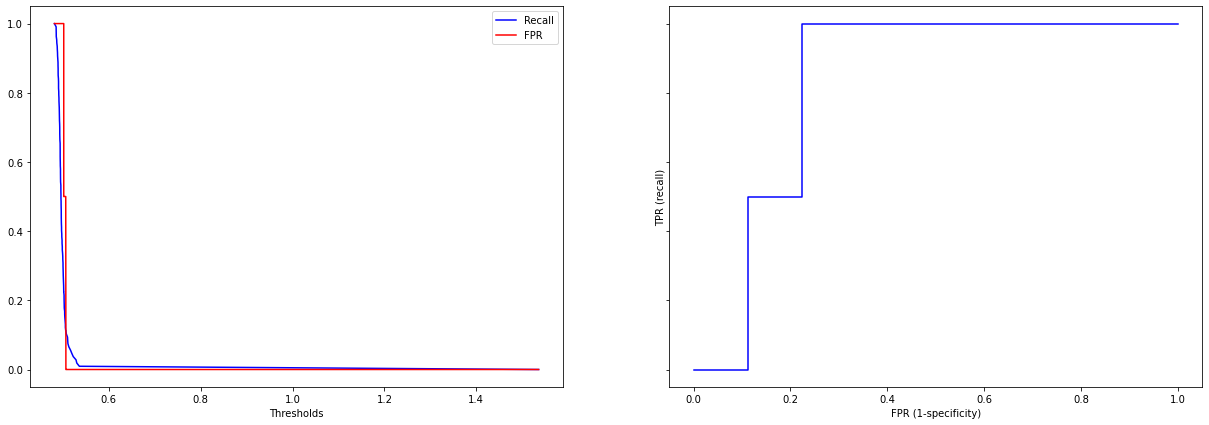

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.695004  0.578895   0.754305     0.811055  0.654724  0.762427
Validation  0.659474  0.542327   0.707910     0.777064  0.611136  0.709815

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005755  0.020304   0.013306     0.018300  0.010565  0.005886
Validation  0.045837  0.097048   0.042309     0.037962  0.071329  0.041870

Ada complete
╠■■■■■■■■■╣


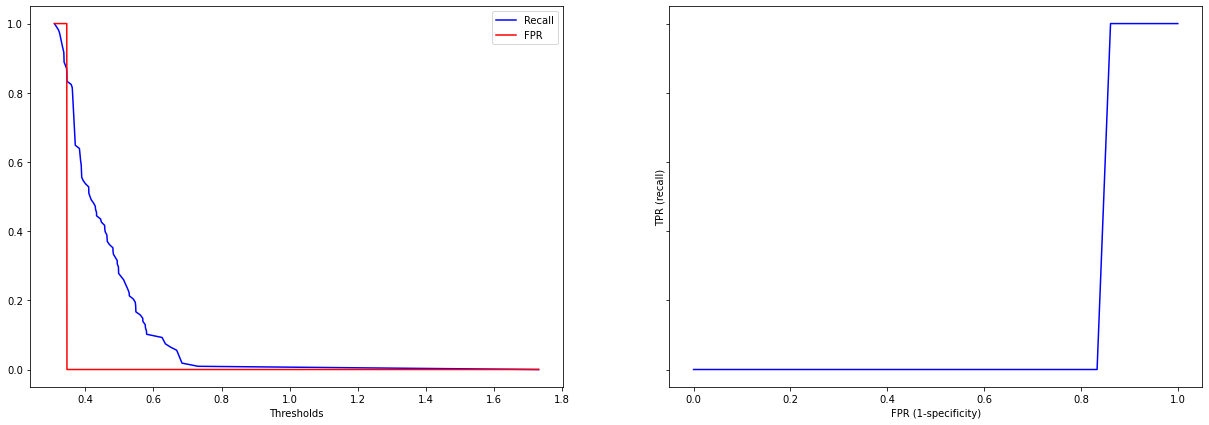

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660207  0.604978   0.680308     0.715416  0.640137  0.711840
Validation  0.640696  0.579808   0.661208     0.701835  0.616133  0.693045

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010211  0.022484   0.013954     0.022533  0.013241  0.010528
Validation  0.037630  0.073649   0.038486     0.045411  0.052639  0.044169

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.659499  0.551485   0.705476     0.767890  0.615848   
Ada Logistic       0.668617  0.574362   0.708278     0.763303  0.632208   
Ada algo           0.663148  0.574337   0.702156     0.752294  0.625872   
Ada learning rate  0.659474  0.542327   0.707910     0.777064  0.611136   
Ada complete       0.640696  0.579808   0.661208     0.701835  0.616133   

                    ROC_AUC  
Ada Vanilla        0.704732  
Ada Logistic       0.727192  
Ada algo           0.711449  
Ada learning rate  0.709815  
Ada complete       0.693045

Accuracy  \
Ada Vanilla        0.6395586392022298-0.6794393080978415   
Ada Logistic       0.6441443893891788-0.6930890738088439   
Ada algo           0.6376192020218254-0.6886763029842489   
Ada learning rate  0.6304842505162689-0.6884634265814646   
Ada complete       0.6168967661503122-0.6644948806177329   

                                                   Recall  \
Ada Vanilla        0.49922833506197983-0.6037408058888124   
Ada Logistic        0.5232185757040066-0.6255053609098382   
Ada algo            0.5051024609577883-0.6435714339546388   
Ada learning rate  0.48094867609406944-0.6037052021377903   
Ada complete        0.5332284520959015-0.6263878948598952   

                                               Precision  \
Ada Vanilla         0.6862247904303115-0.724727534266829   
Ada Logistic        0.6868383802333642-0.729717349081727   
Ada algo           0.6778482377216706-0.7264636713879722   
Ada learning rate  0.6811515562397471-0.7346689754907879   
Ada complete        0.636867296986592-0.6855491690595533   

                                             Specificity  \
Ada Vanilla        0.7409438644991918-0.7948359520145697   
Ada Logistic        0.740780486067863-0.7858250185192929   
Ada algo           0.7079352553774465-0.7966519005858563   
Ada learning rate  0.7530546955028863-0.8010737448640863   
Ada complete       0.6731147232247734-0.7305550015458688   

                                                      F1  \
Ada Vanilla        0.5801545539063362-0.6515416882726615   
Ada Logistic       0.5954618533137231-0.6689550418067659   
Ada algo           0.5807286389700265-0.6710162539473415   
Ada learning rate  0.5660237583093709-0.6562491051759628   
Ada complete        0.582841545147986-0.6494248891884757   

                                                 ROC_AUC  
Ada Vanilla        0.6813764562625794-0.7280866284180793  
Ada Logistic        0.6968079158417323-0.757575630079563  
Ada algo           0.6802628978519603-0.7426350828812194  
Ada learning rate  0.6833345464997167-0.7362964150814175  
Ada complete       0.6651097410462544-0.7209794311232139

In [119]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.491
╠■■■■■■■■■╣
Threshold: 0.492
╠■■■■■■■■■╣
Threshold: 0.493
╠■■■■■■■■■╣
Threshold: 0.494
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.496
╠■■■■■■■■■╣
Threshold: 0.497
╠■■■■■■■■■╣
Threshold: 0.498
╠■■■■■■■■■╣
Threshold: 0.499
╠■■■■■■■■■╣
Threshold: 0.5


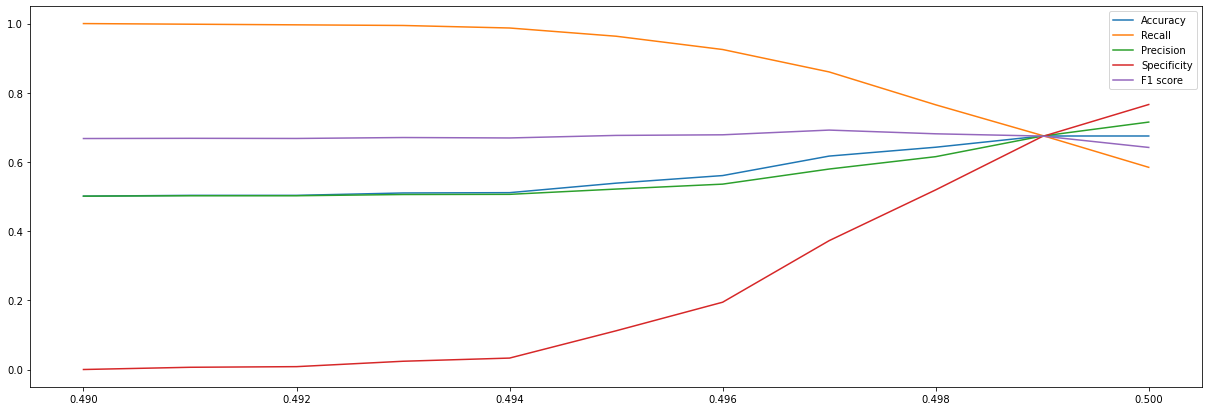

0.490     0.491     0.492     0.493     0.494     0.495  \
Accuracy     0.501142  0.503429  0.503435  0.510307  0.511214  0.538670   
Recall       1.000000  0.998182  0.996364  0.994520  0.987214  0.963428   
Precision    0.501142  0.502300  0.502304  0.505866  0.506346  0.521596   
Specificity  0.000000  0.006422  0.008257  0.023853  0.033028  0.111927   
F1           0.667680  0.668296  0.667891  0.670597  0.669351  0.676698   

                0.496     0.497     0.498     0.499     0.500  
Accuracy     0.560620  0.616943  0.642547  0.675030  0.675024  
Recall       0.925054  0.860200  0.765188  0.676606  0.584437  
Precision    0.535865  0.579504  0.615250  0.674840  0.715240  
Specificity  0.194495  0.372477  0.519266  0.673394  0.766055  
F1           0.678472  0.692103  0.681350  0.674813  0.641938

In [120]:
run_threshold(selected_dataset, y[selected_dataset.index], ada_configurations["Ada Logistic"], thresholds=np.linspace(0.49, 0.50, num=11), ratio_negatives_to_positives=1)

Accuracy    Recall  Precision  Specificity        F1
Metrics  0.710345  0.598485   0.718182     0.803797  0.652893

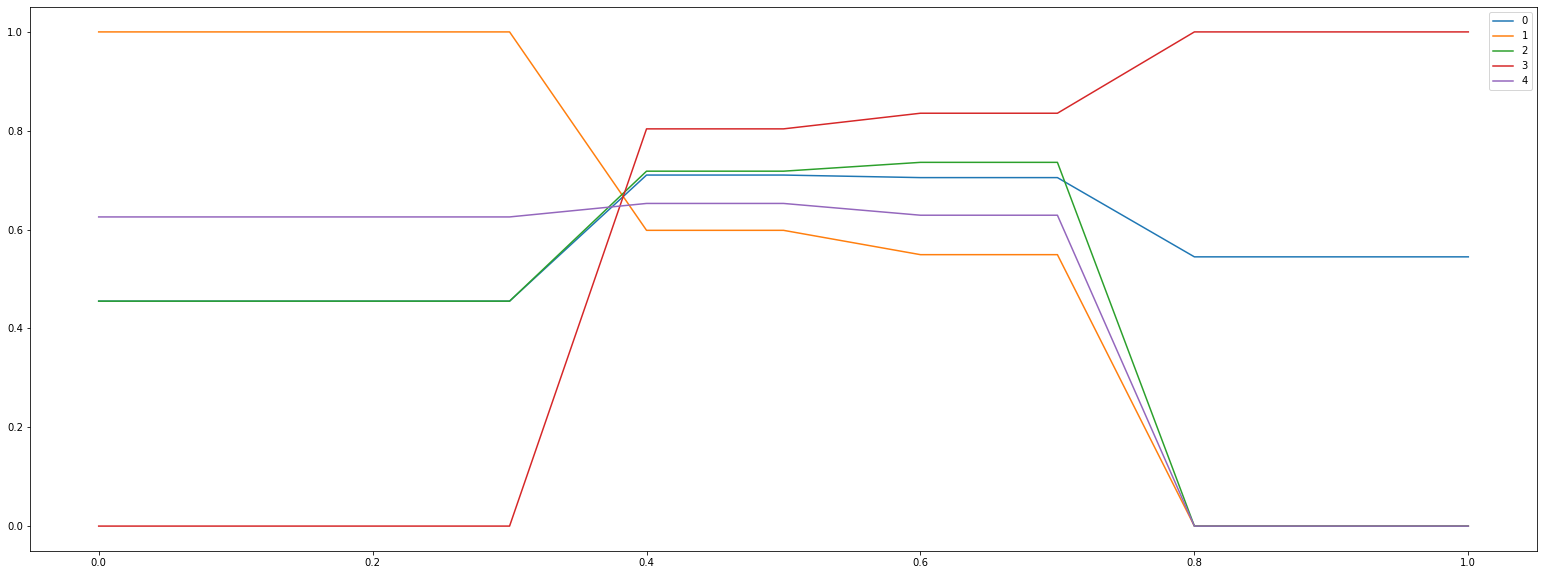

0.0       0.1       0.2       0.3       0.4       0.5  \
Accuracy     0.455172  0.455172  0.455172  0.455172  0.710345  0.710345   
Recall       1.000000  1.000000  1.000000  1.000000  0.598485  0.598485   
Precision    0.455172  0.455172  0.455172  0.455172  0.718182  0.718182   
Specificity  0.000000  0.000000  0.000000  0.000000  0.803797  0.803797   
F1           0.625592  0.625592  0.625592  0.625592  0.652893  0.652893   

                  0.6       0.7       0.8       0.9       1.0  
Accuracy     0.705172  0.705172  0.544828  0.544828  0.544828  
Recall       0.549242  0.549242  0.000000  0.000000  0.000000  
Precision    0.736041  0.736041  0.000000  0.000000  0.000000  
Specificity  0.835443  0.835443  1.000000  1.000000  1.000000  
F1           0.629067  0.629067  0.000000  0.000000  0.000000

In [121]:
from sklearn.model_selection import train_test_split

test_data = pd.concat([selected_dataset[y=="Positive"], selected_dataset[y=="Negative"].sample(np.sum(y=="Positive"))])

X_train, X_test, y_train, y_test = train_test_split(test_data, y[test_data.index])


stack_classifier = StackingCVClassifier([models["Logistic Regression"], ada_configurations["Ada Logistic"]], meta_classifier=RandomForestClassifier())

imp = Imputer()
imp.fit_transform(X_train, y_train)
imp.transform(X_test)

y_train[y_train == "Positive"] = 1
y_train[y_train == "Negative"] = 0
y_train = y_train.astype("float")

stack_classifier.fit(X_train, y_train)

y_preds = stack_classifier.predict(X_test)
y_preds = y_preds.astype("object")
y_preds[y_preds == 1] = "Positive"
y_preds[y_preds == 0] = "Negative"

display(pd.DataFrame(data=np.array(get_metrics(y_test, y_preds)).reshape((1,5)), index=["Metrics"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))

scores = np.ones((11, 5))
thresholds = np.linspace(0, 1, num=11)
i = 0
for threshold in thresholds:
    y_preds = stack_classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds[y_preds >= threshold] = 1
    y_preds[y_preds < 1] = 0
    
    
    
    y_preds = y_preds.astype("object")
    y_preds[y_preds == 1] = "Positive"
    y_preds[y_preds == 0] = "Negative"
    
    scores[i] = get_metrics(y_test, y_preds)
    i+=1

plt.figure(figsize=(27, 10))
for i in range(scores.shape[1]):
    plt.plot(thresholds, scores[:,i], label=i)

plt.legend()
plt.show()
pd.DataFrame(scores.transpose(), index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds)

Apparently stacking and ensemble models do not do much better than regular logistic regression

### SMOTE

In [122]:
models_smote ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    #"SVM" : SVC(kernel='linear', probability=True), #Removed due to getting the notebook stuck
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

In [123]:
ratio_negs_to_pos = (y == "Negative").sum() / (y == "Positive").sum()
weights = ((y == "Positive")* ratio_negs_to_pos * 100) + 1

X_copy = X.copy()
imp = Imputer()
imp.fit_transform(X_copy, y)
run_models(X_copy[selected_features], y, models_smote, ratio_negatives_to_positives=-1, sample_weights=weights)

MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.811033  0.458096   0.057913     0.819578  0.102823  0.672651
Validation  0.810407  0.458166   0.057710     0.818927  0.102473  0.670553

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003265  0.011482   0.001115     0.003508  0.001939  0.004548
Validation  0.007555  0.048323   0.006927     0.007256  0.011958  0.029938

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.976355  0.000638   0.273333     0.999978  0.001272  0.658256
Validation  0.976303  0.000000   0.000000     0.999941  0.000000  0.643947

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000133  0.000751    0.33731     0.000031  0.001495  0.009997
Validation  0.001248  0.000000    0.00000     0.000134  0.000000  0.012759

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.986397  0.458344   0.931256     0.999181  0.614286  0.908376
Validation  0.970519  0.070585   0.176944     0.992332  0.099985  0.655771

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000254  0.009049   0.007091     0.000084  0.008806  0.002697
Validation  0.003032  0.037413   0.061717     0.001393  0.046949  0.024770

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.976359  0.022934   0.562984     0.999443  0.043551  0.680541
Validation  0.976284  0.021920   0.420437     0.999386  0.041421  0.677924

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000302  0.009228   0.168233     0.000342  0.017115  0.037341
Validation  0.001926  0.012757   0.201854     0.000342  0.023602  0.038064

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.810407  0.458166   0.057710     0.818927   
Random Forest (100 estimators)  0.976303  0.000000   0.000000     0.999941   
XGBoost Classifier              0.970519  0.070585   0.176944     0.992332   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.976284  0.021920   0.420437     0.999386   

                                      F1   ROC_AUC  
MultinomialNB                   0.102473  0.670553  
Random Forest (100 estimators)  0.000000  0.643947  
XGBoost Classifier              0.099985  0.655771  
KNN                             0.000000  0.000000  
Logistic Regression             0.041421  0.677924

Accuracy  \
MultinomialNB                   0.8056286846896192-0.8151852211536146   
Random Forest (100 estimators)  0.9755141509383101-0.9770924874314084   
XGBoost Classifier              0.9686014993674775-0.9724369335159561   
KNN                                                           0.0-0.0   
Logistic Regression             0.9750659259150215-0.9775020801230577   

                                                                  Recall  \
MultinomialNB                     0.4276036112257907-0.48872848431838833   
Random Forest (100 estimators)                                   0.0-0.0   
XGBoost Classifier               0.04692235391288187-0.09424677284426995   
KNN                                                              0.0-0.0   
Logistic Regression             0.013851865789721909-0.02998822659838276   

                                                               Precision  \
MultinomialNB                   0.053329204323857675-0.06209077034397833   
Random Forest (100 estimators)                                   0.0-0.0   
XGBoost Classifier                0.1379111613635793-0.21597770149192877   
KNN                                                              0.0-0.0   
Logistic Regression                0.29277269369496073-0.548100322178055   

                                                          Specificity  \
MultinomialNB                   0.8143378095055694-0.8235162021001855   
Random Forest (100 estimators)   0.999855931218517-1.0000251312388282   
XGBoost Classifier              0.9914508564654421-0.9932132522091364   
KNN                                                           0.0-0.0   
Logistic Regression             0.9991693565761566-0.9996022413516441   

                                                                     F1  \
MultinomialNB                   0.09491060869372293-0.11003608523700552   
Random Forest (100 estimators)                                  0.0-0.0   
XGBoost Classifier               0.07029218100061713-0.1296783075484166   
KNN                                                             0.0-0.0   
Logistic Regression              0.0264938007596511-0.05634796951150463   

                                                              ROC_AUC  
MultinomialNB                   0.6516181237526947-0.6894869690103614  
Random Forest (100 estimators)  0.6358779220379642-0.6520167184531778  
XGBoost Classifier              0.6401046548996241-0.6714364259038039  
KNN                                                           0.0-0.0  
Logistic Regression             0.6538504415796993-0.7019974030801246

Here I am using sample weights instead of SMOTE to compare the performance between the 2 approaches. Apparently the using sample weights do not yield good results at all.

In [124]:
from sklearn.preprocessing import LabelEncoder

X_copy = X.copy()

imp = Imputer()
imp.fit_transform(X_copy, y)

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y)
print(y_copy.value_counts())
run_models(X_copy[selected_features], y_copy, models_smote, ratio_negatives_to_positives=-1)

(51695, 34)
Negative    50473
Positive    50473
Name: covid19_test_results, dtype: int64
MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.641548  0.539042   0.678065     0.744057  0.600607  0.694686
Validation  0.641442  0.538875   0.677912     0.743980  0.600442  0.694556

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000934  0.001756   0.002643     0.003510  0.000546  0.000786
Validation  0.004804  0.006363   0.008034     0.005906  0.006722  0.005828

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.924812  0.879971   0.966664     0.969654  0.92128  0.978101
Validation  0.923712  0.878467   0.965851     0.968926  0.92008  0.977209

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001669  0.003127   0.000901     0.000808  0.001873  0.000662
Validation  0.001858  0.004625   0.002226     0.002271  0.002373  0.000872

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.981564  0.982759   0.980417     0.980370  0.981586  0.998152
Validation  0.975314  0.975028   0.975592     0.975613  0.975308  0.992339

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.000193  0.000373   0.000131     0.000116  0.000184  0.00006
Validation  0.001005  0.001674   0.001501     0.001367  0.000918  0.00062

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659982  0.562396   0.698804     0.757565  0.623202  0.726703
Validation  0.660413  0.562714   0.699396     0.758150  0.623611  0.726432

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.000554  0.005053   0.002410     0.005029  0.002220  0.00084
Validation  0.003889  0.006811   0.008295     0.006401  0.005105  0.00507

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.641442  0.538875   0.677912     0.743980   
Random Forest (100 estimators)  0.923712  0.878467   0.965851     0.968926   
XGBoost Classifier              0.975314  0.975028   0.975592     0.975613   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.660413  0.562714   0.699396     0.758150   

                                      F1   ROC_AUC  
MultinomialNB                   0.600442  0.694556  
Random Forest (100 estimators)  0.920080  0.977209  
XGBoost Classifier              0.975308  0.992339  
KNN                             0.000000  0.000000  
Logistic Regression             0.623611  0.726432

Accuracy  \
MultinomialNB                   0.6384033797661819-0.6444803992882202   
Random Forest (100 estimators)   0.922536373748464-0.9248869956627752   
XGBoost Classifier              0.9746780535549361-0.9759490020971694   
KNN                                                           0.0-0.0   
Logistic Regression             0.6579531210147374-0.6628719769524345   

                                                               Recall  \
MultinomialNB                   0.5348511235320764-0.5428997404989618   
Random Forest (100 estimators)  0.8755416835605935-0.8813914321422917   
XGBoost Classifier              0.9739689183582538-0.9760865453072622   
KNN                                                           0.0-0.0   
Logistic Regression             0.5584060171159165-0.5670219198150076   

                                                            Precision  \
MultinomialNB                    0.672831102403254-0.6829931398044227   
Random Forest (100 estimators)  0.9644430574434758-0.9672593037587688   
XGBoost Classifier              0.9746428317941864-0.9765410050537306   
KNN                                                           0.0-0.0   
Logistic Regression             0.6941493830467675-0.7046423859882873   

                                                          Specificity  \
MultinomialNB                   0.7402449242053641-0.7477158911527462   
Random Forest (100 estimators)  0.9674891284816383-0.9703621870691177   
XGBoost Classifier              0.9747481491371355-0.9764777686674582   
KNN                                                           0.0-0.0   
Logistic Regression             0.7541010741154867-0.7621982488914331   

                                                                   F1  \
MultinomialNB                   0.5961909834747798-0.6046934527051149   
Random Forest (100 estimators)  0.9185794622688027-0.9215806944836052   
XGBoost Classifier              0.9747277308654775-0.9758886460650237   
KNN                                                           0.0-0.0   
Logistic Regression             0.6203822666128533-0.6268398082054614   

                                                              ROC_AUC  
MultinomialNB                   0.6908707432658759-0.6982420299590469  
Random Forest (100 estimators)  0.9766575719421813-0.9777609045651778  
XGBoost Classifier              0.9919467504725336-0.9927316001357743  
KNN                                                           0.0-0.0  
Logistic Regression             0.7232248256404296-0.7296382883213882

In the initial run logistic regression didn't do better, but surprisingly the tree-based models did extremely well. Although this might be a legit improvement due to now having enough samples, I suspect the tree base models are overfitting since I am doing the cross validation <i>after doing the resampling</i>. The next iteration will be saving a test sample with evenly distributed samples of positive and negative taken away before the resampling and applying SMOTE to the rest.

In [125]:
from sklearn.metrics import confusion_matrix
X_test = pd.concat([X[y=="Positive"].sample(100), X[y=="Negative"].sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test)].copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test.drop(columns=["sys", "dia"]))
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test.drop(columns=["sys", "dia"]))[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
display(pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))


(51572, 34)
Negative    50357
Positive    50357
Name: covid19_test_results, dtype: int64
MultinomialNB
[[79 21]
 [45 55]]
Random Forest (100 estimators)
[[97  3]
 [79 21]]
XGBoost Classifier
[[91  9]
 [39 61]]
KNN
[[94  6]
 [ 9 91]]
Logistic Regression
[[69 31]
 [36 64]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.670    0.55   0.723684         0.79   
Random Forest (100 estimators)     0.590    0.21   0.875000         0.97   
XGBoost Classifier                 0.760    0.61   0.871429         0.91   
KNN                                0.925    0.91   0.938144         0.94   
Logistic Regression                0.665    0.64   0.673684         0.69   

                                      F1  ROC_AUC  
MultinomialNB                   0.625000   0.7348  
Random Forest (100 estimators)  0.338710   0.7783  
XGBoost Classifier              0.717647   0.9156  
KNN                             0.923858   0.9915  
Logistic Regression             0.656410   0.7118

As expected, the tree methods were overfitting. Surprisingly enough, KNN performed really well with oversampling: so far it would be the best model we have. However, since the socres are too high, I believe there might be some kind of overfitting done as well (in order to test this, it might be good to use the data from the dataset from Mexico since, in theory, has no relationship to this one). Logistic Regression is doing a little bit worse than our best model. However it makes me curious to see if by moving the thresholds, the performance improves. If that is the case, doing SMOTE might be a very good thing to do for imbalanced datasets.

In [126]:
X_test = pd.concat([X.loc[y=="Positive", selected_features].dropna(how="all").sample(100), X.loc[y=="Negative", selected_features].dropna(how="all").sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test), selected_features].dropna(how="all").copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy, y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test)
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test)[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])

(51613, 16)
Negative    50395
Positive    50395
Name: covid19_test_results, dtype: int64
MultinomialNB
[[75 25]
 [49 51]]
Random Forest (100 estimators)
[[98  2]
 [75 25]]
XGBoost Classifier
[[91  9]
 [51 49]]
KNN
[[98  2]
 [32 68]]
Logistic Regression
[[73 27]
 [43 57]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.630    0.51   0.671053         0.75   
Random Forest (100 estimators)     0.615    0.25   0.925926         0.98   
XGBoost Classifier                 0.700    0.49   0.844828         0.91   
KNN                                0.830    0.68   0.971429         0.98   
Logistic Regression                0.650    0.57   0.678571         0.73   

                                      F1  ROC_AUC  
MultinomialNB                   0.579545  0.70305  
Random Forest (100 estimators)  0.393701  0.75935  
XGBoost Classifier              0.620253  0.89575  
KNN                             0.800000  0.98190  
Logistic Regression             0.619565  0.71805

By just using the selected features, performance on KNN decreases a little bit. Logistic regression on the other hand improved way more than how it was doing in the baseline. I trust these results more because with the complete dataset, apart from the comorbidities, half of the examples have null features.

## Dumping the model

In [127]:
import pickle

final_model = LogisticRegression()
final_model.fit(X_copy, y_copy)
pickle.dump(final_model, open("serialized_models/final_model", mode='wb'))

test_model = pickle.load(open("serialized_models/final_model", mode='rb'))


In [133]:
run test_script 1

El caballero de Junini contraataca


In [132]:
exec(open("test_script.py").read())

El caballero de Junini contraataca
